## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income == '>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income == '<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

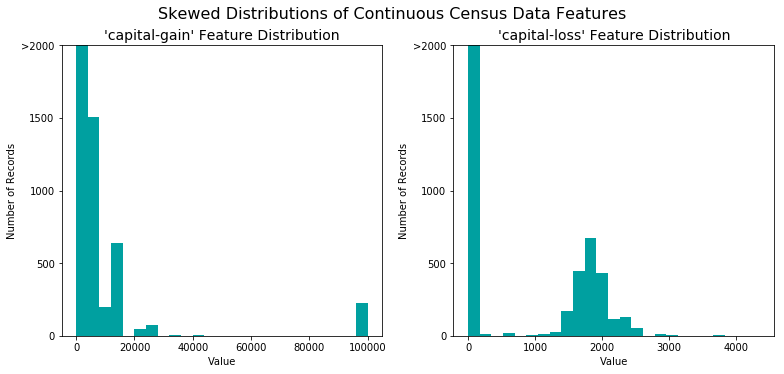

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

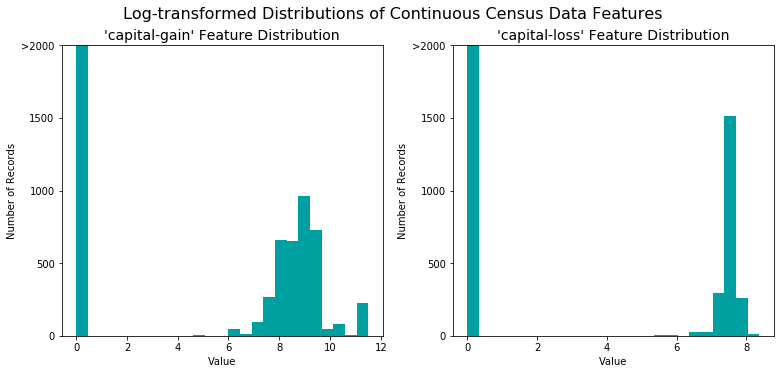

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x:1 if x== '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print (encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP+TN)/ (TP+TN+FP+FN)
recall = TP/(TP+FN) #[True Positives/(True Positives + False Negatives)]
precision = TP/(TP+FP) #[True Positives/(True Positives + False Positives)]

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore =(1 + 0.5**2)* ( (precision * recall) / ((0.5**2* precision)+recall))

# Print the results
                     
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))


Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **

Support Vector machine
----------------------------------
Application:
Handwriting Recognition

Strength:

SVM’s are very good when we have no idea on the data.
Works well with even unstructured and semi structured data like text, Images and trees.
The kernel trick is real strength of SVM. With an appropriate kernel function, we can solve any complex problem.
It scales relatively well to high dimensional data.

weaknesses:

Choosing a “good” kernel function is not easy.
Long training time for large datasets.
Difficult to understand and interpret the final model, variable weights and individual impact.
Since the final model is not so easy to see, we can not do small calibrations to the model hence its tough to incorporate our business logic.

Good candidate for the problem:
Because SVM is efficient with high dimension data. we got many features in our data set. 

ref: https://statinfer.com/204-6-8-svm-advantages-disadvantages-applications/

Gradient Boosting
--------------------------
Application:EMG Robotic ARM Controller


Strength:
It’s good for modelling complex data sets that could have both linear and non-linear variables
Builds new trees which complement the already built trees,To correct the errors
can handle different types of predictors and variables

weaknesses: 
unable to compute conditional classes probabilities
a lot of parameters for tune

Good candidate for the problem:
as we have a lot of features , it can find the most important features. so it produces good accurate results
ref:https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full#h7
 
LogisticRegression
----------------------------
Application:we can use it in all binary calssification problem., ex: identifing is it a spam mail or not.

Strength:
It is more robust: the independent variables don’t have to be normally distributed, or have equal variance in each group
It may handle nonlinear effects
Normally distributed error terms are not assumed.

weaknesses:
It requires much more data to achieve stable, meaningful results.

Good candidate for the problem:
Because we have binary output and logistic regression is very widely used

ref:https://victorfang.wordpress.com/2011/05/10/advantages-and-disadvantages-of-logistic-regression/

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size], y_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[0:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[0:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


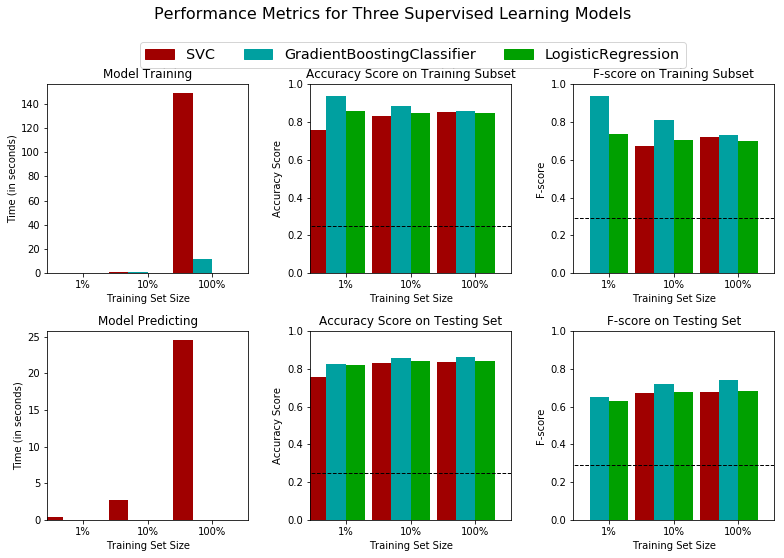

In [11]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the three models
clf_A = SVC()
clf_B = GradientBoostingClassifier()
clf_C = LogisticRegression()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

Form the above graphs we got many data that will help us to select the perfect fit model between the three models.
from my point of view i see that Gradient Boosting is the most acceptable model.
As it showes better results in accuracy and F-score in the testing data specially on the testing when 100% of the training data is used.

Also in Regards to the timming , Gradient boosting took some time in training but not too much time as SVC, however in Prediction it took almost no time. So its excelent in Predicting time, and acceptable in training time.
So as a conclusion Gradient Boosting is the most fitting algorithm in our case, as it shows very good results in terms of accurcy and F-score in both training and testing.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

As Gradient Boosting algorithm start by choosing a sample and continue its work, so maybe it selected all the samples of people >50K
so there were some values that caused some error, we will work on minimizing those errors as much as we can.
so we will keep training the algorithm and observe the testing results, but at some point the algorithm progress to accuracy will stabilize(it’s no longer gaining any improvement by adding in new trees.)So we can tune the algorithm to get the best performance.
A loss function is minimised at each stage to tell us which trees are going to significantly improve the result. 
To make a prediction, each variable is fed in to the model for an observation, and run through all the decision trees made. A weighted average across these trees will then tell us the expected classification.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier

clf = GradientBoostingClassifier()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'max_depth':[3,4,5]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf,param_grid=parameters,scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8682
Final F-score on the testing data: 0.7462


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8630       |     0.8682      |
| F-score        |      0.7395       |     0.7462      |


**Answer: **

Optimized score is better than unoptimized score in both metrics Accuracy and F-score.
Also optimized score is better than the benchmarks found earlier (Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917])
This enhancement happend as we increased the depth of the tree to 5 which gives the algorithm more complexity to b more accurate.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

1- education-num
Higher degree people have more knowledge than others, which means they will be more eligible to have higher position with higher salary
2-age
young people at the beginning of their work life will be earning less than the professional people having more experience and older in their positions.
3- occupation 
different job titles have different salary frames, each vacancy/job has a different scale in salaries.
4-relationship
the married people or the people who have children most probably will accept salaries not less than specific amount to be able to pay on their families.
5-workclass
different classes will earn different amout of money based on their profile. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

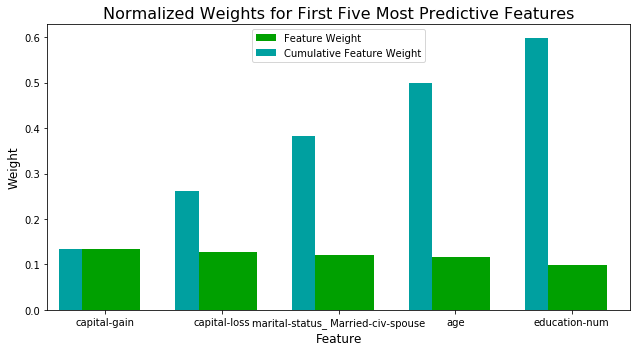

In [13]:
# TODO: Import a supervised learning model that has 'feature_importances_'

clf=GradientBoostingClassifier()
# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

There are 2 common features (education and age) which i see that both of thema are very logical to have a direct impact.

Regarding Capital-loss feature i thought that this is irrelevent to people as it is impacting the company from top level and salries shouldn't be impacted, but maybe this policy is applied in our case that employees are impacted by the capital-loss.

I still see that occupation is one of the importatnt factors/features that we can relay on.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8682
F-score on testing data: 0.7462

Final Model trained on reduced data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7240


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**
How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?

It looks very great , very close to using the full data metrics. The differences in Accuracy and F-score are very low percentage.

If training time was a factor, would you consider using the reduced data as your training set?

in our case yes i would consider using the reduced data if the time is one of the main factors that we care abut , speacially that the result od the reduced data is close and very acceptable comparing to the full data. 



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [36]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 498542 bytes to finding_donors.html']

In [ ]:
##HTML CODE##
<!DOCTYPE html>
<html>
<head><meta charset="utf-8" />

<title>finding_donors</title>

<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.1.10/require.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js"></script>



<style type="text/css">
    /*!
*
* Twitter Bootstrap
*
*/
/*!
 * Bootstrap v3.3.7 (http://getbootstrap.com)
 * Copyright 2011-2016 Twitter, Inc.
 * Licensed under MIT (https://github.com/twbs/bootstrap/blob/master/LICENSE)
 */
/*! normalize.css v3.0.3 | MIT License | github.com/necolas/normalize.css */
html {
  font-family: sans-serif;
  -ms-text-size-adjust: 100%;
  -webkit-text-size-adjust: 100%;
}
body {
  margin: 0;
}
article,
aside,
details,
figcaption,
figure,
footer,
header,
hgroup,
main,
menu,
nav,
section,
summary {
  display: block;
}
audio,
canvas,
progress,
video {
  display: inline-block;
  vertical-align: baseline;
}
audio:not([controls]) {
  display: none;
  height: 0;
}
[hidden],
template {
  display: none;
}
a {
  background-color: transparent;
}
a:active,
a:hover {
  outline: 0;
}
abbr[title] {
  border-bottom: 1px dotted;
}
b,
strong {
  font-weight: bold;
}
dfn {
  font-style: italic;
}
h1 {
  font-size: 2em;
  margin: 0.67em 0;
}
mark {
  background: #ff0;
  color: #000;
}
small {
  font-size: 80%;
}
sub,
sup {
  font-size: 75%;
  line-height: 0;
  position: relative;
  vertical-align: baseline;
}
sup {
  top: -0.5em;
}
sub {
  bottom: -0.25em;
}
img {
  border: 0;
}
svg:not(:root) {
  overflow: hidden;
}
figure {
  margin: 1em 40px;
}
hr {
  box-sizing: content-box;
  height: 0;
}
pre {
  overflow: auto;
}
code,
kbd,
pre,
samp {
  font-family: monospace, monospace;
  font-size: 1em;
}
button,
input,
optgroup,
select,
textarea {
  color: inherit;
  font: inherit;
  margin: 0;
}
button {
  overflow: visible;
}
button,
select {
  text-transform: none;
}
button,
html input[type="button"],
input[type="reset"],
input[type="submit"] {
  -webkit-appearance: button;
  cursor: pointer;
}
button[disabled],
html input[disabled] {
  cursor: default;
}
button::-moz-focus-inner,
input::-moz-focus-inner {
  border: 0;
  padding: 0;
}
input {
  line-height: normal;
}
input[type="checkbox"],
input[type="radio"] {
  box-sizing: border-box;
  padding: 0;
}
input[type="number"]::-webkit-inner-spin-button,
input[type="number"]::-webkit-outer-spin-button {
  height: auto;
}
input[type="search"] {
  -webkit-appearance: textfield;
  box-sizing: content-box;
}
input[type="search"]::-webkit-search-cancel-button,
input[type="search"]::-webkit-search-decoration {
  -webkit-appearance: none;
}
fieldset {
  border: 1px solid #c0c0c0;
  margin: 0 2px;
  padding: 0.35em 0.625em 0.75em;
}
legend {
  border: 0;
  padding: 0;
}
textarea {
  overflow: auto;
}
optgroup {
  font-weight: bold;
}
table {
  border-collapse: collapse;
  border-spacing: 0;
}
td,
th {
  padding: 0;
}
/*! Source: https://github.com/h5bp/html5-boilerplate/blob/master/src/css/main.css */
@media print {
  *,
  *:before,
  *:after {
    background: transparent !important;
    box-shadow: none !important;
    text-shadow: none !important;
  }
  a,
  a:visited {
    text-decoration: underline;
  }
  a[href]:after {
    content: " (" attr(href) ")";
  }
  abbr[title]:after {
    content: " (" attr(title) ")";
  }
  a[href^="#"]:after,
  a[href^="javascript:"]:after {
    content: "";
  }
  pre,
  blockquote {
    border: 1px solid #999;
    page-break-inside: avoid;
  }
  thead {
    display: table-header-group;
  }
  tr,
  img {
    page-break-inside: avoid;
  }
  img {
    max-width: 100% !important;
  }
  p,
  h2,
  h3 {
    orphans: 3;
    widows: 3;
  }
  h2,
  h3 {
    page-break-after: avoid;
  }
  .navbar {
    display: none;
  }
  .btn > .caret,
  .dropup > .btn > .caret {
    border-top-color: #000 !important;
  }
  .label {
    border: 1px solid #000;
  }
  .table {
    border-collapse: collapse !important;
  }
  .table td,
  .table th {
    background-color: #fff !important;
  }
  .table-bordered th,
  .table-bordered td {
    border: 1px solid #ddd !important;
  }
}
@font-face {
  font-family: 'Glyphicons Halflings';
  src: url('../components/bootstrap/fonts/glyphicons-halflings-regular.eot');
  src: url('../components/bootstrap/fonts/glyphicons-halflings-regular.eot?#iefix') format('embedded-opentype'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.woff2') format('woff2'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.woff') format('woff'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.ttf') format('truetype'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.svg#glyphicons_halflingsregular') format('svg');
}
.glyphicon {
  position: relative;
  top: 1px;
  display: inline-block;
  font-family: 'Glyphicons Halflings';
  font-style: normal;
  font-weight: normal;
  line-height: 1;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}
.glyphicon-asterisk:before {
  content: "\002a";
}
.glyphicon-plus:before {
  content: "\002b";
}
.glyphicon-euro:before,
.glyphicon-eur:before {
  content: "\20ac";
}
.glyphicon-minus:before {
  content: "\2212";
}
.glyphicon-cloud:before {
  content: "\2601";
}
.glyphicon-envelope:before {
  content: "\2709";
}
.glyphicon-pencil:before {
  content: "\270f";
}
.glyphicon-glass:before {
  content: "\e001";
}
.glyphicon-music:before {
  content: "\e002";
}
.glyphicon-search:before {
  content: "\e003";
}
.glyphicon-heart:before {
  content: "\e005";
}
.glyphicon-star:before {
  content: "\e006";
}
.glyphicon-star-empty:before {
  content: "\e007";
}
.glyphicon-user:before {
  content: "\e008";
}
.glyphicon-film:before {
  content: "\e009";
}
.glyphicon-th-large:before {
  content: "\e010";
}
.glyphicon-th:before {
  content: "\e011";
}
.glyphicon-th-list:before {
  content: "\e012";
}
.glyphicon-ok:before {
  content: "\e013";
}
.glyphicon-remove:before {
  content: "\e014";
}
.glyphicon-zoom-in:before {
  content: "\e015";
}
.glyphicon-zoom-out:before {
  content: "\e016";
}
.glyphicon-off:before {
  content: "\e017";
}
.glyphicon-signal:before {
  content: "\e018";
}
.glyphicon-cog:before {
  content: "\e019";
}
.glyphicon-trash:before {
  content: "\e020";
}
.glyphicon-home:before {
  content: "\e021";
}
.glyphicon-file:before {
  content: "\e022";
}
.glyphicon-time:before {
  content: "\e023";
}
.glyphicon-road:before {
  content: "\e024";
}
.glyphicon-download-alt:before {
  content: "\e025";
}
.glyphicon-download:before {
  content: "\e026";
}
.glyphicon-upload:before {
  content: "\e027";
}
.glyphicon-inbox:before {
  content: "\e028";
}
.glyphicon-play-circle:before {
  content: "\e029";
}
.glyphicon-repeat:before {
  content: "\e030";
}
.glyphicon-refresh:before {
  content: "\e031";
}
.glyphicon-list-alt:before {
  content: "\e032";
}
.glyphicon-lock:before {
  content: "\e033";
}
.glyphicon-flag:before {
  content: "\e034";
}
.glyphicon-headphones:before {
  content: "\e035";
}
.glyphicon-volume-off:before {
  content: "\e036";
}
.glyphicon-volume-down:before {
  content: "\e037";
}
.glyphicon-volume-up:before {
  content: "\e038";
}
.glyphicon-qrcode:before {
  content: "\e039";
}
.glyphicon-barcode:before {
  content: "\e040";
}
.glyphicon-tag:before {
  content: "\e041";
}
.glyphicon-tags:before {
  content: "\e042";
}
.glyphicon-book:before {
  content: "\e043";
}
.glyphicon-bookmark:before {
  content: "\e044";
}
.glyphicon-print:before {
  content: "\e045";
}
.glyphicon-camera:before {
  content: "\e046";
}
.glyphicon-font:before {
  content: "\e047";
}
.glyphicon-bold:before {
  content: "\e048";
}
.glyphicon-italic:before {
  content: "\e049";
}
.glyphicon-text-height:before {
  content: "\e050";
}
.glyphicon-text-width:before {
  content: "\e051";
}
.glyphicon-align-left:before {
  content: "\e052";
}
.glyphicon-align-center:before {
  content: "\e053";
}
.glyphicon-align-right:before {
  content: "\e054";
}
.glyphicon-align-justify:before {
  content: "\e055";
}
.glyphicon-list:before {
  content: "\e056";
}
.glyphicon-indent-left:before {
  content: "\e057";
}
.glyphicon-indent-right:before {
  content: "\e058";
}
.glyphicon-facetime-video:before {
  content: "\e059";
}
.glyphicon-picture:before {
  content: "\e060";
}
.glyphicon-map-marker:before {
  content: "\e062";
}
.glyphicon-adjust:before {
  content: "\e063";
}
.glyphicon-tint:before {
  content: "\e064";
}
.glyphicon-edit:before {
  content: "\e065";
}
.glyphicon-share:before {
  content: "\e066";
}
.glyphicon-check:before {
  content: "\e067";
}
.glyphicon-move:before {
  content: "\e068";
}
.glyphicon-step-backward:before {
  content: "\e069";
}
.glyphicon-fast-backward:before {
  content: "\e070";
}
.glyphicon-backward:before {
  content: "\e071";
}
.glyphicon-play:before {
  content: "\e072";
}
.glyphicon-pause:before {
  content: "\e073";
}
.glyphicon-stop:before {
  content: "\e074";
}
.glyphicon-forward:before {
  content: "\e075";
}
.glyphicon-fast-forward:before {
  content: "\e076";
}
.glyphicon-step-forward:before {
  content: "\e077";
}
.glyphicon-eject:before {
  content: "\e078";
}
.glyphicon-chevron-left:before {
  content: "\e079";
}
.glyphicon-chevron-right:before {
  content: "\e080";
}
.glyphicon-plus-sign:before {
  content: "\e081";
}
.glyphicon-minus-sign:before {
  content: "\e082";
}
.glyphicon-remove-sign:before {
  content: "\e083";
}
.glyphicon-ok-sign:before {
  content: "\e084";
}
.glyphicon-question-sign:before {
  content: "\e085";
}
.glyphicon-info-sign:before {
  content: "\e086";
}
.glyphicon-screenshot:before {
  content: "\e087";
}
.glyphicon-remove-circle:before {
  content: "\e088";
}
.glyphicon-ok-circle:before {
  content: "\e089";
}
.glyphicon-ban-circle:before {
  content: "\e090";
}
.glyphicon-arrow-left:before {
  content: "\e091";
}
.glyphicon-arrow-right:before {
  content: "\e092";
}
.glyphicon-arrow-up:before {
  content: "\e093";
}
.glyphicon-arrow-down:before {
  content: "\e094";
}
.glyphicon-share-alt:before {
  content: "\e095";
}
.glyphicon-resize-full:before {
  content: "\e096";
}
.glyphicon-resize-small:before {
  content: "\e097";
}
.glyphicon-exclamation-sign:before {
  content: "\e101";
}
.glyphicon-gift:before {
  content: "\e102";
}
.glyphicon-leaf:before {
  content: "\e103";
}
.glyphicon-fire:before {
  content: "\e104";
}
.glyphicon-eye-open:before {
  content: "\e105";
}
.glyphicon-eye-close:before {
  content: "\e106";
}
.glyphicon-warning-sign:before {
  content: "\e107";
}
.glyphicon-plane:before {
  content: "\e108";
}
.glyphicon-calendar:before {
  content: "\e109";
}
.glyphicon-random:before {
  content: "\e110";
}
.glyphicon-comment:before {
  content: "\e111";
}
.glyphicon-magnet:before {
  content: "\e112";
}
.glyphicon-chevron-up:before {
  content: "\e113";
}
.glyphicon-chevron-down:before {
  content: "\e114";
}
.glyphicon-retweet:before {
  content: "\e115";
}
.glyphicon-shopping-cart:before {
  content: "\e116";
}
.glyphicon-folder-close:before {
  content: "\e117";
}
.glyphicon-folder-open:before {
  content: "\e118";
}
.glyphicon-resize-vertical:before {
  content: "\e119";
}
.glyphicon-resize-horizontal:before {
  content: "\e120";
}
.glyphicon-hdd:before {
  content: "\e121";
}
.glyphicon-bullhorn:before {
  content: "\e122";
}
.glyphicon-bell:before {
  content: "\e123";
}
.glyphicon-certificate:before {
  content: "\e124";
}
.glyphicon-thumbs-up:before {
  content: "\e125";
}
.glyphicon-thumbs-down:before {
  content: "\e126";
}
.glyphicon-hand-right:before {
  content: "\e127";
}
.glyphicon-hand-left:before {
  content: "\e128";
}
.glyphicon-hand-up:before {
  content: "\e129";
}
.glyphicon-hand-down:before {
  content: "\e130";
}
.glyphicon-circle-arrow-right:before {
  content: "\e131";
}
.glyphicon-circle-arrow-left:before {
  content: "\e132";
}
.glyphicon-circle-arrow-up:before {
  content: "\e133";
}
.glyphicon-circle-arrow-down:before {
  content: "\e134";
}
.glyphicon-globe:before {
  content: "\e135";
}
.glyphicon-wrench:before {
  content: "\e136";
}
.glyphicon-tasks:before {
  content: "\e137";
}
.glyphicon-filter:before {
  content: "\e138";
}
.glyphicon-briefcase:before {
  content: "\e139";
}
.glyphicon-fullscreen:before {
  content: "\e140";
}
.glyphicon-dashboard:before {
  content: "\e141";
}
.glyphicon-paperclip:before {
  content: "\e142";
}
.glyphicon-heart-empty:before {
  content: "\e143";
}
.glyphicon-link:before {
  content: "\e144";
}
.glyphicon-phone:before {
  content: "\e145";
}
.glyphicon-pushpin:before {
  content: "\e146";
}
.glyphicon-usd:before {
  content: "\e148";
}
.glyphicon-gbp:before {
  content: "\e149";
}
.glyphicon-sort:before {
  content: "\e150";
}
.glyphicon-sort-by-alphabet:before {
  content: "\e151";
}
.glyphicon-sort-by-alphabet-alt:before {
  content: "\e152";
}
.glyphicon-sort-by-order:before {
  content: "\e153";
}
.glyphicon-sort-by-order-alt:before {
  content: "\e154";
}
.glyphicon-sort-by-attributes:before {
  content: "\e155";
}
.glyphicon-sort-by-attributes-alt:before {
  content: "\e156";
}
.glyphicon-unchecked:before {
  content: "\e157";
}
.glyphicon-expand:before {
  content: "\e158";
}
.glyphicon-collapse-down:before {
  content: "\e159";
}
.glyphicon-collapse-up:before {
  content: "\e160";
}
.glyphicon-log-in:before {
  content: "\e161";
}
.glyphicon-flash:before {
  content: "\e162";
}
.glyphicon-log-out:before {
  content: "\e163";
}
.glyphicon-new-window:before {
  content: "\e164";
}
.glyphicon-record:before {
  content: "\e165";
}
.glyphicon-save:before {
  content: "\e166";
}
.glyphicon-open:before {
  content: "\e167";
}
.glyphicon-saved:before {
  content: "\e168";
}
.glyphicon-import:before {
  content: "\e169";
}
.glyphicon-export:before {
  content: "\e170";
}
.glyphicon-send:before {
  content: "\e171";
}
.glyphicon-floppy-disk:before {
  content: "\e172";
}
.glyphicon-floppy-saved:before {
  content: "\e173";
}
.glyphicon-floppy-remove:before {
  content: "\e174";
}
.glyphicon-floppy-save:before {
  content: "\e175";
}
.glyphicon-floppy-open:before {
  content: "\e176";
}
.glyphicon-credit-card:before {
  content: "\e177";
}
.glyphicon-transfer:before {
  content: "\e178";
}
.glyphicon-cutlery:before {
  content: "\e179";
}
.glyphicon-header:before {
  content: "\e180";
}
.glyphicon-compressed:before {
  content: "\e181";
}
.glyphicon-earphone:before {
  content: "\e182";
}
.glyphicon-phone-alt:before {
  content: "\e183";
}
.glyphicon-tower:before {
  content: "\e184";
}
.glyphicon-stats:before {
  content: "\e185";
}
.glyphicon-sd-video:before {
  content: "\e186";
}
.glyphicon-hd-video:before {
  content: "\e187";
}
.glyphicon-subtitles:before {
  content: "\e188";
}
.glyphicon-sound-stereo:before {
  content: "\e189";
}
.glyphicon-sound-dolby:before {
  content: "\e190";
}
.glyphicon-sound-5-1:before {
  content: "\e191";
}
.glyphicon-sound-6-1:before {
  content: "\e192";
}
.glyphicon-sound-7-1:before {
  content: "\e193";
}
.glyphicon-copyright-mark:before {
  content: "\e194";
}
.glyphicon-registration-mark:before {
  content: "\e195";
}
.glyphicon-cloud-download:before {
  content: "\e197";
}
.glyphicon-cloud-upload:before {
  content: "\e198";
}
.glyphicon-tree-conifer:before {
  content: "\e199";
}
.glyphicon-tree-deciduous:before {
  content: "\e200";
}
.glyphicon-cd:before {
  content: "\e201";
}
.glyphicon-save-file:before {
  content: "\e202";
}
.glyphicon-open-file:before {
  content: "\e203";
}
.glyphicon-level-up:before {
  content: "\e204";
}
.glyphicon-copy:before {
  content: "\e205";
}
.glyphicon-paste:before {
  content: "\e206";
}
.glyphicon-alert:before {
  content: "\e209";
}
.glyphicon-equalizer:before {
  content: "\e210";
}
.glyphicon-king:before {
  content: "\e211";
}
.glyphicon-queen:before {
  content: "\e212";
}
.glyphicon-pawn:before {
  content: "\e213";
}
.glyphicon-bishop:before {
  content: "\e214";
}
.glyphicon-knight:before {
  content: "\e215";
}
.glyphicon-baby-formula:before {
  content: "\e216";
}
.glyphicon-tent:before {
  content: "\26fa";
}
.glyphicon-blackboard:before {
  content: "\e218";
}
.glyphicon-bed:before {
  content: "\e219";
}
.glyphicon-apple:before {
  content: "\f8ff";
}
.glyphicon-erase:before {
  content: "\e221";
}
.glyphicon-hourglass:before {
  content: "\231b";
}
.glyphicon-lamp:before {
  content: "\e223";
}
.glyphicon-duplicate:before {
  content: "\e224";
}
.glyphicon-piggy-bank:before {
  content: "\e225";
}
.glyphicon-scissors:before {
  content: "\e226";
}
.glyphicon-bitcoin:before {
  content: "\e227";
}
.glyphicon-btc:before {
  content: "\e227";
}
.glyphicon-xbt:before {
  content: "\e227";
}
.glyphicon-yen:before {
  content: "\00a5";
}
.glyphicon-jpy:before {
  content: "\00a5";
}
.glyphicon-ruble:before {
  content: "\20bd";
}
.glyphicon-rub:before {
  content: "\20bd";
}
.glyphicon-scale:before {
  content: "\e230";
}
.glyphicon-ice-lolly:before {
  content: "\e231";
}
.glyphicon-ice-lolly-tasted:before {
  content: "\e232";
}
.glyphicon-education:before {
  content: "\e233";
}
.glyphicon-option-horizontal:before {
  content: "\e234";
}
.glyphicon-option-vertical:before {
  content: "\e235";
}
.glyphicon-menu-hamburger:before {
  content: "\e236";
}
.glyphicon-modal-window:before {
  content: "\e237";
}
.glyphicon-oil:before {
  content: "\e238";
}
.glyphicon-grain:before {
  content: "\e239";
}
.glyphicon-sunglasses:before {
  content: "\e240";
}
.glyphicon-text-size:before {
  content: "\e241";
}
.glyphicon-text-color:before {
  content: "\e242";
}
.glyphicon-text-background:before {
  content: "\e243";
}
.glyphicon-object-align-top:before {
  content: "\e244";
}
.glyphicon-object-align-bottom:before {
  content: "\e245";
}
.glyphicon-object-align-horizontal:before {
  content: "\e246";
}
.glyphicon-object-align-left:before {
  content: "\e247";
}
.glyphicon-object-align-vertical:before {
  content: "\e248";
}
.glyphicon-object-align-right:before {
  content: "\e249";
}
.glyphicon-triangle-right:before {
  content: "\e250";
}
.glyphicon-triangle-left:before {
  content: "\e251";
}
.glyphicon-triangle-bottom:before {
  content: "\e252";
}
.glyphicon-triangle-top:before {
  content: "\e253";
}
.glyphicon-console:before {
  content: "\e254";
}
.glyphicon-superscript:before {
  content: "\e255";
}
.glyphicon-subscript:before {
  content: "\e256";
}
.glyphicon-menu-left:before {
  content: "\e257";
}
.glyphicon-menu-right:before {
  content: "\e258";
}
.glyphicon-menu-down:before {
  content: "\e259";
}
.glyphicon-menu-up:before {
  content: "\e260";
}
* {
  -webkit-box-sizing: border-box;
  -moz-box-sizing: border-box;
  box-sizing: border-box;
}
*:before,
*:after {
  -webkit-box-sizing: border-box;
  -moz-box-sizing: border-box;
  box-sizing: border-box;
}
html {
  font-size: 10px;
  -webkit-tap-highlight-color: rgba(0, 0, 0, 0);
}
body {
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
  font-size: 13px;
  line-height: 1.42857143;
  color: #000;
  background-color: #fff;
}
input,
button,
select,
textarea {
  font-family: inherit;
  font-size: inherit;
  line-height: inherit;
}
a {
  color: #337ab7;
  text-decoration: none;
}
a:hover,
a:focus {
  color: #23527c;
  text-decoration: underline;
}
a:focus {
  outline: 5px auto -webkit-focus-ring-color;
  outline-offset: -2px;
}
figure {
  margin: 0;
}
img {
  vertical-align: middle;
}
.img-responsive,
.thumbnail > img,
.thumbnail a > img,
.carousel-inner > .item > img,
.carousel-inner > .item > a > img {
  display: block;
  max-width: 100%;
  height: auto;
}
.img-rounded {
  border-radius: 3px;
}
.img-thumbnail {
  padding: 4px;
  line-height: 1.42857143;
  background-color: #fff;
  border: 1px solid #ddd;
  border-radius: 2px;
  -webkit-transition: all 0.2s ease-in-out;
  -o-transition: all 0.2s ease-in-out;
  transition: all 0.2s ease-in-out;
  display: inline-block;
  max-width: 100%;
  height: auto;
}
.img-circle {
  border-radius: 50%;
}
hr {
  margin-top: 18px;
  margin-bottom: 18px;
  border: 0;
  border-top: 1px solid #eeeeee;
}
.sr-only {
  position: absolute;
  width: 1px;
  height: 1px;
  margin: -1px;
  padding: 0;
  overflow: hidden;
  clip: rect(0, 0, 0, 0);
  border: 0;
}
.sr-only-focusable:active,
.sr-only-focusable:focus {
  position: static;
  width: auto;
  height: auto;
  margin: 0;
  overflow: visible;
  clip: auto;
}
[role="button"] {
  cursor: pointer;
}
h1,
h2,
h3,
h4,
h5,
h6,
.h1,
.h2,
.h3,
.h4,
.h5,
.h6 {
  font-family: inherit;
  font-weight: 500;
  line-height: 1.1;
  color: inherit;
}
h1 small,
h2 small,
h3 small,
h4 small,
h5 small,
h6 small,
.h1 small,
.h2 small,
.h3 small,
.h4 small,
.h5 small,
.h6 small,
h1 .small,
h2 .small,
h3 .small,
h4 .small,
h5 .small,
h6 .small,
.h1 .small,
.h2 .small,
.h3 .small,
.h4 .small,
.h5 .small,
.h6 .small {
  font-weight: normal;
  line-height: 1;
  color: #777777;
}
h1,
.h1,
h2,
.h2,
h3,
.h3 {
  margin-top: 18px;
  margin-bottom: 9px;
}
h1 small,
.h1 small,
h2 small,
.h2 small,
h3 small,
.h3 small,
h1 .small,
.h1 .small,
h2 .small,
.h2 .small,
h3 .small,
.h3 .small {
  font-size: 65%;
}
h4,
.h4,
h5,
.h5,
h6,
.h6 {
  margin-top: 9px;
  margin-bottom: 9px;
}
h4 small,
.h4 small,
h5 small,
.h5 small,
h6 small,
.h6 small,
h4 .small,
.h4 .small,
h5 .small,
.h5 .small,
h6 .small,
.h6 .small {
  font-size: 75%;
}
h1,
.h1 {
  font-size: 33px;
}
h2,
.h2 {
  font-size: 27px;
}
h3,
.h3 {
  font-size: 23px;
}
h4,
.h4 {
  font-size: 17px;
}
h5,
.h5 {
  font-size: 13px;
}
h6,
.h6 {
  font-size: 12px;
}
p {
  margin: 0 0 9px;
}
.lead {
  margin-bottom: 18px;
  font-size: 14px;
  font-weight: 300;
  line-height: 1.4;
}
@media (min-width: 768px) {
  .lead {
    font-size: 19.5px;
  }
}
small,
.small {
  font-size: 92%;
}
mark,
.mark {
  background-color: #fcf8e3;
  padding: .2em;
}
.text-left {
  text-align: left;
}
.text-right {
  text-align: right;
}
.text-center {
  text-align: center;
}
.text-justify {
  text-align: justify;
}
.text-nowrap {
  white-space: nowrap;
}
.text-lowercase {
  text-transform: lowercase;
}
.text-uppercase {
  text-transform: uppercase;
}
.text-capitalize {
  text-transform: capitalize;
}
.text-muted {
  color: #777777;
}
.text-primary {
  color: #337ab7;
}
a.text-primary:hover,
a.text-primary:focus {
  color: #286090;
}
.text-success {
  color: #3c763d;
}
a.text-success:hover,
a.text-success:focus {
  color: #2b542c;
}
.text-info {
  color: #31708f;
}
a.text-info:hover,
a.text-info:focus {
  color: #245269;
}
.text-warning {
  color: #8a6d3b;
}
a.text-warning:hover,
a.text-warning:focus {
  color: #66512c;
}
.text-danger {
  color: #a94442;
}
a.text-danger:hover,
a.text-danger:focus {
  color: #843534;
}
.bg-primary {
  color: #fff;
  background-color: #337ab7;
}
a.bg-primary:hover,
a.bg-primary:focus {
  background-color: #286090;
}
.bg-success {
  background-color: #dff0d8;
}
a.bg-success:hover,
a.bg-success:focus {
  background-color: #c1e2b3;
}
.bg-info {
  background-color: #d9edf7;
}
a.bg-info:hover,
a.bg-info:focus {
  background-color: #afd9ee;
}
.bg-warning {
  background-color: #fcf8e3;
}
a.bg-warning:hover,
a.bg-warning:focus {
  background-color: #f7ecb5;
}
.bg-danger {
  background-color: #f2dede;
}
a.bg-danger:hover,
a.bg-danger:focus {
  background-color: #e4b9b9;
}
.page-header {
  padding-bottom: 8px;
  margin: 36px 0 18px;
  border-bottom: 1px solid #eeeeee;
}
ul,
ol {
  margin-top: 0;
  margin-bottom: 9px;
}
ul ul,
ol ul,
ul ol,
ol ol {
  margin-bottom: 0;
}
.list-unstyled {
  padding-left: 0;
  list-style: none;
}
.list-inline {
  padding-left: 0;
  list-style: none;
  margin-left: -5px;
}
.list-inline > li {
  display: inline-block;
  padding-left: 5px;
  padding-right: 5px;
}
dl {
  margin-top: 0;
  margin-bottom: 18px;
}
dt,
dd {
  line-height: 1.42857143;
}
dt {
  font-weight: bold;
}
dd {
  margin-left: 0;
}
@media (min-width: 541px) {
  .dl-horizontal dt {
    float: left;
    width: 160px;
    clear: left;
    text-align: right;
    overflow: hidden;
    text-overflow: ellipsis;
    white-space: nowrap;
  }
  .dl-horizontal dd {
    margin-left: 180px;
  }
}
abbr[title],
abbr[data-original-title] {
  cursor: help;
  border-bottom: 1px dotted #777777;
}
.initialism {
  font-size: 90%;
  text-transform: uppercase;
}
blockquote {
  padding: 9px 18px;
  margin: 0 0 18px;
  font-size: inherit;
  border-left: 5px solid #eeeeee;
}
blockquote p:last-child,
blockquote ul:last-child,
blockquote ol:last-child {
  margin-bottom: 0;
}
blockquote footer,
blockquote small,
blockquote .small {
  display: block;
  font-size: 80%;
  line-height: 1.42857143;
  color: #777777;
}
blockquote footer:before,
blockquote small:before,
blockquote .small:before {
  content: '\2014 \00A0';
}
.blockquote-reverse,
blockquote.pull-right {
  padding-right: 15px;
  padding-left: 0;
  border-right: 5px solid #eeeeee;
  border-left: 0;
  text-align: right;
}
.blockquote-reverse footer:before,
blockquote.pull-right footer:before,
.blockquote-reverse small:before,
blockquote.pull-right small:before,
.blockquote-reverse .small:before,
blockquote.pull-right .small:before {
  content: '';
}
.blockquote-reverse footer:after,
blockquote.pull-right footer:after,
.blockquote-reverse small:after,
blockquote.pull-right small:after,
.blockquote-reverse .small:after,
blockquote.pull-right .small:after {
  content: '\00A0 \2014';
}
address {
  margin-bottom: 18px;
  font-style: normal;
  line-height: 1.42857143;
}
code,
kbd,
pre,
samp {
  font-family: monospace;
}
code {
  padding: 2px 4px;
  font-size: 90%;
  color: #c7254e;
  background-color: #f9f2f4;
  border-radius: 2px;
}
kbd {
  padding: 2px 4px;
  font-size: 90%;
  color: #888;
  background-color: transparent;
  border-radius: 1px;
  box-shadow: inset 0 -1px 0 rgba(0, 0, 0, 0.25);
}
kbd kbd {
  padding: 0;
  font-size: 100%;
  font-weight: bold;
  box-shadow: none;
}
pre {
  display: block;
  padding: 8.5px;
  margin: 0 0 9px;
  font-size: 12px;
  line-height: 1.42857143;
  word-break: break-all;
  word-wrap: break-word;
  color: #333333;
  background-color: #f5f5f5;
  border: 1px solid #ccc;
  border-radius: 2px;
}
pre code {
  padding: 0;
  font-size: inherit;
  color: inherit;
  white-space: pre-wrap;
  background-color: transparent;
  border-radius: 0;
}
.pre-scrollable {
  max-height: 340px;
  overflow-y: scroll;
}
.container {
  margin-right: auto;
  margin-left: auto;
  padding-left: 0px;
  padding-right: 0px;
}
@media (min-width: 768px) {
  .container {
    width: 768px;
  }
}
@media (min-width: 992px) {
  .container {
    width: 940px;
  }
}
@media (min-width: 1200px) {
  .container {
    width: 1140px;
  }
}
.container-fluid {
  margin-right: auto;
  margin-left: auto;
  padding-left: 0px;
  padding-right: 0px;
}
.row {
  margin-left: 0px;
  margin-right: 0px;
}
.col-xs-1, .col-sm-1, .col-md-1, .col-lg-1, .col-xs-2, .col-sm-2, .col-md-2, .col-lg-2, .col-xs-3, .col-sm-3, .col-md-3, .col-lg-3, .col-xs-4, .col-sm-4, .col-md-4, .col-lg-4, .col-xs-5, .col-sm-5, .col-md-5, .col-lg-5, .col-xs-6, .col-sm-6, .col-md-6, .col-lg-6, .col-xs-7, .col-sm-7, .col-md-7, .col-lg-7, .col-xs-8, .col-sm-8, .col-md-8, .col-lg-8, .col-xs-9, .col-sm-9, .col-md-9, .col-lg-9, .col-xs-10, .col-sm-10, .col-md-10, .col-lg-10, .col-xs-11, .col-sm-11, .col-md-11, .col-lg-11, .col-xs-12, .col-sm-12, .col-md-12, .col-lg-12 {
  position: relative;
  min-height: 1px;
  padding-left: 0px;
  padding-right: 0px;
}
.col-xs-1, .col-xs-2, .col-xs-3, .col-xs-4, .col-xs-5, .col-xs-6, .col-xs-7, .col-xs-8, .col-xs-9, .col-xs-10, .col-xs-11, .col-xs-12 {
  float: left;
}
.col-xs-12 {
  width: 100%;
}
.col-xs-11 {
  width: 91.66666667%;
}
.col-xs-10 {
  width: 83.33333333%;
}
.col-xs-9 {
  width: 75%;
}
.col-xs-8 {
  width: 66.66666667%;
}
.col-xs-7 {
  width: 58.33333333%;
}
.col-xs-6 {
  width: 50%;
}
.col-xs-5 {
  width: 41.66666667%;
}
.col-xs-4 {
  width: 33.33333333%;
}
.col-xs-3 {
  width: 25%;
}
.col-xs-2 {
  width: 16.66666667%;
}
.col-xs-1 {
  width: 8.33333333%;
}
.col-xs-pull-12 {
  right: 100%;
}
.col-xs-pull-11 {
  right: 91.66666667%;
}
.col-xs-pull-10 {
  right: 83.33333333%;
}
.col-xs-pull-9 {
  right: 75%;
}
.col-xs-pull-8 {
  right: 66.66666667%;
}
.col-xs-pull-7 {
  right: 58.33333333%;
}
.col-xs-pull-6 {
  right: 50%;
}
.col-xs-pull-5 {
  right: 41.66666667%;
}
.col-xs-pull-4 {
  right: 33.33333333%;
}
.col-xs-pull-3 {
  right: 25%;
}
.col-xs-pull-2 {
  right: 16.66666667%;
}
.col-xs-pull-1 {
  right: 8.33333333%;
}
.col-xs-pull-0 {
  right: auto;
}
.col-xs-push-12 {
  left: 100%;
}
.col-xs-push-11 {
  left: 91.66666667%;
}
.col-xs-push-10 {
  left: 83.33333333%;
}
.col-xs-push-9 {
  left: 75%;
}
.col-xs-push-8 {
  left: 66.66666667%;
}
.col-xs-push-7 {
  left: 58.33333333%;
}
.col-xs-push-6 {
  left: 50%;
}
.col-xs-push-5 {
  left: 41.66666667%;
}
.col-xs-push-4 {
  left: 33.33333333%;
}
.col-xs-push-3 {
  left: 25%;
}
.col-xs-push-2 {
  left: 16.66666667%;
}
.col-xs-push-1 {
  left: 8.33333333%;
}
.col-xs-push-0 {
  left: auto;
}
.col-xs-offset-12 {
  margin-left: 100%;
}
.col-xs-offset-11 {
  margin-left: 91.66666667%;
}
.col-xs-offset-10 {
  margin-left: 83.33333333%;
}
.col-xs-offset-9 {
  margin-left: 75%;
}
.col-xs-offset-8 {
  margin-left: 66.66666667%;
}
.col-xs-offset-7 {
  margin-left: 58.33333333%;
}
.col-xs-offset-6 {
  margin-left: 50%;
}
.col-xs-offset-5 {
  margin-left: 41.66666667%;
}
.col-xs-offset-4 {
  margin-left: 33.33333333%;
}
.col-xs-offset-3 {
  margin-left: 25%;
}
.col-xs-offset-2 {
  margin-left: 16.66666667%;
}
.col-xs-offset-1 {
  margin-left: 8.33333333%;
}
.col-xs-offset-0 {
  margin-left: 0%;
}
@media (min-width: 768px) {
  .col-sm-1, .col-sm-2, .col-sm-3, .col-sm-4, .col-sm-5, .col-sm-6, .col-sm-7, .col-sm-8, .col-sm-9, .col-sm-10, .col-sm-11, .col-sm-12 {
    float: left;
  }
  .col-sm-12 {
    width: 100%;
  }
  .col-sm-11 {
    width: 91.66666667%;
  }
  .col-sm-10 {
    width: 83.33333333%;
  }
  .col-sm-9 {
    width: 75%;
  }
  .col-sm-8 {
    width: 66.66666667%;
  }
  .col-sm-7 {
    width: 58.33333333%;
  }
  .col-sm-6 {
    width: 50%;
  }
  .col-sm-5 {
    width: 41.66666667%;
  }
  .col-sm-4 {
    width: 33.33333333%;
  }
  .col-sm-3 {
    width: 25%;
  }
  .col-sm-2 {
    width: 16.66666667%;
  }
  .col-sm-1 {
    width: 8.33333333%;
  }
  .col-sm-pull-12 {
    right: 100%;
  }
  .col-sm-pull-11 {
    right: 91.66666667%;
  }
  .col-sm-pull-10 {
    right: 83.33333333%;
  }
  .col-sm-pull-9 {
    right: 75%;
  }
  .col-sm-pull-8 {
    right: 66.66666667%;
  }
  .col-sm-pull-7 {
    right: 58.33333333%;
  }
  .col-sm-pull-6 {
    right: 50%;
  }
  .col-sm-pull-5 {
    right: 41.66666667%;
  }
  .col-sm-pull-4 {
    right: 33.33333333%;
  }
  .col-sm-pull-3 {
    right: 25%;
  }
  .col-sm-pull-2 {
    right: 16.66666667%;
  }
  .col-sm-pull-1 {
    right: 8.33333333%;
  }
  .col-sm-pull-0 {
    right: auto;
  }
  .col-sm-push-12 {
    left: 100%;
  }
  .col-sm-push-11 {
    left: 91.66666667%;
  }
  .col-sm-push-10 {
    left: 83.33333333%;
  }
  .col-sm-push-9 {
    left: 75%;
  }
  .col-sm-push-8 {
    left: 66.66666667%;
  }
  .col-sm-push-7 {
    left: 58.33333333%;
  }
  .col-sm-push-6 {
    left: 50%;
  }
  .col-sm-push-5 {
    left: 41.66666667%;
  }
  .col-sm-push-4 {
    left: 33.33333333%;
  }
  .col-sm-push-3 {
    left: 25%;
  }
  .col-sm-push-2 {
    left: 16.66666667%;
  }
  .col-sm-push-1 {
    left: 8.33333333%;
  }
  .col-sm-push-0 {
    left: auto;
  }
  .col-sm-offset-12 {
    margin-left: 100%;
  }
  .col-sm-offset-11 {
    margin-left: 91.66666667%;
  }
  .col-sm-offset-10 {
    margin-left: 83.33333333%;
  }
  .col-sm-offset-9 {
    margin-left: 75%;
  }
  .col-sm-offset-8 {
    margin-left: 66.66666667%;
  }
  .col-sm-offset-7 {
    margin-left: 58.33333333%;
  }
  .col-sm-offset-6 {
    margin-left: 50%;
  }
  .col-sm-offset-5 {
    margin-left: 41.66666667%;
  }
  .col-sm-offset-4 {
    margin-left: 33.33333333%;
  }
  .col-sm-offset-3 {
    margin-left: 25%;
  }
  .col-sm-offset-2 {
    margin-left: 16.66666667%;
  }
  .col-sm-offset-1 {
    margin-left: 8.33333333%;
  }
  .col-sm-offset-0 {
    margin-left: 0%;
  }
}
@media (min-width: 992px) {
  .col-md-1, .col-md-2, .col-md-3, .col-md-4, .col-md-5, .col-md-6, .col-md-7, .col-md-8, .col-md-9, .col-md-10, .col-md-11, .col-md-12 {
    float: left;
  }
  .col-md-12 {
    width: 100%;
  }
  .col-md-11 {
    width: 91.66666667%;
  }
  .col-md-10 {
    width: 83.33333333%;
  }
  .col-md-9 {
    width: 75%;
  }
  .col-md-8 {
    width: 66.66666667%;
  }
  .col-md-7 {
    width: 58.33333333%;
  }
  .col-md-6 {
    width: 50%;
  }
  .col-md-5 {
    width: 41.66666667%;
  }
  .col-md-4 {
    width: 33.33333333%;
  }
  .col-md-3 {
    width: 25%;
  }
  .col-md-2 {
    width: 16.66666667%;
  }
  .col-md-1 {
    width: 8.33333333%;
  }
  .col-md-pull-12 {
    right: 100%;
  }
  .col-md-pull-11 {
    right: 91.66666667%;
  }
  .col-md-pull-10 {
    right: 83.33333333%;
  }
  .col-md-pull-9 {
    right: 75%;
  }
  .col-md-pull-8 {
    right: 66.66666667%;
  }
  .col-md-pull-7 {
    right: 58.33333333%;
  }
  .col-md-pull-6 {
    right: 50%;
  }
  .col-md-pull-5 {
    right: 41.66666667%;
  }
  .col-md-pull-4 {
    right: 33.33333333%;
  }
  .col-md-pull-3 {
    right: 25%;
  }
  .col-md-pull-2 {
    right: 16.66666667%;
  }
  .col-md-pull-1 {
    right: 8.33333333%;
  }
  .col-md-pull-0 {
    right: auto;
  }
  .col-md-push-12 {
    left: 100%;
  }
  .col-md-push-11 {
    left: 91.66666667%;
  }
  .col-md-push-10 {
    left: 83.33333333%;
  }
  .col-md-push-9 {
    left: 75%;
  }
  .col-md-push-8 {
    left: 66.66666667%;
  }
  .col-md-push-7 {
    left: 58.33333333%;
  }
  .col-md-push-6 {
    left: 50%;
  }
  .col-md-push-5 {
    left: 41.66666667%;
  }
  .col-md-push-4 {
    left: 33.33333333%;
  }
  .col-md-push-3 {
    left: 25%;
  }
  .col-md-push-2 {
    left: 16.66666667%;
  }
  .col-md-push-1 {
    left: 8.33333333%;
  }
  .col-md-push-0 {
    left: auto;
  }
  .col-md-offset-12 {
    margin-left: 100%;
  }
  .col-md-offset-11 {
    margin-left: 91.66666667%;
  }
  .col-md-offset-10 {
    margin-left: 83.33333333%;
  }
  .col-md-offset-9 {
    margin-left: 75%;
  }
  .col-md-offset-8 {
    margin-left: 66.66666667%;
  }
  .col-md-offset-7 {
    margin-left: 58.33333333%;
  }
  .col-md-offset-6 {
    margin-left: 50%;
  }
  .col-md-offset-5 {
    margin-left: 41.66666667%;
  }
  .col-md-offset-4 {
    margin-left: 33.33333333%;
  }
  .col-md-offset-3 {
    margin-left: 25%;
  }
  .col-md-offset-2 {
    margin-left: 16.66666667%;
  }
  .col-md-offset-1 {
    margin-left: 8.33333333%;
  }
  .col-md-offset-0 {
    margin-left: 0%;
  }
}
@media (min-width: 1200px) {
  .col-lg-1, .col-lg-2, .col-lg-3, .col-lg-4, .col-lg-5, .col-lg-6, .col-lg-7, .col-lg-8, .col-lg-9, .col-lg-10, .col-lg-11, .col-lg-12 {
    float: left;
  }
  .col-lg-12 {
    width: 100%;
  }
  .col-lg-11 {
    width: 91.66666667%;
  }
  .col-lg-10 {
    width: 83.33333333%;
  }
  .col-lg-9 {
    width: 75%;
  }
  .col-lg-8 {
    width: 66.66666667%;
  }
  .col-lg-7 {
    width: 58.33333333%;
  }
  .col-lg-6 {
    width: 50%;
  }
  .col-lg-5 {
    width: 41.66666667%;
  }
  .col-lg-4 {
    width: 33.33333333%;
  }
  .col-lg-3 {
    width: 25%;
  }
  .col-lg-2 {
    width: 16.66666667%;
  }
  .col-lg-1 {
    width: 8.33333333%;
  }
  .col-lg-pull-12 {
    right: 100%;
  }
  .col-lg-pull-11 {
    right: 91.66666667%;
  }
  .col-lg-pull-10 {
    right: 83.33333333%;
  }
  .col-lg-pull-9 {
    right: 75%;
  }
  .col-lg-pull-8 {
    right: 66.66666667%;
  }
  .col-lg-pull-7 {
    right: 58.33333333%;
  }
  .col-lg-pull-6 {
    right: 50%;
  }
  .col-lg-pull-5 {
    right: 41.66666667%;
  }
  .col-lg-pull-4 {
    right: 33.33333333%;
  }
  .col-lg-pull-3 {
    right: 25%;
  }
  .col-lg-pull-2 {
    right: 16.66666667%;
  }
  .col-lg-pull-1 {
    right: 8.33333333%;
  }
  .col-lg-pull-0 {
    right: auto;
  }
  .col-lg-push-12 {
    left: 100%;
  }
  .col-lg-push-11 {
    left: 91.66666667%;
  }
  .col-lg-push-10 {
    left: 83.33333333%;
  }
  .col-lg-push-9 {
    left: 75%;
  }
  .col-lg-push-8 {
    left: 66.66666667%;
  }
  .col-lg-push-7 {
    left: 58.33333333%;
  }
  .col-lg-push-6 {
    left: 50%;
  }
  .col-lg-push-5 {
    left: 41.66666667%;
  }
  .col-lg-push-4 {
    left: 33.33333333%;
  }
  .col-lg-push-3 {
    left: 25%;
  }
  .col-lg-push-2 {
    left: 16.66666667%;
  }
  .col-lg-push-1 {
    left: 8.33333333%;
  }
  .col-lg-push-0 {
    left: auto;
  }
  .col-lg-offset-12 {
    margin-left: 100%;
  }
  .col-lg-offset-11 {
    margin-left: 91.66666667%;
  }
  .col-lg-offset-10 {
    margin-left: 83.33333333%;
  }
  .col-lg-offset-9 {
    margin-left: 75%;
  }
  .col-lg-offset-8 {
    margin-left: 66.66666667%;
  }
  .col-lg-offset-7 {
    margin-left: 58.33333333%;
  }
  .col-lg-offset-6 {
    margin-left: 50%;
  }
  .col-lg-offset-5 {
    margin-left: 41.66666667%;
  }
  .col-lg-offset-4 {
    margin-left: 33.33333333%;
  }
  .col-lg-offset-3 {
    margin-left: 25%;
  }
  .col-lg-offset-2 {
    margin-left: 16.66666667%;
  }
  .col-lg-offset-1 {
    margin-left: 8.33333333%;
  }
  .col-lg-offset-0 {
    margin-left: 0%;
  }
}
table {
  background-color: transparent;
}
caption {
  padding-top: 8px;
  padding-bottom: 8px;
  color: #777777;
  text-align: left;
}
th {
  text-align: left;
}
.table {
  width: 100%;
  max-width: 100%;
  margin-bottom: 18px;
}
.table > thead > tr > th,
.table > tbody > tr > th,
.table > tfoot > tr > th,
.table > thead > tr > td,
.table > tbody > tr > td,
.table > tfoot > tr > td {
  padding: 8px;
  line-height: 1.42857143;
  vertical-align: top;
  border-top: 1px solid #ddd;
}
.table > thead > tr > th {
  vertical-align: bottom;
  border-bottom: 2px solid #ddd;
}
.table > caption + thead > tr:first-child > th,
.table > colgroup + thead > tr:first-child > th,
.table > thead:first-child > tr:first-child > th,
.table > caption + thead > tr:first-child > td,
.table > colgroup + thead > tr:first-child > td,
.table > thead:first-child > tr:first-child > td {
  border-top: 0;
}
.table > tbody + tbody {
  border-top: 2px solid #ddd;
}
.table .table {
  background-color: #fff;
}
.table-condensed > thead > tr > th,
.table-condensed > tbody > tr > th,
.table-condensed > tfoot > tr > th,
.table-condensed > thead > tr > td,
.table-condensed > tbody > tr > td,
.table-condensed > tfoot > tr > td {
  padding: 5px;
}
.table-bordered {
  border: 1px solid #ddd;
}
.table-bordered > thead > tr > th,
.table-bordered > tbody > tr > th,
.table-bordered > tfoot > tr > th,
.table-bordered > thead > tr > td,
.table-bordered > tbody > tr > td,
.table-bordered > tfoot > tr > td {
  border: 1px solid #ddd;
}
.table-bordered > thead > tr > th,
.table-bordered > thead > tr > td {
  border-bottom-width: 2px;
}
.table-striped > tbody > tr:nth-of-type(odd) {
  background-color: #f9f9f9;
}
.table-hover > tbody > tr:hover {
  background-color: #f5f5f5;
}
table col[class*="col-"] {
  position: static;
  float: none;
  display: table-column;
}
table td[class*="col-"],
table th[class*="col-"] {
  position: static;
  float: none;
  display: table-cell;
}
.table > thead > tr > td.active,
.table > tbody > tr > td.active,
.table > tfoot > tr > td.active,
.table > thead > tr > th.active,
.table > tbody > tr > th.active,
.table > tfoot > tr > th.active,
.table > thead > tr.active > td,
.table > tbody > tr.active > td,
.table > tfoot > tr.active > td,
.table > thead > tr.active > th,
.table > tbody > tr.active > th,
.table > tfoot > tr.active > th {
  background-color: #f5f5f5;
}
.table-hover > tbody > tr > td.active:hover,
.table-hover > tbody > tr > th.active:hover,
.table-hover > tbody > tr.active:hover > td,
.table-hover > tbody > tr:hover > .active,
.table-hover > tbody > tr.active:hover > th {
  background-color: #e8e8e8;
}
.table > thead > tr > td.success,
.table > tbody > tr > td.success,
.table > tfoot > tr > td.success,
.table > thead > tr > th.success,
.table > tbody > tr > th.success,
.table > tfoot > tr > th.success,
.table > thead > tr.success > td,
.table > tbody > tr.success > td,
.table > tfoot > tr.success > td,
.table > thead > tr.success > th,
.table > tbody > tr.success > th,
.table > tfoot > tr.success > th {
  background-color: #dff0d8;
}
.table-hover > tbody > tr > td.success:hover,
.table-hover > tbody > tr > th.success:hover,
.table-hover > tbody > tr.success:hover > td,
.table-hover > tbody > tr:hover > .success,
.table-hover > tbody > tr.success:hover > th {
  background-color: #d0e9c6;
}
.table > thead > tr > td.info,
.table > tbody > tr > td.info,
.table > tfoot > tr > td.info,
.table > thead > tr > th.info,
.table > tbody > tr > th.info,
.table > tfoot > tr > th.info,
.table > thead > tr.info > td,
.table > tbody > tr.info > td,
.table > tfoot > tr.info > td,
.table > thead > tr.info > th,
.table > tbody > tr.info > th,
.table > tfoot > tr.info > th {
  background-color: #d9edf7;
}
.table-hover > tbody > tr > td.info:hover,
.table-hover > tbody > tr > th.info:hover,
.table-hover > tbody > tr.info:hover > td,
.table-hover > tbody > tr:hover > .info,
.table-hover > tbody > tr.info:hover > th {
  background-color: #c4e3f3;
}
.table > thead > tr > td.warning,
.table > tbody > tr > td.warning,
.table > tfoot > tr > td.warning,
.table > thead > tr > th.warning,
.table > tbody > tr > th.warning,
.table > tfoot > tr > th.warning,
.table > thead > tr.warning > td,
.table > tbody > tr.warning > td,
.table > tfoot > tr.warning > td,
.table > thead > tr.warning > th,
.table > tbody > tr.warning > th,
.table > tfoot > tr.warning > th {
  background-color: #fcf8e3;
}
.table-hover > tbody > tr > td.warning:hover,
.table-hover > tbody > tr > th.warning:hover,
.table-hover > tbody > tr.warning:hover > td,
.table-hover > tbody > tr:hover > .warning,
.table-hover > tbody > tr.warning:hover > th {
  background-color: #faf2cc;
}
.table > thead > tr > td.danger,
.table > tbody > tr > td.danger,
.table > tfoot > tr > td.danger,
.table > thead > tr > th.danger,
.table > tbody > tr > th.danger,
.table > tfoot > tr > th.danger,
.table > thead > tr.danger > td,
.table > tbody > tr.danger > td,
.table > tfoot > tr.danger > td,
.table > thead > tr.danger > th,
.table > tbody > tr.danger > th,
.table > tfoot > tr.danger > th {
  background-color: #f2dede;
}
.table-hover > tbody > tr > td.danger:hover,
.table-hover > tbody > tr > th.danger:hover,
.table-hover > tbody > tr.danger:hover > td,
.table-hover > tbody > tr:hover > .danger,
.table-hover > tbody > tr.danger:hover > th {
  background-color: #ebcccc;
}
.table-responsive {
  overflow-x: auto;
  min-height: 0.01%;
}
@media screen and (max-width: 767px) {
  .table-responsive {
    width: 100%;
    margin-bottom: 13.5px;
    overflow-y: hidden;
    -ms-overflow-style: -ms-autohiding-scrollbar;
    border: 1px solid #ddd;
  }
  .table-responsive > .table {
    margin-bottom: 0;
  }
  .table-responsive > .table > thead > tr > th,
  .table-responsive > .table > tbody > tr > th,
  .table-responsive > .table > tfoot > tr > th,
  .table-responsive > .table > thead > tr > td,
  .table-responsive > .table > tbody > tr > td,
  .table-responsive > .table > tfoot > tr > td {
    white-space: nowrap;
  }
  .table-responsive > .table-bordered {
    border: 0;
  }
  .table-responsive > .table-bordered > thead > tr > th:first-child,
  .table-responsive > .table-bordered > tbody > tr > th:first-child,
  .table-responsive > .table-bordered > tfoot > tr > th:first-child,
  .table-responsive > .table-bordered > thead > tr > td:first-child,
  .table-responsive > .table-bordered > tbody > tr > td:first-child,
  .table-responsive > .table-bordered > tfoot > tr > td:first-child {
    border-left: 0;
  }
  .table-responsive > .table-bordered > thead > tr > th:last-child,
  .table-responsive > .table-bordered > tbody > tr > th:last-child,
  .table-responsive > .table-bordered > tfoot > tr > th:last-child,
  .table-responsive > .table-bordered > thead > tr > td:last-child,
  .table-responsive > .table-bordered > tbody > tr > td:last-child,
  .table-responsive > .table-bordered > tfoot > tr > td:last-child {
    border-right: 0;
  }
  .table-responsive > .table-bordered > tbody > tr:last-child > th,
  .table-responsive > .table-bordered > tfoot > tr:last-child > th,
  .table-responsive > .table-bordered > tbody > tr:last-child > td,
  .table-responsive > .table-bordered > tfoot > tr:last-child > td {
    border-bottom: 0;
  }
}
fieldset {
  padding: 0;
  margin: 0;
  border: 0;
  min-width: 0;
}
legend {
  display: block;
  width: 100%;
  padding: 0;
  margin-bottom: 18px;
  font-size: 19.5px;
  line-height: inherit;
  color: #333333;
  border: 0;
  border-bottom: 1px solid #e5e5e5;
}
label {
  display: inline-block;
  max-width: 100%;
  margin-bottom: 5px;
  font-weight: bold;
}
input[type="search"] {
  -webkit-box-sizing: border-box;
  -moz-box-sizing: border-box;
  box-sizing: border-box;
}
input[type="radio"],
input[type="checkbox"] {
  margin: 4px 0 0;
  margin-top: 1px \9;
  line-height: normal;
}
input[type="file"] {
  display: block;
}
input[type="range"] {
  display: block;
  width: 100%;
}
select[multiple],
select[size] {
  height: auto;
}
input[type="file"]:focus,
input[type="radio"]:focus,
input[type="checkbox"]:focus {
  outline: 5px auto -webkit-focus-ring-color;
  outline-offset: -2px;
}
output {
  display: block;
  padding-top: 7px;
  font-size: 13px;
  line-height: 1.42857143;
  color: #555555;
}
.form-control {
  display: block;
  width: 100%;
  height: 32px;
  padding: 6px 12px;
  font-size: 13px;
  line-height: 1.42857143;
  color: #555555;
  background-color: #fff;
  background-image: none;
  border: 1px solid #ccc;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  -webkit-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  -o-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
}
.form-control:focus {
  border-color: #66afe9;
  outline: 0;
  -webkit-box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
  box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
}
.form-control::-moz-placeholder {
  color: #999;
  opacity: 1;
}
.form-control:-ms-input-placeholder {
  color: #999;
}
.form-control::-webkit-input-placeholder {
  color: #999;
}
.form-control::-ms-expand {
  border: 0;
  background-color: transparent;
}
.form-control[disabled],
.form-control[readonly],
fieldset[disabled] .form-control {
  background-color: #eeeeee;
  opacity: 1;
}
.form-control[disabled],
fieldset[disabled] .form-control {
  cursor: not-allowed;
}
textarea.form-control {
  height: auto;
}
input[type="search"] {
  -webkit-appearance: none;
}
@media screen and (-webkit-min-device-pixel-ratio: 0) {
  input[type="date"].form-control,
  input[type="time"].form-control,
  input[type="datetime-local"].form-control,
  input[type="month"].form-control {
    line-height: 32px;
  }
  input[type="date"].input-sm,
  input[type="time"].input-sm,
  input[type="datetime-local"].input-sm,
  input[type="month"].input-sm,
  .input-group-sm input[type="date"],
  .input-group-sm input[type="time"],
  .input-group-sm input[type="datetime-local"],
  .input-group-sm input[type="month"] {
    line-height: 30px;
  }
  input[type="date"].input-lg,
  input[type="time"].input-lg,
  input[type="datetime-local"].input-lg,
  input[type="month"].input-lg,
  .input-group-lg input[type="date"],
  .input-group-lg input[type="time"],
  .input-group-lg input[type="datetime-local"],
  .input-group-lg input[type="month"] {
    line-height: 45px;
  }
}
.form-group {
  margin-bottom: 15px;
}
.radio,
.checkbox {
  position: relative;
  display: block;
  margin-top: 10px;
  margin-bottom: 10px;
}
.radio label,
.checkbox label {
  min-height: 18px;
  padding-left: 20px;
  margin-bottom: 0;
  font-weight: normal;
  cursor: pointer;
}
.radio input[type="radio"],
.radio-inline input[type="radio"],
.checkbox input[type="checkbox"],
.checkbox-inline input[type="checkbox"] {
  position: absolute;
  margin-left: -20px;
  margin-top: 4px \9;
}
.radio + .radio,
.checkbox + .checkbox {
  margin-top: -5px;
}
.radio-inline,
.checkbox-inline {
  position: relative;
  display: inline-block;
  padding-left: 20px;
  margin-bottom: 0;
  vertical-align: middle;
  font-weight: normal;
  cursor: pointer;
}
.radio-inline + .radio-inline,
.checkbox-inline + .checkbox-inline {
  margin-top: 0;
  margin-left: 10px;
}
input[type="radio"][disabled],
input[type="checkbox"][disabled],
input[type="radio"].disabled,
input[type="checkbox"].disabled,
fieldset[disabled] input[type="radio"],
fieldset[disabled] input[type="checkbox"] {
  cursor: not-allowed;
}
.radio-inline.disabled,
.checkbox-inline.disabled,
fieldset[disabled] .radio-inline,
fieldset[disabled] .checkbox-inline {
  cursor: not-allowed;
}
.radio.disabled label,
.checkbox.disabled label,
fieldset[disabled] .radio label,
fieldset[disabled] .checkbox label {
  cursor: not-allowed;
}
.form-control-static {
  padding-top: 7px;
  padding-bottom: 7px;
  margin-bottom: 0;
  min-height: 31px;
}
.form-control-static.input-lg,
.form-control-static.input-sm {
  padding-left: 0;
  padding-right: 0;
}
.input-sm {
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
select.input-sm {
  height: 30px;
  line-height: 30px;
}
textarea.input-sm,
select[multiple].input-sm {
  height: auto;
}
.form-group-sm .form-control {
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
.form-group-sm select.form-control {
  height: 30px;
  line-height: 30px;
}
.form-group-sm textarea.form-control,
.form-group-sm select[multiple].form-control {
  height: auto;
}
.form-group-sm .form-control-static {
  height: 30px;
  min-height: 30px;
  padding: 6px 10px;
  font-size: 12px;
  line-height: 1.5;
}
.input-lg {
  height: 45px;
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
select.input-lg {
  height: 45px;
  line-height: 45px;
}
textarea.input-lg,
select[multiple].input-lg {
  height: auto;
}
.form-group-lg .form-control {
  height: 45px;
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
.form-group-lg select.form-control {
  height: 45px;
  line-height: 45px;
}
.form-group-lg textarea.form-control,
.form-group-lg select[multiple].form-control {
  height: auto;
}
.form-group-lg .form-control-static {
  height: 45px;
  min-height: 35px;
  padding: 11px 16px;
  font-size: 17px;
  line-height: 1.3333333;
}
.has-feedback {
  position: relative;
}
.has-feedback .form-control {
  padding-right: 40px;
}
.form-control-feedback {
  position: absolute;
  top: 0;
  right: 0;
  z-index: 2;
  display: block;
  width: 32px;
  height: 32px;
  line-height: 32px;
  text-align: center;
  pointer-events: none;
}
.input-lg + .form-control-feedback,
.input-group-lg + .form-control-feedback,
.form-group-lg .form-control + .form-control-feedback {
  width: 45px;
  height: 45px;
  line-height: 45px;
}
.input-sm + .form-control-feedback,
.input-group-sm + .form-control-feedback,
.form-group-sm .form-control + .form-control-feedback {
  width: 30px;
  height: 30px;
  line-height: 30px;
}
.has-success .help-block,
.has-success .control-label,
.has-success .radio,
.has-success .checkbox,
.has-success .radio-inline,
.has-success .checkbox-inline,
.has-success.radio label,
.has-success.checkbox label,
.has-success.radio-inline label,
.has-success.checkbox-inline label {
  color: #3c763d;
}
.has-success .form-control {
  border-color: #3c763d;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
}
.has-success .form-control:focus {
  border-color: #2b542c;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #67b168;
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #67b168;
}
.has-success .input-group-addon {
  color: #3c763d;
  border-color: #3c763d;
  background-color: #dff0d8;
}
.has-success .form-control-feedback {
  color: #3c763d;
}
.has-warning .help-block,
.has-warning .control-label,
.has-warning .radio,
.has-warning .checkbox,
.has-warning .radio-inline,
.has-warning .checkbox-inline,
.has-warning.radio label,
.has-warning.checkbox label,
.has-warning.radio-inline label,
.has-warning.checkbox-inline label {
  color: #8a6d3b;
}
.has-warning .form-control {
  border-color: #8a6d3b;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
}
.has-warning .form-control:focus {
  border-color: #66512c;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #c0a16b;
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #c0a16b;
}
.has-warning .input-group-addon {
  color: #8a6d3b;
  border-color: #8a6d3b;
  background-color: #fcf8e3;
}
.has-warning .form-control-feedback {
  color: #8a6d3b;
}
.has-error .help-block,
.has-error .control-label,
.has-error .radio,
.has-error .checkbox,
.has-error .radio-inline,
.has-error .checkbox-inline,
.has-error.radio label,
.has-error.checkbox label,
.has-error.radio-inline label,
.has-error.checkbox-inline label {
  color: #a94442;
}
.has-error .form-control {
  border-color: #a94442;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
}
.has-error .form-control:focus {
  border-color: #843534;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #ce8483;
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #ce8483;
}
.has-error .input-group-addon {
  color: #a94442;
  border-color: #a94442;
  background-color: #f2dede;
}
.has-error .form-control-feedback {
  color: #a94442;
}
.has-feedback label ~ .form-control-feedback {
  top: 23px;
}
.has-feedback label.sr-only ~ .form-control-feedback {
  top: 0;
}
.help-block {
  display: block;
  margin-top: 5px;
  margin-bottom: 10px;
  color: #404040;
}
@media (min-width: 768px) {
  .form-inline .form-group {
    display: inline-block;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .form-inline .form-control {
    display: inline-block;
    width: auto;
    vertical-align: middle;
  }
  .form-inline .form-control-static {
    display: inline-block;
  }
  .form-inline .input-group {
    display: inline-table;
    vertical-align: middle;
  }
  .form-inline .input-group .input-group-addon,
  .form-inline .input-group .input-group-btn,
  .form-inline .input-group .form-control {
    width: auto;
  }
  .form-inline .input-group > .form-control {
    width: 100%;
  }
  .form-inline .control-label {
    margin-bottom: 0;
    vertical-align: middle;
  }
  .form-inline .radio,
  .form-inline .checkbox {
    display: inline-block;
    margin-top: 0;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .form-inline .radio label,
  .form-inline .checkbox label {
    padding-left: 0;
  }
  .form-inline .radio input[type="radio"],
  .form-inline .checkbox input[type="checkbox"] {
    position: relative;
    margin-left: 0;
  }
  .form-inline .has-feedback .form-control-feedback {
    top: 0;
  }
}
.form-horizontal .radio,
.form-horizontal .checkbox,
.form-horizontal .radio-inline,
.form-horizontal .checkbox-inline {
  margin-top: 0;
  margin-bottom: 0;
  padding-top: 7px;
}
.form-horizontal .radio,
.form-horizontal .checkbox {
  min-height: 25px;
}
.form-horizontal .form-group {
  margin-left: 0px;
  margin-right: 0px;
}
@media (min-width: 768px) {
  .form-horizontal .control-label {
    text-align: right;
    margin-bottom: 0;
    padding-top: 7px;
  }
}
.form-horizontal .has-feedback .form-control-feedback {
  right: 0px;
}
@media (min-width: 768px) {
  .form-horizontal .form-group-lg .control-label {
    padding-top: 11px;
    font-size: 17px;
  }
}
@media (min-width: 768px) {
  .form-horizontal .form-group-sm .control-label {
    padding-top: 6px;
    font-size: 12px;
  }
}
.btn {
  display: inline-block;
  margin-bottom: 0;
  font-weight: normal;
  text-align: center;
  vertical-align: middle;
  touch-action: manipulation;
  cursor: pointer;
  background-image: none;
  border: 1px solid transparent;
  white-space: nowrap;
  padding: 6px 12px;
  font-size: 13px;
  line-height: 1.42857143;
  border-radius: 2px;
  -webkit-user-select: none;
  -moz-user-select: none;
  -ms-user-select: none;
  user-select: none;
}
.btn:focus,
.btn:active:focus,
.btn.active:focus,
.btn.focus,
.btn:active.focus,
.btn.active.focus {
  outline: 5px auto -webkit-focus-ring-color;
  outline-offset: -2px;
}
.btn:hover,
.btn:focus,
.btn.focus {
  color: #333;
  text-decoration: none;
}
.btn:active,
.btn.active {
  outline: 0;
  background-image: none;
  -webkit-box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
  box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
}
.btn.disabled,
.btn[disabled],
fieldset[disabled] .btn {
  cursor: not-allowed;
  opacity: 0.65;
  filter: alpha(opacity=65);
  -webkit-box-shadow: none;
  box-shadow: none;
}
a.btn.disabled,
fieldset[disabled] a.btn {
  pointer-events: none;
}
.btn-default {
  color: #333;
  background-color: #fff;
  border-color: #ccc;
}
.btn-default:focus,
.btn-default.focus {
  color: #333;
  background-color: #e6e6e6;
  border-color: #8c8c8c;
}
.btn-default:hover {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.btn-default:active,
.btn-default.active,
.open > .dropdown-toggle.btn-default {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.btn-default:active:hover,
.btn-default.active:hover,
.open > .dropdown-toggle.btn-default:hover,
.btn-default:active:focus,
.btn-default.active:focus,
.open > .dropdown-toggle.btn-default:focus,
.btn-default:active.focus,
.btn-default.active.focus,
.open > .dropdown-toggle.btn-default.focus {
  color: #333;
  background-color: #d4d4d4;
  border-color: #8c8c8c;
}
.btn-default:active,
.btn-default.active,
.open > .dropdown-toggle.btn-default {
  background-image: none;
}
.btn-default.disabled:hover,
.btn-default[disabled]:hover,
fieldset[disabled] .btn-default:hover,
.btn-default.disabled:focus,
.btn-default[disabled]:focus,
fieldset[disabled] .btn-default:focus,
.btn-default.disabled.focus,
.btn-default[disabled].focus,
fieldset[disabled] .btn-default.focus {
  background-color: #fff;
  border-color: #ccc;
}
.btn-default .badge {
  color: #fff;
  background-color: #333;
}
.btn-primary {
  color: #fff;
  background-color: #337ab7;
  border-color: #2e6da4;
}
.btn-primary:focus,
.btn-primary.focus {
  color: #fff;
  background-color: #286090;
  border-color: #122b40;
}
.btn-primary:hover {
  color: #fff;
  background-color: #286090;
  border-color: #204d74;
}
.btn-primary:active,
.btn-primary.active,
.open > .dropdown-toggle.btn-primary {
  color: #fff;
  background-color: #286090;
  border-color: #204d74;
}
.btn-primary:active:hover,
.btn-primary.active:hover,
.open > .dropdown-toggle.btn-primary:hover,
.btn-primary:active:focus,
.btn-primary.active:focus,
.open > .dropdown-toggle.btn-primary:focus,
.btn-primary:active.focus,
.btn-primary.active.focus,
.open > .dropdown-toggle.btn-primary.focus {
  color: #fff;
  background-color: #204d74;
  border-color: #122b40;
}
.btn-primary:active,
.btn-primary.active,
.open > .dropdown-toggle.btn-primary {
  background-image: none;
}
.btn-primary.disabled:hover,
.btn-primary[disabled]:hover,
fieldset[disabled] .btn-primary:hover,
.btn-primary.disabled:focus,
.btn-primary[disabled]:focus,
fieldset[disabled] .btn-primary:focus,
.btn-primary.disabled.focus,
.btn-primary[disabled].focus,
fieldset[disabled] .btn-primary.focus {
  background-color: #337ab7;
  border-color: #2e6da4;
}
.btn-primary .badge {
  color: #337ab7;
  background-color: #fff;
}
.btn-success {
  color: #fff;
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.btn-success:focus,
.btn-success.focus {
  color: #fff;
  background-color: #449d44;
  border-color: #255625;
}
.btn-success:hover {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.btn-success:active,
.btn-success.active,
.open > .dropdown-toggle.btn-success {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.btn-success:active:hover,
.btn-success.active:hover,
.open > .dropdown-toggle.btn-success:hover,
.btn-success:active:focus,
.btn-success.active:focus,
.open > .dropdown-toggle.btn-success:focus,
.btn-success:active.focus,
.btn-success.active.focus,
.open > .dropdown-toggle.btn-success.focus {
  color: #fff;
  background-color: #398439;
  border-color: #255625;
}
.btn-success:active,
.btn-success.active,
.open > .dropdown-toggle.btn-success {
  background-image: none;
}
.btn-success.disabled:hover,
.btn-success[disabled]:hover,
fieldset[disabled] .btn-success:hover,
.btn-success.disabled:focus,
.btn-success[disabled]:focus,
fieldset[disabled] .btn-success:focus,
.btn-success.disabled.focus,
.btn-success[disabled].focus,
fieldset[disabled] .btn-success.focus {
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.btn-success .badge {
  color: #5cb85c;
  background-color: #fff;
}
.btn-info {
  color: #fff;
  background-color: #5bc0de;
  border-color: #46b8da;
}
.btn-info:focus,
.btn-info.focus {
  color: #fff;
  background-color: #31b0d5;
  border-color: #1b6d85;
}
.btn-info:hover {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.btn-info:active,
.btn-info.active,
.open > .dropdown-toggle.btn-info {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.btn-info:active:hover,
.btn-info.active:hover,
.open > .dropdown-toggle.btn-info:hover,
.btn-info:active:focus,
.btn-info.active:focus,
.open > .dropdown-toggle.btn-info:focus,
.btn-info:active.focus,
.btn-info.active.focus,
.open > .dropdown-toggle.btn-info.focus {
  color: #fff;
  background-color: #269abc;
  border-color: #1b6d85;
}
.btn-info:active,
.btn-info.active,
.open > .dropdown-toggle.btn-info {
  background-image: none;
}
.btn-info.disabled:hover,
.btn-info[disabled]:hover,
fieldset[disabled] .btn-info:hover,
.btn-info.disabled:focus,
.btn-info[disabled]:focus,
fieldset[disabled] .btn-info:focus,
.btn-info.disabled.focus,
.btn-info[disabled].focus,
fieldset[disabled] .btn-info.focus {
  background-color: #5bc0de;
  border-color: #46b8da;
}
.btn-info .badge {
  color: #5bc0de;
  background-color: #fff;
}
.btn-warning {
  color: #fff;
  background-color: #f0ad4e;
  border-color: #eea236;
}
.btn-warning:focus,
.btn-warning.focus {
  color: #fff;
  background-color: #ec971f;
  border-color: #985f0d;
}
.btn-warning:hover {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.btn-warning:active,
.btn-warning.active,
.open > .dropdown-toggle.btn-warning {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.btn-warning:active:hover,
.btn-warning.active:hover,
.open > .dropdown-toggle.btn-warning:hover,
.btn-warning:active:focus,
.btn-warning.active:focus,
.open > .dropdown-toggle.btn-warning:focus,
.btn-warning:active.focus,
.btn-warning.active.focus,
.open > .dropdown-toggle.btn-warning.focus {
  color: #fff;
  background-color: #d58512;
  border-color: #985f0d;
}
.btn-warning:active,
.btn-warning.active,
.open > .dropdown-toggle.btn-warning {
  background-image: none;
}
.btn-warning.disabled:hover,
.btn-warning[disabled]:hover,
fieldset[disabled] .btn-warning:hover,
.btn-warning.disabled:focus,
.btn-warning[disabled]:focus,
fieldset[disabled] .btn-warning:focus,
.btn-warning.disabled.focus,
.btn-warning[disabled].focus,
fieldset[disabled] .btn-warning.focus {
  background-color: #f0ad4e;
  border-color: #eea236;
}
.btn-warning .badge {
  color: #f0ad4e;
  background-color: #fff;
}
.btn-danger {
  color: #fff;
  background-color: #d9534f;
  border-color: #d43f3a;
}
.btn-danger:focus,
.btn-danger.focus {
  color: #fff;
  background-color: #c9302c;
  border-color: #761c19;
}
.btn-danger:hover {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.btn-danger:active,
.btn-danger.active,
.open > .dropdown-toggle.btn-danger {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.btn-danger:active:hover,
.btn-danger.active:hover,
.open > .dropdown-toggle.btn-danger:hover,
.btn-danger:active:focus,
.btn-danger.active:focus,
.open > .dropdown-toggle.btn-danger:focus,
.btn-danger:active.focus,
.btn-danger.active.focus,
.open > .dropdown-toggle.btn-danger.focus {
  color: #fff;
  background-color: #ac2925;
  border-color: #761c19;
}
.btn-danger:active,
.btn-danger.active,
.open > .dropdown-toggle.btn-danger {
  background-image: none;
}
.btn-danger.disabled:hover,
.btn-danger[disabled]:hover,
fieldset[disabled] .btn-danger:hover,
.btn-danger.disabled:focus,
.btn-danger[disabled]:focus,
fieldset[disabled] .btn-danger:focus,
.btn-danger.disabled.focus,
.btn-danger[disabled].focus,
fieldset[disabled] .btn-danger.focus {
  background-color: #d9534f;
  border-color: #d43f3a;
}
.btn-danger .badge {
  color: #d9534f;
  background-color: #fff;
}
.btn-link {
  color: #337ab7;
  font-weight: normal;
  border-radius: 0;
}
.btn-link,
.btn-link:active,
.btn-link.active,
.btn-link[disabled],
fieldset[disabled] .btn-link {
  background-color: transparent;
  -webkit-box-shadow: none;
  box-shadow: none;
}
.btn-link,
.btn-link:hover,
.btn-link:focus,
.btn-link:active {
  border-color: transparent;
}
.btn-link:hover,
.btn-link:focus {
  color: #23527c;
  text-decoration: underline;
  background-color: transparent;
}
.btn-link[disabled]:hover,
fieldset[disabled] .btn-link:hover,
.btn-link[disabled]:focus,
fieldset[disabled] .btn-link:focus {
  color: #777777;
  text-decoration: none;
}
.btn-lg,
.btn-group-lg > .btn {
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
.btn-sm,
.btn-group-sm > .btn {
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
.btn-xs,
.btn-group-xs > .btn {
  padding: 1px 5px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
.btn-block {
  display: block;
  width: 100%;
}
.btn-block + .btn-block {
  margin-top: 5px;
}
input[type="submit"].btn-block,
input[type="reset"].btn-block,
input[type="button"].btn-block {
  width: 100%;
}
.fade {
  opacity: 0;
  -webkit-transition: opacity 0.15s linear;
  -o-transition: opacity 0.15s linear;
  transition: opacity 0.15s linear;
}
.fade.in {
  opacity: 1;
}
.collapse {
  display: none;
}
.collapse.in {
  display: block;
}
tr.collapse.in {
  display: table-row;
}
tbody.collapse.in {
  display: table-row-group;
}
.collapsing {
  position: relative;
  height: 0;
  overflow: hidden;
  -webkit-transition-property: height, visibility;
  transition-property: height, visibility;
  -webkit-transition-duration: 0.35s;
  transition-duration: 0.35s;
  -webkit-transition-timing-function: ease;
  transition-timing-function: ease;
}
.caret {
  display: inline-block;
  width: 0;
  height: 0;
  margin-left: 2px;
  vertical-align: middle;
  border-top: 4px dashed;
  border-top: 4px solid \9;
  border-right: 4px solid transparent;
  border-left: 4px solid transparent;
}
.dropup,
.dropdown {
  position: relative;
}
.dropdown-toggle:focus {
  outline: 0;
}
.dropdown-menu {
  position: absolute;
  top: 100%;
  left: 0;
  z-index: 1000;
  display: none;
  float: left;
  min-width: 160px;
  padding: 5px 0;
  margin: 2px 0 0;
  list-style: none;
  font-size: 13px;
  text-align: left;
  background-color: #fff;
  border: 1px solid #ccc;
  border: 1px solid rgba(0, 0, 0, 0.15);
  border-radius: 2px;
  -webkit-box-shadow: 0 6px 12px rgba(0, 0, 0, 0.175);
  box-shadow: 0 6px 12px rgba(0, 0, 0, 0.175);
  background-clip: padding-box;
}
.dropdown-menu.pull-right {
  right: 0;
  left: auto;
}
.dropdown-menu .divider {
  height: 1px;
  margin: 8px 0;
  overflow: hidden;
  background-color: #e5e5e5;
}
.dropdown-menu > li > a {
  display: block;
  padding: 3px 20px;
  clear: both;
  font-weight: normal;
  line-height: 1.42857143;
  color: #333333;
  white-space: nowrap;
}
.dropdown-menu > li > a:hover,
.dropdown-menu > li > a:focus {
  text-decoration: none;
  color: #262626;
  background-color: #f5f5f5;
}
.dropdown-menu > .active > a,
.dropdown-menu > .active > a:hover,
.dropdown-menu > .active > a:focus {
  color: #fff;
  text-decoration: none;
  outline: 0;
  background-color: #337ab7;
}
.dropdown-menu > .disabled > a,
.dropdown-menu > .disabled > a:hover,
.dropdown-menu > .disabled > a:focus {
  color: #777777;
}
.dropdown-menu > .disabled > a:hover,
.dropdown-menu > .disabled > a:focus {
  text-decoration: none;
  background-color: transparent;
  background-image: none;
  filter: progid:DXImageTransform.Microsoft.gradient(enabled = false);
  cursor: not-allowed;
}
.open > .dropdown-menu {
  display: block;
}
.open > a {
  outline: 0;
}
.dropdown-menu-right {
  left: auto;
  right: 0;
}
.dropdown-menu-left {
  left: 0;
  right: auto;
}
.dropdown-header {
  display: block;
  padding: 3px 20px;
  font-size: 12px;
  line-height: 1.42857143;
  color: #777777;
  white-space: nowrap;
}
.dropdown-backdrop {
  position: fixed;
  left: 0;
  right: 0;
  bottom: 0;
  top: 0;
  z-index: 990;
}
.pull-right > .dropdown-menu {
  right: 0;
  left: auto;
}
.dropup .caret,
.navbar-fixed-bottom .dropdown .caret {
  border-top: 0;
  border-bottom: 4px dashed;
  border-bottom: 4px solid \9;
  content: "";
}
.dropup .dropdown-menu,
.navbar-fixed-bottom .dropdown .dropdown-menu {
  top: auto;
  bottom: 100%;
  margin-bottom: 2px;
}
@media (min-width: 541px) {
  .navbar-right .dropdown-menu {
    left: auto;
    right: 0;
  }
  .navbar-right .dropdown-menu-left {
    left: 0;
    right: auto;
  }
}
.btn-group,
.btn-group-vertical {
  position: relative;
  display: inline-block;
  vertical-align: middle;
}
.btn-group > .btn,
.btn-group-vertical > .btn {
  position: relative;
  float: left;
}
.btn-group > .btn:hover,
.btn-group-vertical > .btn:hover,
.btn-group > .btn:focus,
.btn-group-vertical > .btn:focus,
.btn-group > .btn:active,
.btn-group-vertical > .btn:active,
.btn-group > .btn.active,
.btn-group-vertical > .btn.active {
  z-index: 2;
}
.btn-group .btn + .btn,
.btn-group .btn + .btn-group,
.btn-group .btn-group + .btn,
.btn-group .btn-group + .btn-group {
  margin-left: -1px;
}
.btn-toolbar {
  margin-left: -5px;
}
.btn-toolbar .btn,
.btn-toolbar .btn-group,
.btn-toolbar .input-group {
  float: left;
}
.btn-toolbar > .btn,
.btn-toolbar > .btn-group,
.btn-toolbar > .input-group {
  margin-left: 5px;
}
.btn-group > .btn:not(:first-child):not(:last-child):not(.dropdown-toggle) {
  border-radius: 0;
}
.btn-group > .btn:first-child {
  margin-left: 0;
}
.btn-group > .btn:first-child:not(:last-child):not(.dropdown-toggle) {
  border-bottom-right-radius: 0;
  border-top-right-radius: 0;
}
.btn-group > .btn:last-child:not(:first-child),
.btn-group > .dropdown-toggle:not(:first-child) {
  border-bottom-left-radius: 0;
  border-top-left-radius: 0;
}
.btn-group > .btn-group {
  float: left;
}
.btn-group > .btn-group:not(:first-child):not(:last-child) > .btn {
  border-radius: 0;
}
.btn-group > .btn-group:first-child:not(:last-child) > .btn:last-child,
.btn-group > .btn-group:first-child:not(:last-child) > .dropdown-toggle {
  border-bottom-right-radius: 0;
  border-top-right-radius: 0;
}
.btn-group > .btn-group:last-child:not(:first-child) > .btn:first-child {
  border-bottom-left-radius: 0;
  border-top-left-radius: 0;
}
.btn-group .dropdown-toggle:active,
.btn-group.open .dropdown-toggle {
  outline: 0;
}
.btn-group > .btn + .dropdown-toggle {
  padding-left: 8px;
  padding-right: 8px;
}
.btn-group > .btn-lg + .dropdown-toggle {
  padding-left: 12px;
  padding-right: 12px;
}
.btn-group.open .dropdown-toggle {
  -webkit-box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
  box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
}
.btn-group.open .dropdown-toggle.btn-link {
  -webkit-box-shadow: none;
  box-shadow: none;
}
.btn .caret {
  margin-left: 0;
}
.btn-lg .caret {
  border-width: 5px 5px 0;
  border-bottom-width: 0;
}
.dropup .btn-lg .caret {
  border-width: 0 5px 5px;
}
.btn-group-vertical > .btn,
.btn-group-vertical > .btn-group,
.btn-group-vertical > .btn-group > .btn {
  display: block;
  float: none;
  width: 100%;
  max-width: 100%;
}
.btn-group-vertical > .btn-group > .btn {
  float: none;
}
.btn-group-vertical > .btn + .btn,
.btn-group-vertical > .btn + .btn-group,
.btn-group-vertical > .btn-group + .btn,
.btn-group-vertical > .btn-group + .btn-group {
  margin-top: -1px;
  margin-left: 0;
}
.btn-group-vertical > .btn:not(:first-child):not(:last-child) {
  border-radius: 0;
}
.btn-group-vertical > .btn:first-child:not(:last-child) {
  border-top-right-radius: 2px;
  border-top-left-radius: 2px;
  border-bottom-right-radius: 0;
  border-bottom-left-radius: 0;
}
.btn-group-vertical > .btn:last-child:not(:first-child) {
  border-top-right-radius: 0;
  border-top-left-radius: 0;
  border-bottom-right-radius: 2px;
  border-bottom-left-radius: 2px;
}
.btn-group-vertical > .btn-group:not(:first-child):not(:last-child) > .btn {
  border-radius: 0;
}
.btn-group-vertical > .btn-group:first-child:not(:last-child) > .btn:last-child,
.btn-group-vertical > .btn-group:first-child:not(:last-child) > .dropdown-toggle {
  border-bottom-right-radius: 0;
  border-bottom-left-radius: 0;
}
.btn-group-vertical > .btn-group:last-child:not(:first-child) > .btn:first-child {
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.btn-group-justified {
  display: table;
  width: 100%;
  table-layout: fixed;
  border-collapse: separate;
}
.btn-group-justified > .btn,
.btn-group-justified > .btn-group {
  float: none;
  display: table-cell;
  width: 1%;
}
.btn-group-justified > .btn-group .btn {
  width: 100%;
}
.btn-group-justified > .btn-group .dropdown-menu {
  left: auto;
}
[data-toggle="buttons"] > .btn input[type="radio"],
[data-toggle="buttons"] > .btn-group > .btn input[type="radio"],
[data-toggle="buttons"] > .btn input[type="checkbox"],
[data-toggle="buttons"] > .btn-group > .btn input[type="checkbox"] {
  position: absolute;
  clip: rect(0, 0, 0, 0);
  pointer-events: none;
}
.input-group {
  position: relative;
  display: table;
  border-collapse: separate;
}
.input-group[class*="col-"] {
  float: none;
  padding-left: 0;
  padding-right: 0;
}
.input-group .form-control {
  position: relative;
  z-index: 2;
  float: left;
  width: 100%;
  margin-bottom: 0;
}
.input-group .form-control:focus {
  z-index: 3;
}
.input-group-lg > .form-control,
.input-group-lg > .input-group-addon,
.input-group-lg > .input-group-btn > .btn {
  height: 45px;
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
select.input-group-lg > .form-control,
select.input-group-lg > .input-group-addon,
select.input-group-lg > .input-group-btn > .btn {
  height: 45px;
  line-height: 45px;
}
textarea.input-group-lg > .form-control,
textarea.input-group-lg > .input-group-addon,
textarea.input-group-lg > .input-group-btn > .btn,
select[multiple].input-group-lg > .form-control,
select[multiple].input-group-lg > .input-group-addon,
select[multiple].input-group-lg > .input-group-btn > .btn {
  height: auto;
}
.input-group-sm > .form-control,
.input-group-sm > .input-group-addon,
.input-group-sm > .input-group-btn > .btn {
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
select.input-group-sm > .form-control,
select.input-group-sm > .input-group-addon,
select.input-group-sm > .input-group-btn > .btn {
  height: 30px;
  line-height: 30px;
}
textarea.input-group-sm > .form-control,
textarea.input-group-sm > .input-group-addon,
textarea.input-group-sm > .input-group-btn > .btn,
select[multiple].input-group-sm > .form-control,
select[multiple].input-group-sm > .input-group-addon,
select[multiple].input-group-sm > .input-group-btn > .btn {
  height: auto;
}
.input-group-addon,
.input-group-btn,
.input-group .form-control {
  display: table-cell;
}
.input-group-addon:not(:first-child):not(:last-child),
.input-group-btn:not(:first-child):not(:last-child),
.input-group .form-control:not(:first-child):not(:last-child) {
  border-radius: 0;
}
.input-group-addon,
.input-group-btn {
  width: 1%;
  white-space: nowrap;
  vertical-align: middle;
}
.input-group-addon {
  padding: 6px 12px;
  font-size: 13px;
  font-weight: normal;
  line-height: 1;
  color: #555555;
  text-align: center;
  background-color: #eeeeee;
  border: 1px solid #ccc;
  border-radius: 2px;
}
.input-group-addon.input-sm {
  padding: 5px 10px;
  font-size: 12px;
  border-radius: 1px;
}
.input-group-addon.input-lg {
  padding: 10px 16px;
  font-size: 17px;
  border-radius: 3px;
}
.input-group-addon input[type="radio"],
.input-group-addon input[type="checkbox"] {
  margin-top: 0;
}
.input-group .form-control:first-child,
.input-group-addon:first-child,
.input-group-btn:first-child > .btn,
.input-group-btn:first-child > .btn-group > .btn,
.input-group-btn:first-child > .dropdown-toggle,
.input-group-btn:last-child > .btn:not(:last-child):not(.dropdown-toggle),
.input-group-btn:last-child > .btn-group:not(:last-child) > .btn {
  border-bottom-right-radius: 0;
  border-top-right-radius: 0;
}
.input-group-addon:first-child {
  border-right: 0;
}
.input-group .form-control:last-child,
.input-group-addon:last-child,
.input-group-btn:last-child > .btn,
.input-group-btn:last-child > .btn-group > .btn,
.input-group-btn:last-child > .dropdown-toggle,
.input-group-btn:first-child > .btn:not(:first-child),
.input-group-btn:first-child > .btn-group:not(:first-child) > .btn {
  border-bottom-left-radius: 0;
  border-top-left-radius: 0;
}
.input-group-addon:last-child {
  border-left: 0;
}
.input-group-btn {
  position: relative;
  font-size: 0;
  white-space: nowrap;
}
.input-group-btn > .btn {
  position: relative;
}
.input-group-btn > .btn + .btn {
  margin-left: -1px;
}
.input-group-btn > .btn:hover,
.input-group-btn > .btn:focus,
.input-group-btn > .btn:active {
  z-index: 2;
}
.input-group-btn:first-child > .btn,
.input-group-btn:first-child > .btn-group {
  margin-right: -1px;
}
.input-group-btn:last-child > .btn,
.input-group-btn:last-child > .btn-group {
  z-index: 2;
  margin-left: -1px;
}
.nav {
  margin-bottom: 0;
  padding-left: 0;
  list-style: none;
}
.nav > li {
  position: relative;
  display: block;
}
.nav > li > a {
  position: relative;
  display: block;
  padding: 10px 15px;
}
.nav > li > a:hover,
.nav > li > a:focus {
  text-decoration: none;
  background-color: #eeeeee;
}
.nav > li.disabled > a {
  color: #777777;
}
.nav > li.disabled > a:hover,
.nav > li.disabled > a:focus {
  color: #777777;
  text-decoration: none;
  background-color: transparent;
  cursor: not-allowed;
}
.nav .open > a,
.nav .open > a:hover,
.nav .open > a:focus {
  background-color: #eeeeee;
  border-color: #337ab7;
}
.nav .nav-divider {
  height: 1px;
  margin: 8px 0;
  overflow: hidden;
  background-color: #e5e5e5;
}
.nav > li > a > img {
  max-width: none;
}
.nav-tabs {
  border-bottom: 1px solid #ddd;
}
.nav-tabs > li {
  float: left;
  margin-bottom: -1px;
}
.nav-tabs > li > a {
  margin-right: 2px;
  line-height: 1.42857143;
  border: 1px solid transparent;
  border-radius: 2px 2px 0 0;
}
.nav-tabs > li > a:hover {
  border-color: #eeeeee #eeeeee #ddd;
}
.nav-tabs > li.active > a,
.nav-tabs > li.active > a:hover,
.nav-tabs > li.active > a:focus {
  color: #555555;
  background-color: #fff;
  border: 1px solid #ddd;
  border-bottom-color: transparent;
  cursor: default;
}
.nav-tabs.nav-justified {
  width: 100%;
  border-bottom: 0;
}
.nav-tabs.nav-justified > li {
  float: none;
}
.nav-tabs.nav-justified > li > a {
  text-align: center;
  margin-bottom: 5px;
}
.nav-tabs.nav-justified > .dropdown .dropdown-menu {
  top: auto;
  left: auto;
}
@media (min-width: 768px) {
  .nav-tabs.nav-justified > li {
    display: table-cell;
    width: 1%;
  }
  .nav-tabs.nav-justified > li > a {
    margin-bottom: 0;
  }
}
.nav-tabs.nav-justified > li > a {
  margin-right: 0;
  border-radius: 2px;
}
.nav-tabs.nav-justified > .active > a,
.nav-tabs.nav-justified > .active > a:hover,
.nav-tabs.nav-justified > .active > a:focus {
  border: 1px solid #ddd;
}
@media (min-width: 768px) {
  .nav-tabs.nav-justified > li > a {
    border-bottom: 1px solid #ddd;
    border-radius: 2px 2px 0 0;
  }
  .nav-tabs.nav-justified > .active > a,
  .nav-tabs.nav-justified > .active > a:hover,
  .nav-tabs.nav-justified > .active > a:focus {
    border-bottom-color: #fff;
  }
}
.nav-pills > li {
  float: left;
}
.nav-pills > li > a {
  border-radius: 2px;
}
.nav-pills > li + li {
  margin-left: 2px;
}
.nav-pills > li.active > a,
.nav-pills > li.active > a:hover,
.nav-pills > li.active > a:focus {
  color: #fff;
  background-color: #337ab7;
}
.nav-stacked > li {
  float: none;
}
.nav-stacked > li + li {
  margin-top: 2px;
  margin-left: 0;
}
.nav-justified {
  width: 100%;
}
.nav-justified > li {
  float: none;
}
.nav-justified > li > a {
  text-align: center;
  margin-bottom: 5px;
}
.nav-justified > .dropdown .dropdown-menu {
  top: auto;
  left: auto;
}
@media (min-width: 768px) {
  .nav-justified > li {
    display: table-cell;
    width: 1%;
  }
  .nav-justified > li > a {
    margin-bottom: 0;
  }
}
.nav-tabs-justified {
  border-bottom: 0;
}
.nav-tabs-justified > li > a {
  margin-right: 0;
  border-radius: 2px;
}
.nav-tabs-justified > .active > a,
.nav-tabs-justified > .active > a:hover,
.nav-tabs-justified > .active > a:focus {
  border: 1px solid #ddd;
}
@media (min-width: 768px) {
  .nav-tabs-justified > li > a {
    border-bottom: 1px solid #ddd;
    border-radius: 2px 2px 0 0;
  }
  .nav-tabs-justified > .active > a,
  .nav-tabs-justified > .active > a:hover,
  .nav-tabs-justified > .active > a:focus {
    border-bottom-color: #fff;
  }
}
.tab-content > .tab-pane {
  display: none;
}
.tab-content > .active {
  display: block;
}
.nav-tabs .dropdown-menu {
  margin-top: -1px;
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.navbar {
  position: relative;
  min-height: 30px;
  margin-bottom: 18px;
  border: 1px solid transparent;
}
@media (min-width: 541px) {
  .navbar {
    border-radius: 2px;
  }
}
@media (min-width: 541px) {
  .navbar-header {
    float: left;
  }
}
.navbar-collapse {
  overflow-x: visible;
  padding-right: 0px;
  padding-left: 0px;
  border-top: 1px solid transparent;
  box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.1);
  -webkit-overflow-scrolling: touch;
}
.navbar-collapse.in {
  overflow-y: auto;
}
@media (min-width: 541px) {
  .navbar-collapse {
    width: auto;
    border-top: 0;
    box-shadow: none;
  }
  .navbar-collapse.collapse {
    display: block !important;
    height: auto !important;
    padding-bottom: 0;
    overflow: visible !important;
  }
  .navbar-collapse.in {
    overflow-y: visible;
  }
  .navbar-fixed-top .navbar-collapse,
  .navbar-static-top .navbar-collapse,
  .navbar-fixed-bottom .navbar-collapse {
    padding-left: 0;
    padding-right: 0;
  }
}
.navbar-fixed-top .navbar-collapse,
.navbar-fixed-bottom .navbar-collapse {
  max-height: 340px;
}
@media (max-device-width: 540px) and (orientation: landscape) {
  .navbar-fixed-top .navbar-collapse,
  .navbar-fixed-bottom .navbar-collapse {
    max-height: 200px;
  }
}
.container > .navbar-header,
.container-fluid > .navbar-header,
.container > .navbar-collapse,
.container-fluid > .navbar-collapse {
  margin-right: 0px;
  margin-left: 0px;
}
@media (min-width: 541px) {
  .container > .navbar-header,
  .container-fluid > .navbar-header,
  .container > .navbar-collapse,
  .container-fluid > .navbar-collapse {
    margin-right: 0;
    margin-left: 0;
  }
}
.navbar-static-top {
  z-index: 1000;
  border-width: 0 0 1px;
}
@media (min-width: 541px) {
  .navbar-static-top {
    border-radius: 0;
  }
}
.navbar-fixed-top,
.navbar-fixed-bottom {
  position: fixed;
  right: 0;
  left: 0;
  z-index: 1030;
}
@media (min-width: 541px) {
  .navbar-fixed-top,
  .navbar-fixed-bottom {
    border-radius: 0;
  }
}
.navbar-fixed-top {
  top: 0;
  border-width: 0 0 1px;
}
.navbar-fixed-bottom {
  bottom: 0;
  margin-bottom: 0;
  border-width: 1px 0 0;
}
.navbar-brand {
  float: left;
  padding: 6px 0px;
  font-size: 17px;
  line-height: 18px;
  height: 30px;
}
.navbar-brand:hover,
.navbar-brand:focus {
  text-decoration: none;
}
.navbar-brand > img {
  display: block;
}
@media (min-width: 541px) {
  .navbar > .container .navbar-brand,
  .navbar > .container-fluid .navbar-brand {
    margin-left: 0px;
  }
}
.navbar-toggle {
  position: relative;
  float: right;
  margin-right: 0px;
  padding: 9px 10px;
  margin-top: -2px;
  margin-bottom: -2px;
  background-color: transparent;
  background-image: none;
  border: 1px solid transparent;
  border-radius: 2px;
}
.navbar-toggle:focus {
  outline: 0;
}
.navbar-toggle .icon-bar {
  display: block;
  width: 22px;
  height: 2px;
  border-radius: 1px;
}
.navbar-toggle .icon-bar + .icon-bar {
  margin-top: 4px;
}
@media (min-width: 541px) {
  .navbar-toggle {
    display: none;
  }
}
.navbar-nav {
  margin: 3px 0px;
}
.navbar-nav > li > a {
  padding-top: 10px;
  padding-bottom: 10px;
  line-height: 18px;
}
@media (max-width: 540px) {
  .navbar-nav .open .dropdown-menu {
    position: static;
    float: none;
    width: auto;
    margin-top: 0;
    background-color: transparent;
    border: 0;
    box-shadow: none;
  }
  .navbar-nav .open .dropdown-menu > li > a,
  .navbar-nav .open .dropdown-menu .dropdown-header {
    padding: 5px 15px 5px 25px;
  }
  .navbar-nav .open .dropdown-menu > li > a {
    line-height: 18px;
  }
  .navbar-nav .open .dropdown-menu > li > a:hover,
  .navbar-nav .open .dropdown-menu > li > a:focus {
    background-image: none;
  }
}
@media (min-width: 541px) {
  .navbar-nav {
    float: left;
    margin: 0;
  }
  .navbar-nav > li {
    float: left;
  }
  .navbar-nav > li > a {
    padding-top: 6px;
    padding-bottom: 6px;
  }
}
.navbar-form {
  margin-left: 0px;
  margin-right: 0px;
  padding: 10px 0px;
  border-top: 1px solid transparent;
  border-bottom: 1px solid transparent;
  -webkit-box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.1), 0 1px 0 rgba(255, 255, 255, 0.1);
  box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.1), 0 1px 0 rgba(255, 255, 255, 0.1);
  margin-top: -1px;
  margin-bottom: -1px;
}
@media (min-width: 768px) {
  .navbar-form .form-group {
    display: inline-block;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .navbar-form .form-control {
    display: inline-block;
    width: auto;
    vertical-align: middle;
  }
  .navbar-form .form-control-static {
    display: inline-block;
  }
  .navbar-form .input-group {
    display: inline-table;
    vertical-align: middle;
  }
  .navbar-form .input-group .input-group-addon,
  .navbar-form .input-group .input-group-btn,
  .navbar-form .input-group .form-control {
    width: auto;
  }
  .navbar-form .input-group > .form-control {
    width: 100%;
  }
  .navbar-form .control-label {
    margin-bottom: 0;
    vertical-align: middle;
  }
  .navbar-form .radio,
  .navbar-form .checkbox {
    display: inline-block;
    margin-top: 0;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .navbar-form .radio label,
  .navbar-form .checkbox label {
    padding-left: 0;
  }
  .navbar-form .radio input[type="radio"],
  .navbar-form .checkbox input[type="checkbox"] {
    position: relative;
    margin-left: 0;
  }
  .navbar-form .has-feedback .form-control-feedback {
    top: 0;
  }
}
@media (max-width: 540px) {
  .navbar-form .form-group {
    margin-bottom: 5px;
  }
  .navbar-form .form-group:last-child {
    margin-bottom: 0;
  }
}
@media (min-width: 541px) {
  .navbar-form {
    width: auto;
    border: 0;
    margin-left: 0;
    margin-right: 0;
    padding-top: 0;
    padding-bottom: 0;
    -webkit-box-shadow: none;
    box-shadow: none;
  }
}
.navbar-nav > li > .dropdown-menu {
  margin-top: 0;
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.navbar-fixed-bottom .navbar-nav > li > .dropdown-menu {
  margin-bottom: 0;
  border-top-right-radius: 2px;
  border-top-left-radius: 2px;
  border-bottom-right-radius: 0;
  border-bottom-left-radius: 0;
}
.navbar-btn {
  margin-top: -1px;
  margin-bottom: -1px;
}
.navbar-btn.btn-sm {
  margin-top: 0px;
  margin-bottom: 0px;
}
.navbar-btn.btn-xs {
  margin-top: 4px;
  margin-bottom: 4px;
}
.navbar-text {
  margin-top: 6px;
  margin-bottom: 6px;
}
@media (min-width: 541px) {
  .navbar-text {
    float: left;
    margin-left: 0px;
    margin-right: 0px;
  }
}
@media (min-width: 541px) {
  .navbar-left {
    float: left !important;
    float: left;
  }
  .navbar-right {
    float: right !important;
    float: right;
    margin-right: 0px;
  }
  .navbar-right ~ .navbar-right {
    margin-right: 0;
  }
}
.navbar-default {
  background-color: #f8f8f8;
  border-color: #e7e7e7;
}
.navbar-default .navbar-brand {
  color: #777;
}
.navbar-default .navbar-brand:hover,
.navbar-default .navbar-brand:focus {
  color: #5e5e5e;
  background-color: transparent;
}
.navbar-default .navbar-text {
  color: #777;
}
.navbar-default .navbar-nav > li > a {
  color: #777;
}
.navbar-default .navbar-nav > li > a:hover,
.navbar-default .navbar-nav > li > a:focus {
  color: #333;
  background-color: transparent;
}
.navbar-default .navbar-nav > .active > a,
.navbar-default .navbar-nav > .active > a:hover,
.navbar-default .navbar-nav > .active > a:focus {
  color: #555;
  background-color: #e7e7e7;
}
.navbar-default .navbar-nav > .disabled > a,
.navbar-default .navbar-nav > .disabled > a:hover,
.navbar-default .navbar-nav > .disabled > a:focus {
  color: #ccc;
  background-color: transparent;
}
.navbar-default .navbar-toggle {
  border-color: #ddd;
}
.navbar-default .navbar-toggle:hover,
.navbar-default .navbar-toggle:focus {
  background-color: #ddd;
}
.navbar-default .navbar-toggle .icon-bar {
  background-color: #888;
}
.navbar-default .navbar-collapse,
.navbar-default .navbar-form {
  border-color: #e7e7e7;
}
.navbar-default .navbar-nav > .open > a,
.navbar-default .navbar-nav > .open > a:hover,
.navbar-default .navbar-nav > .open > a:focus {
  background-color: #e7e7e7;
  color: #555;
}
@media (max-width: 540px) {
  .navbar-default .navbar-nav .open .dropdown-menu > li > a {
    color: #777;
  }
  .navbar-default .navbar-nav .open .dropdown-menu > li > a:hover,
  .navbar-default .navbar-nav .open .dropdown-menu > li > a:focus {
    color: #333;
    background-color: transparent;
  }
  .navbar-default .navbar-nav .open .dropdown-menu > .active > a,
  .navbar-default .navbar-nav .open .dropdown-menu > .active > a:hover,
  .navbar-default .navbar-nav .open .dropdown-menu > .active > a:focus {
    color: #555;
    background-color: #e7e7e7;
  }
  .navbar-default .navbar-nav .open .dropdown-menu > .disabled > a,
  .navbar-default .navbar-nav .open .dropdown-menu > .disabled > a:hover,
  .navbar-default .navbar-nav .open .dropdown-menu > .disabled > a:focus {
    color: #ccc;
    background-color: transparent;
  }
}
.navbar-default .navbar-link {
  color: #777;
}
.navbar-default .navbar-link:hover {
  color: #333;
}
.navbar-default .btn-link {
  color: #777;
}
.navbar-default .btn-link:hover,
.navbar-default .btn-link:focus {
  color: #333;
}
.navbar-default .btn-link[disabled]:hover,
fieldset[disabled] .navbar-default .btn-link:hover,
.navbar-default .btn-link[disabled]:focus,
fieldset[disabled] .navbar-default .btn-link:focus {
  color: #ccc;
}
.navbar-inverse {
  background-color: #222;
  border-color: #080808;
}
.navbar-inverse .navbar-brand {
  color: #9d9d9d;
}
.navbar-inverse .navbar-brand:hover,
.navbar-inverse .navbar-brand:focus {
  color: #fff;
  background-color: transparent;
}
.navbar-inverse .navbar-text {
  color: #9d9d9d;
}
.navbar-inverse .navbar-nav > li > a {
  color: #9d9d9d;
}
.navbar-inverse .navbar-nav > li > a:hover,
.navbar-inverse .navbar-nav > li > a:focus {
  color: #fff;
  background-color: transparent;
}
.navbar-inverse .navbar-nav > .active > a,
.navbar-inverse .navbar-nav > .active > a:hover,
.navbar-inverse .navbar-nav > .active > a:focus {
  color: #fff;
  background-color: #080808;
}
.navbar-inverse .navbar-nav > .disabled > a,
.navbar-inverse .navbar-nav > .disabled > a:hover,
.navbar-inverse .navbar-nav > .disabled > a:focus {
  color: #444;
  background-color: transparent;
}
.navbar-inverse .navbar-toggle {
  border-color: #333;
}
.navbar-inverse .navbar-toggle:hover,
.navbar-inverse .navbar-toggle:focus {
  background-color: #333;
}
.navbar-inverse .navbar-toggle .icon-bar {
  background-color: #fff;
}
.navbar-inverse .navbar-collapse,
.navbar-inverse .navbar-form {
  border-color: #101010;
}
.navbar-inverse .navbar-nav > .open > a,
.navbar-inverse .navbar-nav > .open > a:hover,
.navbar-inverse .navbar-nav > .open > a:focus {
  background-color: #080808;
  color: #fff;
}
@media (max-width: 540px) {
  .navbar-inverse .navbar-nav .open .dropdown-menu > .dropdown-header {
    border-color: #080808;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu .divider {
    background-color: #080808;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > li > a {
    color: #9d9d9d;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > li > a:hover,
  .navbar-inverse .navbar-nav .open .dropdown-menu > li > a:focus {
    color: #fff;
    background-color: transparent;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > .active > a,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .active > a:hover,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .active > a:focus {
    color: #fff;
    background-color: #080808;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > .disabled > a,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .disabled > a:hover,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .disabled > a:focus {
    color: #444;
    background-color: transparent;
  }
}
.navbar-inverse .navbar-link {
  color: #9d9d9d;
}
.navbar-inverse .navbar-link:hover {
  color: #fff;
}
.navbar-inverse .btn-link {
  color: #9d9d9d;
}
.navbar-inverse .btn-link:hover,
.navbar-inverse .btn-link:focus {
  color: #fff;
}
.navbar-inverse .btn-link[disabled]:hover,
fieldset[disabled] .navbar-inverse .btn-link:hover,
.navbar-inverse .btn-link[disabled]:focus,
fieldset[disabled] .navbar-inverse .btn-link:focus {
  color: #444;
}
.breadcrumb {
  padding: 8px 15px;
  margin-bottom: 18px;
  list-style: none;
  background-color: #f5f5f5;
  border-radius: 2px;
}
.breadcrumb > li {
  display: inline-block;
}
.breadcrumb > li + li:before {
  content: "/\00a0";
  padding: 0 5px;
  color: #5e5e5e;
}
.breadcrumb > .active {
  color: #777777;
}
.pagination {
  display: inline-block;
  padding-left: 0;
  margin: 18px 0;
  border-radius: 2px;
}
.pagination > li {
  display: inline;
}
.pagination > li > a,
.pagination > li > span {
  position: relative;
  float: left;
  padding: 6px 12px;
  line-height: 1.42857143;
  text-decoration: none;
  color: #337ab7;
  background-color: #fff;
  border: 1px solid #ddd;
  margin-left: -1px;
}
.pagination > li:first-child > a,
.pagination > li:first-child > span {
  margin-left: 0;
  border-bottom-left-radius: 2px;
  border-top-left-radius: 2px;
}
.pagination > li:last-child > a,
.pagination > li:last-child > span {
  border-bottom-right-radius: 2px;
  border-top-right-radius: 2px;
}
.pagination > li > a:hover,
.pagination > li > span:hover,
.pagination > li > a:focus,
.pagination > li > span:focus {
  z-index: 2;
  color: #23527c;
  background-color: #eeeeee;
  border-color: #ddd;
}
.pagination > .active > a,
.pagination > .active > span,
.pagination > .active > a:hover,
.pagination > .active > span:hover,
.pagination > .active > a:focus,
.pagination > .active > span:focus {
  z-index: 3;
  color: #fff;
  background-color: #337ab7;
  border-color: #337ab7;
  cursor: default;
}
.pagination > .disabled > span,
.pagination > .disabled > span:hover,
.pagination > .disabled > span:focus,
.pagination > .disabled > a,
.pagination > .disabled > a:hover,
.pagination > .disabled > a:focus {
  color: #777777;
  background-color: #fff;
  border-color: #ddd;
  cursor: not-allowed;
}
.pagination-lg > li > a,
.pagination-lg > li > span {
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
}
.pagination-lg > li:first-child > a,
.pagination-lg > li:first-child > span {
  border-bottom-left-radius: 3px;
  border-top-left-radius: 3px;
}
.pagination-lg > li:last-child > a,
.pagination-lg > li:last-child > span {
  border-bottom-right-radius: 3px;
  border-top-right-radius: 3px;
}
.pagination-sm > li > a,
.pagination-sm > li > span {
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
}
.pagination-sm > li:first-child > a,
.pagination-sm > li:first-child > span {
  border-bottom-left-radius: 1px;
  border-top-left-radius: 1px;
}
.pagination-sm > li:last-child > a,
.pagination-sm > li:last-child > span {
  border-bottom-right-radius: 1px;
  border-top-right-radius: 1px;
}
.pager {
  padding-left: 0;
  margin: 18px 0;
  list-style: none;
  text-align: center;
}
.pager li {
  display: inline;
}
.pager li > a,
.pager li > span {
  display: inline-block;
  padding: 5px 14px;
  background-color: #fff;
  border: 1px solid #ddd;
  border-radius: 15px;
}
.pager li > a:hover,
.pager li > a:focus {
  text-decoration: none;
  background-color: #eeeeee;
}
.pager .next > a,
.pager .next > span {
  float: right;
}
.pager .previous > a,
.pager .previous > span {
  float: left;
}
.pager .disabled > a,
.pager .disabled > a:hover,
.pager .disabled > a:focus,
.pager .disabled > span {
  color: #777777;
  background-color: #fff;
  cursor: not-allowed;
}
.label {
  display: inline;
  padding: .2em .6em .3em;
  font-size: 75%;
  font-weight: bold;
  line-height: 1;
  color: #fff;
  text-align: center;
  white-space: nowrap;
  vertical-align: baseline;
  border-radius: .25em;
}
a.label:hover,
a.label:focus {
  color: #fff;
  text-decoration: none;
  cursor: pointer;
}
.label:empty {
  display: none;
}
.btn .label {
  position: relative;
  top: -1px;
}
.label-default {
  background-color: #777777;
}
.label-default[href]:hover,
.label-default[href]:focus {
  background-color: #5e5e5e;
}
.label-primary {
  background-color: #337ab7;
}
.label-primary[href]:hover,
.label-primary[href]:focus {
  background-color: #286090;
}
.label-success {
  background-color: #5cb85c;
}
.label-success[href]:hover,
.label-success[href]:focus {
  background-color: #449d44;
}
.label-info {
  background-color: #5bc0de;
}
.label-info[href]:hover,
.label-info[href]:focus {
  background-color: #31b0d5;
}
.label-warning {
  background-color: #f0ad4e;
}
.label-warning[href]:hover,
.label-warning[href]:focus {
  background-color: #ec971f;
}
.label-danger {
  background-color: #d9534f;
}
.label-danger[href]:hover,
.label-danger[href]:focus {
  background-color: #c9302c;
}
.badge {
  display: inline-block;
  min-width: 10px;
  padding: 3px 7px;
  font-size: 12px;
  font-weight: bold;
  color: #fff;
  line-height: 1;
  vertical-align: middle;
  white-space: nowrap;
  text-align: center;
  background-color: #777777;
  border-radius: 10px;
}
.badge:empty {
  display: none;
}
.btn .badge {
  position: relative;
  top: -1px;
}
.btn-xs .badge,
.btn-group-xs > .btn .badge {
  top: 0;
  padding: 1px 5px;
}
a.badge:hover,
a.badge:focus {
  color: #fff;
  text-decoration: none;
  cursor: pointer;
}
.list-group-item.active > .badge,
.nav-pills > .active > a > .badge {
  color: #337ab7;
  background-color: #fff;
}
.list-group-item > .badge {
  float: right;
}
.list-group-item > .badge + .badge {
  margin-right: 5px;
}
.nav-pills > li > a > .badge {
  margin-left: 3px;
}
.jumbotron {
  padding-top: 30px;
  padding-bottom: 30px;
  margin-bottom: 30px;
  color: inherit;
  background-color: #eeeeee;
}
.jumbotron h1,
.jumbotron .h1 {
  color: inherit;
}
.jumbotron p {
  margin-bottom: 15px;
  font-size: 20px;
  font-weight: 200;
}
.jumbotron > hr {
  border-top-color: #d5d5d5;
}
.container .jumbotron,
.container-fluid .jumbotron {
  border-radius: 3px;
  padding-left: 0px;
  padding-right: 0px;
}
.jumbotron .container {
  max-width: 100%;
}
@media screen and (min-width: 768px) {
  .jumbotron {
    padding-top: 48px;
    padding-bottom: 48px;
  }
  .container .jumbotron,
  .container-fluid .jumbotron {
    padding-left: 60px;
    padding-right: 60px;
  }
  .jumbotron h1,
  .jumbotron .h1 {
    font-size: 59px;
  }
}
.thumbnail {
  display: block;
  padding: 4px;
  margin-bottom: 18px;
  line-height: 1.42857143;
  background-color: #fff;
  border: 1px solid #ddd;
  border-radius: 2px;
  -webkit-transition: border 0.2s ease-in-out;
  -o-transition: border 0.2s ease-in-out;
  transition: border 0.2s ease-in-out;
}
.thumbnail > img,
.thumbnail a > img {
  margin-left: auto;
  margin-right: auto;
}
a.thumbnail:hover,
a.thumbnail:focus,
a.thumbnail.active {
  border-color: #337ab7;
}
.thumbnail .caption {
  padding: 9px;
  color: #000;
}
.alert {
  padding: 15px;
  margin-bottom: 18px;
  border: 1px solid transparent;
  border-radius: 2px;
}
.alert h4 {
  margin-top: 0;
  color: inherit;
}
.alert .alert-link {
  font-weight: bold;
}
.alert > p,
.alert > ul {
  margin-bottom: 0;
}
.alert > p + p {
  margin-top: 5px;
}
.alert-dismissable,
.alert-dismissible {
  padding-right: 35px;
}
.alert-dismissable .close,
.alert-dismissible .close {
  position: relative;
  top: -2px;
  right: -21px;
  color: inherit;
}
.alert-success {
  background-color: #dff0d8;
  border-color: #d6e9c6;
  color: #3c763d;
}
.alert-success hr {
  border-top-color: #c9e2b3;
}
.alert-success .alert-link {
  color: #2b542c;
}
.alert-info {
  background-color: #d9edf7;
  border-color: #bce8f1;
  color: #31708f;
}
.alert-info hr {
  border-top-color: #a6e1ec;
}
.alert-info .alert-link {
  color: #245269;
}
.alert-warning {
  background-color: #fcf8e3;
  border-color: #faebcc;
  color: #8a6d3b;
}
.alert-warning hr {
  border-top-color: #f7e1b5;
}
.alert-warning .alert-link {
  color: #66512c;
}
.alert-danger {
  background-color: #f2dede;
  border-color: #ebccd1;
  color: #a94442;
}
.alert-danger hr {
  border-top-color: #e4b9c0;
}
.alert-danger .alert-link {
  color: #843534;
}
@-webkit-keyframes progress-bar-stripes {
  from {
    background-position: 40px 0;
  }
  to {
    background-position: 0 0;
  }
}
@keyframes progress-bar-stripes {
  from {
    background-position: 40px 0;
  }
  to {
    background-position: 0 0;
  }
}
.progress {
  overflow: hidden;
  height: 18px;
  margin-bottom: 18px;
  background-color: #f5f5f5;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 2px rgba(0, 0, 0, 0.1);
  box-shadow: inset 0 1px 2px rgba(0, 0, 0, 0.1);
}
.progress-bar {
  float: left;
  width: 0%;
  height: 100%;
  font-size: 12px;
  line-height: 18px;
  color: #fff;
  text-align: center;
  background-color: #337ab7;
  -webkit-box-shadow: inset 0 -1px 0 rgba(0, 0, 0, 0.15);
  box-shadow: inset 0 -1px 0 rgba(0, 0, 0, 0.15);
  -webkit-transition: width 0.6s ease;
  -o-transition: width 0.6s ease;
  transition: width 0.6s ease;
}
.progress-striped .progress-bar,
.progress-bar-striped {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-size: 40px 40px;
}
.progress.active .progress-bar,
.progress-bar.active {
  -webkit-animation: progress-bar-stripes 2s linear infinite;
  -o-animation: progress-bar-stripes 2s linear infinite;
  animation: progress-bar-stripes 2s linear infinite;
}
.progress-bar-success {
  background-color: #5cb85c;
}
.progress-striped .progress-bar-success {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.progress-bar-info {
  background-color: #5bc0de;
}
.progress-striped .progress-bar-info {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.progress-bar-warning {
  background-color: #f0ad4e;
}
.progress-striped .progress-bar-warning {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.progress-bar-danger {
  background-color: #d9534f;
}
.progress-striped .progress-bar-danger {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.media {
  margin-top: 15px;
}
.media:first-child {
  margin-top: 0;
}
.media,
.media-body {
  zoom: 1;
  overflow: hidden;
}
.media-body {
  width: 10000px;
}
.media-object {
  display: block;
}
.media-object.img-thumbnail {
  max-width: none;
}
.media-right,
.media > .pull-right {
  padding-left: 10px;
}
.media-left,
.media > .pull-left {
  padding-right: 10px;
}
.media-left,
.media-right,
.media-body {
  display: table-cell;
  vertical-align: top;
}
.media-middle {
  vertical-align: middle;
}
.media-bottom {
  vertical-align: bottom;
}
.media-heading {
  margin-top: 0;
  margin-bottom: 5px;
}
.media-list {
  padding-left: 0;
  list-style: none;
}
.list-group {
  margin-bottom: 20px;
  padding-left: 0;
}
.list-group-item {
  position: relative;
  display: block;
  padding: 10px 15px;
  margin-bottom: -1px;
  background-color: #fff;
  border: 1px solid #ddd;
}
.list-group-item:first-child {
  border-top-right-radius: 2px;
  border-top-left-radius: 2px;
}
.list-group-item:last-child {
  margin-bottom: 0;
  border-bottom-right-radius: 2px;
  border-bottom-left-radius: 2px;
}
a.list-group-item,
button.list-group-item {
  color: #555;
}
a.list-group-item .list-group-item-heading,
button.list-group-item .list-group-item-heading {
  color: #333;
}
a.list-group-item:hover,
button.list-group-item:hover,
a.list-group-item:focus,
button.list-group-item:focus {
  text-decoration: none;
  color: #555;
  background-color: #f5f5f5;
}
button.list-group-item {
  width: 100%;
  text-align: left;
}
.list-group-item.disabled,
.list-group-item.disabled:hover,
.list-group-item.disabled:focus {
  background-color: #eeeeee;
  color: #777777;
  cursor: not-allowed;
}
.list-group-item.disabled .list-group-item-heading,
.list-group-item.disabled:hover .list-group-item-heading,
.list-group-item.disabled:focus .list-group-item-heading {
  color: inherit;
}
.list-group-item.disabled .list-group-item-text,
.list-group-item.disabled:hover .list-group-item-text,
.list-group-item.disabled:focus .list-group-item-text {
  color: #777777;
}
.list-group-item.active,
.list-group-item.active:hover,
.list-group-item.active:focus {
  z-index: 2;
  color: #fff;
  background-color: #337ab7;
  border-color: #337ab7;
}
.list-group-item.active .list-group-item-heading,
.list-group-item.active:hover .list-group-item-heading,
.list-group-item.active:focus .list-group-item-heading,
.list-group-item.active .list-group-item-heading > small,
.list-group-item.active:hover .list-group-item-heading > small,
.list-group-item.active:focus .list-group-item-heading > small,
.list-group-item.active .list-group-item-heading > .small,
.list-group-item.active:hover .list-group-item-heading > .small,
.list-group-item.active:focus .list-group-item-heading > .small {
  color: inherit;
}
.list-group-item.active .list-group-item-text,
.list-group-item.active:hover .list-group-item-text,
.list-group-item.active:focus .list-group-item-text {
  color: #c7ddef;
}
.list-group-item-success {
  color: #3c763d;
  background-color: #dff0d8;
}
a.list-group-item-success,
button.list-group-item-success {
  color: #3c763d;
}
a.list-group-item-success .list-group-item-heading,
button.list-group-item-success .list-group-item-heading {
  color: inherit;
}
a.list-group-item-success:hover,
button.list-group-item-success:hover,
a.list-group-item-success:focus,
button.list-group-item-success:focus {
  color: #3c763d;
  background-color: #d0e9c6;
}
a.list-group-item-success.active,
button.list-group-item-success.active,
a.list-group-item-success.active:hover,
button.list-group-item-success.active:hover,
a.list-group-item-success.active:focus,
button.list-group-item-success.active:focus {
  color: #fff;
  background-color: #3c763d;
  border-color: #3c763d;
}
.list-group-item-info {
  color: #31708f;
  background-color: #d9edf7;
}
a.list-group-item-info,
button.list-group-item-info {
  color: #31708f;
}
a.list-group-item-info .list-group-item-heading,
button.list-group-item-info .list-group-item-heading {
  color: inherit;
}
a.list-group-item-info:hover,
button.list-group-item-info:hover,
a.list-group-item-info:focus,
button.list-group-item-info:focus {
  color: #31708f;
  background-color: #c4e3f3;
}
a.list-group-item-info.active,
button.list-group-item-info.active,
a.list-group-item-info.active:hover,
button.list-group-item-info.active:hover,
a.list-group-item-info.active:focus,
button.list-group-item-info.active:focus {
  color: #fff;
  background-color: #31708f;
  border-color: #31708f;
}
.list-group-item-warning {
  color: #8a6d3b;
  background-color: #fcf8e3;
}
a.list-group-item-warning,
button.list-group-item-warning {
  color: #8a6d3b;
}
a.list-group-item-warning .list-group-item-heading,
button.list-group-item-warning .list-group-item-heading {
  color: inherit;
}
a.list-group-item-warning:hover,
button.list-group-item-warning:hover,
a.list-group-item-warning:focus,
button.list-group-item-warning:focus {
  color: #8a6d3b;
  background-color: #faf2cc;
}
a.list-group-item-warning.active,
button.list-group-item-warning.active,
a.list-group-item-warning.active:hover,
button.list-group-item-warning.active:hover,
a.list-group-item-warning.active:focus,
button.list-group-item-warning.active:focus {
  color: #fff;
  background-color: #8a6d3b;
  border-color: #8a6d3b;
}
.list-group-item-danger {
  color: #a94442;
  background-color: #f2dede;
}
a.list-group-item-danger,
button.list-group-item-danger {
  color: #a94442;
}
a.list-group-item-danger .list-group-item-heading,
button.list-group-item-danger .list-group-item-heading {
  color: inherit;
}
a.list-group-item-danger:hover,
button.list-group-item-danger:hover,
a.list-group-item-danger:focus,
button.list-group-item-danger:focus {
  color: #a94442;
  background-color: #ebcccc;
}
a.list-group-item-danger.active,
button.list-group-item-danger.active,
a.list-group-item-danger.active:hover,
button.list-group-item-danger.active:hover,
a.list-group-item-danger.active:focus,
button.list-group-item-danger.active:focus {
  color: #fff;
  background-color: #a94442;
  border-color: #a94442;
}
.list-group-item-heading {
  margin-top: 0;
  margin-bottom: 5px;
}
.list-group-item-text {
  margin-bottom: 0;
  line-height: 1.3;
}
.panel {
  margin-bottom: 18px;
  background-color: #fff;
  border: 1px solid transparent;
  border-radius: 2px;
  -webkit-box-shadow: 0 1px 1px rgba(0, 0, 0, 0.05);
  box-shadow: 0 1px 1px rgba(0, 0, 0, 0.05);
}
.panel-body {
  padding: 15px;
}
.panel-heading {
  padding: 10px 15px;
  border-bottom: 1px solid transparent;
  border-top-right-radius: 1px;
  border-top-left-radius: 1px;
}
.panel-heading > .dropdown .dropdown-toggle {
  color: inherit;
}
.panel-title {
  margin-top: 0;
  margin-bottom: 0;
  font-size: 15px;
  color: inherit;
}
.panel-title > a,
.panel-title > small,
.panel-title > .small,
.panel-title > small > a,
.panel-title > .small > a {
  color: inherit;
}
.panel-footer {
  padding: 10px 15px;
  background-color: #f5f5f5;
  border-top: 1px solid #ddd;
  border-bottom-right-radius: 1px;
  border-bottom-left-radius: 1px;
}
.panel > .list-group,
.panel > .panel-collapse > .list-group {
  margin-bottom: 0;
}
.panel > .list-group .list-group-item,
.panel > .panel-collapse > .list-group .list-group-item {
  border-width: 1px 0;
  border-radius: 0;
}
.panel > .list-group:first-child .list-group-item:first-child,
.panel > .panel-collapse > .list-group:first-child .list-group-item:first-child {
  border-top: 0;
  border-top-right-radius: 1px;
  border-top-left-radius: 1px;
}
.panel > .list-group:last-child .list-group-item:last-child,
.panel > .panel-collapse > .list-group:last-child .list-group-item:last-child {
  border-bottom: 0;
  border-bottom-right-radius: 1px;
  border-bottom-left-radius: 1px;
}
.panel > .panel-heading + .panel-collapse > .list-group .list-group-item:first-child {
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.panel-heading + .list-group .list-group-item:first-child {
  border-top-width: 0;
}
.list-group + .panel-footer {
  border-top-width: 0;
}
.panel > .table,
.panel > .table-responsive > .table,
.panel > .panel-collapse > .table {
  margin-bottom: 0;
}
.panel > .table caption,
.panel > .table-responsive > .table caption,
.panel > .panel-collapse > .table caption {
  padding-left: 15px;
  padding-right: 15px;
}
.panel > .table:first-child,
.panel > .table-responsive:first-child > .table:first-child {
  border-top-right-radius: 1px;
  border-top-left-radius: 1px;
}
.panel > .table:first-child > thead:first-child > tr:first-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child,
.panel > .table:first-child > tbody:first-child > tr:first-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child {
  border-top-left-radius: 1px;
  border-top-right-radius: 1px;
}
.panel > .table:first-child > thead:first-child > tr:first-child td:first-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child td:first-child,
.panel > .table:first-child > tbody:first-child > tr:first-child td:first-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child td:first-child,
.panel > .table:first-child > thead:first-child > tr:first-child th:first-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child th:first-child,
.panel > .table:first-child > tbody:first-child > tr:first-child th:first-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child th:first-child {
  border-top-left-radius: 1px;
}
.panel > .table:first-child > thead:first-child > tr:first-child td:last-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child td:last-child,
.panel > .table:first-child > tbody:first-child > tr:first-child td:last-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child td:last-child,
.panel > .table:first-child > thead:first-child > tr:first-child th:last-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child th:last-child,
.panel > .table:first-child > tbody:first-child > tr:first-child th:last-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child th:last-child {
  border-top-right-radius: 1px;
}
.panel > .table:last-child,
.panel > .table-responsive:last-child > .table:last-child {
  border-bottom-right-radius: 1px;
  border-bottom-left-radius: 1px;
}
.panel > .table:last-child > tbody:last-child > tr:last-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child {
  border-bottom-left-radius: 1px;
  border-bottom-right-radius: 1px;
}
.panel > .table:last-child > tbody:last-child > tr:last-child td:first-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child td:first-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child td:first-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child td:first-child,
.panel > .table:last-child > tbody:last-child > tr:last-child th:first-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child th:first-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child th:first-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child th:first-child {
  border-bottom-left-radius: 1px;
}
.panel > .table:last-child > tbody:last-child > tr:last-child td:last-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child td:last-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child td:last-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child td:last-child,
.panel > .table:last-child > tbody:last-child > tr:last-child th:last-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child th:last-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child th:last-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child th:last-child {
  border-bottom-right-radius: 1px;
}
.panel > .panel-body + .table,
.panel > .panel-body + .table-responsive,
.panel > .table + .panel-body,
.panel > .table-responsive + .panel-body {
  border-top: 1px solid #ddd;
}
.panel > .table > tbody:first-child > tr:first-child th,
.panel > .table > tbody:first-child > tr:first-child td {
  border-top: 0;
}
.panel > .table-bordered,
.panel > .table-responsive > .table-bordered {
  border: 0;
}
.panel > .table-bordered > thead > tr > th:first-child,
.panel > .table-responsive > .table-bordered > thead > tr > th:first-child,
.panel > .table-bordered > tbody > tr > th:first-child,
.panel > .table-responsive > .table-bordered > tbody > tr > th:first-child,
.panel > .table-bordered > tfoot > tr > th:first-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > th:first-child,
.panel > .table-bordered > thead > tr > td:first-child,
.panel > .table-responsive > .table-bordered > thead > tr > td:first-child,
.panel > .table-bordered > tbody > tr > td:first-child,
.panel > .table-responsive > .table-bordered > tbody > tr > td:first-child,
.panel > .table-bordered > tfoot > tr > td:first-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > td:first-child {
  border-left: 0;
}
.panel > .table-bordered > thead > tr > th:last-child,
.panel > .table-responsive > .table-bordered > thead > tr > th:last-child,
.panel > .table-bordered > tbody > tr > th:last-child,
.panel > .table-responsive > .table-bordered > tbody > tr > th:last-child,
.panel > .table-bordered > tfoot > tr > th:last-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > th:last-child,
.panel > .table-bordered > thead > tr > td:last-child,
.panel > .table-responsive > .table-bordered > thead > tr > td:last-child,
.panel > .table-bordered > tbody > tr > td:last-child,
.panel > .table-responsive > .table-bordered > tbody > tr > td:last-child,
.panel > .table-bordered > tfoot > tr > td:last-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > td:last-child {
  border-right: 0;
}
.panel > .table-bordered > thead > tr:first-child > td,
.panel > .table-responsive > .table-bordered > thead > tr:first-child > td,
.panel > .table-bordered > tbody > tr:first-child > td,
.panel > .table-responsive > .table-bordered > tbody > tr:first-child > td,
.panel > .table-bordered > thead > tr:first-child > th,
.panel > .table-responsive > .table-bordered > thead > tr:first-child > th,
.panel > .table-bordered > tbody > tr:first-child > th,
.panel > .table-responsive > .table-bordered > tbody > tr:first-child > th {
  border-bottom: 0;
}
.panel > .table-bordered > tbody > tr:last-child > td,
.panel > .table-responsive > .table-bordered > tbody > tr:last-child > td,
.panel > .table-bordered > tfoot > tr:last-child > td,
.panel > .table-responsive > .table-bordered > tfoot > tr:last-child > td,
.panel > .table-bordered > tbody > tr:last-child > th,
.panel > .table-responsive > .table-bordered > tbody > tr:last-child > th,
.panel > .table-bordered > tfoot > tr:last-child > th,
.panel > .table-responsive > .table-bordered > tfoot > tr:last-child > th {
  border-bottom: 0;
}
.panel > .table-responsive {
  border: 0;
  margin-bottom: 0;
}
.panel-group {
  margin-bottom: 18px;
}
.panel-group .panel {
  margin-bottom: 0;
  border-radius: 2px;
}
.panel-group .panel + .panel {
  margin-top: 5px;
}
.panel-group .panel-heading {
  border-bottom: 0;
}
.panel-group .panel-heading + .panel-collapse > .panel-body,
.panel-group .panel-heading + .panel-collapse > .list-group {
  border-top: 1px solid #ddd;
}
.panel-group .panel-footer {
  border-top: 0;
}
.panel-group .panel-footer + .panel-collapse .panel-body {
  border-bottom: 1px solid #ddd;
}
.panel-default {
  border-color: #ddd;
}
.panel-default > .panel-heading {
  color: #333333;
  background-color: #f5f5f5;
  border-color: #ddd;
}
.panel-default > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #ddd;
}
.panel-default > .panel-heading .badge {
  color: #f5f5f5;
  background-color: #333333;
}
.panel-default > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #ddd;
}
.panel-primary {
  border-color: #337ab7;
}
.panel-primary > .panel-heading {
  color: #fff;
  background-color: #337ab7;
  border-color: #337ab7;
}
.panel-primary > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #337ab7;
}
.panel-primary > .panel-heading .badge {
  color: #337ab7;
  background-color: #fff;
}
.panel-primary > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #337ab7;
}
.panel-success {
  border-color: #d6e9c6;
}
.panel-success > .panel-heading {
  color: #3c763d;
  background-color: #dff0d8;
  border-color: #d6e9c6;
}
.panel-success > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #d6e9c6;
}
.panel-success > .panel-heading .badge {
  color: #dff0d8;
  background-color: #3c763d;
}
.panel-success > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #d6e9c6;
}
.panel-info {
  border-color: #bce8f1;
}
.panel-info > .panel-heading {
  color: #31708f;
  background-color: #d9edf7;
  border-color: #bce8f1;
}
.panel-info > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #bce8f1;
}
.panel-info > .panel-heading .badge {
  color: #d9edf7;
  background-color: #31708f;
}
.panel-info > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #bce8f1;
}
.panel-warning {
  border-color: #faebcc;
}
.panel-warning > .panel-heading {
  color: #8a6d3b;
  background-color: #fcf8e3;
  border-color: #faebcc;
}
.panel-warning > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #faebcc;
}
.panel-warning > .panel-heading .badge {
  color: #fcf8e3;
  background-color: #8a6d3b;
}
.panel-warning > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #faebcc;
}
.panel-danger {
  border-color: #ebccd1;
}
.panel-danger > .panel-heading {
  color: #a94442;
  background-color: #f2dede;
  border-color: #ebccd1;
}
.panel-danger > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #ebccd1;
}
.panel-danger > .panel-heading .badge {
  color: #f2dede;
  background-color: #a94442;
}
.panel-danger > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #ebccd1;
}
.embed-responsive {
  position: relative;
  display: block;
  height: 0;
  padding: 0;
  overflow: hidden;
}
.embed-responsive .embed-responsive-item,
.embed-responsive iframe,
.embed-responsive embed,
.embed-responsive object,
.embed-responsive video {
  position: absolute;
  top: 0;
  left: 0;
  bottom: 0;
  height: 100%;
  width: 100%;
  border: 0;
}
.embed-responsive-16by9 {
  padding-bottom: 56.25%;
}
.embed-responsive-4by3 {
  padding-bottom: 75%;
}
.well {
  min-height: 20px;
  padding: 19px;
  margin-bottom: 20px;
  background-color: #f5f5f5;
  border: 1px solid #e3e3e3;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.05);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.05);
}
.well blockquote {
  border-color: #ddd;
  border-color: rgba(0, 0, 0, 0.15);
}
.well-lg {
  padding: 24px;
  border-radius: 3px;
}
.well-sm {
  padding: 9px;
  border-radius: 1px;
}
.close {
  float: right;
  font-size: 19.5px;
  font-weight: bold;
  line-height: 1;
  color: #000;
  text-shadow: 0 1px 0 #fff;
  opacity: 0.2;
  filter: alpha(opacity=20);
}
.close:hover,
.close:focus {
  color: #000;
  text-decoration: none;
  cursor: pointer;
  opacity: 0.5;
  filter: alpha(opacity=50);
}
button.close {
  padding: 0;
  cursor: pointer;
  background: transparent;
  border: 0;
  -webkit-appearance: none;
}
.modal-open {
  overflow: hidden;
}
.modal {
  display: none;
  overflow: hidden;
  position: fixed;
  top: 0;
  right: 0;
  bottom: 0;
  left: 0;
  z-index: 1050;
  -webkit-overflow-scrolling: touch;
  outline: 0;
}
.modal.fade .modal-dialog {
  -webkit-transform: translate(0, -25%);
  -ms-transform: translate(0, -25%);
  -o-transform: translate(0, -25%);
  transform: translate(0, -25%);
  -webkit-transition: -webkit-transform 0.3s ease-out;
  -moz-transition: -moz-transform 0.3s ease-out;
  -o-transition: -o-transform 0.3s ease-out;
  transition: transform 0.3s ease-out;
}
.modal.in .modal-dialog {
  -webkit-transform: translate(0, 0);
  -ms-transform: translate(0, 0);
  -o-transform: translate(0, 0);
  transform: translate(0, 0);
}
.modal-open .modal {
  overflow-x: hidden;
  overflow-y: auto;
}
.modal-dialog {
  position: relative;
  width: auto;
  margin: 10px;
}
.modal-content {
  position: relative;
  background-color: #fff;
  border: 1px solid #999;
  border: 1px solid rgba(0, 0, 0, 0.2);
  border-radius: 3px;
  -webkit-box-shadow: 0 3px 9px rgba(0, 0, 0, 0.5);
  box-shadow: 0 3px 9px rgba(0, 0, 0, 0.5);
  background-clip: padding-box;
  outline: 0;
}
.modal-backdrop {
  position: fixed;
  top: 0;
  right: 0;
  bottom: 0;
  left: 0;
  z-index: 1040;
  background-color: #000;
}
.modal-backdrop.fade {
  opacity: 0;
  filter: alpha(opacity=0);
}
.modal-backdrop.in {
  opacity: 0.5;
  filter: alpha(opacity=50);
}
.modal-header {
  padding: 15px;
  border-bottom: 1px solid #e5e5e5;
}
.modal-header .close {
  margin-top: -2px;
}
.modal-title {
  margin: 0;
  line-height: 1.42857143;
}
.modal-body {
  position: relative;
  padding: 15px;
}
.modal-footer {
  padding: 15px;
  text-align: right;
  border-top: 1px solid #e5e5e5;
}
.modal-footer .btn + .btn {
  margin-left: 5px;
  margin-bottom: 0;
}
.modal-footer .btn-group .btn + .btn {
  margin-left: -1px;
}
.modal-footer .btn-block + .btn-block {
  margin-left: 0;
}
.modal-scrollbar-measure {
  position: absolute;
  top: -9999px;
  width: 50px;
  height: 50px;
  overflow: scroll;
}
@media (min-width: 768px) {
  .modal-dialog {
    width: 600px;
    margin: 30px auto;
  }
  .modal-content {
    -webkit-box-shadow: 0 5px 15px rgba(0, 0, 0, 0.5);
    box-shadow: 0 5px 15px rgba(0, 0, 0, 0.5);
  }
  .modal-sm {
    width: 300px;
  }
}
@media (min-width: 992px) {
  .modal-lg {
    width: 900px;
  }
}
.tooltip {
  position: absolute;
  z-index: 1070;
  display: block;
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
  font-style: normal;
  font-weight: normal;
  letter-spacing: normal;
  line-break: auto;
  line-height: 1.42857143;
  text-align: left;
  text-align: start;
  text-decoration: none;
  text-shadow: none;
  text-transform: none;
  white-space: normal;
  word-break: normal;
  word-spacing: normal;
  word-wrap: normal;
  font-size: 12px;
  opacity: 0;
  filter: alpha(opacity=0);
}
.tooltip.in {
  opacity: 0.9;
  filter: alpha(opacity=90);
}
.tooltip.top {
  margin-top: -3px;
  padding: 5px 0;
}
.tooltip.right {
  margin-left: 3px;
  padding: 0 5px;
}
.tooltip.bottom {
  margin-top: 3px;
  padding: 5px 0;
}
.tooltip.left {
  margin-left: -3px;
  padding: 0 5px;
}
.tooltip-inner {
  max-width: 200px;
  padding: 3px 8px;
  color: #fff;
  text-align: center;
  background-color: #000;
  border-radius: 2px;
}
.tooltip-arrow {
  position: absolute;
  width: 0;
  height: 0;
  border-color: transparent;
  border-style: solid;
}
.tooltip.top .tooltip-arrow {
  bottom: 0;
  left: 50%;
  margin-left: -5px;
  border-width: 5px 5px 0;
  border-top-color: #000;
}
.tooltip.top-left .tooltip-arrow {
  bottom: 0;
  right: 5px;
  margin-bottom: -5px;
  border-width: 5px 5px 0;
  border-top-color: #000;
}
.tooltip.top-right .tooltip-arrow {
  bottom: 0;
  left: 5px;
  margin-bottom: -5px;
  border-width: 5px 5px 0;
  border-top-color: #000;
}
.tooltip.right .tooltip-arrow {
  top: 50%;
  left: 0;
  margin-top: -5px;
  border-width: 5px 5px 5px 0;
  border-right-color: #000;
}
.tooltip.left .tooltip-arrow {
  top: 50%;
  right: 0;
  margin-top: -5px;
  border-width: 5px 0 5px 5px;
  border-left-color: #000;
}
.tooltip.bottom .tooltip-arrow {
  top: 0;
  left: 50%;
  margin-left: -5px;
  border-width: 0 5px 5px;
  border-bottom-color: #000;
}
.tooltip.bottom-left .tooltip-arrow {
  top: 0;
  right: 5px;
  margin-top: -5px;
  border-width: 0 5px 5px;
  border-bottom-color: #000;
}
.tooltip.bottom-right .tooltip-arrow {
  top: 0;
  left: 5px;
  margin-top: -5px;
  border-width: 0 5px 5px;
  border-bottom-color: #000;
}
.popover {
  position: absolute;
  top: 0;
  left: 0;
  z-index: 1060;
  display: none;
  max-width: 276px;
  padding: 1px;
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
  font-style: normal;
  font-weight: normal;
  letter-spacing: normal;
  line-break: auto;
  line-height: 1.42857143;
  text-align: left;
  text-align: start;
  text-decoration: none;
  text-shadow: none;
  text-transform: none;
  white-space: normal;
  word-break: normal;
  word-spacing: normal;
  word-wrap: normal;
  font-size: 13px;
  background-color: #fff;
  background-clip: padding-box;
  border: 1px solid #ccc;
  border: 1px solid rgba(0, 0, 0, 0.2);
  border-radius: 3px;
  -webkit-box-shadow: 0 5px 10px rgba(0, 0, 0, 0.2);
  box-shadow: 0 5px 10px rgba(0, 0, 0, 0.2);
}
.popover.top {
  margin-top: -10px;
}
.popover.right {
  margin-left: 10px;
}
.popover.bottom {
  margin-top: 10px;
}
.popover.left {
  margin-left: -10px;
}
.popover-title {
  margin: 0;
  padding: 8px 14px;
  font-size: 13px;
  background-color: #f7f7f7;
  border-bottom: 1px solid #ebebeb;
  border-radius: 2px 2px 0 0;
}
.popover-content {
  padding: 9px 14px;
}
.popover > .arrow,
.popover > .arrow:after {
  position: absolute;
  display: block;
  width: 0;
  height: 0;
  border-color: transparent;
  border-style: solid;
}
.popover > .arrow {
  border-width: 11px;
}
.popover > .arrow:after {
  border-width: 10px;
  content: "";
}
.popover.top > .arrow {
  left: 50%;
  margin-left: -11px;
  border-bottom-width: 0;
  border-top-color: #999999;
  border-top-color: rgba(0, 0, 0, 0.25);
  bottom: -11px;
}
.popover.top > .arrow:after {
  content: " ";
  bottom: 1px;
  margin-left: -10px;
  border-bottom-width: 0;
  border-top-color: #fff;
}
.popover.right > .arrow {
  top: 50%;
  left: -11px;
  margin-top: -11px;
  border-left-width: 0;
  border-right-color: #999999;
  border-right-color: rgba(0, 0, 0, 0.25);
}
.popover.right > .arrow:after {
  content: " ";
  left: 1px;
  bottom: -10px;
  border-left-width: 0;
  border-right-color: #fff;
}
.popover.bottom > .arrow {
  left: 50%;
  margin-left: -11px;
  border-top-width: 0;
  border-bottom-color: #999999;
  border-bottom-color: rgba(0, 0, 0, 0.25);
  top: -11px;
}
.popover.bottom > .arrow:after {
  content: " ";
  top: 1px;
  margin-left: -10px;
  border-top-width: 0;
  border-bottom-color: #fff;
}
.popover.left > .arrow {
  top: 50%;
  right: -11px;
  margin-top: -11px;
  border-right-width: 0;
  border-left-color: #999999;
  border-left-color: rgba(0, 0, 0, 0.25);
}
.popover.left > .arrow:after {
  content: " ";
  right: 1px;
  border-right-width: 0;
  border-left-color: #fff;
  bottom: -10px;
}
.carousel {
  position: relative;
}
.carousel-inner {
  position: relative;
  overflow: hidden;
  width: 100%;
}
.carousel-inner > .item {
  display: none;
  position: relative;
  -webkit-transition: 0.6s ease-in-out left;
  -o-transition: 0.6s ease-in-out left;
  transition: 0.6s ease-in-out left;
}
.carousel-inner > .item > img,
.carousel-inner > .item > a > img {
  line-height: 1;
}
@media all and (transform-3d), (-webkit-transform-3d) {
  .carousel-inner > .item {
    -webkit-transition: -webkit-transform 0.6s ease-in-out;
    -moz-transition: -moz-transform 0.6s ease-in-out;
    -o-transition: -o-transform 0.6s ease-in-out;
    transition: transform 0.6s ease-in-out;
    -webkit-backface-visibility: hidden;
    -moz-backface-visibility: hidden;
    backface-visibility: hidden;
    -webkit-perspective: 1000px;
    -moz-perspective: 1000px;
    perspective: 1000px;
  }
  .carousel-inner > .item.next,
  .carousel-inner > .item.active.right {
    -webkit-transform: translate3d(100%, 0, 0);
    transform: translate3d(100%, 0, 0);
    left: 0;
  }
  .carousel-inner > .item.prev,
  .carousel-inner > .item.active.left {
    -webkit-transform: translate3d(-100%, 0, 0);
    transform: translate3d(-100%, 0, 0);
    left: 0;
  }
  .carousel-inner > .item.next.left,
  .carousel-inner > .item.prev.right,
  .carousel-inner > .item.active {
    -webkit-transform: translate3d(0, 0, 0);
    transform: translate3d(0, 0, 0);
    left: 0;
  }
}
.carousel-inner > .active,
.carousel-inner > .next,
.carousel-inner > .prev {
  display: block;
}
.carousel-inner > .active {
  left: 0;
}
.carousel-inner > .next,
.carousel-inner > .prev {
  position: absolute;
  top: 0;
  width: 100%;
}
.carousel-inner > .next {
  left: 100%;
}
.carousel-inner > .prev {
  left: -100%;
}
.carousel-inner > .next.left,
.carousel-inner > .prev.right {
  left: 0;
}
.carousel-inner > .active.left {
  left: -100%;
}
.carousel-inner > .active.right {
  left: 100%;
}
.carousel-control {
  position: absolute;
  top: 0;
  left: 0;
  bottom: 0;
  width: 15%;
  opacity: 0.5;
  filter: alpha(opacity=50);
  font-size: 20px;
  color: #fff;
  text-align: center;
  text-shadow: 0 1px 2px rgba(0, 0, 0, 0.6);
  background-color: rgba(0, 0, 0, 0);
}
.carousel-control.left {
  background-image: -webkit-linear-gradient(left, rgba(0, 0, 0, 0.5) 0%, rgba(0, 0, 0, 0.0001) 100%);
  background-image: -o-linear-gradient(left, rgba(0, 0, 0, 0.5) 0%, rgba(0, 0, 0, 0.0001) 100%);
  background-image: linear-gradient(to right, rgba(0, 0, 0, 0.5) 0%, rgba(0, 0, 0, 0.0001) 100%);
  background-repeat: repeat-x;
  filter: progid:DXImageTransform.Microsoft.gradient(startColorstr='#80000000', endColorstr='#00000000', GradientType=1);
}
.carousel-control.right {
  left: auto;
  right: 0;
  background-image: -webkit-linear-gradient(left, rgba(0, 0, 0, 0.0001) 0%, rgba(0, 0, 0, 0.5) 100%);
  background-image: -o-linear-gradient(left, rgba(0, 0, 0, 0.0001) 0%, rgba(0, 0, 0, 0.5) 100%);
  background-image: linear-gradient(to right, rgba(0, 0, 0, 0.0001) 0%, rgba(0, 0, 0, 0.5) 100%);
  background-repeat: repeat-x;
  filter: progid:DXImageTransform.Microsoft.gradient(startColorstr='#00000000', endColorstr='#80000000', GradientType=1);
}
.carousel-control:hover,
.carousel-control:focus {
  outline: 0;
  color: #fff;
  text-decoration: none;
  opacity: 0.9;
  filter: alpha(opacity=90);
}
.carousel-control .icon-prev,
.carousel-control .icon-next,
.carousel-control .glyphicon-chevron-left,
.carousel-control .glyphicon-chevron-right {
  position: absolute;
  top: 50%;
  margin-top: -10px;
  z-index: 5;
  display: inline-block;
}
.carousel-control .icon-prev,
.carousel-control .glyphicon-chevron-left {
  left: 50%;
  margin-left: -10px;
}
.carousel-control .icon-next,
.carousel-control .glyphicon-chevron-right {
  right: 50%;
  margin-right: -10px;
}
.carousel-control .icon-prev,
.carousel-control .icon-next {
  width: 20px;
  height: 20px;
  line-height: 1;
  font-family: serif;
}
.carousel-control .icon-prev:before {
  content: '\2039';
}
.carousel-control .icon-next:before {
  content: '\203a';
}
.carousel-indicators {
  position: absolute;
  bottom: 10px;
  left: 50%;
  z-index: 15;
  width: 60%;
  margin-left: -30%;
  padding-left: 0;
  list-style: none;
  text-align: center;
}
.carousel-indicators li {
  display: inline-block;
  width: 10px;
  height: 10px;
  margin: 1px;
  text-indent: -999px;
  border: 1px solid #fff;
  border-radius: 10px;
  cursor: pointer;
  background-color: #000 \9;
  background-color: rgba(0, 0, 0, 0);
}
.carousel-indicators .active {
  margin: 0;
  width: 12px;
  height: 12px;
  background-color: #fff;
}
.carousel-caption {
  position: absolute;
  left: 15%;
  right: 15%;
  bottom: 20px;
  z-index: 10;
  padding-top: 20px;
  padding-bottom: 20px;
  color: #fff;
  text-align: center;
  text-shadow: 0 1px 2px rgba(0, 0, 0, 0.6);
}
.carousel-caption .btn {
  text-shadow: none;
}
@media screen and (min-width: 768px) {
  .carousel-control .glyphicon-chevron-left,
  .carousel-control .glyphicon-chevron-right,
  .carousel-control .icon-prev,
  .carousel-control .icon-next {
    width: 30px;
    height: 30px;
    margin-top: -10px;
    font-size: 30px;
  }
  .carousel-control .glyphicon-chevron-left,
  .carousel-control .icon-prev {
    margin-left: -10px;
  }
  .carousel-control .glyphicon-chevron-right,
  .carousel-control .icon-next {
    margin-right: -10px;
  }
  .carousel-caption {
    left: 20%;
    right: 20%;
    padding-bottom: 30px;
  }
  .carousel-indicators {
    bottom: 20px;
  }
}
.clearfix:before,
.clearfix:after,
.dl-horizontal dd:before,
.dl-horizontal dd:after,
.container:before,
.container:after,
.container-fluid:before,
.container-fluid:after,
.row:before,
.row:after,
.form-horizontal .form-group:before,
.form-horizontal .form-group:after,
.btn-toolbar:before,
.btn-toolbar:after,
.btn-group-vertical > .btn-group:before,
.btn-group-vertical > .btn-group:after,
.nav:before,
.nav:after,
.navbar:before,
.navbar:after,
.navbar-header:before,
.navbar-header:after,
.navbar-collapse:before,
.navbar-collapse:after,
.pager:before,
.pager:after,
.panel-body:before,
.panel-body:after,
.modal-header:before,
.modal-header:after,
.modal-footer:before,
.modal-footer:after,
.item_buttons:before,
.item_buttons:after {
  content: " ";
  display: table;
}
.clearfix:after,
.dl-horizontal dd:after,
.container:after,
.container-fluid:after,
.row:after,
.form-horizontal .form-group:after,
.btn-toolbar:after,
.btn-group-vertical > .btn-group:after,
.nav:after,
.navbar:after,
.navbar-header:after,
.navbar-collapse:after,
.pager:after,
.panel-body:after,
.modal-header:after,
.modal-footer:after,
.item_buttons:after {
  clear: both;
}
.center-block {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
.pull-right {
  float: right !important;
}
.pull-left {
  float: left !important;
}
.hide {
  display: none !important;
}
.show {
  display: block !important;
}
.invisible {
  visibility: hidden;
}
.text-hide {
  font: 0/0 a;
  color: transparent;
  text-shadow: none;
  background-color: transparent;
  border: 0;
}
.hidden {
  display: none !important;
}
.affix {
  position: fixed;
}
@-ms-viewport {
  width: device-width;
}
.visible-xs,
.visible-sm,
.visible-md,
.visible-lg {
  display: none !important;
}
.visible-xs-block,
.visible-xs-inline,
.visible-xs-inline-block,
.visible-sm-block,
.visible-sm-inline,
.visible-sm-inline-block,
.visible-md-block,
.visible-md-inline,
.visible-md-inline-block,
.visible-lg-block,
.visible-lg-inline,
.visible-lg-inline-block {
  display: none !important;
}
@media (max-width: 767px) {
  .visible-xs {
    display: block !important;
  }
  table.visible-xs {
    display: table !important;
  }
  tr.visible-xs {
    display: table-row !important;
  }
  th.visible-xs,
  td.visible-xs {
    display: table-cell !important;
  }
}
@media (max-width: 767px) {
  .visible-xs-block {
    display: block !important;
  }
}
@media (max-width: 767px) {
  .visible-xs-inline {
    display: inline !important;
  }
}
@media (max-width: 767px) {
  .visible-xs-inline-block {
    display: inline-block !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm {
    display: block !important;
  }
  table.visible-sm {
    display: table !important;
  }
  tr.visible-sm {
    display: table-row !important;
  }
  th.visible-sm,
  td.visible-sm {
    display: table-cell !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm-block {
    display: block !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm-inline {
    display: inline !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm-inline-block {
    display: inline-block !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md {
    display: block !important;
  }
  table.visible-md {
    display: table !important;
  }
  tr.visible-md {
    display: table-row !important;
  }
  th.visible-md,
  td.visible-md {
    display: table-cell !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md-block {
    display: block !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md-inline {
    display: inline !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md-inline-block {
    display: inline-block !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg {
    display: block !important;
  }
  table.visible-lg {
    display: table !important;
  }
  tr.visible-lg {
    display: table-row !important;
  }
  th.visible-lg,
  td.visible-lg {
    display: table-cell !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg-block {
    display: block !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg-inline {
    display: inline !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg-inline-block {
    display: inline-block !important;
  }
}
@media (max-width: 767px) {
  .hidden-xs {
    display: none !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .hidden-sm {
    display: none !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .hidden-md {
    display: none !important;
  }
}
@media (min-width: 1200px) {
  .hidden-lg {
    display: none !important;
  }
}
.visible-print {
  display: none !important;
}
@media print {
  .visible-print {
    display: block !important;
  }
  table.visible-print {
    display: table !important;
  }
  tr.visible-print {
    display: table-row !important;
  }
  th.visible-print,
  td.visible-print {
    display: table-cell !important;
  }
}
.visible-print-block {
  display: none !important;
}
@media print {
  .visible-print-block {
    display: block !important;
  }
}
.visible-print-inline {
  display: none !important;
}
@media print {
  .visible-print-inline {
    display: inline !important;
  }
}
.visible-print-inline-block {
  display: none !important;
}
@media print {
  .visible-print-inline-block {
    display: inline-block !important;
  }
}
@media print {
  .hidden-print {
    display: none !important;
  }
}
/*!
*
* Font Awesome
*
*/
/*!
 *  Font Awesome 4.7.0 by @davegandy - http://fontawesome.io - @fontawesome
 *  License - http://fontawesome.io/license (Font: SIL OFL 1.1, CSS: MIT License)
 */
/* FONT PATH
 * -------------------------- */
@font-face {
  font-family: 'FontAwesome';
  src: url('../components/font-awesome/fonts/fontawesome-webfont.eot?v=4.7.0');
  src: url('../components/font-awesome/fonts/fontawesome-webfont.eot?#iefix&v=4.7.0') format('embedded-opentype'), url('../components/font-awesome/fonts/fontawesome-webfont.woff2?v=4.7.0') format('woff2'), url('../components/font-awesome/fonts/fontawesome-webfont.woff?v=4.7.0') format('woff'), url('../components/font-awesome/fonts/fontawesome-webfont.ttf?v=4.7.0') format('truetype'), url('../components/font-awesome/fonts/fontawesome-webfont.svg?v=4.7.0#fontawesomeregular') format('svg');
  font-weight: normal;
  font-style: normal;
}
.fa {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}
/* makes the font 33% larger relative to the icon container */
.fa-lg {
  font-size: 1.33333333em;
  line-height: 0.75em;
  vertical-align: -15%;
}
.fa-2x {
  font-size: 2em;
}
.fa-3x {
  font-size: 3em;
}
.fa-4x {
  font-size: 4em;
}
.fa-5x {
  font-size: 5em;
}
.fa-fw {
  width: 1.28571429em;
  text-align: center;
}
.fa-ul {
  padding-left: 0;
  margin-left: 2.14285714em;
  list-style-type: none;
}
.fa-ul > li {
  position: relative;
}
.fa-li {
  position: absolute;
  left: -2.14285714em;
  width: 2.14285714em;
  top: 0.14285714em;
  text-align: center;
}
.fa-li.fa-lg {
  left: -1.85714286em;
}
.fa-border {
  padding: .2em .25em .15em;
  border: solid 0.08em #eee;
  border-radius: .1em;
}
.fa-pull-left {
  float: left;
}
.fa-pull-right {
  float: right;
}
.fa.fa-pull-left {
  margin-right: .3em;
}
.fa.fa-pull-right {
  margin-left: .3em;
}
/* Deprecated as of 4.4.0 */
.pull-right {
  float: right;
}
.pull-left {
  float: left;
}
.fa.pull-left {
  margin-right: .3em;
}
.fa.pull-right {
  margin-left: .3em;
}
.fa-spin {
  -webkit-animation: fa-spin 2s infinite linear;
  animation: fa-spin 2s infinite linear;
}
.fa-pulse {
  -webkit-animation: fa-spin 1s infinite steps(8);
  animation: fa-spin 1s infinite steps(8);
}
@-webkit-keyframes fa-spin {
  0% {
    -webkit-transform: rotate(0deg);
    transform: rotate(0deg);
  }
  100% {
    -webkit-transform: rotate(359deg);
    transform: rotate(359deg);
  }
}
@keyframes fa-spin {
  0% {
    -webkit-transform: rotate(0deg);
    transform: rotate(0deg);
  }
  100% {
    -webkit-transform: rotate(359deg);
    transform: rotate(359deg);
  }
}
.fa-rotate-90 {
  -ms-filter: "progid:DXImageTransform.Microsoft.BasicImage(rotation=1)";
  -webkit-transform: rotate(90deg);
  -ms-transform: rotate(90deg);
  transform: rotate(90deg);
}
.fa-rotate-180 {
  -ms-filter: "progid:DXImageTransform.Microsoft.BasicImage(rotation=2)";
  -webkit-transform: rotate(180deg);
  -ms-transform: rotate(180deg);
  transform: rotate(180deg);
}
.fa-rotate-270 {
  -ms-filter: "progid:DXImageTransform.Microsoft.BasicImage(rotation=3)";
  -webkit-transform: rotate(270deg);
  -ms-transform: rotate(270deg);
  transform: rotate(270deg);
}
.fa-flip-horizontal {
  -ms-filter: "progid:DXImageTransform.Microsoft.BasicImage(rotation=0, mirror=1)";
  -webkit-transform: scale(-1, 1);
  -ms-transform: scale(-1, 1);
  transform: scale(-1, 1);
}
.fa-flip-vertical {
  -ms-filter: "progid:DXImageTransform.Microsoft.BasicImage(rotation=2, mirror=1)";
  -webkit-transform: scale(1, -1);
  -ms-transform: scale(1, -1);
  transform: scale(1, -1);
}
:root .fa-rotate-90,
:root .fa-rotate-180,
:root .fa-rotate-270,
:root .fa-flip-horizontal,
:root .fa-flip-vertical {
  filter: none;
}
.fa-stack {
  position: relative;
  display: inline-block;
  width: 2em;
  height: 2em;
  line-height: 2em;
  vertical-align: middle;
}
.fa-stack-1x,
.fa-stack-2x {
  position: absolute;
  left: 0;
  width: 100%;
  text-align: center;
}
.fa-stack-1x {
  line-height: inherit;
}
.fa-stack-2x {
  font-size: 2em;
}
.fa-inverse {
  color: #fff;
}
/* Font Awesome uses the Unicode Private Use Area (PUA) to ensure screen
   readers do not read off random characters that represent icons */
.fa-glass:before {
  content: "\f000";
}
.fa-music:before {
  content: "\f001";
}
.fa-search:before {
  content: "\f002";
}
.fa-envelope-o:before {
  content: "\f003";
}
.fa-heart:before {
  content: "\f004";
}
.fa-star:before {
  content: "\f005";
}
.fa-star-o:before {
  content: "\f006";
}
.fa-user:before {
  content: "\f007";
}
.fa-film:before {
  content: "\f008";
}
.fa-th-large:before {
  content: "\f009";
}
.fa-th:before {
  content: "\f00a";
}
.fa-th-list:before {
  content: "\f00b";
}
.fa-check:before {
  content: "\f00c";
}
.fa-remove:before,
.fa-close:before,
.fa-times:before {
  content: "\f00d";
}
.fa-search-plus:before {
  content: "\f00e";
}
.fa-search-minus:before {
  content: "\f010";
}
.fa-power-off:before {
  content: "\f011";
}
.fa-signal:before {
  content: "\f012";
}
.fa-gear:before,
.fa-cog:before {
  content: "\f013";
}
.fa-trash-o:before {
  content: "\f014";
}
.fa-home:before {
  content: "\f015";
}
.fa-file-o:before {
  content: "\f016";
}
.fa-clock-o:before {
  content: "\f017";
}
.fa-road:before {
  content: "\f018";
}
.fa-download:before {
  content: "\f019";
}
.fa-arrow-circle-o-down:before {
  content: "\f01a";
}
.fa-arrow-circle-o-up:before {
  content: "\f01b";
}
.fa-inbox:before {
  content: "\f01c";
}
.fa-play-circle-o:before {
  content: "\f01d";
}
.fa-rotate-right:before,
.fa-repeat:before {
  content: "\f01e";
}
.fa-refresh:before {
  content: "\f021";
}
.fa-list-alt:before {
  content: "\f022";
}
.fa-lock:before {
  content: "\f023";
}
.fa-flag:before {
  content: "\f024";
}
.fa-headphones:before {
  content: "\f025";
}
.fa-volume-off:before {
  content: "\f026";
}
.fa-volume-down:before {
  content: "\f027";
}
.fa-volume-up:before {
  content: "\f028";
}
.fa-qrcode:before {
  content: "\f029";
}
.fa-barcode:before {
  content: "\f02a";
}
.fa-tag:before {
  content: "\f02b";
}
.fa-tags:before {
  content: "\f02c";
}
.fa-book:before {
  content: "\f02d";
}
.fa-bookmark:before {
  content: "\f02e";
}
.fa-print:before {
  content: "\f02f";
}
.fa-camera:before {
  content: "\f030";
}
.fa-font:before {
  content: "\f031";
}
.fa-bold:before {
  content: "\f032";
}
.fa-italic:before {
  content: "\f033";
}
.fa-text-height:before {
  content: "\f034";
}
.fa-text-width:before {
  content: "\f035";
}
.fa-align-left:before {
  content: "\f036";
}
.fa-align-center:before {
  content: "\f037";
}
.fa-align-right:before {
  content: "\f038";
}
.fa-align-justify:before {
  content: "\f039";
}
.fa-list:before {
  content: "\f03a";
}
.fa-dedent:before,
.fa-outdent:before {
  content: "\f03b";
}
.fa-indent:before {
  content: "\f03c";
}
.fa-video-camera:before {
  content: "\f03d";
}
.fa-photo:before,
.fa-image:before,
.fa-picture-o:before {
  content: "\f03e";
}
.fa-pencil:before {
  content: "\f040";
}
.fa-map-marker:before {
  content: "\f041";
}
.fa-adjust:before {
  content: "\f042";
}
.fa-tint:before {
  content: "\f043";
}
.fa-edit:before,
.fa-pencil-square-o:before {
  content: "\f044";
}
.fa-share-square-o:before {
  content: "\f045";
}
.fa-check-square-o:before {
  content: "\f046";
}
.fa-arrows:before {
  content: "\f047";
}
.fa-step-backward:before {
  content: "\f048";
}
.fa-fast-backward:before {
  content: "\f049";
}
.fa-backward:before {
  content: "\f04a";
}
.fa-play:before {
  content: "\f04b";
}
.fa-pause:before {
  content: "\f04c";
}
.fa-stop:before {
  content: "\f04d";
}
.fa-forward:before {
  content: "\f04e";
}
.fa-fast-forward:before {
  content: "\f050";
}
.fa-step-forward:before {
  content: "\f051";
}
.fa-eject:before {
  content: "\f052";
}
.fa-chevron-left:before {
  content: "\f053";
}
.fa-chevron-right:before {
  content: "\f054";
}
.fa-plus-circle:before {
  content: "\f055";
}
.fa-minus-circle:before {
  content: "\f056";
}
.fa-times-circle:before {
  content: "\f057";
}
.fa-check-circle:before {
  content: "\f058";
}
.fa-question-circle:before {
  content: "\f059";
}
.fa-info-circle:before {
  content: "\f05a";
}
.fa-crosshairs:before {
  content: "\f05b";
}
.fa-times-circle-o:before {
  content: "\f05c";
}
.fa-check-circle-o:before {
  content: "\f05d";
}
.fa-ban:before {
  content: "\f05e";
}
.fa-arrow-left:before {
  content: "\f060";
}
.fa-arrow-right:before {
  content: "\f061";
}
.fa-arrow-up:before {
  content: "\f062";
}
.fa-arrow-down:before {
  content: "\f063";
}
.fa-mail-forward:before,
.fa-share:before {
  content: "\f064";
}
.fa-expand:before {
  content: "\f065";
}
.fa-compress:before {
  content: "\f066";
}
.fa-plus:before {
  content: "\f067";
}
.fa-minus:before {
  content: "\f068";
}
.fa-asterisk:before {
  content: "\f069";
}
.fa-exclamation-circle:before {
  content: "\f06a";
}
.fa-gift:before {
  content: "\f06b";
}
.fa-leaf:before {
  content: "\f06c";
}
.fa-fire:before {
  content: "\f06d";
}
.fa-eye:before {
  content: "\f06e";
}
.fa-eye-slash:before {
  content: "\f070";
}
.fa-warning:before,
.fa-exclamation-triangle:before {
  content: "\f071";
}
.fa-plane:before {
  content: "\f072";
}
.fa-calendar:before {
  content: "\f073";
}
.fa-random:before {
  content: "\f074";
}
.fa-comment:before {
  content: "\f075";
}
.fa-magnet:before {
  content: "\f076";
}
.fa-chevron-up:before {
  content: "\f077";
}
.fa-chevron-down:before {
  content: "\f078";
}
.fa-retweet:before {
  content: "\f079";
}
.fa-shopping-cart:before {
  content: "\f07a";
}
.fa-folder:before {
  content: "\f07b";
}
.fa-folder-open:before {
  content: "\f07c";
}
.fa-arrows-v:before {
  content: "\f07d";
}
.fa-arrows-h:before {
  content: "\f07e";
}
.fa-bar-chart-o:before,
.fa-bar-chart:before {
  content: "\f080";
}
.fa-twitter-square:before {
  content: "\f081";
}
.fa-facebook-square:before {
  content: "\f082";
}
.fa-camera-retro:before {
  content: "\f083";
}
.fa-key:before {
  content: "\f084";
}
.fa-gears:before,
.fa-cogs:before {
  content: "\f085";
}
.fa-comments:before {
  content: "\f086";
}
.fa-thumbs-o-up:before {
  content: "\f087";
}
.fa-thumbs-o-down:before {
  content: "\f088";
}
.fa-star-half:before {
  content: "\f089";
}
.fa-heart-o:before {
  content: "\f08a";
}
.fa-sign-out:before {
  content: "\f08b";
}
.fa-linkedin-square:before {
  content: "\f08c";
}
.fa-thumb-tack:before {
  content: "\f08d";
}
.fa-external-link:before {
  content: "\f08e";
}
.fa-sign-in:before {
  content: "\f090";
}
.fa-trophy:before {
  content: "\f091";
}
.fa-github-square:before {
  content: "\f092";
}
.fa-upload:before {
  content: "\f093";
}
.fa-lemon-o:before {
  content: "\f094";
}
.fa-phone:before {
  content: "\f095";
}
.fa-square-o:before {
  content: "\f096";
}
.fa-bookmark-o:before {
  content: "\f097";
}
.fa-phone-square:before {
  content: "\f098";
}
.fa-twitter:before {
  content: "\f099";
}
.fa-facebook-f:before,
.fa-facebook:before {
  content: "\f09a";
}
.fa-github:before {
  content: "\f09b";
}
.fa-unlock:before {
  content: "\f09c";
}
.fa-credit-card:before {
  content: "\f09d";
}
.fa-feed:before,
.fa-rss:before {
  content: "\f09e";
}
.fa-hdd-o:before {
  content: "\f0a0";
}
.fa-bullhorn:before {
  content: "\f0a1";
}
.fa-bell:before {
  content: "\f0f3";
}
.fa-certificate:before {
  content: "\f0a3";
}
.fa-hand-o-right:before {
  content: "\f0a4";
}
.fa-hand-o-left:before {
  content: "\f0a5";
}
.fa-hand-o-up:before {
  content: "\f0a6";
}
.fa-hand-o-down:before {
  content: "\f0a7";
}
.fa-arrow-circle-left:before {
  content: "\f0a8";
}
.fa-arrow-circle-right:before {
  content: "\f0a9";
}
.fa-arrow-circle-up:before {
  content: "\f0aa";
}
.fa-arrow-circle-down:before {
  content: "\f0ab";
}
.fa-globe:before {
  content: "\f0ac";
}
.fa-wrench:before {
  content: "\f0ad";
}
.fa-tasks:before {
  content: "\f0ae";
}
.fa-filter:before {
  content: "\f0b0";
}
.fa-briefcase:before {
  content: "\f0b1";
}
.fa-arrows-alt:before {
  content: "\f0b2";
}
.fa-group:before,
.fa-users:before {
  content: "\f0c0";
}
.fa-chain:before,
.fa-link:before {
  content: "\f0c1";
}
.fa-cloud:before {
  content: "\f0c2";
}
.fa-flask:before {
  content: "\f0c3";
}
.fa-cut:before,
.fa-scissors:before {
  content: "\f0c4";
}
.fa-copy:before,
.fa-files-o:before {
  content: "\f0c5";
}
.fa-paperclip:before {
  content: "\f0c6";
}
.fa-save:before,
.fa-floppy-o:before {
  content: "\f0c7";
}
.fa-square:before {
  content: "\f0c8";
}
.fa-navicon:before,
.fa-reorder:before,
.fa-bars:before {
  content: "\f0c9";
}
.fa-list-ul:before {
  content: "\f0ca";
}
.fa-list-ol:before {
  content: "\f0cb";
}
.fa-strikethrough:before {
  content: "\f0cc";
}
.fa-underline:before {
  content: "\f0cd";
}
.fa-table:before {
  content: "\f0ce";
}
.fa-magic:before {
  content: "\f0d0";
}
.fa-truck:before {
  content: "\f0d1";
}
.fa-pinterest:before {
  content: "\f0d2";
}
.fa-pinterest-square:before {
  content: "\f0d3";
}
.fa-google-plus-square:before {
  content: "\f0d4";
}
.fa-google-plus:before {
  content: "\f0d5";
}
.fa-money:before {
  content: "\f0d6";
}
.fa-caret-down:before {
  content: "\f0d7";
}
.fa-caret-up:before {
  content: "\f0d8";
}
.fa-caret-left:before {
  content: "\f0d9";
}
.fa-caret-right:before {
  content: "\f0da";
}
.fa-columns:before {
  content: "\f0db";
}
.fa-unsorted:before,
.fa-sort:before {
  content: "\f0dc";
}
.fa-sort-down:before,
.fa-sort-desc:before {
  content: "\f0dd";
}
.fa-sort-up:before,
.fa-sort-asc:before {
  content: "\f0de";
}
.fa-envelope:before {
  content: "\f0e0";
}
.fa-linkedin:before {
  content: "\f0e1";
}
.fa-rotate-left:before,
.fa-undo:before {
  content: "\f0e2";
}
.fa-legal:before,
.fa-gavel:before {
  content: "\f0e3";
}
.fa-dashboard:before,
.fa-tachometer:before {
  content: "\f0e4";
}
.fa-comment-o:before {
  content: "\f0e5";
}
.fa-comments-o:before {
  content: "\f0e6";
}
.fa-flash:before,
.fa-bolt:before {
  content: "\f0e7";
}
.fa-sitemap:before {
  content: "\f0e8";
}
.fa-umbrella:before {
  content: "\f0e9";
}
.fa-paste:before,
.fa-clipboard:before {
  content: "\f0ea";
}
.fa-lightbulb-o:before {
  content: "\f0eb";
}
.fa-exchange:before {
  content: "\f0ec";
}
.fa-cloud-download:before {
  content: "\f0ed";
}
.fa-cloud-upload:before {
  content: "\f0ee";
}
.fa-user-md:before {
  content: "\f0f0";
}
.fa-stethoscope:before {
  content: "\f0f1";
}
.fa-suitcase:before {
  content: "\f0f2";
}
.fa-bell-o:before {
  content: "\f0a2";
}
.fa-coffee:before {
  content: "\f0f4";
}
.fa-cutlery:before {
  content: "\f0f5";
}
.fa-file-text-o:before {
  content: "\f0f6";
}
.fa-building-o:before {
  content: "\f0f7";
}
.fa-hospital-o:before {
  content: "\f0f8";
}
.fa-ambulance:before {
  content: "\f0f9";
}
.fa-medkit:before {
  content: "\f0fa";
}
.fa-fighter-jet:before {
  content: "\f0fb";
}
.fa-beer:before {
  content: "\f0fc";
}
.fa-h-square:before {
  content: "\f0fd";
}
.fa-plus-square:before {
  content: "\f0fe";
}
.fa-angle-double-left:before {
  content: "\f100";
}
.fa-angle-double-right:before {
  content: "\f101";
}
.fa-angle-double-up:before {
  content: "\f102";
}
.fa-angle-double-down:before {
  content: "\f103";
}
.fa-angle-left:before {
  content: "\f104";
}
.fa-angle-right:before {
  content: "\f105";
}
.fa-angle-up:before {
  content: "\f106";
}
.fa-angle-down:before {
  content: "\f107";
}
.fa-desktop:before {
  content: "\f108";
}
.fa-laptop:before {
  content: "\f109";
}
.fa-tablet:before {
  content: "\f10a";
}
.fa-mobile-phone:before,
.fa-mobile:before {
  content: "\f10b";
}
.fa-circle-o:before {
  content: "\f10c";
}
.fa-quote-left:before {
  content: "\f10d";
}
.fa-quote-right:before {
  content: "\f10e";
}
.fa-spinner:before {
  content: "\f110";
}
.fa-circle:before {
  content: "\f111";
}
.fa-mail-reply:before,
.fa-reply:before {
  content: "\f112";
}
.fa-github-alt:before {
  content: "\f113";
}
.fa-folder-o:before {
  content: "\f114";
}
.fa-folder-open-o:before {
  content: "\f115";
}
.fa-smile-o:before {
  content: "\f118";
}
.fa-frown-o:before {
  content: "\f119";
}
.fa-meh-o:before {
  content: "\f11a";
}
.fa-gamepad:before {
  content: "\f11b";
}
.fa-keyboard-o:before {
  content: "\f11c";
}
.fa-flag-o:before {
  content: "\f11d";
}
.fa-flag-checkered:before {
  content: "\f11e";
}
.fa-terminal:before {
  content: "\f120";
}
.fa-code:before {
  content: "\f121";
}
.fa-mail-reply-all:before,
.fa-reply-all:before {
  content: "\f122";
}
.fa-star-half-empty:before,
.fa-star-half-full:before,
.fa-star-half-o:before {
  content: "\f123";
}
.fa-location-arrow:before {
  content: "\f124";
}
.fa-crop:before {
  content: "\f125";
}
.fa-code-fork:before {
  content: "\f126";
}
.fa-unlink:before,
.fa-chain-broken:before {
  content: "\f127";
}
.fa-question:before {
  content: "\f128";
}
.fa-info:before {
  content: "\f129";
}
.fa-exclamation:before {
  content: "\f12a";
}
.fa-superscript:before {
  content: "\f12b";
}
.fa-subscript:before {
  content: "\f12c";
}
.fa-eraser:before {
  content: "\f12d";
}
.fa-puzzle-piece:before {
  content: "\f12e";
}
.fa-microphone:before {
  content: "\f130";
}
.fa-microphone-slash:before {
  content: "\f131";
}
.fa-shield:before {
  content: "\f132";
}
.fa-calendar-o:before {
  content: "\f133";
}
.fa-fire-extinguisher:before {
  content: "\f134";
}
.fa-rocket:before {
  content: "\f135";
}
.fa-maxcdn:before {
  content: "\f136";
}
.fa-chevron-circle-left:before {
  content: "\f137";
}
.fa-chevron-circle-right:before {
  content: "\f138";
}
.fa-chevron-circle-up:before {
  content: "\f139";
}
.fa-chevron-circle-down:before {
  content: "\f13a";
}
.fa-html5:before {
  content: "\f13b";
}
.fa-css3:before {
  content: "\f13c";
}
.fa-anchor:before {
  content: "\f13d";
}
.fa-unlock-alt:before {
  content: "\f13e";
}
.fa-bullseye:before {
  content: "\f140";
}
.fa-ellipsis-h:before {
  content: "\f141";
}
.fa-ellipsis-v:before {
  content: "\f142";
}
.fa-rss-square:before {
  content: "\f143";
}
.fa-play-circle:before {
  content: "\f144";
}
.fa-ticket:before {
  content: "\f145";
}
.fa-minus-square:before {
  content: "\f146";
}
.fa-minus-square-o:before {
  content: "\f147";
}
.fa-level-up:before {
  content: "\f148";
}
.fa-level-down:before {
  content: "\f149";
}
.fa-check-square:before {
  content: "\f14a";
}
.fa-pencil-square:before {
  content: "\f14b";
}
.fa-external-link-square:before {
  content: "\f14c";
}
.fa-share-square:before {
  content: "\f14d";
}
.fa-compass:before {
  content: "\f14e";
}
.fa-toggle-down:before,
.fa-caret-square-o-down:before {
  content: "\f150";
}
.fa-toggle-up:before,
.fa-caret-square-o-up:before {
  content: "\f151";
}
.fa-toggle-right:before,
.fa-caret-square-o-right:before {
  content: "\f152";
}
.fa-euro:before,
.fa-eur:before {
  content: "\f153";
}
.fa-gbp:before {
  content: "\f154";
}
.fa-dollar:before,
.fa-usd:before {
  content: "\f155";
}
.fa-rupee:before,
.fa-inr:before {
  content: "\f156";
}
.fa-cny:before,
.fa-rmb:before,
.fa-yen:before,
.fa-jpy:before {
  content: "\f157";
}
.fa-ruble:before,
.fa-rouble:before,
.fa-rub:before {
  content: "\f158";
}
.fa-won:before,
.fa-krw:before {
  content: "\f159";
}
.fa-bitcoin:before,
.fa-btc:before {
  content: "\f15a";
}
.fa-file:before {
  content: "\f15b";
}
.fa-file-text:before {
  content: "\f15c";
}
.fa-sort-alpha-asc:before {
  content: "\f15d";
}
.fa-sort-alpha-desc:before {
  content: "\f15e";
}
.fa-sort-amount-asc:before {
  content: "\f160";
}
.fa-sort-amount-desc:before {
  content: "\f161";
}
.fa-sort-numeric-asc:before {
  content: "\f162";
}
.fa-sort-numeric-desc:before {
  content: "\f163";
}
.fa-thumbs-up:before {
  content: "\f164";
}
.fa-thumbs-down:before {
  content: "\f165";
}
.fa-youtube-square:before {
  content: "\f166";
}
.fa-youtube:before {
  content: "\f167";
}
.fa-xing:before {
  content: "\f168";
}
.fa-xing-square:before {
  content: "\f169";
}
.fa-youtube-play:before {
  content: "\f16a";
}
.fa-dropbox:before {
  content: "\f16b";
}
.fa-stack-overflow:before {
  content: "\f16c";
}
.fa-instagram:before {
  content: "\f16d";
}
.fa-flickr:before {
  content: "\f16e";
}
.fa-adn:before {
  content: "\f170";
}
.fa-bitbucket:before {
  content: "\f171";
}
.fa-bitbucket-square:before {
  content: "\f172";
}
.fa-tumblr:before {
  content: "\f173";
}
.fa-tumblr-square:before {
  content: "\f174";
}
.fa-long-arrow-down:before {
  content: "\f175";
}
.fa-long-arrow-up:before {
  content: "\f176";
}
.fa-long-arrow-left:before {
  content: "\f177";
}
.fa-long-arrow-right:before {
  content: "\f178";
}
.fa-apple:before {
  content: "\f179";
}
.fa-windows:before {
  content: "\f17a";
}
.fa-android:before {
  content: "\f17b";
}
.fa-linux:before {
  content: "\f17c";
}
.fa-dribbble:before {
  content: "\f17d";
}
.fa-skype:before {
  content: "\f17e";
}
.fa-foursquare:before {
  content: "\f180";
}
.fa-trello:before {
  content: "\f181";
}
.fa-female:before {
  content: "\f182";
}
.fa-male:before {
  content: "\f183";
}
.fa-gittip:before,
.fa-gratipay:before {
  content: "\f184";
}
.fa-sun-o:before {
  content: "\f185";
}
.fa-moon-o:before {
  content: "\f186";
}
.fa-archive:before {
  content: "\f187";
}
.fa-bug:before {
  content: "\f188";
}
.fa-vk:before {
  content: "\f189";
}
.fa-weibo:before {
  content: "\f18a";
}
.fa-renren:before {
  content: "\f18b";
}
.fa-pagelines:before {
  content: "\f18c";
}
.fa-stack-exchange:before {
  content: "\f18d";
}
.fa-arrow-circle-o-right:before {
  content: "\f18e";
}
.fa-arrow-circle-o-left:before {
  content: "\f190";
}
.fa-toggle-left:before,
.fa-caret-square-o-left:before {
  content: "\f191";
}
.fa-dot-circle-o:before {
  content: "\f192";
}
.fa-wheelchair:before {
  content: "\f193";
}
.fa-vimeo-square:before {
  content: "\f194";
}
.fa-turkish-lira:before,
.fa-try:before {
  content: "\f195";
}
.fa-plus-square-o:before {
  content: "\f196";
}
.fa-space-shuttle:before {
  content: "\f197";
}
.fa-slack:before {
  content: "\f198";
}
.fa-envelope-square:before {
  content: "\f199";
}
.fa-wordpress:before {
  content: "\f19a";
}
.fa-openid:before {
  content: "\f19b";
}
.fa-institution:before,
.fa-bank:before,
.fa-university:before {
  content: "\f19c";
}
.fa-mortar-board:before,
.fa-graduation-cap:before {
  content: "\f19d";
}
.fa-yahoo:before {
  content: "\f19e";
}
.fa-google:before {
  content: "\f1a0";
}
.fa-reddit:before {
  content: "\f1a1";
}
.fa-reddit-square:before {
  content: "\f1a2";
}
.fa-stumbleupon-circle:before {
  content: "\f1a3";
}
.fa-stumbleupon:before {
  content: "\f1a4";
}
.fa-delicious:before {
  content: "\f1a5";
}
.fa-digg:before {
  content: "\f1a6";
}
.fa-pied-piper-pp:before {
  content: "\f1a7";
}
.fa-pied-piper-alt:before {
  content: "\f1a8";
}
.fa-drupal:before {
  content: "\f1a9";
}
.fa-joomla:before {
  content: "\f1aa";
}
.fa-language:before {
  content: "\f1ab";
}
.fa-fax:before {
  content: "\f1ac";
}
.fa-building:before {
  content: "\f1ad";
}
.fa-child:before {
  content: "\f1ae";
}
.fa-paw:before {
  content: "\f1b0";
}
.fa-spoon:before {
  content: "\f1b1";
}
.fa-cube:before {
  content: "\f1b2";
}
.fa-cubes:before {
  content: "\f1b3";
}
.fa-behance:before {
  content: "\f1b4";
}
.fa-behance-square:before {
  content: "\f1b5";
}
.fa-steam:before {
  content: "\f1b6";
}
.fa-steam-square:before {
  content: "\f1b7";
}
.fa-recycle:before {
  content: "\f1b8";
}
.fa-automobile:before,
.fa-car:before {
  content: "\f1b9";
}
.fa-cab:before,
.fa-taxi:before {
  content: "\f1ba";
}
.fa-tree:before {
  content: "\f1bb";
}
.fa-spotify:before {
  content: "\f1bc";
}
.fa-deviantart:before {
  content: "\f1bd";
}
.fa-soundcloud:before {
  content: "\f1be";
}
.fa-database:before {
  content: "\f1c0";
}
.fa-file-pdf-o:before {
  content: "\f1c1";
}
.fa-file-word-o:before {
  content: "\f1c2";
}
.fa-file-excel-o:before {
  content: "\f1c3";
}
.fa-file-powerpoint-o:before {
  content: "\f1c4";
}
.fa-file-photo-o:before,
.fa-file-picture-o:before,
.fa-file-image-o:before {
  content: "\f1c5";
}
.fa-file-zip-o:before,
.fa-file-archive-o:before {
  content: "\f1c6";
}
.fa-file-sound-o:before,
.fa-file-audio-o:before {
  content: "\f1c7";
}
.fa-file-movie-o:before,
.fa-file-video-o:before {
  content: "\f1c8";
}
.fa-file-code-o:before {
  content: "\f1c9";
}
.fa-vine:before {
  content: "\f1ca";
}
.fa-codepen:before {
  content: "\f1cb";
}
.fa-jsfiddle:before {
  content: "\f1cc";
}
.fa-life-bouy:before,
.fa-life-buoy:before,
.fa-life-saver:before,
.fa-support:before,
.fa-life-ring:before {
  content: "\f1cd";
}
.fa-circle-o-notch:before {
  content: "\f1ce";
}
.fa-ra:before,
.fa-resistance:before,
.fa-rebel:before {
  content: "\f1d0";
}
.fa-ge:before,
.fa-empire:before {
  content: "\f1d1";
}
.fa-git-square:before {
  content: "\f1d2";
}
.fa-git:before {
  content: "\f1d3";
}
.fa-y-combinator-square:before,
.fa-yc-square:before,
.fa-hacker-news:before {
  content: "\f1d4";
}
.fa-tencent-weibo:before {
  content: "\f1d5";
}
.fa-qq:before {
  content: "\f1d6";
}
.fa-wechat:before,
.fa-weixin:before {
  content: "\f1d7";
}
.fa-send:before,
.fa-paper-plane:before {
  content: "\f1d8";
}
.fa-send-o:before,
.fa-paper-plane-o:before {
  content: "\f1d9";
}
.fa-history:before {
  content: "\f1da";
}
.fa-circle-thin:before {
  content: "\f1db";
}
.fa-header:before {
  content: "\f1dc";
}
.fa-paragraph:before {
  content: "\f1dd";
}
.fa-sliders:before {
  content: "\f1de";
}
.fa-share-alt:before {
  content: "\f1e0";
}
.fa-share-alt-square:before {
  content: "\f1e1";
}
.fa-bomb:before {
  content: "\f1e2";
}
.fa-soccer-ball-o:before,
.fa-futbol-o:before {
  content: "\f1e3";
}
.fa-tty:before {
  content: "\f1e4";
}
.fa-binoculars:before {
  content: "\f1e5";
}
.fa-plug:before {
  content: "\f1e6";
}
.fa-slideshare:before {
  content: "\f1e7";
}
.fa-twitch:before {
  content: "\f1e8";
}
.fa-yelp:before {
  content: "\f1e9";
}
.fa-newspaper-o:before {
  content: "\f1ea";
}
.fa-wifi:before {
  content: "\f1eb";
}
.fa-calculator:before {
  content: "\f1ec";
}
.fa-paypal:before {
  content: "\f1ed";
}
.fa-google-wallet:before {
  content: "\f1ee";
}
.fa-cc-visa:before {
  content: "\f1f0";
}
.fa-cc-mastercard:before {
  content: "\f1f1";
}
.fa-cc-discover:before {
  content: "\f1f2";
}
.fa-cc-amex:before {
  content: "\f1f3";
}
.fa-cc-paypal:before {
  content: "\f1f4";
}
.fa-cc-stripe:before {
  content: "\f1f5";
}
.fa-bell-slash:before {
  content: "\f1f6";
}
.fa-bell-slash-o:before {
  content: "\f1f7";
}
.fa-trash:before {
  content: "\f1f8";
}
.fa-copyright:before {
  content: "\f1f9";
}
.fa-at:before {
  content: "\f1fa";
}
.fa-eyedropper:before {
  content: "\f1fb";
}
.fa-paint-brush:before {
  content: "\f1fc";
}
.fa-birthday-cake:before {
  content: "\f1fd";
}
.fa-area-chart:before {
  content: "\f1fe";
}
.fa-pie-chart:before {
  content: "\f200";
}
.fa-line-chart:before {
  content: "\f201";
}
.fa-lastfm:before {
  content: "\f202";
}
.fa-lastfm-square:before {
  content: "\f203";
}
.fa-toggle-off:before {
  content: "\f204";
}
.fa-toggle-on:before {
  content: "\f205";
}
.fa-bicycle:before {
  content: "\f206";
}
.fa-bus:before {
  content: "\f207";
}
.fa-ioxhost:before {
  content: "\f208";
}
.fa-angellist:before {
  content: "\f209";
}
.fa-cc:before {
  content: "\f20a";
}
.fa-shekel:before,
.fa-sheqel:before,
.fa-ils:before {
  content: "\f20b";
}
.fa-meanpath:before {
  content: "\f20c";
}
.fa-buysellads:before {
  content: "\f20d";
}
.fa-connectdevelop:before {
  content: "\f20e";
}
.fa-dashcube:before {
  content: "\f210";
}
.fa-forumbee:before {
  content: "\f211";
}
.fa-leanpub:before {
  content: "\f212";
}
.fa-sellsy:before {
  content: "\f213";
}
.fa-shirtsinbulk:before {
  content: "\f214";
}
.fa-simplybuilt:before {
  content: "\f215";
}
.fa-skyatlas:before {
  content: "\f216";
}
.fa-cart-plus:before {
  content: "\f217";
}
.fa-cart-arrow-down:before {
  content: "\f218";
}
.fa-diamond:before {
  content: "\f219";
}
.fa-ship:before {
  content: "\f21a";
}
.fa-user-secret:before {
  content: "\f21b";
}
.fa-motorcycle:before {
  content: "\f21c";
}
.fa-street-view:before {
  content: "\f21d";
}
.fa-heartbeat:before {
  content: "\f21e";
}
.fa-venus:before {
  content: "\f221";
}
.fa-mars:before {
  content: "\f222";
}
.fa-mercury:before {
  content: "\f223";
}
.fa-intersex:before,
.fa-transgender:before {
  content: "\f224";
}
.fa-transgender-alt:before {
  content: "\f225";
}
.fa-venus-double:before {
  content: "\f226";
}
.fa-mars-double:before {
  content: "\f227";
}
.fa-venus-mars:before {
  content: "\f228";
}
.fa-mars-stroke:before {
  content: "\f229";
}
.fa-mars-stroke-v:before {
  content: "\f22a";
}
.fa-mars-stroke-h:before {
  content: "\f22b";
}
.fa-neuter:before {
  content: "\f22c";
}
.fa-genderless:before {
  content: "\f22d";
}
.fa-facebook-official:before {
  content: "\f230";
}
.fa-pinterest-p:before {
  content: "\f231";
}
.fa-whatsapp:before {
  content: "\f232";
}
.fa-server:before {
  content: "\f233";
}
.fa-user-plus:before {
  content: "\f234";
}
.fa-user-times:before {
  content: "\f235";
}
.fa-hotel:before,
.fa-bed:before {
  content: "\f236";
}
.fa-viacoin:before {
  content: "\f237";
}
.fa-train:before {
  content: "\f238";
}
.fa-subway:before {
  content: "\f239";
}
.fa-medium:before {
  content: "\f23a";
}
.fa-yc:before,
.fa-y-combinator:before {
  content: "\f23b";
}
.fa-optin-monster:before {
  content: "\f23c";
}
.fa-opencart:before {
  content: "\f23d";
}
.fa-expeditedssl:before {
  content: "\f23e";
}
.fa-battery-4:before,
.fa-battery:before,
.fa-battery-full:before {
  content: "\f240";
}
.fa-battery-3:before,
.fa-battery-three-quarters:before {
  content: "\f241";
}
.fa-battery-2:before,
.fa-battery-half:before {
  content: "\f242";
}
.fa-battery-1:before,
.fa-battery-quarter:before {
  content: "\f243";
}
.fa-battery-0:before,
.fa-battery-empty:before {
  content: "\f244";
}
.fa-mouse-pointer:before {
  content: "\f245";
}
.fa-i-cursor:before {
  content: "\f246";
}
.fa-object-group:before {
  content: "\f247";
}
.fa-object-ungroup:before {
  content: "\f248";
}
.fa-sticky-note:before {
  content: "\f249";
}
.fa-sticky-note-o:before {
  content: "\f24a";
}
.fa-cc-jcb:before {
  content: "\f24b";
}
.fa-cc-diners-club:before {
  content: "\f24c";
}
.fa-clone:before {
  content: "\f24d";
}
.fa-balance-scale:before {
  content: "\f24e";
}
.fa-hourglass-o:before {
  content: "\f250";
}
.fa-hourglass-1:before,
.fa-hourglass-start:before {
  content: "\f251";
}
.fa-hourglass-2:before,
.fa-hourglass-half:before {
  content: "\f252";
}
.fa-hourglass-3:before,
.fa-hourglass-end:before {
  content: "\f253";
}
.fa-hourglass:before {
  content: "\f254";
}
.fa-hand-grab-o:before,
.fa-hand-rock-o:before {
  content: "\f255";
}
.fa-hand-stop-o:before,
.fa-hand-paper-o:before {
  content: "\f256";
}
.fa-hand-scissors-o:before {
  content: "\f257";
}
.fa-hand-lizard-o:before {
  content: "\f258";
}
.fa-hand-spock-o:before {
  content: "\f259";
}
.fa-hand-pointer-o:before {
  content: "\f25a";
}
.fa-hand-peace-o:before {
  content: "\f25b";
}
.fa-trademark:before {
  content: "\f25c";
}
.fa-registered:before {
  content: "\f25d";
}
.fa-creative-commons:before {
  content: "\f25e";
}
.fa-gg:before {
  content: "\f260";
}
.fa-gg-circle:before {
  content: "\f261";
}
.fa-tripadvisor:before {
  content: "\f262";
}
.fa-odnoklassniki:before {
  content: "\f263";
}
.fa-odnoklassniki-square:before {
  content: "\f264";
}
.fa-get-pocket:before {
  content: "\f265";
}
.fa-wikipedia-w:before {
  content: "\f266";
}
.fa-safari:before {
  content: "\f267";
}
.fa-chrome:before {
  content: "\f268";
}
.fa-firefox:before {
  content: "\f269";
}
.fa-opera:before {
  content: "\f26a";
}
.fa-internet-explorer:before {
  content: "\f26b";
}
.fa-tv:before,
.fa-television:before {
  content: "\f26c";
}
.fa-contao:before {
  content: "\f26d";
}
.fa-500px:before {
  content: "\f26e";
}
.fa-amazon:before {
  content: "\f270";
}
.fa-calendar-plus-o:before {
  content: "\f271";
}
.fa-calendar-minus-o:before {
  content: "\f272";
}
.fa-calendar-times-o:before {
  content: "\f273";
}
.fa-calendar-check-o:before {
  content: "\f274";
}
.fa-industry:before {
  content: "\f275";
}
.fa-map-pin:before {
  content: "\f276";
}
.fa-map-signs:before {
  content: "\f277";
}
.fa-map-o:before {
  content: "\f278";
}
.fa-map:before {
  content: "\f279";
}
.fa-commenting:before {
  content: "\f27a";
}
.fa-commenting-o:before {
  content: "\f27b";
}
.fa-houzz:before {
  content: "\f27c";
}
.fa-vimeo:before {
  content: "\f27d";
}
.fa-black-tie:before {
  content: "\f27e";
}
.fa-fonticons:before {
  content: "\f280";
}
.fa-reddit-alien:before {
  content: "\f281";
}
.fa-edge:before {
  content: "\f282";
}
.fa-credit-card-alt:before {
  content: "\f283";
}
.fa-codiepie:before {
  content: "\f284";
}
.fa-modx:before {
  content: "\f285";
}
.fa-fort-awesome:before {
  content: "\f286";
}
.fa-usb:before {
  content: "\f287";
}
.fa-product-hunt:before {
  content: "\f288";
}
.fa-mixcloud:before {
  content: "\f289";
}
.fa-scribd:before {
  content: "\f28a";
}
.fa-pause-circle:before {
  content: "\f28b";
}
.fa-pause-circle-o:before {
  content: "\f28c";
}
.fa-stop-circle:before {
  content: "\f28d";
}
.fa-stop-circle-o:before {
  content: "\f28e";
}
.fa-shopping-bag:before {
  content: "\f290";
}
.fa-shopping-basket:before {
  content: "\f291";
}
.fa-hashtag:before {
  content: "\f292";
}
.fa-bluetooth:before {
  content: "\f293";
}
.fa-bluetooth-b:before {
  content: "\f294";
}
.fa-percent:before {
  content: "\f295";
}
.fa-gitlab:before {
  content: "\f296";
}
.fa-wpbeginner:before {
  content: "\f297";
}
.fa-wpforms:before {
  content: "\f298";
}
.fa-envira:before {
  content: "\f299";
}
.fa-universal-access:before {
  content: "\f29a";
}
.fa-wheelchair-alt:before {
  content: "\f29b";
}
.fa-question-circle-o:before {
  content: "\f29c";
}
.fa-blind:before {
  content: "\f29d";
}
.fa-audio-description:before {
  content: "\f29e";
}
.fa-volume-control-phone:before {
  content: "\f2a0";
}
.fa-braille:before {
  content: "\f2a1";
}
.fa-assistive-listening-systems:before {
  content: "\f2a2";
}
.fa-asl-interpreting:before,
.fa-american-sign-language-interpreting:before {
  content: "\f2a3";
}
.fa-deafness:before,
.fa-hard-of-hearing:before,
.fa-deaf:before {
  content: "\f2a4";
}
.fa-glide:before {
  content: "\f2a5";
}
.fa-glide-g:before {
  content: "\f2a6";
}
.fa-signing:before,
.fa-sign-language:before {
  content: "\f2a7";
}
.fa-low-vision:before {
  content: "\f2a8";
}
.fa-viadeo:before {
  content: "\f2a9";
}
.fa-viadeo-square:before {
  content: "\f2aa";
}
.fa-snapchat:before {
  content: "\f2ab";
}
.fa-snapchat-ghost:before {
  content: "\f2ac";
}
.fa-snapchat-square:before {
  content: "\f2ad";
}
.fa-pied-piper:before {
  content: "\f2ae";
}
.fa-first-order:before {
  content: "\f2b0";
}
.fa-yoast:before {
  content: "\f2b1";
}
.fa-themeisle:before {
  content: "\f2b2";
}
.fa-google-plus-circle:before,
.fa-google-plus-official:before {
  content: "\f2b3";
}
.fa-fa:before,
.fa-font-awesome:before {
  content: "\f2b4";
}
.fa-handshake-o:before {
  content: "\f2b5";
}
.fa-envelope-open:before {
  content: "\f2b6";
}
.fa-envelope-open-o:before {
  content: "\f2b7";
}
.fa-linode:before {
  content: "\f2b8";
}
.fa-address-book:before {
  content: "\f2b9";
}
.fa-address-book-o:before {
  content: "\f2ba";
}
.fa-vcard:before,
.fa-address-card:before {
  content: "\f2bb";
}
.fa-vcard-o:before,
.fa-address-card-o:before {
  content: "\f2bc";
}
.fa-user-circle:before {
  content: "\f2bd";
}
.fa-user-circle-o:before {
  content: "\f2be";
}
.fa-user-o:before {
  content: "\f2c0";
}
.fa-id-badge:before {
  content: "\f2c1";
}
.fa-drivers-license:before,
.fa-id-card:before {
  content: "\f2c2";
}
.fa-drivers-license-o:before,
.fa-id-card-o:before {
  content: "\f2c3";
}
.fa-quora:before {
  content: "\f2c4";
}
.fa-free-code-camp:before {
  content: "\f2c5";
}
.fa-telegram:before {
  content: "\f2c6";
}
.fa-thermometer-4:before,
.fa-thermometer:before,
.fa-thermometer-full:before {
  content: "\f2c7";
}
.fa-thermometer-3:before,
.fa-thermometer-three-quarters:before {
  content: "\f2c8";
}
.fa-thermometer-2:before,
.fa-thermometer-half:before {
  content: "\f2c9";
}
.fa-thermometer-1:before,
.fa-thermometer-quarter:before {
  content: "\f2ca";
}
.fa-thermometer-0:before,
.fa-thermometer-empty:before {
  content: "\f2cb";
}
.fa-shower:before {
  content: "\f2cc";
}
.fa-bathtub:before,
.fa-s15:before,
.fa-bath:before {
  content: "\f2cd";
}
.fa-podcast:before {
  content: "\f2ce";
}
.fa-window-maximize:before {
  content: "\f2d0";
}
.fa-window-minimize:before {
  content: "\f2d1";
}
.fa-window-restore:before {
  content: "\f2d2";
}
.fa-times-rectangle:before,
.fa-window-close:before {
  content: "\f2d3";
}
.fa-times-rectangle-o:before,
.fa-window-close-o:before {
  content: "\f2d4";
}
.fa-bandcamp:before {
  content: "\f2d5";
}
.fa-grav:before {
  content: "\f2d6";
}
.fa-etsy:before {
  content: "\f2d7";
}
.fa-imdb:before {
  content: "\f2d8";
}
.fa-ravelry:before {
  content: "\f2d9";
}
.fa-eercast:before {
  content: "\f2da";
}
.fa-microchip:before {
  content: "\f2db";
}
.fa-snowflake-o:before {
  content: "\f2dc";
}
.fa-superpowers:before {
  content: "\f2dd";
}
.fa-wpexplorer:before {
  content: "\f2de";
}
.fa-meetup:before {
  content: "\f2e0";
}
.sr-only {
  position: absolute;
  width: 1px;
  height: 1px;
  padding: 0;
  margin: -1px;
  overflow: hidden;
  clip: rect(0, 0, 0, 0);
  border: 0;
}
.sr-only-focusable:active,
.sr-only-focusable:focus {
  position: static;
  width: auto;
  height: auto;
  margin: 0;
  overflow: visible;
  clip: auto;
}
.sr-only-focusable:active,
.sr-only-focusable:focus {
  position: static;
  width: auto;
  height: auto;
  margin: 0;
  overflow: visible;
  clip: auto;
}
/*!
*
* IPython base
*
*/
.modal.fade .modal-dialog {
  -webkit-transform: translate(0, 0);
  -ms-transform: translate(0, 0);
  -o-transform: translate(0, 0);
  transform: translate(0, 0);
}
code {
  color: #000;
}
pre {
  font-size: inherit;
  line-height: inherit;
}
label {
  font-weight: normal;
}
/* Make the page background atleast 100% the height of the view port */
/* Make the page itself atleast 70% the height of the view port */
.border-box-sizing {
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
.corner-all {
  border-radius: 2px;
}
.no-padding {
  padding: 0px;
}
/* Flexible box model classes */
/* Taken from Alex Russell http://infrequently.org/2009/08/css-3-progress/ */
/* This file is a compatability layer.  It allows the usage of flexible box 
model layouts accross multiple browsers, including older browsers.  The newest,
universal implementation of the flexible box model is used when available (see
`Modern browsers` comments below).  Browsers that are known to implement this 
new spec completely include:

    Firefox 28.0+
    Chrome 29.0+
    Internet Explorer 11+ 
    Opera 17.0+

Browsers not listed, including Safari, are supported via the styling under the
`Old browsers` comments below.
*/
.hbox {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
.hbox > * {
  /* Old browsers */
  -webkit-box-flex: 0;
  -moz-box-flex: 0;
  box-flex: 0;
  /* Modern browsers */
  flex: none;
}
.vbox {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
}
.vbox > * {
  /* Old browsers */
  -webkit-box-flex: 0;
  -moz-box-flex: 0;
  box-flex: 0;
  /* Modern browsers */
  flex: none;
}
.hbox.reverse,
.vbox.reverse,
.reverse {
  /* Old browsers */
  -webkit-box-direction: reverse;
  -moz-box-direction: reverse;
  box-direction: reverse;
  /* Modern browsers */
  flex-direction: row-reverse;
}
.hbox.box-flex0,
.vbox.box-flex0,
.box-flex0 {
  /* Old browsers */
  -webkit-box-flex: 0;
  -moz-box-flex: 0;
  box-flex: 0;
  /* Modern browsers */
  flex: none;
  width: auto;
}
.hbox.box-flex1,
.vbox.box-flex1,
.box-flex1 {
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
.hbox.box-flex,
.vbox.box-flex,
.box-flex {
  /* Old browsers */
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
.hbox.box-flex2,
.vbox.box-flex2,
.box-flex2 {
  /* Old browsers */
  -webkit-box-flex: 2;
  -moz-box-flex: 2;
  box-flex: 2;
  /* Modern browsers */
  flex: 2;
}
.box-group1 {
  /*  Deprecated */
  -webkit-box-flex-group: 1;
  -moz-box-flex-group: 1;
  box-flex-group: 1;
}
.box-group2 {
  /* Deprecated */
  -webkit-box-flex-group: 2;
  -moz-box-flex-group: 2;
  box-flex-group: 2;
}
.hbox.start,
.vbox.start,
.start {
  /* Old browsers */
  -webkit-box-pack: start;
  -moz-box-pack: start;
  box-pack: start;
  /* Modern browsers */
  justify-content: flex-start;
}
.hbox.end,
.vbox.end,
.end {
  /* Old browsers */
  -webkit-box-pack: end;
  -moz-box-pack: end;
  box-pack: end;
  /* Modern browsers */
  justify-content: flex-end;
}
.hbox.center,
.vbox.center,
.center {
  /* Old browsers */
  -webkit-box-pack: center;
  -moz-box-pack: center;
  box-pack: center;
  /* Modern browsers */
  justify-content: center;
}
.hbox.baseline,
.vbox.baseline,
.baseline {
  /* Old browsers */
  -webkit-box-pack: baseline;
  -moz-box-pack: baseline;
  box-pack: baseline;
  /* Modern browsers */
  justify-content: baseline;
}
.hbox.stretch,
.vbox.stretch,
.stretch {
  /* Old browsers */
  -webkit-box-pack: stretch;
  -moz-box-pack: stretch;
  box-pack: stretch;
  /* Modern browsers */
  justify-content: stretch;
}
.hbox.align-start,
.vbox.align-start,
.align-start {
  /* Old browsers */
  -webkit-box-align: start;
  -moz-box-align: start;
  box-align: start;
  /* Modern browsers */
  align-items: flex-start;
}
.hbox.align-end,
.vbox.align-end,
.align-end {
  /* Old browsers */
  -webkit-box-align: end;
  -moz-box-align: end;
  box-align: end;
  /* Modern browsers */
  align-items: flex-end;
}
.hbox.align-center,
.vbox.align-center,
.align-center {
  /* Old browsers */
  -webkit-box-align: center;
  -moz-box-align: center;
  box-align: center;
  /* Modern browsers */
  align-items: center;
}
.hbox.align-baseline,
.vbox.align-baseline,
.align-baseline {
  /* Old browsers */
  -webkit-box-align: baseline;
  -moz-box-align: baseline;
  box-align: baseline;
  /* Modern browsers */
  align-items: baseline;
}
.hbox.align-stretch,
.vbox.align-stretch,
.align-stretch {
  /* Old browsers */
  -webkit-box-align: stretch;
  -moz-box-align: stretch;
  box-align: stretch;
  /* Modern browsers */
  align-items: stretch;
}
div.error {
  margin: 2em;
  text-align: center;
}
div.error > h1 {
  font-size: 500%;
  line-height: normal;
}
div.error > p {
  font-size: 200%;
  line-height: normal;
}
div.traceback-wrapper {
  text-align: left;
  max-width: 800px;
  margin: auto;
}
div.traceback-wrapper pre.traceback {
  max-height: 600px;
  overflow: auto;
}
/**
 * Primary styles
 *
 * Author: Jupyter Development Team
 */
body {
  background-color: #fff;
  /* This makes sure that the body covers the entire window and needs to
       be in a different element than the display: box in wrapper below */
  position: absolute;
  left: 0px;
  right: 0px;
  top: 0px;
  bottom: 0px;
  overflow: visible;
}
body > #header {
  /* Initially hidden to prevent FLOUC */
  display: none;
  background-color: #fff;
  /* Display over codemirror */
  position: relative;
  z-index: 100;
}
body > #header #header-container {
  display: flex;
  flex-direction: row;
  justify-content: space-between;
  padding: 5px;
  padding-bottom: 5px;
  padding-top: 5px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
body > #header .header-bar {
  width: 100%;
  height: 1px;
  background: #e7e7e7;
  margin-bottom: -1px;
}
@media print {
  body > #header {
    display: none !important;
  }
}
#header-spacer {
  width: 100%;
  visibility: hidden;
}
@media print {
  #header-spacer {
    display: none;
  }
}
#ipython_notebook {
  padding-left: 0px;
  padding-top: 1px;
  padding-bottom: 1px;
}
[dir="rtl"] #ipython_notebook {
  margin-right: 10px;
  margin-left: 0;
}
[dir="rtl"] #ipython_notebook.pull-left {
  float: right !important;
  float: right;
}
.flex-spacer {
  flex: 1;
}
#noscript {
  width: auto;
  padding-top: 16px;
  padding-bottom: 16px;
  text-align: center;
  font-size: 22px;
  color: red;
  font-weight: bold;
}
#ipython_notebook img {
  height: 28px;
}
#site {
  width: 100%;
  display: none;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  overflow: auto;
}
@media print {
  #site {
    height: auto !important;
  }
}
/* Smaller buttons */
.ui-button .ui-button-text {
  padding: 0.2em 0.8em;
  font-size: 77%;
}
input.ui-button {
  padding: 0.3em 0.9em;
}
span#kernel_logo_widget {
  margin: 0 10px;
}
span#login_widget {
  float: right;
}
[dir="rtl"] span#login_widget {
  float: left;
}
span#login_widget > .button,
#logout {
  color: #333;
  background-color: #fff;
  border-color: #ccc;
}
span#login_widget > .button:focus,
#logout:focus,
span#login_widget > .button.focus,
#logout.focus {
  color: #333;
  background-color: #e6e6e6;
  border-color: #8c8c8c;
}
span#login_widget > .button:hover,
#logout:hover {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
span#login_widget > .button:active,
#logout:active,
span#login_widget > .button.active,
#logout.active,
.open > .dropdown-togglespan#login_widget > .button,
.open > .dropdown-toggle#logout {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
span#login_widget > .button:active:hover,
#logout:active:hover,
span#login_widget > .button.active:hover,
#logout.active:hover,
.open > .dropdown-togglespan#login_widget > .button:hover,
.open > .dropdown-toggle#logout:hover,
span#login_widget > .button:active:focus,
#logout:active:focus,
span#login_widget > .button.active:focus,
#logout.active:focus,
.open > .dropdown-togglespan#login_widget > .button:focus,
.open > .dropdown-toggle#logout:focus,
span#login_widget > .button:active.focus,
#logout:active.focus,
span#login_widget > .button.active.focus,
#logout.active.focus,
.open > .dropdown-togglespan#login_widget > .button.focus,
.open > .dropdown-toggle#logout.focus {
  color: #333;
  background-color: #d4d4d4;
  border-color: #8c8c8c;
}
span#login_widget > .button:active,
#logout:active,
span#login_widget > .button.active,
#logout.active,
.open > .dropdown-togglespan#login_widget > .button,
.open > .dropdown-toggle#logout {
  background-image: none;
}
span#login_widget > .button.disabled:hover,
#logout.disabled:hover,
span#login_widget > .button[disabled]:hover,
#logout[disabled]:hover,
fieldset[disabled] span#login_widget > .button:hover,
fieldset[disabled] #logout:hover,
span#login_widget > .button.disabled:focus,
#logout.disabled:focus,
span#login_widget > .button[disabled]:focus,
#logout[disabled]:focus,
fieldset[disabled] span#login_widget > .button:focus,
fieldset[disabled] #logout:focus,
span#login_widget > .button.disabled.focus,
#logout.disabled.focus,
span#login_widget > .button[disabled].focus,
#logout[disabled].focus,
fieldset[disabled] span#login_widget > .button.focus,
fieldset[disabled] #logout.focus {
  background-color: #fff;
  border-color: #ccc;
}
span#login_widget > .button .badge,
#logout .badge {
  color: #fff;
  background-color: #333;
}
.nav-header {
  text-transform: none;
}
#header > span {
  margin-top: 10px;
}
.modal_stretch .modal-dialog {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  min-height: 80vh;
}
.modal_stretch .modal-dialog .modal-body {
  max-height: calc(100vh - 200px);
  overflow: auto;
  flex: 1;
}
.modal-header {
  cursor: move;
}
@media (min-width: 768px) {
  .modal .modal-dialog {
    width: 700px;
  }
}
@media (min-width: 768px) {
  select.form-control {
    margin-left: 12px;
    margin-right: 12px;
  }
}
/*!
*
* IPython auth
*
*/
.center-nav {
  display: inline-block;
  margin-bottom: -4px;
}
[dir="rtl"] .center-nav form.pull-left {
  float: right !important;
  float: right;
}
[dir="rtl"] .center-nav .navbar-text {
  float: right;
}
[dir="rtl"] .navbar-inner {
  text-align: right;
}
[dir="rtl"] div.text-left {
  text-align: right;
}
/*!
*
* IPython tree view
*
*/
/* We need an invisible input field on top of the sentense*/
/* "Drag file onto the list ..." */
.alternate_upload {
  background-color: none;
  display: inline;
}
.alternate_upload.form {
  padding: 0;
  margin: 0;
}
.alternate_upload input.fileinput {
  position: absolute;
  display: block;
  width: 100%;
  height: 100%;
  overflow: hidden;
  cursor: pointer;
  opacity: 0;
  z-index: 2;
}
.alternate_upload .btn-xs > input.fileinput {
  margin: -1px -5px;
}
.alternate_upload .btn-upload {
  position: relative;
  height: 22px;
}
::-webkit-file-upload-button {
  cursor: pointer;
}
/**
 * Primary styles
 *
 * Author: Jupyter Development Team
 */
ul#tabs {
  margin-bottom: 4px;
}
ul#tabs a {
  padding-top: 6px;
  padding-bottom: 4px;
}
[dir="rtl"] ul#tabs.nav-tabs > li {
  float: right;
}
[dir="rtl"] ul#tabs.nav.nav-tabs {
  padding-right: 0;
}
ul.breadcrumb a:focus,
ul.breadcrumb a:hover {
  text-decoration: none;
}
ul.breadcrumb i.icon-home {
  font-size: 16px;
  margin-right: 4px;
}
ul.breadcrumb span {
  color: #5e5e5e;
}
.list_toolbar {
  padding: 4px 0 4px 0;
  vertical-align: middle;
}
.list_toolbar .tree-buttons {
  padding-top: 1px;
}
[dir="rtl"] .list_toolbar .tree-buttons .pull-right {
  float: left !important;
  float: left;
}
[dir="rtl"] .list_toolbar .col-sm-4,
[dir="rtl"] .list_toolbar .col-sm-8 {
  float: right;
}
.dynamic-buttons {
  padding-top: 3px;
  display: inline-block;
}
.list_toolbar [class*="span"] {
  min-height: 24px;
}
.list_header {
  font-weight: bold;
  background-color: #EEE;
}
.list_placeholder {
  font-weight: bold;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 7px;
  padding-right: 7px;
}
.list_container {
  margin-top: 4px;
  margin-bottom: 20px;
  border: 1px solid #ddd;
  border-radius: 2px;
}
.list_container > div {
  border-bottom: 1px solid #ddd;
}
.list_container > div:hover .list-item {
  background-color: red;
}
.list_container > div:last-child {
  border: none;
}
.list_item:hover .list_item {
  background-color: #ddd;
}
.list_item a {
  text-decoration: none;
}
.list_item:hover {
  background-color: #fafafa;
}
.list_header > div,
.list_item > div {
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 7px;
  padding-right: 7px;
  line-height: 22px;
}
.list_header > div input,
.list_item > div input {
  margin-right: 7px;
  margin-left: 14px;
  vertical-align: text-bottom;
  line-height: 22px;
  position: relative;
  top: -1px;
}
.list_header > div .item_link,
.list_item > div .item_link {
  margin-left: -1px;
  vertical-align: baseline;
  line-height: 22px;
}
[dir="rtl"] .list_item > div input {
  margin-right: 0;
}
.new-file input[type=checkbox] {
  visibility: hidden;
}
.item_name {
  line-height: 22px;
  height: 24px;
}
.item_icon {
  font-size: 14px;
  color: #5e5e5e;
  margin-right: 7px;
  margin-left: 7px;
  line-height: 22px;
  vertical-align: baseline;
}
.item_modified {
  margin-right: 7px;
  margin-left: 7px;
}
[dir="rtl"] .item_modified.pull-right {
  float: left !important;
  float: left;
}
.item_buttons {
  line-height: 1em;
  margin-left: -5px;
}
.item_buttons .btn,
.item_buttons .btn-group,
.item_buttons .input-group {
  float: left;
}
.item_buttons > .btn,
.item_buttons > .btn-group,
.item_buttons > .input-group {
  margin-left: 5px;
}
.item_buttons .btn {
  min-width: 13ex;
}
.item_buttons .running-indicator {
  padding-top: 4px;
  color: #5cb85c;
}
.item_buttons .kernel-name {
  padding-top: 4px;
  color: #5bc0de;
  margin-right: 7px;
  float: left;
}
[dir="rtl"] .item_buttons.pull-right {
  float: left !important;
  float: left;
}
[dir="rtl"] .item_buttons .kernel-name {
  margin-left: 7px;
  float: right;
}
.toolbar_info {
  height: 24px;
  line-height: 24px;
}
.list_item input:not([type=checkbox]) {
  padding-top: 3px;
  padding-bottom: 3px;
  height: 22px;
  line-height: 14px;
  margin: 0px;
}
.highlight_text {
  color: blue;
}
#project_name {
  display: inline-block;
  padding-left: 7px;
  margin-left: -2px;
}
#project_name > .breadcrumb {
  padding: 0px;
  margin-bottom: 0px;
  background-color: transparent;
  font-weight: bold;
}
.sort_button {
  display: inline-block;
  padding-left: 7px;
}
[dir="rtl"] .sort_button.pull-right {
  float: left !important;
  float: left;
}
#tree-selector {
  padding-right: 0px;
}
#button-select-all {
  min-width: 50px;
}
[dir="rtl"] #button-select-all.btn {
  float: right ;
}
#select-all {
  margin-left: 7px;
  margin-right: 2px;
  margin-top: 2px;
  height: 16px;
}
[dir="rtl"] #select-all.pull-left {
  float: right !important;
  float: right;
}
.menu_icon {
  margin-right: 2px;
}
.tab-content .row {
  margin-left: 0px;
  margin-right: 0px;
}
.folder_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f114";
}
.folder_icon:before.fa-pull-left {
  margin-right: .3em;
}
.folder_icon:before.fa-pull-right {
  margin-left: .3em;
}
.folder_icon:before.pull-left {
  margin-right: .3em;
}
.folder_icon:before.pull-right {
  margin-left: .3em;
}
.notebook_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f02d";
  position: relative;
  top: -1px;
}
.notebook_icon:before.fa-pull-left {
  margin-right: .3em;
}
.notebook_icon:before.fa-pull-right {
  margin-left: .3em;
}
.notebook_icon:before.pull-left {
  margin-right: .3em;
}
.notebook_icon:before.pull-right {
  margin-left: .3em;
}
.running_notebook_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f02d";
  position: relative;
  top: -1px;
  color: #5cb85c;
}
.running_notebook_icon:before.fa-pull-left {
  margin-right: .3em;
}
.running_notebook_icon:before.fa-pull-right {
  margin-left: .3em;
}
.running_notebook_icon:before.pull-left {
  margin-right: .3em;
}
.running_notebook_icon:before.pull-right {
  margin-left: .3em;
}
.file_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f016";
  position: relative;
  top: -2px;
}
.file_icon:before.fa-pull-left {
  margin-right: .3em;
}
.file_icon:before.fa-pull-right {
  margin-left: .3em;
}
.file_icon:before.pull-left {
  margin-right: .3em;
}
.file_icon:before.pull-right {
  margin-left: .3em;
}
#notebook_toolbar .pull-right {
  padding-top: 0px;
  margin-right: -1px;
}
ul#new-menu {
  left: auto;
  right: 0;
}
#new-menu .dropdown-header {
  font-size: 10px;
  border-bottom: 1px solid #e5e5e5;
  padding: 0 0 3px;
  margin: -3px 20px 0;
}
.kernel-menu-icon {
  padding-right: 12px;
  width: 24px;
  content: "\f096";
}
.kernel-menu-icon:before {
  content: "\f096";
}
.kernel-menu-icon-current:before {
  content: "\f00c";
}
#tab_content {
  padding-top: 20px;
}
#running .panel-group .panel {
  margin-top: 3px;
  margin-bottom: 1em;
}
#running .panel-group .panel .panel-heading {
  background-color: #EEE;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 7px;
  padding-right: 7px;
  line-height: 22px;
}
#running .panel-group .panel .panel-heading a:focus,
#running .panel-group .panel .panel-heading a:hover {
  text-decoration: none;
}
#running .panel-group .panel .panel-body {
  padding: 0px;
}
#running .panel-group .panel .panel-body .list_container {
  margin-top: 0px;
  margin-bottom: 0px;
  border: 0px;
  border-radius: 0px;
}
#running .panel-group .panel .panel-body .list_container .list_item {
  border-bottom: 1px solid #ddd;
}
#running .panel-group .panel .panel-body .list_container .list_item:last-child {
  border-bottom: 0px;
}
.delete-button {
  display: none;
}
.duplicate-button {
  display: none;
}
.rename-button {
  display: none;
}
.move-button {
  display: none;
}
.download-button {
  display: none;
}
.shutdown-button {
  display: none;
}
.dynamic-instructions {
  display: inline-block;
  padding-top: 4px;
}
/*!
*
* IPython text editor webapp
*
*/
.selected-keymap i.fa {
  padding: 0px 5px;
}
.selected-keymap i.fa:before {
  content: "\f00c";
}
#mode-menu {
  overflow: auto;
  max-height: 20em;
}
.edit_app #header {
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
}
.edit_app #menubar .navbar {
  /* Use a negative 1 bottom margin, so the border overlaps the border of the
    header */
  margin-bottom: -1px;
}
.dirty-indicator {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  width: 20px;
}
.dirty-indicator.fa-pull-left {
  margin-right: .3em;
}
.dirty-indicator.fa-pull-right {
  margin-left: .3em;
}
.dirty-indicator.pull-left {
  margin-right: .3em;
}
.dirty-indicator.pull-right {
  margin-left: .3em;
}
.dirty-indicator-dirty {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  width: 20px;
}
.dirty-indicator-dirty.fa-pull-left {
  margin-right: .3em;
}
.dirty-indicator-dirty.fa-pull-right {
  margin-left: .3em;
}
.dirty-indicator-dirty.pull-left {
  margin-right: .3em;
}
.dirty-indicator-dirty.pull-right {
  margin-left: .3em;
}
.dirty-indicator-clean {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  width: 20px;
}
.dirty-indicator-clean.fa-pull-left {
  margin-right: .3em;
}
.dirty-indicator-clean.fa-pull-right {
  margin-left: .3em;
}
.dirty-indicator-clean.pull-left {
  margin-right: .3em;
}
.dirty-indicator-clean.pull-right {
  margin-left: .3em;
}
.dirty-indicator-clean:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f00c";
}
.dirty-indicator-clean:before.fa-pull-left {
  margin-right: .3em;
}
.dirty-indicator-clean:before.fa-pull-right {
  margin-left: .3em;
}
.dirty-indicator-clean:before.pull-left {
  margin-right: .3em;
}
.dirty-indicator-clean:before.pull-right {
  margin-left: .3em;
}
#filename {
  font-size: 16pt;
  display: table;
  padding: 0px 5px;
}
#current-mode {
  padding-left: 5px;
  padding-right: 5px;
}
#texteditor-backdrop {
  padding-top: 20px;
  padding-bottom: 20px;
}
@media not print {
  #texteditor-backdrop {
    background-color: #EEE;
  }
}
@media print {
  #texteditor-backdrop #texteditor-container .CodeMirror-gutter,
  #texteditor-backdrop #texteditor-container .CodeMirror-gutters {
    background-color: #fff;
  }
}
@media not print {
  #texteditor-backdrop #texteditor-container .CodeMirror-gutter,
  #texteditor-backdrop #texteditor-container .CodeMirror-gutters {
    background-color: #fff;
  }
}
@media not print {
  #texteditor-backdrop #texteditor-container {
    padding: 0px;
    background-color: #fff;
    -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
    box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  }
}
.CodeMirror-dialog {
  background-color: #fff;
}
/*!
*
* IPython notebook
*
*/
/* CSS font colors for translated ANSI escape sequences */
/* The color values are a mix of
   http://www.xcolors.net/dl/baskerville-ivorylight and
   http://www.xcolors.net/dl/euphrasia */
.ansi-black-fg {
  color: #3E424D;
}
.ansi-black-bg {
  background-color: #3E424D;
}
.ansi-black-intense-fg {
  color: #282C36;
}
.ansi-black-intense-bg {
  background-color: #282C36;
}
.ansi-red-fg {
  color: #E75C58;
}
.ansi-red-bg {
  background-color: #E75C58;
}
.ansi-red-intense-fg {
  color: #B22B31;
}
.ansi-red-intense-bg {
  background-color: #B22B31;
}
.ansi-green-fg {
  color: #00A250;
}
.ansi-green-bg {
  background-color: #00A250;
}
.ansi-green-intense-fg {
  color: #007427;
}
.ansi-green-intense-bg {
  background-color: #007427;
}
.ansi-yellow-fg {
  color: #DDB62B;
}
.ansi-yellow-bg {
  background-color: #DDB62B;
}
.ansi-yellow-intense-fg {
  color: #B27D12;
}
.ansi-yellow-intense-bg {
  background-color: #B27D12;
}
.ansi-blue-fg {
  color: #208FFB;
}
.ansi-blue-bg {
  background-color: #208FFB;
}
.ansi-blue-intense-fg {
  color: #0065CA;
}
.ansi-blue-intense-bg {
  background-color: #0065CA;
}
.ansi-magenta-fg {
  color: #D160C4;
}
.ansi-magenta-bg {
  background-color: #D160C4;
}
.ansi-magenta-intense-fg {
  color: #A03196;
}
.ansi-magenta-intense-bg {
  background-color: #A03196;
}
.ansi-cyan-fg {
  color: #60C6C8;
}
.ansi-cyan-bg {
  background-color: #60C6C8;
}
.ansi-cyan-intense-fg {
  color: #258F8F;
}
.ansi-cyan-intense-bg {
  background-color: #258F8F;
}
.ansi-white-fg {
  color: #C5C1B4;
}
.ansi-white-bg {
  background-color: #C5C1B4;
}
.ansi-white-intense-fg {
  color: #A1A6B2;
}
.ansi-white-intense-bg {
  background-color: #A1A6B2;
}
.ansi-default-inverse-fg {
  color: #FFFFFF;
}
.ansi-default-inverse-bg {
  background-color: #000000;
}
.ansi-bold {
  font-weight: bold;
}
.ansi-underline {
  text-decoration: underline;
}
/* The following styles are deprecated an will be removed in a future version */
.ansibold {
  font-weight: bold;
}
.ansi-inverse {
  outline: 0.5px dotted;
}
/* use dark versions for foreground, to improve visibility */
.ansiblack {
  color: black;
}
.ansired {
  color: darkred;
}
.ansigreen {
  color: darkgreen;
}
.ansiyellow {
  color: #c4a000;
}
.ansiblue {
  color: darkblue;
}
.ansipurple {
  color: darkviolet;
}
.ansicyan {
  color: steelblue;
}
.ansigray {
  color: gray;
}
/* and light for background, for the same reason */
.ansibgblack {
  background-color: black;
}
.ansibgred {
  background-color: red;
}
.ansibggreen {
  background-color: green;
}
.ansibgyellow {
  background-color: yellow;
}
.ansibgblue {
  background-color: blue;
}
.ansibgpurple {
  background-color: magenta;
}
.ansibgcyan {
  background-color: cyan;
}
.ansibggray {
  background-color: gray;
}
div.cell {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  border-radius: 2px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  border-width: 1px;
  border-style: solid;
  border-color: transparent;
  width: 100%;
  padding: 5px;
  /* This acts as a spacer between cells, that is outside the border */
  margin: 0px;
  outline: none;
  position: relative;
  overflow: visible;
}
div.cell:before {
  position: absolute;
  display: block;
  top: -1px;
  left: -1px;
  width: 5px;
  height: calc(100% +  2px);
  content: '';
  background: transparent;
}
div.cell.jupyter-soft-selected {
  border-left-color: #E3F2FD;
  border-left-width: 1px;
  padding-left: 5px;
  border-right-color: #E3F2FD;
  border-right-width: 1px;
  background: #E3F2FD;
}
@media print {
  div.cell.jupyter-soft-selected {
    border-color: transparent;
  }
}
div.cell.selected,
div.cell.selected.jupyter-soft-selected {
  border-color: #ababab;
}
div.cell.selected:before,
div.cell.selected.jupyter-soft-selected:before {
  position: absolute;
  display: block;
  top: -1px;
  left: -1px;
  width: 5px;
  height: calc(100% +  2px);
  content: '';
  background: #42A5F5;
}
@media print {
  div.cell.selected,
  div.cell.selected.jupyter-soft-selected {
    border-color: transparent;
  }
}
.edit_mode div.cell.selected {
  border-color: #66BB6A;
}
.edit_mode div.cell.selected:before {
  position: absolute;
  display: block;
  top: -1px;
  left: -1px;
  width: 5px;
  height: calc(100% +  2px);
  content: '';
  background: #66BB6A;
}
@media print {
  .edit_mode div.cell.selected {
    border-color: transparent;
  }
}
.prompt {
  /* This needs to be wide enough for 3 digit prompt numbers: In[100]: */
  min-width: 14ex;
  /* This padding is tuned to match the padding on the CodeMirror editor. */
  padding: 0.4em;
  margin: 0px;
  font-family: monospace;
  text-align: right;
  /* This has to match that of the the CodeMirror class line-height below */
  line-height: 1.21429em;
  /* Don't highlight prompt number selection */
  -webkit-touch-callout: none;
  -webkit-user-select: none;
  -khtml-user-select: none;
  -moz-user-select: none;
  -ms-user-select: none;
  user-select: none;
  /* Use default cursor */
  cursor: default;
}
@media (max-width: 540px) {
  .prompt {
    text-align: left;
  }
}
div.inner_cell {
  min-width: 0;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
/* input_area and input_prompt must match in top border and margin for alignment */
div.input_area {
  border: 1px solid #cfcfcf;
  border-radius: 2px;
  background: #f7f7f7;
  line-height: 1.21429em;
}
/* This is needed so that empty prompt areas can collapse to zero height when there
   is no content in the output_subarea and the prompt. The main purpose of this is
   to make sure that empty JavaScript output_subareas have no height. */
div.prompt:empty {
  padding-top: 0;
  padding-bottom: 0;
}
div.unrecognized_cell {
  padding: 5px 5px 5px 0px;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
div.unrecognized_cell .inner_cell {
  border-radius: 2px;
  padding: 5px;
  font-weight: bold;
  color: red;
  border: 1px solid #cfcfcf;
  background: #eaeaea;
}
div.unrecognized_cell .inner_cell a {
  color: inherit;
  text-decoration: none;
}
div.unrecognized_cell .inner_cell a:hover {
  color: inherit;
  text-decoration: none;
}
@media (max-width: 540px) {
  div.unrecognized_cell > div.prompt {
    display: none;
  }
}
div.code_cell {
  /* avoid page breaking on code cells when printing */
}
@media print {
  div.code_cell {
    page-break-inside: avoid;
  }
}
/* any special styling for code cells that are currently running goes here */
div.input {
  page-break-inside: avoid;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
@media (max-width: 540px) {
  div.input {
    /* Old browsers */
    display: -webkit-box;
    -webkit-box-orient: vertical;
    -webkit-box-align: stretch;
    display: -moz-box;
    -moz-box-orient: vertical;
    -moz-box-align: stretch;
    display: box;
    box-orient: vertical;
    box-align: stretch;
    /* Modern browsers */
    display: flex;
    flex-direction: column;
    align-items: stretch;
  }
}
/* input_area and input_prompt must match in top border and margin for alignment */
div.input_prompt {
  color: #303F9F;
  border-top: 1px solid transparent;
}
div.input_area > div.highlight {
  margin: 0.4em;
  border: none;
  padding: 0px;
  background-color: transparent;
}
div.input_area > div.highlight > pre {
  margin: 0px;
  border: none;
  padding: 0px;
  background-color: transparent;
}
/* The following gets added to the <head> if it is detected that the user has a
 * monospace font with inconsistent normal/bold/italic height.  See
 * notebookmain.js.  Such fonts will have keywords vertically offset with
 * respect to the rest of the text.  The user should select a better font.
 * See: https://github.com/ipython/ipython/issues/1503
 *
 * .CodeMirror span {
 *      vertical-align: bottom;
 * }
 */
.CodeMirror {
  line-height: 1.21429em;
  /* Changed from 1em to our global default */
  font-size: 14px;
  height: auto;
  /* Changed to auto to autogrow */
  background: none;
  /* Changed from white to allow our bg to show through */
}
.CodeMirror-scroll {
  /*  The CodeMirror docs are a bit fuzzy on if overflow-y should be hidden or visible.*/
  /*  We have found that if it is visible, vertical scrollbars appear with font size changes.*/
  overflow-y: hidden;
  overflow-x: auto;
}
.CodeMirror-lines {
  /* In CM2, this used to be 0.4em, but in CM3 it went to 4px. We need the em value because */
  /* we have set a different line-height and want this to scale with that. */
  /* Note that this should set vertical padding only, since CodeMirror assumes
       that horizontal padding will be set on CodeMirror pre */
  padding: 0.4em 0;
}
.CodeMirror-linenumber {
  padding: 0 8px 0 4px;
}
.CodeMirror-gutters {
  border-bottom-left-radius: 2px;
  border-top-left-radius: 2px;
}
.CodeMirror pre {
  /* In CM3 this went to 4px from 0 in CM2. This sets horizontal padding only,
    use .CodeMirror-lines for vertical */
  padding: 0 0.4em;
  border: 0;
  border-radius: 0;
}
.CodeMirror-cursor {
  border-left: 1.4px solid black;
}
@media screen and (min-width: 2138px) and (max-width: 4319px) {
  .CodeMirror-cursor {
    border-left: 2px solid black;
  }
}
@media screen and (min-width: 4320px) {
  .CodeMirror-cursor {
    border-left: 4px solid black;
  }
}
/*

Original style from softwaremaniacs.org (c) Ivan Sagalaev <Maniac@SoftwareManiacs.Org>
Adapted from GitHub theme

*/
.highlight-base {
  color: #000;
}
.highlight-variable {
  color: #000;
}
.highlight-variable-2 {
  color: #1a1a1a;
}
.highlight-variable-3 {
  color: #333333;
}
.highlight-string {
  color: #BA2121;
}
.highlight-comment {
  color: #408080;
  font-style: italic;
}
.highlight-number {
  color: #080;
}
.highlight-atom {
  color: #88F;
}
.highlight-keyword {
  color: #008000;
  font-weight: bold;
}
.highlight-builtin {
  color: #008000;
}
.highlight-error {
  color: #f00;
}
.highlight-operator {
  color: #AA22FF;
  font-weight: bold;
}
.highlight-meta {
  color: #AA22FF;
}
/* previously not defined, copying from default codemirror */
.highlight-def {
  color: #00f;
}
.highlight-string-2 {
  color: #f50;
}
.highlight-qualifier {
  color: #555;
}
.highlight-bracket {
  color: #997;
}
.highlight-tag {
  color: #170;
}
.highlight-attribute {
  color: #00c;
}
.highlight-header {
  color: blue;
}
.highlight-quote {
  color: #090;
}
.highlight-link {
  color: #00c;
}
/* apply the same style to codemirror */
.cm-s-ipython span.cm-keyword {
  color: #008000;
  font-weight: bold;
}
.cm-s-ipython span.cm-atom {
  color: #88F;
}
.cm-s-ipython span.cm-number {
  color: #080;
}
.cm-s-ipython span.cm-def {
  color: #00f;
}
.cm-s-ipython span.cm-variable {
  color: #000;
}
.cm-s-ipython span.cm-operator {
  color: #AA22FF;
  font-weight: bold;
}
.cm-s-ipython span.cm-variable-2 {
  color: #1a1a1a;
}
.cm-s-ipython span.cm-variable-3 {
  color: #333333;
}
.cm-s-ipython span.cm-comment {
  color: #408080;
  font-style: italic;
}
.cm-s-ipython span.cm-string {
  color: #BA2121;
}
.cm-s-ipython span.cm-string-2 {
  color: #f50;
}
.cm-s-ipython span.cm-meta {
  color: #AA22FF;
}
.cm-s-ipython span.cm-qualifier {
  color: #555;
}
.cm-s-ipython span.cm-builtin {
  color: #008000;
}
.cm-s-ipython span.cm-bracket {
  color: #997;
}
.cm-s-ipython span.cm-tag {
  color: #170;
}
.cm-s-ipython span.cm-attribute {
  color: #00c;
}
.cm-s-ipython span.cm-header {
  color: blue;
}
.cm-s-ipython span.cm-quote {
  color: #090;
}
.cm-s-ipython span.cm-link {
  color: #00c;
}
.cm-s-ipython span.cm-error {
  color: #f00;
}
.cm-s-ipython span.cm-tab {
  background: url(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAADAAAAAMCAYAAAAkuj5RAAAAAXNSR0IArs4c6QAAAGFJREFUSMft1LsRQFAQheHPowAKoACx3IgEKtaEHujDjORSgWTH/ZOdnZOcM/sgk/kFFWY0qV8foQwS4MKBCS3qR6ixBJvElOobYAtivseIE120FaowJPN75GMu8j/LfMwNjh4HUpwg4LUAAAAASUVORK5CYII=);
  background-position: right;
  background-repeat: no-repeat;
}
div.output_wrapper {
  /* this position must be relative to enable descendents to be absolute within it */
  position: relative;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  z-index: 1;
}
/* class for the output area when it should be height-limited */
div.output_scroll {
  /* ideally, this would be max-height, but FF barfs all over that */
  height: 24em;
  /* FF needs this *and the wrapper* to specify full width, or it will shrinkwrap */
  width: 100%;
  overflow: auto;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 2px 8px rgba(0, 0, 0, 0.8);
  box-shadow: inset 0 2px 8px rgba(0, 0, 0, 0.8);
  display: block;
}
/* output div while it is collapsed */
div.output_collapsed {
  margin: 0px;
  padding: 0px;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
}
div.out_prompt_overlay {
  height: 100%;
  padding: 0px 0.4em;
  position: absolute;
  border-radius: 2px;
}
div.out_prompt_overlay:hover {
  /* use inner shadow to get border that is computed the same on WebKit/FF */
  -webkit-box-shadow: inset 0 0 1px #000;
  box-shadow: inset 0 0 1px #000;
  background: rgba(240, 240, 240, 0.5);
}
div.output_prompt {
  color: #D84315;
}
/* This class is the outer container of all output sections. */
div.output_area {
  padding: 0px;
  page-break-inside: avoid;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
div.output_area .MathJax_Display {
  text-align: left !important;
}
div.output_area .rendered_html table {
  margin-left: 0;
  margin-right: 0;
}
div.output_area .rendered_html img {
  margin-left: 0;
  margin-right: 0;
}
div.output_area img,
div.output_area svg {
  max-width: 100%;
  height: auto;
}
div.output_area img.unconfined,
div.output_area svg.unconfined {
  max-width: none;
}
div.output_area .mglyph > img {
  max-width: none;
}
/* This is needed to protect the pre formating from global settings such
   as that of bootstrap */
.output {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
}
@media (max-width: 540px) {
  div.output_area {
    /* Old browsers */
    display: -webkit-box;
    -webkit-box-orient: vertical;
    -webkit-box-align: stretch;
    display: -moz-box;
    -moz-box-orient: vertical;
    -moz-box-align: stretch;
    display: box;
    box-orient: vertical;
    box-align: stretch;
    /* Modern browsers */
    display: flex;
    flex-direction: column;
    align-items: stretch;
  }
}
div.output_area pre {
  margin: 0;
  padding: 1px 0 1px 0;
  border: 0;
  vertical-align: baseline;
  color: black;
  background-color: transparent;
  border-radius: 0;
}
/* This class is for the output subarea inside the output_area and after
   the prompt div. */
div.output_subarea {
  overflow-x: auto;
  padding: 0.4em;
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
  max-width: calc(100% - 14ex);
}
div.output_scroll div.output_subarea {
  overflow-x: visible;
}
/* The rest of the output_* classes are for special styling of the different
   output types */
/* all text output has this class: */
div.output_text {
  text-align: left;
  color: #000;
  /* This has to match that of the the CodeMirror class line-height below */
  line-height: 1.21429em;
}
/* stdout/stderr are 'text' as well as 'stream', but execute_result/error are *not* streams */
div.output_stderr {
  background: #fdd;
  /* very light red background for stderr */
}
div.output_latex {
  text-align: left;
}
/* Empty output_javascript divs should have no height */
div.output_javascript:empty {
  padding: 0;
}
.js-error {
  color: darkred;
}
/* raw_input styles */
div.raw_input_container {
  line-height: 1.21429em;
  padding-top: 5px;
}
pre.raw_input_prompt {
  /* nothing needed here. */
}
input.raw_input {
  font-family: monospace;
  font-size: inherit;
  color: inherit;
  width: auto;
  /* make sure input baseline aligns with prompt */
  vertical-align: baseline;
  /* padding + margin = 0.5em between prompt and cursor */
  padding: 0em 0.25em;
  margin: 0em 0.25em;
}
input.raw_input:focus {
  box-shadow: none;
}
p.p-space {
  margin-bottom: 10px;
}
div.output_unrecognized {
  padding: 5px;
  font-weight: bold;
  color: red;
}
div.output_unrecognized a {
  color: inherit;
  text-decoration: none;
}
div.output_unrecognized a:hover {
  color: inherit;
  text-decoration: none;
}
.rendered_html {
  color: #000;
  /* any extras will just be numbers: */
}
.rendered_html em {
  font-style: italic;
}
.rendered_html strong {
  font-weight: bold;
}
.rendered_html u {
  text-decoration: underline;
}
.rendered_html :link {
  text-decoration: underline;
}
.rendered_html :visited {
  text-decoration: underline;
}
.rendered_html h1 {
  font-size: 185.7%;
  margin: 1.08em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h2 {
  font-size: 157.1%;
  margin: 1.27em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h3 {
  font-size: 128.6%;
  margin: 1.55em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h4 {
  font-size: 100%;
  margin: 2em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h5 {
  font-size: 100%;
  margin: 2em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
  font-style: italic;
}
.rendered_html h6 {
  font-size: 100%;
  margin: 2em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
  font-style: italic;
}
.rendered_html h1:first-child {
  margin-top: 0.538em;
}
.rendered_html h2:first-child {
  margin-top: 0.636em;
}
.rendered_html h3:first-child {
  margin-top: 0.777em;
}
.rendered_html h4:first-child {
  margin-top: 1em;
}
.rendered_html h5:first-child {
  margin-top: 1em;
}
.rendered_html h6:first-child {
  margin-top: 1em;
}
.rendered_html ul:not(.list-inline),
.rendered_html ol:not(.list-inline) {
  padding-left: 2em;
}
.rendered_html ul {
  list-style: disc;
}
.rendered_html ul ul {
  list-style: square;
  margin-top: 0;
}
.rendered_html ul ul ul {
  list-style: circle;
}
.rendered_html ol {
  list-style: decimal;
}
.rendered_html ol ol {
  list-style: upper-alpha;
  margin-top: 0;
}
.rendered_html ol ol ol {
  list-style: lower-alpha;
}
.rendered_html ol ol ol ol {
  list-style: lower-roman;
}
.rendered_html ol ol ol ol ol {
  list-style: decimal;
}
.rendered_html * + ul {
  margin-top: 1em;
}
.rendered_html * + ol {
  margin-top: 1em;
}
.rendered_html hr {
  color: black;
  background-color: black;
}
.rendered_html pre {
  margin: 1em 2em;
  padding: 0px;
  background-color: #fff;
}
.rendered_html code {
  background-color: #eff0f1;
}
.rendered_html p code {
  padding: 1px 5px;
}
.rendered_html pre code {
  background-color: #fff;
}
.rendered_html pre,
.rendered_html code {
  border: 0;
  color: #000;
  font-size: 100%;
}
.rendered_html blockquote {
  margin: 1em 2em;
}
.rendered_html table {
  margin-left: auto;
  margin-right: auto;
  border: none;
  border-collapse: collapse;
  border-spacing: 0;
  color: black;
  font-size: 12px;
  table-layout: fixed;
}
.rendered_html thead {
  border-bottom: 1px solid black;
  vertical-align: bottom;
}
.rendered_html tr,
.rendered_html th,
.rendered_html td {
  text-align: right;
  vertical-align: middle;
  padding: 0.5em 0.5em;
  line-height: normal;
  white-space: normal;
  max-width: none;
  border: none;
}
.rendered_html th {
  font-weight: bold;
}
.rendered_html tbody tr:nth-child(odd) {
  background: #f5f5f5;
}
.rendered_html tbody tr:hover {
  background: rgba(66, 165, 245, 0.2);
}
.rendered_html * + table {
  margin-top: 1em;
}
.rendered_html p {
  text-align: left;
}
.rendered_html * + p {
  margin-top: 1em;
}
.rendered_html img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
.rendered_html * + img {
  margin-top: 1em;
}
.rendered_html img,
.rendered_html svg {
  max-width: 100%;
  height: auto;
}
.rendered_html img.unconfined,
.rendered_html svg.unconfined {
  max-width: none;
}
.rendered_html .alert {
  margin-bottom: initial;
}
.rendered_html * + .alert {
  margin-top: 1em;
}
[dir="rtl"] .rendered_html p {
  text-align: right;
}
div.text_cell {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
@media (max-width: 540px) {
  div.text_cell > div.prompt {
    display: none;
  }
}
div.text_cell_render {
  /*font-family: "Helvetica Neue", Arial, Helvetica, Geneva, sans-serif;*/
  outline: none;
  resize: none;
  width: inherit;
  border-style: none;
  padding: 0.5em 0.5em 0.5em 0.4em;
  color: #000;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
a.anchor-link:link {
  text-decoration: none;
  padding: 0px 20px;
  visibility: hidden;
}
h1:hover .anchor-link,
h2:hover .anchor-link,
h3:hover .anchor-link,
h4:hover .anchor-link,
h5:hover .anchor-link,
h6:hover .anchor-link {
  visibility: visible;
}
.text_cell.rendered .input_area {
  display: none;
}
.text_cell.rendered .rendered_html {
  overflow-x: auto;
  overflow-y: hidden;
}
.text_cell.rendered .rendered_html tr,
.text_cell.rendered .rendered_html th,
.text_cell.rendered .rendered_html td {
  max-width: none;
}
.text_cell.unrendered .text_cell_render {
  display: none;
}
.text_cell .dropzone .input_area {
  border: 2px dashed #bababa;
  margin: -1px;
}
.cm-header-1,
.cm-header-2,
.cm-header-3,
.cm-header-4,
.cm-header-5,
.cm-header-6 {
  font-weight: bold;
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
}
.cm-header-1 {
  font-size: 185.7%;
}
.cm-header-2 {
  font-size: 157.1%;
}
.cm-header-3 {
  font-size: 128.6%;
}
.cm-header-4 {
  font-size: 110%;
}
.cm-header-5 {
  font-size: 100%;
  font-style: italic;
}
.cm-header-6 {
  font-size: 100%;
  font-style: italic;
}
/*!
*
* IPython notebook webapp
*
*/
@media (max-width: 767px) {
  .notebook_app {
    padding-left: 0px;
    padding-right: 0px;
  }
}
#ipython-main-app {
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  height: 100%;
}
div#notebook_panel {
  margin: 0px;
  padding: 0px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  height: 100%;
}
div#notebook {
  font-size: 14px;
  line-height: 20px;
  overflow-y: hidden;
  overflow-x: auto;
  width: 100%;
  /* This spaces the page away from the edge of the notebook area */
  padding-top: 20px;
  margin: 0px;
  outline: none;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  min-height: 100%;
}
@media not print {
  #notebook-container {
    padding: 15px;
    background-color: #fff;
    min-height: 0;
    -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
    box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  }
}
@media print {
  #notebook-container {
    width: 100%;
  }
}
div.ui-widget-content {
  border: 1px solid #ababab;
  outline: none;
}
pre.dialog {
  background-color: #f7f7f7;
  border: 1px solid #ddd;
  border-radius: 2px;
  padding: 0.4em;
  padding-left: 2em;
}
p.dialog {
  padding: 0.2em;
}
/* Word-wrap output correctly.  This is the CSS3 spelling, though Firefox seems
   to not honor it correctly.  Webkit browsers (Chrome, rekonq, Safari) do.
 */
pre,
code,
kbd,
samp {
  white-space: pre-wrap;
}
#fonttest {
  font-family: monospace;
}
p {
  margin-bottom: 0;
}
.end_space {
  min-height: 100px;
  transition: height .2s ease;
}
.notebook_app > #header {
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
}
@media not print {
  .notebook_app {
    background-color: #EEE;
  }
}
kbd {
  border-style: solid;
  border-width: 1px;
  box-shadow: none;
  margin: 2px;
  padding-left: 2px;
  padding-right: 2px;
  padding-top: 1px;
  padding-bottom: 1px;
}
.jupyter-keybindings {
  padding: 1px;
  line-height: 24px;
  border-bottom: 1px solid gray;
}
.jupyter-keybindings input {
  margin: 0;
  padding: 0;
  border: none;
}
.jupyter-keybindings i {
  padding: 6px;
}
.well code {
  background-color: #ffffff;
  border-color: #ababab;
  border-width: 1px;
  border-style: solid;
  padding: 2px;
  padding-top: 1px;
  padding-bottom: 1px;
}
/* CSS for the cell toolbar */
.celltoolbar {
  border: thin solid #CFCFCF;
  border-bottom: none;
  background: #EEE;
  border-radius: 2px 2px 0px 0px;
  width: 100%;
  height: 29px;
  padding-right: 4px;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
  /* Old browsers */
  -webkit-box-pack: end;
  -moz-box-pack: end;
  box-pack: end;
  /* Modern browsers */
  justify-content: flex-end;
  display: -webkit-flex;
}
@media print {
  .celltoolbar {
    display: none;
  }
}
.ctb_hideshow {
  display: none;
  vertical-align: bottom;
}
/* ctb_show is added to the ctb_hideshow div to show the cell toolbar.
   Cell toolbars are only shown when the ctb_global_show class is also set.
*/
.ctb_global_show .ctb_show.ctb_hideshow {
  display: block;
}
.ctb_global_show .ctb_show + .input_area,
.ctb_global_show .ctb_show + div.text_cell_input,
.ctb_global_show .ctb_show ~ div.text_cell_render {
  border-top-right-radius: 0px;
  border-top-left-radius: 0px;
}
.ctb_global_show .ctb_show ~ div.text_cell_render {
  border: 1px solid #cfcfcf;
}
.celltoolbar {
  font-size: 87%;
  padding-top: 3px;
}
.celltoolbar select {
  display: block;
  width: 100%;
  height: 32px;
  padding: 6px 12px;
  font-size: 13px;
  line-height: 1.42857143;
  color: #555555;
  background-color: #fff;
  background-image: none;
  border: 1px solid #ccc;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  -webkit-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  -o-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
  width: inherit;
  font-size: inherit;
  height: 22px;
  padding: 0px;
  display: inline-block;
}
.celltoolbar select:focus {
  border-color: #66afe9;
  outline: 0;
  -webkit-box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
  box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
}
.celltoolbar select::-moz-placeholder {
  color: #999;
  opacity: 1;
}
.celltoolbar select:-ms-input-placeholder {
  color: #999;
}
.celltoolbar select::-webkit-input-placeholder {
  color: #999;
}
.celltoolbar select::-ms-expand {
  border: 0;
  background-color: transparent;
}
.celltoolbar select[disabled],
.celltoolbar select[readonly],
fieldset[disabled] .celltoolbar select {
  background-color: #eeeeee;
  opacity: 1;
}
.celltoolbar select[disabled],
fieldset[disabled] .celltoolbar select {
  cursor: not-allowed;
}
textarea.celltoolbar select {
  height: auto;
}
select.celltoolbar select {
  height: 30px;
  line-height: 30px;
}
textarea.celltoolbar select,
select[multiple].celltoolbar select {
  height: auto;
}
.celltoolbar label {
  margin-left: 5px;
  margin-right: 5px;
}
.tags_button_container {
  width: 100%;
  display: flex;
}
.tag-container {
  display: flex;
  flex-direction: row;
  flex-grow: 1;
  overflow: hidden;
  position: relative;
}
.tag-container > * {
  margin: 0 4px;
}
.remove-tag-btn {
  margin-left: 4px;
}
.tags-input {
  display: flex;
}
.cell-tag:last-child:after {
  content: "";
  position: absolute;
  right: 0;
  width: 40px;
  height: 100%;
  /* Fade to background color of cell toolbar */
  background: linear-gradient(to right, rgba(0, 0, 0, 0), #EEE);
}
.tags-input > * {
  margin-left: 4px;
}
.cell-tag,
.tags-input input,
.tags-input button {
  display: block;
  width: 100%;
  height: 32px;
  padding: 6px 12px;
  font-size: 13px;
  line-height: 1.42857143;
  color: #555555;
  background-color: #fff;
  background-image: none;
  border: 1px solid #ccc;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  -webkit-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  -o-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
  box-shadow: none;
  width: inherit;
  font-size: inherit;
  height: 22px;
  line-height: 22px;
  padding: 0px 4px;
  display: inline-block;
}
.cell-tag:focus,
.tags-input input:focus,
.tags-input button:focus {
  border-color: #66afe9;
  outline: 0;
  -webkit-box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
  box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
}
.cell-tag::-moz-placeholder,
.tags-input input::-moz-placeholder,
.tags-input button::-moz-placeholder {
  color: #999;
  opacity: 1;
}
.cell-tag:-ms-input-placeholder,
.tags-input input:-ms-input-placeholder,
.tags-input button:-ms-input-placeholder {
  color: #999;
}
.cell-tag::-webkit-input-placeholder,
.tags-input input::-webkit-input-placeholder,
.tags-input button::-webkit-input-placeholder {
  color: #999;
}
.cell-tag::-ms-expand,
.tags-input input::-ms-expand,
.tags-input button::-ms-expand {
  border: 0;
  background-color: transparent;
}
.cell-tag[disabled],
.tags-input input[disabled],
.tags-input button[disabled],
.cell-tag[readonly],
.tags-input input[readonly],
.tags-input button[readonly],
fieldset[disabled] .cell-tag,
fieldset[disabled] .tags-input input,
fieldset[disabled] .tags-input button {
  background-color: #eeeeee;
  opacity: 1;
}
.cell-tag[disabled],
.tags-input input[disabled],
.tags-input button[disabled],
fieldset[disabled] .cell-tag,
fieldset[disabled] .tags-input input,
fieldset[disabled] .tags-input button {
  cursor: not-allowed;
}
textarea.cell-tag,
textarea.tags-input input,
textarea.tags-input button {
  height: auto;
}
select.cell-tag,
select.tags-input input,
select.tags-input button {
  height: 30px;
  line-height: 30px;
}
textarea.cell-tag,
textarea.tags-input input,
textarea.tags-input button,
select[multiple].cell-tag,
select[multiple].tags-input input,
select[multiple].tags-input button {
  height: auto;
}
.cell-tag,
.tags-input button {
  padding: 0px 4px;
}
.cell-tag {
  background-color: #fff;
  white-space: nowrap;
}
.tags-input input[type=text]:focus {
  outline: none;
  box-shadow: none;
  border-color: #ccc;
}
.completions {
  position: absolute;
  z-index: 110;
  overflow: hidden;
  border: 1px solid #ababab;
  border-radius: 2px;
  -webkit-box-shadow: 0px 6px 10px -1px #adadad;
  box-shadow: 0px 6px 10px -1px #adadad;
  line-height: 1;
}
.completions select {
  background: white;
  outline: none;
  border: none;
  padding: 0px;
  margin: 0px;
  overflow: auto;
  font-family: monospace;
  font-size: 110%;
  color: #000;
  width: auto;
}
.completions select option.context {
  color: #286090;
}
#kernel_logo_widget .current_kernel_logo {
  display: none;
  margin-top: -1px;
  margin-bottom: -1px;
  width: 32px;
  height: 32px;
}
[dir="rtl"] #kernel_logo_widget {
  float: left !important;
  float: left;
}
.modal .modal-body .move-path {
  display: flex;
  flex-direction: row;
  justify-content: space;
  align-items: center;
}
.modal .modal-body .move-path .server-root {
  padding-right: 20px;
}
.modal .modal-body .move-path .path-input {
  flex: 1;
}
#menubar {
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  margin-top: 1px;
}
#menubar .navbar {
  border-top: 1px;
  border-radius: 0px 0px 2px 2px;
  margin-bottom: 0px;
}
#menubar .navbar-toggle {
  float: left;
  padding-top: 7px;
  padding-bottom: 7px;
  border: none;
}
#menubar .navbar-collapse {
  clear: left;
}
[dir="rtl"] #menubar .navbar-toggle {
  float: right;
}
[dir="rtl"] #menubar .navbar-collapse {
  clear: right;
}
[dir="rtl"] #menubar .navbar-nav {
  float: right;
}
[dir="rtl"] #menubar .nav {
  padding-right: 0px;
}
[dir="rtl"] #menubar .navbar-nav > li {
  float: right;
}
[dir="rtl"] #menubar .navbar-right {
  float: left !important;
}
[dir="rtl"] ul.dropdown-menu {
  text-align: right;
  left: auto;
}
[dir="rtl"] ul#new-menu.dropdown-menu {
  right: auto;
  left: 0;
}
.nav-wrapper {
  border-bottom: 1px solid #e7e7e7;
}
i.menu-icon {
  padding-top: 4px;
}
[dir="rtl"] i.menu-icon.pull-right {
  float: left !important;
  float: left;
}
ul#help_menu li a {
  overflow: hidden;
  padding-right: 2.2em;
}
ul#help_menu li a i {
  margin-right: -1.2em;
}
[dir="rtl"] ul#help_menu li a {
  padding-left: 2.2em;
}
[dir="rtl"] ul#help_menu li a i {
  margin-right: 0;
  margin-left: -1.2em;
}
[dir="rtl"] ul#help_menu li a i.pull-right {
  float: left !important;
  float: left;
}
.dropdown-submenu {
  position: relative;
}
.dropdown-submenu > .dropdown-menu {
  top: 0;
  left: 100%;
  margin-top: -6px;
  margin-left: -1px;
}
[dir="rtl"] .dropdown-submenu > .dropdown-menu {
  right: 100%;
  margin-right: -1px;
}
.dropdown-submenu:hover > .dropdown-menu {
  display: block;
}
.dropdown-submenu > a:after {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  display: block;
  content: "\f0da";
  float: right;
  color: #333333;
  margin-top: 2px;
  margin-right: -10px;
}
.dropdown-submenu > a:after.fa-pull-left {
  margin-right: .3em;
}
.dropdown-submenu > a:after.fa-pull-right {
  margin-left: .3em;
}
.dropdown-submenu > a:after.pull-left {
  margin-right: .3em;
}
.dropdown-submenu > a:after.pull-right {
  margin-left: .3em;
}
[dir="rtl"] .dropdown-submenu > a:after {
  float: left;
  content: "\f0d9";
  margin-right: 0;
  margin-left: -10px;
}
.dropdown-submenu:hover > a:after {
  color: #262626;
}
.dropdown-submenu.pull-left {
  float: none;
}
.dropdown-submenu.pull-left > .dropdown-menu {
  left: -100%;
  margin-left: 10px;
}
#notification_area {
  float: right !important;
  float: right;
  z-index: 10;
}
[dir="rtl"] #notification_area {
  float: left !important;
  float: left;
}
.indicator_area {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
}
[dir="rtl"] .indicator_area {
  float: left !important;
  float: left;
}
#kernel_indicator {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
  border-left: 1px solid;
}
#kernel_indicator .kernel_indicator_name {
  padding-left: 5px;
  padding-right: 5px;
}
[dir="rtl"] #kernel_indicator {
  float: left !important;
  float: left;
  border-left: 0;
  border-right: 1px solid;
}
#modal_indicator {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
}
[dir="rtl"] #modal_indicator {
  float: left !important;
  float: left;
}
#readonly-indicator {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
  margin-top: 2px;
  margin-bottom: 0px;
  margin-left: 0px;
  margin-right: 0px;
  display: none;
}
.modal_indicator:before {
  width: 1.28571429em;
  text-align: center;
}
.edit_mode .modal_indicator:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f040";
}
.edit_mode .modal_indicator:before.fa-pull-left {
  margin-right: .3em;
}
.edit_mode .modal_indicator:before.fa-pull-right {
  margin-left: .3em;
}
.edit_mode .modal_indicator:before.pull-left {
  margin-right: .3em;
}
.edit_mode .modal_indicator:before.pull-right {
  margin-left: .3em;
}
.command_mode .modal_indicator:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: ' ';
}
.command_mode .modal_indicator:before.fa-pull-left {
  margin-right: .3em;
}
.command_mode .modal_indicator:before.fa-pull-right {
  margin-left: .3em;
}
.command_mode .modal_indicator:before.pull-left {
  margin-right: .3em;
}
.command_mode .modal_indicator:before.pull-right {
  margin-left: .3em;
}
.kernel_idle_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f10c";
}
.kernel_idle_icon:before.fa-pull-left {
  margin-right: .3em;
}
.kernel_idle_icon:before.fa-pull-right {
  margin-left: .3em;
}
.kernel_idle_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_idle_icon:before.pull-right {
  margin-left: .3em;
}
.kernel_busy_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f111";
}
.kernel_busy_icon:before.fa-pull-left {
  margin-right: .3em;
}
.kernel_busy_icon:before.fa-pull-right {
  margin-left: .3em;
}
.kernel_busy_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_busy_icon:before.pull-right {
  margin-left: .3em;
}
.kernel_dead_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f1e2";
}
.kernel_dead_icon:before.fa-pull-left {
  margin-right: .3em;
}
.kernel_dead_icon:before.fa-pull-right {
  margin-left: .3em;
}
.kernel_dead_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_dead_icon:before.pull-right {
  margin-left: .3em;
}
.kernel_disconnected_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f127";
}
.kernel_disconnected_icon:before.fa-pull-left {
  margin-right: .3em;
}
.kernel_disconnected_icon:before.fa-pull-right {
  margin-left: .3em;
}
.kernel_disconnected_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_disconnected_icon:before.pull-right {
  margin-left: .3em;
}
.notification_widget {
  color: #777;
  z-index: 10;
  background: rgba(240, 240, 240, 0.5);
  margin-right: 4px;
  color: #333;
  background-color: #fff;
  border-color: #ccc;
}
.notification_widget:focus,
.notification_widget.focus {
  color: #333;
  background-color: #e6e6e6;
  border-color: #8c8c8c;
}
.notification_widget:hover {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.notification_widget:active,
.notification_widget.active,
.open > .dropdown-toggle.notification_widget {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.notification_widget:active:hover,
.notification_widget.active:hover,
.open > .dropdown-toggle.notification_widget:hover,
.notification_widget:active:focus,
.notification_widget.active:focus,
.open > .dropdown-toggle.notification_widget:focus,
.notification_widget:active.focus,
.notification_widget.active.focus,
.open > .dropdown-toggle.notification_widget.focus {
  color: #333;
  background-color: #d4d4d4;
  border-color: #8c8c8c;
}
.notification_widget:active,
.notification_widget.active,
.open > .dropdown-toggle.notification_widget {
  background-image: none;
}
.notification_widget.disabled:hover,
.notification_widget[disabled]:hover,
fieldset[disabled] .notification_widget:hover,
.notification_widget.disabled:focus,
.notification_widget[disabled]:focus,
fieldset[disabled] .notification_widget:focus,
.notification_widget.disabled.focus,
.notification_widget[disabled].focus,
fieldset[disabled] .notification_widget.focus {
  background-color: #fff;
  border-color: #ccc;
}
.notification_widget .badge {
  color: #fff;
  background-color: #333;
}
.notification_widget.warning {
  color: #fff;
  background-color: #f0ad4e;
  border-color: #eea236;
}
.notification_widget.warning:focus,
.notification_widget.warning.focus {
  color: #fff;
  background-color: #ec971f;
  border-color: #985f0d;
}
.notification_widget.warning:hover {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.notification_widget.warning:active,
.notification_widget.warning.active,
.open > .dropdown-toggle.notification_widget.warning {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.notification_widget.warning:active:hover,
.notification_widget.warning.active:hover,
.open > .dropdown-toggle.notification_widget.warning:hover,
.notification_widget.warning:active:focus,
.notification_widget.warning.active:focus,
.open > .dropdown-toggle.notification_widget.warning:focus,
.notification_widget.warning:active.focus,
.notification_widget.warning.active.focus,
.open > .dropdown-toggle.notification_widget.warning.focus {
  color: #fff;
  background-color: #d58512;
  border-color: #985f0d;
}
.notification_widget.warning:active,
.notification_widget.warning.active,
.open > .dropdown-toggle.notification_widget.warning {
  background-image: none;
}
.notification_widget.warning.disabled:hover,
.notification_widget.warning[disabled]:hover,
fieldset[disabled] .notification_widget.warning:hover,
.notification_widget.warning.disabled:focus,
.notification_widget.warning[disabled]:focus,
fieldset[disabled] .notification_widget.warning:focus,
.notification_widget.warning.disabled.focus,
.notification_widget.warning[disabled].focus,
fieldset[disabled] .notification_widget.warning.focus {
  background-color: #f0ad4e;
  border-color: #eea236;
}
.notification_widget.warning .badge {
  color: #f0ad4e;
  background-color: #fff;
}
.notification_widget.success {
  color: #fff;
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.notification_widget.success:focus,
.notification_widget.success.focus {
  color: #fff;
  background-color: #449d44;
  border-color: #255625;
}
.notification_widget.success:hover {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.notification_widget.success:active,
.notification_widget.success.active,
.open > .dropdown-toggle.notification_widget.success {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.notification_widget.success:active:hover,
.notification_widget.success.active:hover,
.open > .dropdown-toggle.notification_widget.success:hover,
.notification_widget.success:active:focus,
.notification_widget.success.active:focus,
.open > .dropdown-toggle.notification_widget.success:focus,
.notification_widget.success:active.focus,
.notification_widget.success.active.focus,
.open > .dropdown-toggle.notification_widget.success.focus {
  color: #fff;
  background-color: #398439;
  border-color: #255625;
}
.notification_widget.success:active,
.notification_widget.success.active,
.open > .dropdown-toggle.notification_widget.success {
  background-image: none;
}
.notification_widget.success.disabled:hover,
.notification_widget.success[disabled]:hover,
fieldset[disabled] .notification_widget.success:hover,
.notification_widget.success.disabled:focus,
.notification_widget.success[disabled]:focus,
fieldset[disabled] .notification_widget.success:focus,
.notification_widget.success.disabled.focus,
.notification_widget.success[disabled].focus,
fieldset[disabled] .notification_widget.success.focus {
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.notification_widget.success .badge {
  color: #5cb85c;
  background-color: #fff;
}
.notification_widget.info {
  color: #fff;
  background-color: #5bc0de;
  border-color: #46b8da;
}
.notification_widget.info:focus,
.notification_widget.info.focus {
  color: #fff;
  background-color: #31b0d5;
  border-color: #1b6d85;
}
.notification_widget.info:hover {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.notification_widget.info:active,
.notification_widget.info.active,
.open > .dropdown-toggle.notification_widget.info {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.notification_widget.info:active:hover,
.notification_widget.info.active:hover,
.open > .dropdown-toggle.notification_widget.info:hover,
.notification_widget.info:active:focus,
.notification_widget.info.active:focus,
.open > .dropdown-toggle.notification_widget.info:focus,
.notification_widget.info:active.focus,
.notification_widget.info.active.focus,
.open > .dropdown-toggle.notification_widget.info.focus {
  color: #fff;
  background-color: #269abc;
  border-color: #1b6d85;
}
.notification_widget.info:active,
.notification_widget.info.active,
.open > .dropdown-toggle.notification_widget.info {
  background-image: none;
}
.notification_widget.info.disabled:hover,
.notification_widget.info[disabled]:hover,
fieldset[disabled] .notification_widget.info:hover,
.notification_widget.info.disabled:focus,
.notification_widget.info[disabled]:focus,
fieldset[disabled] .notification_widget.info:focus,
.notification_widget.info.disabled.focus,
.notification_widget.info[disabled].focus,
fieldset[disabled] .notification_widget.info.focus {
  background-color: #5bc0de;
  border-color: #46b8da;
}
.notification_widget.info .badge {
  color: #5bc0de;
  background-color: #fff;
}
.notification_widget.danger {
  color: #fff;
  background-color: #d9534f;
  border-color: #d43f3a;
}
.notification_widget.danger:focus,
.notification_widget.danger.focus {
  color: #fff;
  background-color: #c9302c;
  border-color: #761c19;
}
.notification_widget.danger:hover {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.notification_widget.danger:active,
.notification_widget.danger.active,
.open > .dropdown-toggle.notification_widget.danger {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.notification_widget.danger:active:hover,
.notification_widget.danger.active:hover,
.open > .dropdown-toggle.notification_widget.danger:hover,
.notification_widget.danger:active:focus,
.notification_widget.danger.active:focus,
.open > .dropdown-toggle.notification_widget.danger:focus,
.notification_widget.danger:active.focus,
.notification_widget.danger.active.focus,
.open > .dropdown-toggle.notification_widget.danger.focus {
  color: #fff;
  background-color: #ac2925;
  border-color: #761c19;
}
.notification_widget.danger:active,
.notification_widget.danger.active,
.open > .dropdown-toggle.notification_widget.danger {
  background-image: none;
}
.notification_widget.danger.disabled:hover,
.notification_widget.danger[disabled]:hover,
fieldset[disabled] .notification_widget.danger:hover,
.notification_widget.danger.disabled:focus,
.notification_widget.danger[disabled]:focus,
fieldset[disabled] .notification_widget.danger:focus,
.notification_widget.danger.disabled.focus,
.notification_widget.danger[disabled].focus,
fieldset[disabled] .notification_widget.danger.focus {
  background-color: #d9534f;
  border-color: #d43f3a;
}
.notification_widget.danger .badge {
  color: #d9534f;
  background-color: #fff;
}
div#pager {
  background-color: #fff;
  font-size: 14px;
  line-height: 20px;
  overflow: hidden;
  display: none;
  position: fixed;
  bottom: 0px;
  width: 100%;
  max-height: 50%;
  padding-top: 8px;
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  /* Display over codemirror */
  z-index: 100;
  /* Hack which prevents jquery ui resizable from changing top. */
  top: auto !important;
}
div#pager pre {
  line-height: 1.21429em;
  color: #000;
  background-color: #f7f7f7;
  padding: 0.4em;
}
div#pager #pager-button-area {
  position: absolute;
  top: 8px;
  right: 20px;
}
div#pager #pager-contents {
  position: relative;
  overflow: auto;
  width: 100%;
  height: 100%;
}
div#pager #pager-contents #pager-container {
  position: relative;
  padding: 15px 0px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
div#pager .ui-resizable-handle {
  top: 0px;
  height: 8px;
  background: #f7f7f7;
  border-top: 1px solid #cfcfcf;
  border-bottom: 1px solid #cfcfcf;
  /* This injects handle bars (a short, wide = symbol) for 
        the resize handle. */
}
div#pager .ui-resizable-handle::after {
  content: '';
  top: 2px;
  left: 50%;
  height: 3px;
  width: 30px;
  margin-left: -15px;
  position: absolute;
  border-top: 1px solid #cfcfcf;
}
.quickhelp {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
  line-height: 1.8em;
}
.shortcut_key {
  display: inline-block;
  width: 21ex;
  text-align: right;
  font-family: monospace;
}
.shortcut_descr {
  display: inline-block;
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
span.save_widget {
  height: 30px;
  margin-top: 4px;
  display: flex;
  justify-content: flex-start;
  align-items: baseline;
  width: 50%;
  flex: 1;
}
span.save_widget span.filename {
  height: 100%;
  line-height: 1em;
  margin-left: 16px;
  border: none;
  font-size: 146.5%;
  text-overflow: ellipsis;
  overflow: hidden;
  white-space: nowrap;
  border-radius: 2px;
}
span.save_widget span.filename:hover {
  background-color: #e6e6e6;
}
[dir="rtl"] span.save_widget.pull-left {
  float: right !important;
  float: right;
}
[dir="rtl"] span.save_widget span.filename {
  margin-left: 0;
  margin-right: 16px;
}
span.checkpoint_status,
span.autosave_status {
  font-size: small;
  white-space: nowrap;
  padding: 0 5px;
}
@media (max-width: 767px) {
  span.save_widget {
    font-size: small;
    padding: 0 0 0 5px;
  }
  span.checkpoint_status,
  span.autosave_status {
    display: none;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  span.checkpoint_status {
    display: none;
  }
  span.autosave_status {
    font-size: x-small;
  }
}
.toolbar {
  padding: 0px;
  margin-left: -5px;
  margin-top: 2px;
  margin-bottom: 5px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
.toolbar select,
.toolbar label {
  width: auto;
  vertical-align: middle;
  margin-right: 2px;
  margin-bottom: 0px;
  display: inline;
  font-size: 92%;
  margin-left: 0.3em;
  margin-right: 0.3em;
  padding: 0px;
  padding-top: 3px;
}
.toolbar .btn {
  padding: 2px 8px;
}
.toolbar .btn-group {
  margin-top: 0px;
  margin-left: 5px;
}
.toolbar-btn-label {
  margin-left: 6px;
}
#maintoolbar {
  margin-bottom: -3px;
  margin-top: -8px;
  border: 0px;
  min-height: 27px;
  margin-left: 0px;
  padding-top: 11px;
  padding-bottom: 3px;
}
#maintoolbar .navbar-text {
  float: none;
  vertical-align: middle;
  text-align: right;
  margin-left: 5px;
  margin-right: 0px;
  margin-top: 0px;
}
.select-xs {
  height: 24px;
}
[dir="rtl"] .btn-group > .btn,
.btn-group-vertical > .btn {
  float: right;
}
.pulse,
.dropdown-menu > li > a.pulse,
li.pulse > a.dropdown-toggle,
li.pulse.open > a.dropdown-toggle {
  background-color: #F37626;
  color: white;
}
/**
 * Primary styles
 *
 * Author: Jupyter Development Team
 */
/** WARNING IF YOU ARE EDITTING THIS FILE, if this is a .css file, It has a lot
 * of chance of beeing generated from the ../less/[samename].less file, you can
 * try to get back the less file by reverting somme commit in history
 **/
/*
 * We'll try to get something pretty, so we
 * have some strange css to have the scroll bar on
 * the left with fix button on the top right of the tooltip
 */
@-moz-keyframes fadeOut {
  from {
    opacity: 1;
  }
  to {
    opacity: 0;
  }
}
@-webkit-keyframes fadeOut {
  from {
    opacity: 1;
  }
  to {
    opacity: 0;
  }
}
@-moz-keyframes fadeIn {
  from {
    opacity: 0;
  }
  to {
    opacity: 1;
  }
}
@-webkit-keyframes fadeIn {
  from {
    opacity: 0;
  }
  to {
    opacity: 1;
  }
}
/*properties of tooltip after "expand"*/
.bigtooltip {
  overflow: auto;
  height: 200px;
  -webkit-transition-property: height;
  -webkit-transition-duration: 500ms;
  -moz-transition-property: height;
  -moz-transition-duration: 500ms;
  transition-property: height;
  transition-duration: 500ms;
}
/*properties of tooltip before "expand"*/
.smalltooltip {
  -webkit-transition-property: height;
  -webkit-transition-duration: 500ms;
  -moz-transition-property: height;
  -moz-transition-duration: 500ms;
  transition-property: height;
  transition-duration: 500ms;
  text-overflow: ellipsis;
  overflow: hidden;
  height: 80px;
}
.tooltipbuttons {
  position: absolute;
  padding-right: 15px;
  top: 0px;
  right: 0px;
}
.tooltiptext {
  /*avoid the button to overlap on some docstring*/
  padding-right: 30px;
}
.ipython_tooltip {
  max-width: 700px;
  /*fade-in animation when inserted*/
  -webkit-animation: fadeOut 400ms;
  -moz-animation: fadeOut 400ms;
  animation: fadeOut 400ms;
  -webkit-animation: fadeIn 400ms;
  -moz-animation: fadeIn 400ms;
  animation: fadeIn 400ms;
  vertical-align: middle;
  background-color: #f7f7f7;
  overflow: visible;
  border: #ababab 1px solid;
  outline: none;
  padding: 3px;
  margin: 0px;
  padding-left: 7px;
  font-family: monospace;
  min-height: 50px;
  -moz-box-shadow: 0px 6px 10px -1px #adadad;
  -webkit-box-shadow: 0px 6px 10px -1px #adadad;
  box-shadow: 0px 6px 10px -1px #adadad;
  border-radius: 2px;
  position: absolute;
  z-index: 1000;
}
.ipython_tooltip a {
  float: right;
}
.ipython_tooltip .tooltiptext pre {
  border: 0;
  border-radius: 0;
  font-size: 100%;
  background-color: #f7f7f7;
}
.pretooltiparrow {
  left: 0px;
  margin: 0px;
  top: -16px;
  width: 40px;
  height: 16px;
  overflow: hidden;
  position: absolute;
}
.pretooltiparrow:before {
  background-color: #f7f7f7;
  border: 1px #ababab solid;
  z-index: 11;
  content: "";
  position: absolute;
  left: 15px;
  top: 10px;
  width: 25px;
  height: 25px;
  -webkit-transform: rotate(45deg);
  -moz-transform: rotate(45deg);
  -ms-transform: rotate(45deg);
  -o-transform: rotate(45deg);
}
ul.typeahead-list i {
  margin-left: -10px;
  width: 18px;
}
[dir="rtl"] ul.typeahead-list i {
  margin-left: 0;
  margin-right: -10px;
}
ul.typeahead-list {
  max-height: 80vh;
  overflow: auto;
}
ul.typeahead-list > li > a {
  /** Firefox bug **/
  /* see https://github.com/jupyter/notebook/issues/559 */
  white-space: normal;
}
ul.typeahead-list  > li > a.pull-right {
  float: left !important;
  float: left;
}
[dir="rtl"] .typeahead-list {
  text-align: right;
}
.cmd-palette .modal-body {
  padding: 7px;
}
.cmd-palette form {
  background: white;
}
.cmd-palette input {
  outline: none;
}
.no-shortcut {
  min-width: 20px;
  color: transparent;
}
[dir="rtl"] .no-shortcut.pull-right {
  float: left !important;
  float: left;
}
[dir="rtl"] .command-shortcut.pull-right {
  float: left !important;
  float: left;
}
.command-shortcut:before {
  content: "(command mode)";
  padding-right: 3px;
  color: #777777;
}
.edit-shortcut:before {
  content: "(edit)";
  padding-right: 3px;
  color: #777777;
}
[dir="rtl"] .edit-shortcut.pull-right {
  float: left !important;
  float: left;
}
#find-and-replace #replace-preview .match,
#find-and-replace #replace-preview .insert {
  background-color: #BBDEFB;
  border-color: #90CAF9;
  border-style: solid;
  border-width: 1px;
  border-radius: 0px;
}
[dir="ltr"] #find-and-replace .input-group-btn + .form-control {
  border-left: none;
}
[dir="rtl"] #find-and-replace .input-group-btn + .form-control {
  border-right: none;
}
#find-and-replace #replace-preview .replace .match {
  background-color: #FFCDD2;
  border-color: #EF9A9A;
  border-radius: 0px;
}
#find-and-replace #replace-preview .replace .insert {
  background-color: #C8E6C9;
  border-color: #A5D6A7;
  border-radius: 0px;
}
#find-and-replace #replace-preview {
  max-height: 60vh;
  overflow: auto;
}
#find-and-replace #replace-preview pre {
  padding: 5px 10px;
}
.terminal-app {
  background: #EEE;
}
.terminal-app #header {
  background: #fff;
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
}
.terminal-app .terminal {
  width: 100%;
  float: left;
  font-family: monospace;
  color: white;
  background: black;
  padding: 0.4em;
  border-radius: 2px;
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.4);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.4);
}
.terminal-app .terminal,
.terminal-app .terminal dummy-screen {
  line-height: 1em;
  font-size: 14px;
}
.terminal-app .terminal .xterm-rows {
  padding: 10px;
}
.terminal-app .terminal-cursor {
  color: black;
  background: white;
}
.terminal-app #terminado-container {
  margin-top: 20px;
}
/*# sourceMappingURL=style.min.css.map */
    </style>
<style type="text/css">
    .highlight .hll { background-color: #ffffcc }
.highlight  { background: #f8f8f8; }
.highlight .c { color: #408080; font-style: italic } /* Comment */
.highlight .err { border: 1px solid #FF0000 } /* Error */
.highlight .k { color: #008000; font-weight: bold } /* Keyword */
.highlight .o { color: #666666 } /* Operator */
.highlight .ch { color: #408080; font-style: italic } /* Comment.Hashbang */
.highlight .cm { color: #408080; font-style: italic } /* Comment.Multiline */
.highlight .cp { color: #BC7A00 } /* Comment.Preproc */
.highlight .cpf { color: #408080; font-style: italic } /* Comment.PreprocFile */
.highlight .c1 { color: #408080; font-style: italic } /* Comment.Single */
.highlight .cs { color: #408080; font-style: italic } /* Comment.Special */
.highlight .gd { color: #A00000 } /* Generic.Deleted */
.highlight .ge { font-style: italic } /* Generic.Emph */
.highlight .gr { color: #FF0000 } /* Generic.Error */
.highlight .gh { color: #000080; font-weight: bold } /* Generic.Heading */
.highlight .gi { color: #00A000 } /* Generic.Inserted */
.highlight .go { color: #888888 } /* Generic.Output */
.highlight .gp { color: #000080; font-weight: bold } /* Generic.Prompt */
.highlight .gs { font-weight: bold } /* Generic.Strong */
.highlight .gu { color: #800080; font-weight: bold } /* Generic.Subheading */
.highlight .gt { color: #0044DD } /* Generic.Traceback */
.highlight .kc { color: #008000; font-weight: bold } /* Keyword.Constant */
.highlight .kd { color: #008000; font-weight: bold } /* Keyword.Declaration */
.highlight .kn { color: #008000; font-weight: bold } /* Keyword.Namespace */
.highlight .kp { color: #008000 } /* Keyword.Pseudo */
.highlight .kr { color: #008000; font-weight: bold } /* Keyword.Reserved */
.highlight .kt { color: #B00040 } /* Keyword.Type */
.highlight .m { color: #666666 } /* Literal.Number */
.highlight .s { color: #BA2121 } /* Literal.String */
.highlight .na { color: #7D9029 } /* Name.Attribute */
.highlight .nb { color: #008000 } /* Name.Builtin */
.highlight .nc { color: #0000FF; font-weight: bold } /* Name.Class */
.highlight .no { color: #880000 } /* Name.Constant */
.highlight .nd { color: #AA22FF } /* Name.Decorator */
.highlight .ni { color: #999999; font-weight: bold } /* Name.Entity */
.highlight .ne { color: #D2413A; font-weight: bold } /* Name.Exception */
.highlight .nf { color: #0000FF } /* Name.Function */
.highlight .nl { color: #A0A000 } /* Name.Label */
.highlight .nn { color: #0000FF; font-weight: bold } /* Name.Namespace */
.highlight .nt { color: #008000; font-weight: bold } /* Name.Tag */
.highlight .nv { color: #19177C } /* Name.Variable */
.highlight .ow { color: #AA22FF; font-weight: bold } /* Operator.Word */
.highlight .w { color: #bbbbbb } /* Text.Whitespace */
.highlight .mb { color: #666666 } /* Literal.Number.Bin */
.highlight .mf { color: #666666 } /* Literal.Number.Float */
.highlight .mh { color: #666666 } /* Literal.Number.Hex */
.highlight .mi { color: #666666 } /* Literal.Number.Integer */
.highlight .mo { color: #666666 } /* Literal.Number.Oct */
.highlight .sa { color: #BA2121 } /* Literal.String.Affix */
.highlight .sb { color: #BA2121 } /* Literal.String.Backtick */
.highlight .sc { color: #BA2121 } /* Literal.String.Char */
.highlight .dl { color: #BA2121 } /* Literal.String.Delimiter */
.highlight .sd { color: #BA2121; font-style: italic } /* Literal.String.Doc */
.highlight .s2 { color: #BA2121 } /* Literal.String.Double */
.highlight .se { color: #BB6622; font-weight: bold } /* Literal.String.Escape */
.highlight .sh { color: #BA2121 } /* Literal.String.Heredoc */
.highlight .si { color: #BB6688; font-weight: bold } /* Literal.String.Interpol */
.highlight .sx { color: #008000 } /* Literal.String.Other */
.highlight .sr { color: #BB6688 } /* Literal.String.Regex */
.highlight .s1 { color: #BA2121 } /* Literal.String.Single */
.highlight .ss { color: #19177C } /* Literal.String.Symbol */
.highlight .bp { color: #008000 } /* Name.Builtin.Pseudo */
.highlight .fm { color: #0000FF } /* Name.Function.Magic */
.highlight .vc { color: #19177C } /* Name.Variable.Class */
.highlight .vg { color: #19177C } /* Name.Variable.Global */
.highlight .vi { color: #19177C } /* Name.Variable.Instance */
.highlight .vm { color: #19177C } /* Name.Variable.Magic */
.highlight .il { color: #666666 } /* Literal.Number.Integer.Long */
    </style>
<style type="text/css">
    
/* Temporary definitions which will become obsolete with Notebook release 5.0 */
.ansi-black-fg { color: #3E424D; }
.ansi-black-bg { background-color: #3E424D; }
.ansi-black-intense-fg { color: #282C36; }
.ansi-black-intense-bg { background-color: #282C36; }
.ansi-red-fg { color: #E75C58; }
.ansi-red-bg { background-color: #E75C58; }
.ansi-red-intense-fg { color: #B22B31; }
.ansi-red-intense-bg { background-color: #B22B31; }
.ansi-green-fg { color: #00A250; }
.ansi-green-bg { background-color: #00A250; }
.ansi-green-intense-fg { color: #007427; }
.ansi-green-intense-bg { background-color: #007427; }
.ansi-yellow-fg { color: #DDB62B; }
.ansi-yellow-bg { background-color: #DDB62B; }
.ansi-yellow-intense-fg { color: #B27D12; }
.ansi-yellow-intense-bg { background-color: #B27D12; }
.ansi-blue-fg { color: #208FFB; }
.ansi-blue-bg { background-color: #208FFB; }
.ansi-blue-intense-fg { color: #0065CA; }
.ansi-blue-intense-bg { background-color: #0065CA; }
.ansi-magenta-fg { color: #D160C4; }
.ansi-magenta-bg { background-color: #D160C4; }
.ansi-magenta-intense-fg { color: #A03196; }
.ansi-magenta-intense-bg { background-color: #A03196; }
.ansi-cyan-fg { color: #60C6C8; }
.ansi-cyan-bg { background-color: #60C6C8; }
.ansi-cyan-intense-fg { color: #258F8F; }
.ansi-cyan-intense-bg { background-color: #258F8F; }
.ansi-white-fg { color: #C5C1B4; }
.ansi-white-bg { background-color: #C5C1B4; }
.ansi-white-intense-fg { color: #A1A6B2; }
.ansi-white-intense-bg { background-color: #A1A6B2; }

.ansi-bold { font-weight: bold; }

    </style>
<style type="text/css">
    body[data-notebook-name] > #header #header-container:not(.show-panel), /* body has data-notebook-name attribute when 
a notebook is open. this rule won't be applied when the notebook is not open (in 404 view for example) */
body[data-notebook-name] #menubar-container #maintoolbar:not(.show-panel),
body[data-notebook-name] #menubar-container ul.navbar-nav:not(.show-panel) {
  display: none;
}

#menubar.only-panel #menus.navbar-default {
    background: #fff;
    border-color: #fff;
}

.toolbar.with-statusbar{
    margin-top: 3px;
    margin-bottom: 0;
}

    </style>


<style type="text/css">
/* Overrides of notebook CSS for static HTML export */
body {
  overflow: visible;
  padding: 8px;
}

div#notebook {
  overflow: visible;
  border-top: none;
}@media print {
  div.cell {
    display: block;
    page-break-inside: avoid;
  } 
  div.output_wrapper { 
    display: block;
    page-break-inside: avoid; 
  }
  div.output { 
    display: block;
    page-break-inside: avoid; 
  }
}
</style>

<!-- Custom stylesheet, it must be in the same directory as the html file -->
<link rel="stylesheet" href="custom.css">

<!-- Loading mathjax macro -->
<!-- Load mathjax -->
    <script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-AMS_HTML"></script>
    <!-- MathJax configuration -->
    <script type="text/x-mathjax-config">
    MathJax.Hub.Config({
        tex2jax: {
            inlineMath: [ ['$','$'], ["\\(","\\)"] ],
            displayMath: [ ['$$','$$'], ["\\[","\\]"] ],
            processEscapes: true,
            processEnvironments: true
        },
        // Center justify equations in code and markdown cells. Elsewhere
        // we use CSS to left justify single line equations in code cells.
        displayAlign: 'center',
        "HTML-CSS": {
            styles: {'.MathJax_Display': {"margin": 0}},
            linebreaks: { automatic: true }
        }
    });
    </script>
    <!-- End of mathjax configuration --></head>
<body>
  <div tabindex="-1" id="notebook" class="border-box-sizing">
    <div class="container" id="notebook-container">

<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="Supervised-Learning">Supervised Learning<a class="anchor-link" href="#Supervised-Learning">&#182;</a></h2><h2 id="Project:-Finding-Donors-for-CharityML">Project: Finding Donors for <em>CharityML</em><a class="anchor-link" href="#Project:-Finding-Donors-for-CharityML">&#182;</a></h2>
</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with <strong>'Implementation'</strong> in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a <code>'TODO'</code> statement. Please be sure to read the instructions carefully!</p>
<p>In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a <strong>'Question X'</strong> header. Carefully read each question and provide thorough answers in the following text boxes that begin with <strong>'Answer:'</strong>. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.</p>
<blockquote><p><strong>Note:</strong> Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the <strong>Shift + Enter</strong> keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.</p>
</blockquote>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="Getting-Started">Getting Started<a class="anchor-link" href="#Getting-Started">&#182;</a></h2><p>In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.</p>
<p>The dataset for this project originates from the <a href="https://archive.ics.uci.edu/ml/datasets/Census+Income">UCI Machine Learning Repository</a>. The datset was donated by Ron Kohavi and Barry Becker, after being published in the article <em>"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"</em>. You can find the article by Ron Kohavi <a href="https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf">online</a>. The data we investigate here consists of small changes to the original dataset, such as removing the <code>'fnlwgt'</code> feature and records with missing or ill-formatted entries.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<hr>
<h2 id="Exploring-the-Data">Exploring the Data<a class="anchor-link" href="#Exploring-the-Data">&#182;</a></h2><p>Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, <code>'income'</code>, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[8]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Import libraries necessary for this project</span>
<span class="kn">import</span> <span class="nn">numpy</span> <span class="k">as</span> <span class="nn">np</span>
<span class="kn">import</span> <span class="nn">pandas</span> <span class="k">as</span> <span class="nn">pd</span>
<span class="kn">from</span> <span class="nn">time</span> <span class="k">import</span> <span class="n">time</span>
<span class="kn">from</span> <span class="nn">IPython.display</span> <span class="k">import</span> <span class="n">display</span> <span class="c1"># Allows the use of display() for DataFrames</span>

<span class="c1"># Import supplementary visualization code visuals.py</span>
<span class="kn">import</span> <span class="nn">visuals</span> <span class="k">as</span> <span class="nn">vs</span>

<span class="c1"># Pretty display for notebooks</span>
<span class="o">%</span><span class="k">matplotlib</span> inline

<span class="c1"># Load the Census dataset</span>
<span class="n">data</span> <span class="o">=</span> <span class="n">pd</span><span class="o">.</span><span class="n">read_csv</span><span class="p">(</span><span class="s2">&quot;census.csv&quot;</span><span class="p">)</span>

<span class="c1"># Success - Display the first record</span>
<span class="n">display</span><span class="p">(</span><span class="n">data</span><span class="o">.</span><span class="n">head</span><span class="p">(</span><span class="n">n</span><span class="o">=</span><span class="mi">1</span><span class="p">))</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>



<div class="output_html rendered_html output_subarea ">
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>age</th>
      <th>workclass</th>
      <th>education_level</th>
      <th>education-num</th>
      <th>marital-status</th>
      <th>occupation</th>
      <th>relationship</th>
      <th>race</th>
      <th>sex</th>
      <th>capital-gain</th>
      <th>capital-loss</th>
      <th>hours-per-week</th>
      <th>native-country</th>
      <th>income</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>39</td>
      <td>State-gov</td>
      <td>Bachelors</td>
      <td>13.0</td>
      <td>Never-married</td>
      <td>Adm-clerical</td>
      <td>Not-in-family</td>
      <td>White</td>
      <td>Male</td>
      <td>2174.0</td>
      <td>0.0</td>
      <td>40.0</td>
      <td>United-States</td>
      <td>&lt;=50K</td>
    </tr>
  </tbody>
</table>
</div>
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Implementation:-Data-Exploration">Implementation: Data Exploration<a class="anchor-link" href="#Implementation:-Data-Exploration">&#182;</a></h3><p>A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:</p>
<ul>
<li>The total number of records, <code>'n_records'</code></li>
<li>The number of individuals making more than \$50,000 annually, <code>'n_greater_50k'</code>.</li>
<li>The number of individuals making at most \$50,000 annually, <code>'n_at_most_50k'</code>.</li>
<li>The percentage of individuals making more than \$50,000 annually, <code>'greater_percent'</code>.</li>
</ul>
<p><strong> HINT: </strong> You may need to look at the table above to understand how the <code>'income'</code> entries are formatted.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[9]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># TODO: Total number of records</span>
<span class="n">n_records</span> <span class="o">=</span> <span class="nb">len</span><span class="p">(</span><span class="n">data</span><span class="p">)</span>

<span class="c1"># TODO: Number of records where individual&#39;s income is more than $50,000</span>
<span class="n">n_greater_50k</span> <span class="o">=</span> <span class="nb">len</span><span class="p">(</span><span class="n">data</span><span class="p">[</span><span class="n">data</span><span class="o">.</span><span class="n">income</span> <span class="o">==</span> <span class="s1">&#39;&gt;50K&#39;</span><span class="p">])</span>

<span class="c1"># TODO: Number of records where individual&#39;s income is at most $50,000</span>
<span class="n">n_at_most_50k</span> <span class="o">=</span> <span class="nb">len</span><span class="p">(</span><span class="n">data</span><span class="p">[</span><span class="n">data</span><span class="o">.</span><span class="n">income</span> <span class="o">==</span> <span class="s1">&#39;&lt;=50K&#39;</span><span class="p">])</span>

<span class="c1"># TODO: Percentage of individuals whose income is more than $50,000</span>
<span class="n">greater_percent</span> <span class="o">=</span> <span class="p">(</span><span class="n">n_greater_50k</span><span class="o">/</span><span class="n">n_records</span><span class="p">)</span><span class="o">*</span><span class="mi">100</span>

<span class="c1"># Print the results</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Total number of records: </span><span class="si">{}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">n_records</span><span class="p">))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Individuals making more than $50,000: </span><span class="si">{}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">n_greater_50k</span><span class="p">))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Individuals making at most $50,000: </span><span class="si">{}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">n_at_most_50k</span><span class="p">))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Percentage of individuals making more than $50,000: </span><span class="si">{}</span><span class="s2">%&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">greater_percent</span><span class="p">))</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong> Featureset Exploration </strong></p>
<ul>
<li><strong>age</strong>: continuous. </li>
<li><strong>workclass</strong>: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. </li>
<li><strong>education</strong>: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. </li>
<li><strong>education-num</strong>: continuous. </li>
<li><strong>marital-status</strong>: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. </li>
<li><strong>occupation</strong>: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. </li>
<li><strong>relationship</strong>: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. </li>
<li><strong>race</strong>: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. </li>
<li><strong>sex</strong>: Female, Male. </li>
<li><strong>capital-gain</strong>: continuous. </li>
<li><strong>capital-loss</strong>: continuous. </li>
<li><strong>hours-per-week</strong>: continuous. </li>
<li><strong>native-country</strong>: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&amp;Tobago, Peru, Hong, Holand-Netherlands.</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<hr>
<h2 id="Preparing-the-Data">Preparing the Data<a class="anchor-link" href="#Preparing-the-Data">&#182;</a></h2><p>Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as <strong>preprocessing</strong>. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Transforming-Skewed-Continuous-Features">Transforming Skewed Continuous Features<a class="anchor-link" href="#Transforming-Skewed-Continuous-Features">&#182;</a></h3><p>A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '<code>capital-gain'</code> and <code>'capital-loss'</code>.</p>
<p>Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[10]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Split the data into features and target label</span>
<span class="n">income_raw</span> <span class="o">=</span> <span class="n">data</span><span class="p">[</span><span class="s1">&#39;income&#39;</span><span class="p">]</span>
<span class="n">features_raw</span> <span class="o">=</span> <span class="n">data</span><span class="o">.</span><span class="n">drop</span><span class="p">(</span><span class="s1">&#39;income&#39;</span><span class="p">,</span> <span class="n">axis</span> <span class="o">=</span> <span class="mi">1</span><span class="p">)</span>

<span class="c1"># Visualize skewed continuous features of original data</span>
<span class="n">vs</span><span class="o">.</span><span class="n">distribution</span><span class="p">(</span><span class="n">data</span><span class="p">)</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>




<div class="output_png output_subarea ">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxAAAAF2CAYAAAD+y36TAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzs3XmYLFV9//H3h1VERVRABBQlxiXGBRAxGgQXRFyIW4IRubgbNdGoP8UVxF0jCjFuUQSXuKEiIoqIgiuyiYALiwJ6ZRUUWQQEzu+Pc5rbt+mZqbl3eqZn+v16nn6m69TpqlNVPXX6W+fUqZRSkCRJkqQu1ljoAkiSJElaPAwgJEmSJHVmACFJkiSpMwMISZIkSZ0ZQEiSJEnqzABCkiRJUmcGEFpQSf4pyfeSXJLkL0nOT3JYkl368uyVpCT5m4Us66rqK/+WM+Q7uOUrSW5KckWSXyT5eJKHrupyh3zmObMs/8FJzuub3rKt93mzWc6qlGtVtnGcJFkjyfuTXNiO6WEz5F8/yWuTnJLkyiTXJjkzyQdG+f1Psm+SRw5JX+nYL3VJ7tr29dlt31+V5MQkr0+ywUKXb1T6zjslyV+TXJrk+0nemGTj1Vju0O/VapZ134Hy9r9G8j+yKudNaalba6ELoMmV5D+AA4CDgPcAVwNbAY8HHgl8c+FKt2AuBZ7U3q8P3AvYA/hRkneWUl7bl/frwEOBC2ex/L2o//cHzeIzb6Eep1Hai+HlWpVtHCdPA14GvBL4MXDZVBmTbAp8G7gL8AHgB8D1wH2B5wAPAx40onLuA7wN+M5A+nwc+7GQZAfgcOAS4EDgDGBtYHvgJcCdgP9csAKO3sHAR6gXFu9I3e5/B/4jyW6llB+twjKn+l7NhYcDNw6k/W4E64FVO29KS5oBhBbSq4DDSinP7Uv7DvC/SSa1dez6UsrxfdPHJPkQ8D5g7yQnlVK+BFBKuZQacIxEknVLKdeVUn49qnXMZNTbOA/u0/6+v5Ry0wx5PwVsCmxXSjm7L/27ST4I7DaKAk5nIY/9fEqyIXAo8Evg0aWUq/tmfyvJe4F/WJDCzZ/fD5x7vpbkQOD7wJeTbDWwXxbaT0opNyx0IVZVkrWBG4pP89UiNak/0jQe7gBcNGzGTD+2kmyT5OIkX05yq5a2Vuv+8ask1yW5IMl7e/NbnjOSfKxveoMkNyZZPrD8Hyb5Qt/0jMtu+e6R5OtJrmndAA4A1p3NThmyLwrwauBi4OV967pF954k/5rkp63rxRVJTk/ywjbvWOARwMP6mvyPHVjWDkm+mORPwE/avKm6sayTZP/U7mfXJDlisKtRW+a+A2m9LlB7zaJc/du4dpK3JjkvyfXt71tbhTy4jhcm2S+1C9GfknwtyeYD5Zlyn00nyS5Jfpza9e6K1K539+qbfx7Q2/Yb+7d5yLK2Ax4FvH0geADqd6CUclhf/jnbB0l6P2Be37f/923zpuq+1mW/znjs+9L3SPKz1G5Df0jyqdQWmVkvL8mDkxyd5LL2vfxNagA2necDGwH/PuxHcinl6lLK0X3ruHWSdyU5t+3/c1O7Oa3Rl2fHVrYnpXaL+kPqOeHTSW4/sB0vS/LL9l36Y5KTkjy5b/55SQ4eLNfgPknyt0m+0v4nr03y29T/51W6WFhKuRj4f8AmwO5969k5yZHt+F+Tel59ZZI1+8vW3g77Xj04yaFJlrdtPjPJ25OstyrlHCbJ3ZN8pu3z65Kc2r9PW56/ad+1c1s5fpPkQ6kBZS/PsUx9ftq3bzv7lzvV/82Lk7w7yQXAdcDtZ1HWOT220uryi6eFdAKwLMlvgK+WUs7q8qEkOwNfAj4DvKSU0mvG/jTwROBdwI+oV3/fAmwJPLXl+Q7whL7F7Ug9kW+W5G9LKWclWR94cFtez4zLTrIOcDSwHrXLwyXAC4GndNmu6ZRSrk9yDPC0JGsNu/KW5OGtnAdSK/01gHvTKingxW3+mq1cAH8eWMxngM9Su97MdH54LXAq8GxgY+Dt1Ku1f1dK+essNq9LufodAvxzW98PqF2c3gDcA/jXIWX8EbUL0MbAe6nb+AjotM+GSr1H5+vU79O/ALcB9gN+kOSBpZTfA08G/oPa/aF3D8tUV/Qf3f4ePt16+8zZPmif/TErurAALGd6My2zsyQvaOv9fFvuXdp2PSTJ1qWUq2axrNsAR1HPLXsBV1L/R2dqPXg0cFEp5aQO61irreO+1HPA6dTuPm+kXhR55cBHDgCOoB6XewHvpna9WdaW90zq/tuPerV/PeD+bVmzdQTwJ+DfgD8AmwG7snoXC78F3EDtQvfxlnYP4Bjgv4FrgW2pwfJGwN4tz3Tfq7tSzx0HU4/R3wFvasu9OVCZwZpJ+qdv6l14SrIF9QLIJdRuZ5dS/0+/lOSfSim9/7O7tDK9HPhjW//rgCNZ8T872/PTdF4PnAi8oC3v2lmUdRTHVlp1pRRfvhbkBfwtcBpQ2usP1B+vOw/k26vN/xvgmdR+4fsN5PnHlmfPgfRntvQHtuknt+m7ten3U3+0nQ28sKXt0vLce5bLfn6b3r4vzxrAz1v6ljPsj4OB5dPMf0dbziYD+2XLNv0q4PIZ1nEs8IMh6b1lvW+Kcp3XN71ly/sLYI2+9Ie19Of2pRVg34Hl9T6/1yzK1dvG+02xzDe09PsPrOO4gXyvaul36brPptiPJ7XvzFp9aXcH/grs35f2Vloj0gzL+1Ar17od8s7pPug7Tm+dxbHvusxpjz31R9TFwHcH8j285fuPWS5v2/59MIvj+Uvgxx3zPqutY4eB9NdTz00bt+kdW75DBvJ9gPqjO33Tp8ywzvOAg4ek37xPqPdoFOBJq/B9Hnr8++ZfCHxjinmhXmx4PfVH+Bpdlzvw+T2Am4A7zpB/X1bUGf2vT/fl+Tj1h/gdBz57NHDqNMteq++796C+9GMZfn7alyH/39P835zSO+6zKevqHFtfvkb1MnLVgim1xeFB1KuWb6NekXoycFSSNwz5yMupJ+aXlVLeNDBvF2rl/aXU7kZrtSuF32rzd2h/j6NWUr2RQR5JvYr8nYG0C0spv5rlsh8K/K709SMu9YrYzV2hVlPvcluZYv6JwIati8QTBrtJdPSVWeQ9tPR1NSul/JB6Ne8WI0bNod6+/vRAem968Ar41wemT29/79r+znqftRaqrYHPl76WoFLKucAPh5Rhrs31PlgVc7XMe1FbMD7Tn1hK+QFwPrPfl2dTr9J+JLVb1Baz/HwXu1DL9qMh54PeTdf9hu2rdandgqB+Bx+Y5L+TPDrJrVexXJcBvwHemeT5Se65issZJvSdd5JsmuQjSc6nnhv/Sg2Wb089ntMvLLldahewX1NbgP9KvQcoQNdyb09tKe693tg3bxdqK8IVA8foKOABSW7XyrFOkteldk39SyvH99sy7sXcO6yUMnj+7lLWUR5baZUYQGhBlVJuLKV8r5TyhlLKo6lNyKcD+/T3Q212B35P7b40aGNgHeAqaiXQe13S5t+xre9y4GfATknuRL2a+9322rHl3alNz2rZ1BtgLx5StmFpq2ILamV9+bCZpZTjgKe3fF8BLk3y7ST3n8U6ZjPa0VTbutksljFbvW4dg+W8aGB+z+C+uq79vRWs8j7bkPpDZ9i+umhIGbrojR5ztw5553QfrKK5WuZU2wKrsC9LKVdQ/38vAD4I/Lb1z3/q9J/kd9SrxF1sTD1Ofx14ndDm33Eg/0z76pPUbikPof5ovDz13q6u5QFuvlfqMdTWsXcAZ7U+/f82m+UMavcl3Il2jFLv8zic2hX0rdQLLg+mXgSCbt+BTwAvonYdfEz7/Etm8XmAk0spJ/W9zu2btzGwJ7c8Ru9p83vH6B3UVoRPU0f/244VXU5X5/9jKsO+5zOWdVTHVlod3gOhsVJKuSD1JucDqFeiTuib/VTgo8CxSR5ZSum/AfsyareAf5xi0Rf0vf8utY/pTu1zp1FP7Bsn6Q2V+ZG+/F2XfSG1L++gTYakzUq7v+LRwPFlmpFHSimHAoe2vuA7Uu/Z+GaSzcvMowDB1K0bwwzbrk2oLUk911GDr36DP7Bmo/dj7M6sfD/BndvfKYdJncoq7LM/UvfTnYfMu/OqlIE6fOvbqPfZvHeGvHO+D0aky7Hv35ZBd6b+YJrN8iilnAo8tV3F3ZZ6X8UXkjyglHLGFGX9NvCYJNuUUk6eIk/PZcC51HtQhjlvhs8PlrdQzzcfaRdNdqZ+Bz5PDSqgnn9W2vYktwiuSim/AfZMvTngAcBLgQ8mOa+U8o3ZlKvPY6ldzX7Qprei7tdnlVJubgVL8sQuC0sdeGI3aterA/rS/34VyzfMZdSWhHdNMb93zt4d+GQp5a195bjNLNZzbfvMOqWU6/vSpzrHDTu/dirriI6ttMpsgdCCmaZ7wb3b38ERmn5P/YG3BnVoy/5RWr5JvWK0wcBVqd5rMIDYjHpD3LGluoR6r8KbqZXld1Zh2T8GtkhycxeGdrVuqh8anbQK493UK1Xv6/KZUspVpZQjqD9MNmVFhXYd9SbNufC0rDzqzMOAzan7oed8aitPv8cPWVbXch3X/g7eaPnM9vd7HZYx1DT7bDDf1cDJwNOz8qgzd6PerHvcsM/NsO4TqDelvi5TPAwrSW8Y11Hsg+uZu+9FT5djfya11WqlbUnyD9Sr/P37sut3CYBSyg2tO+EbqeeM+0yVF/gY9R6sD7QuaitJHXWpd6P7N6ktVldNcT74wzTrmVYp5Y+llM9Tuz32b+uwbX8CU2jntFOBV7Skwc92kvoQuXdTL458riX3ulj9tS/f2qz4/vUb9r1al3qOHRxoYa9VKeMUvkm9Ef3nUxyjXivQrYeU49lDljfV+en89vfm/du6Qc5myN+uZQXm7thKq8sWCC2kM5J8l9p15FzgdtRRJV4EfKGU8tvBD5RSLkyyI/XH1rFJdiqlXFBKOTbJZ6lXkventlzcRO2WsCvwmrJilKfvUUdBeRQrms2hBhYvBX7brvb01tl12YdQRyD5cpLXUbs4vahtV1fr9AUgt2bFg+QeSr0ZcconGSfZj9oC8F3qVavNqaMAnVrq8xSg3vj84iT/Qr16fWUp5cxZlK/fbYHDknyEOvrKO6h90D/Zl+dzwBuSvB44ntqK84why+pUrlLKz9ux2LddYf4Rdd+8EfhsKeW02WxAx302zBupfduPSB0i9DbU4PMKZm5BmMqzqFfCT0zy36x4kNy9qaMdrU0drWxO90HzC+DxSb5JbWG5YCDoXhUzHvtSyo1J3kS9+v5paleSzaitMWdTu7p0Xl6SJ1BHuDmMek5Zn3o8r2TlwHYlpZTLWzenw4FT2v7vPUhuO+r/8aHU4/MZ6o/MY1KfD/EzauvAVtSHQP5TKeWarjspyUf7yncJdXCJZ7HiHqveth+U5H3U0XgewMAP7tbt7gBqy8U51B/pe1FHUOryILfN2rlnDWrXse2pA0MEeGIp5S8t3y+pP5zfluRG6g/wqR6wN/R7leR44JVJLqQGbs9hbrs+vol6nv5ekg9QW4U2pP7YvkcppfdU6W9SRwI8nbrPnsLwH/9TnZ++Qf2f/98k+1CDo1dTu7vOWVnn4NhKc6+MwZ3cvibzRa2UD6dWRtdSn0T9U+oJeJ2+fHvRRmHqS9uYeq/EWcBmLW0N6lN/f9aWd0V7/25q60H/un9C30hLLa03QtPBQ8raadnUeziOBK6hjqxxALWl4+aRhKbZHwezYkSRm6g/Kn5JHaVj+yH59+pfLvVq7FHUq4XXUft1f5yVR8a5cyvfle2zx061jwfKdV7f9JYt74uB/dt2XkP9QX33gc/equ2DC9s6P0/9QXbzyDkdy7VlX961qX2vz6f+eDm/Ta89pIzPGyjPji19x677bJrjtQv1R99f2vfhq8C9BvJ0GoWpL/9tqMNI/pT6/3Ad9Sr9AdQfE3O+D1raw6itKtey8sg+Ux37LsvsdOxb3j2o/0/XUbt0fArYdLbfJWrA/Xlq8HAt9bt5JPCQjvv/btRRkXo3915Fvcl5b+B2A2XZF/hVy3d5y7cvbWSuvn3y6Bn+b5dRR/m5pC3rXGpLY//61qD+0Dyf+r92FDVg6T9WG1MvYpzV8lxObcF5bIft7h/N6K/UH/U/oI7stdGQ/A9s86+hDpywH/A8bvm/OtX3akvqj+8r23Z/gPq/uNJ3aIqy7tvyrTVDvs2pLUu/pwbiF1JHNtqjL8+dqMHZH9vrM9T7MTqdn9q8h7djf03b93vQ8f+ma1lX59j68jWqV28YOUmSJEmakfdASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLUmQGEJEmSpM4MICRJkiR1ZgAhSZIkqTMDCEmSJEmdGUBIkiRJ6swAQkMlOTjJEXOwnH2TnDEXZZphPVsmKUm2HfW6Jl2SvZJcNaJlH5vkA33T5yV51YjWNbLtkCbBfNYTc7Uujc4o6/vBuqDV908b0brm5XfLYmcAsQi0E+e+87zalwF79JVhpR92Y+h3wKbAqV0/kGTHJOfNkOe8dqLqf/1pNcs6uI4F37dtX/S276Ykf05yWpIDktx9IPvngXt0XO5sA7unAK+dTdk7lmNYZdN5O6RxZz0xd9rFhWNnyDNYL5QkneufjuUY2QWUWZRhr77tuzHJn5KclORtSTYeyP5fwCM6LrdX59ypY1EeDHxwNmXvUIap6qfO2zHJ1lroAmg8lVKuWOgyzEYp5UbgohEtfj/gQ33TN41oPastydqllL+uxiL+DrgcuA3wAODlwOlJHl9KOQ6glPIX4C+rXdg+SdYppVxfSrl8Lpc7nVFshzRJFls9MQLPB/pbRVbn3DsySdYA0urJVXENsBUQ4HbUH/OvAZ6f5BGllF8ClFKuAua0Vbevbrh0Lpc7nVFsx1JkC8QilGSdJG9Pcn6S65L8Jsl/tHlrJvl4knOT/CXJ2Ule3U4gvc8fnOSIJG9IcnGSq5J8Isl6g3l676nR+Ev6rkRs2WVdHbdn/SSfbOW4OMlrW/kO7suzR5ITk1yZ5JIkX0yyWd/8la4k9F3deFSSnyS5pl012XoVdvmVpZSL+l6X9K13gyQfbWW6Mslx/VczktwxyWeTLG/76OdJnt03f6p9e4urM9Ns465JTkhyPfDYNu+JSU5Ocm07Pm9Lsk6Hbb2kbeM5pZQvATsCPwUOSrJmW/ZKXX+SbJHkq0kub/v5V0l2b7PPbX9PbGU9trfd7Ri/JslyYHlLH3YF8zZJPt2+Hxdl4IpchrQupO/KXVa0Mn2x5T1v2Ha0tBcmOSfJ9e3v84es6wXt+3d1+9/bA2nMZInVE0O2b90k729luzbJ8Uke3jd/7SQHJrmgbf/vkryzb/5TUltZ/9LOXccl2WSWxfjTQN1wWd/yN0vyuSR/bK+vJ7ln3/yt2nnzonYuOSXJE/rmHwvcDXhPb3+29GHnrZXqi16eVjecAVwP3KfNe3aSX7R9dlaS/+xwLErbvgtLKWeWUj4NPBT4E/DhvnKs1PUnyd8nOSa1RfvKJD9LslOSLYHvtmyXtrIf3NvuJB9K8l9JLgV+2NKHtcbcue3Xa9r3vL81bGjrQlauL6aqnwa3Y40kb2zfoeuSnJ5ktyHremqSo1t5fpHkMTPs10XNAGJxOgTYE3gF9aTwXOo/MtRj+nvgn9u81wOvA549sIxHUK8wPwp4KrAz8K4p1vcy4MfAJ6jdhDaldhnquq6ZvLeV58nAI1u5/nEgzzrAPm3eE4A7AZ/tsOx3AHsDWwOXAZ9JklmWb6i2nK8Dm7UyPQj4HvCdJJu2bLcCTmnz/w44APhIkke1+VPt29l4F/AG4N7AT5I8FvgM8IG2zucATwPePtttbFes3kft6vOgKbJ9ELg1sFNb38tZ8X3crv3dhbptT+n73COA+7d5j2JqrwB+ST2G+wBvT/KUafIPenD7+/xWhgcPy5TkydR99n7gftRj9cEkTxzI+ibgq9Tv4uepwdXdZlEeaT4stXpi0LuBf6Ge3x4EnA58s+/c+x/UOmV34J4t75kASe4MfI66j+4D7AB8ajXLc7Mkt6b+QL6Wug8fClwIfLvNg9rK+w3gMdR9/CXgy0nu3eY/hXphZT9W7M/ZuBW1XnghcF/g/NQLIm+nnsPuA7yS2pLw4tluY7tK/2FghyQbTZHt/6jbvR31GO1L3Se/o36foNYZm1K/Pz17UFs7/pH6HZ7Km4HDgQcCHwU+ORgwzGC6+qnfy4D/R91Xfw98hXqsHjiQ723AgdTjeSLwuSS3mUV5FpdSiq9F9KKeCAuwyyw+807g233TB1Mrktv0pe0BXAes35fniL75xwIfWIV17QucMU3+21Cvjuzel7Y+8Efg4Gk+d++2HzZv01u26W3b9I5t+rF9n3lY/2c67rvz2n65qu/1ujbvkW16vYHPnAq8epplfg742HT7tq/8d+pLm2obnzrw2e8BbxxI+6dW1kxRplusb8i+/uc2vRdwVd/804B9pljuSmUe+A5eCqw7kL7Svmj7/+iBPB8DftA3XYCnDTlur5ohz+B2/BA4aEg5B9f1jr7ptajN+3t0/U758jXqF0usnhhcF7WOuB7Ys2/+msCvgbe26QOBY4ad86gXIwpwt9XYx4XaBbK/bnhmm/cc4Oz+dbfyXdY7j06xzOOBN/RNr3Qea2krnbda2o70nb9bngJsM5Dvt8CzBtJeDvximjLdYn1983Zp69lu2HEE/gwsm+KzK5V54Dt02pD8K+2L9tn/HcjzbeDT7f2WDK97bq4LpskzuB2/B940pJyD63ph3/zNWtrDV/U7Nu4v74FYfB5E7YP/3akyJHkR8Dxq8+d6wNrA+QPZTiv1CkLPj6lX+bei/iDspOO6enn/kXrFpeeFwBntMyf0EkspV2dgBITUrkf7UK803IF6dQLgrrTuL1Po35YL2t+NZ/jMoP2Bj/dN9/rpb0O98n7pQKPGraj7kdRuP3tTr35tBqxL3c/HzmL9MzlpYHobYLskr+lLW4N6fO5MvSI0G72NK1PMPwD4cJJdqBX2V0opJ3dY7hmllOs65PvxkOnZtEB0dR/goIG0HwBPGki7+TtVSrmhNbMP3kwoLaQlVU+UUj4zkG2rtowf9hJKKTcm+TH1ajvUgONo4Kwk3wKOBL5RSrkJ+Bn1x+YZbd63gUPL7PvZ/z/gm33TF7e/2wB3B64cqBtuzYq6YX1qnfYE6tXvtal1R+f9OoMb6BtUpLUSbEFtAe+/p28tVpzjZ2umumF/4GNJllHrhi+VUn7VYbld6g8YXjc8vuNnO0lyO+Au9H3Xmh8Auw6kTfV7Y0kygFh8pv1HT/Iv1C4YrwJ+RL0C8BJqU+7cFmT26zqJGgD0XEw7mTL1Cah3oj2KepJ/FnAJtQvT96mV2XT6b2rrrWO2XfcuK6WcMyR9Deo2DHa3grovoO6bV1KbQE+nXqV6OzOfVHo3avcf77WnyHv1kHK9GfjikLyrciNar0L+zbCZpZSPJzmKejJ9NPCjJO8opew7w3IHy72qCrf8v5hqX3VZ1kxpgzdKFuwOqvGy1OqJWyy2/Z3y/7WUckrra78LtbX4EOBnSR7Tgo2dge2p3bKeC7wj9Ybgn3XfOi6apm44ldp9alDvAtR/tbK9itpacQ3wSWau026i2/nuurLyTdO9c9SLqMdhLtyXur/PGzazlLJvks8Aj6Pen7dPkheVUgYv1Ayai7rhFnVoklWtF2CWdUMppbTgccnWDQYQi88p1C/kTqx85aPn4cBPSin9Y+lvNSTf3ydZv5TS+0fdntok/Osp1ns9tQl2VdYF3DzqzUon2yTnUP/ptqPd0NT6iN6vryz3pgYMryul9PKM4gr0bJ0CbALcVEoZ+uOauo++Vkr5FNx838TfsqIvMgzft70f+pv2vR/sbzldue49RcU2K60F5eXUYzHlEIWllOXUPqgfbS0fL6M2A1/fsgxu32xsP2T6l33Tl9LXPzj1RsjB/sJ/7VCGX1KPV3/l9nDgF7MprDQGllQ9McQ5bV0Pp13YaOeqh1L73feWdSX1QsoX2026xwN/A5xVaj+THwM/TrIf8HNqS/FsAoipnAI8A/hDKWWqYb8fDnyy1MEqSNJruT6rL89UdcOtk9yulNK7UDVj3VBKuTjJ74GtSimf7L4pw7W+/S8Cjpuu5aaUcjY1QDqwtXw8j3qOnau64aCB6V7d0F+H9gzupxnLUEr5c5ILqMfrO32zJr5uMIBYZEopZyf5ArVZ8GXUE9XmwJbtR+pZwF5JHkc9ye5OvYnrjwOLWot68+d+1Oa5d1L7E04V+Z9H7RazJfUq+uWzWNd023NVkoOAdyX5A7V7zRuolV8vuv8ttd/tS5P8D7WryVu6rmOEvk1t1vxqklcDv6J2EdqF2r/3+9R99C+po4P8Afh3atP2T/uWcx633LfnUG802zfJ3tQ+lm/oWK79gCOSnA98gdqUfT9qP9VXz/DZjZOsRb035f7Af1K7Q+xaphgCMMkB1C4HZ1GH+NuFFSfWS6j9hB+bOvrRtWX2Qz9un+S1wKHUfrN7As/sm/8d6sgvPwJupLbwXDuwjPOARyU5jnplbth39D3UHxonA99q2/FMRtNdShqZpVZPDNm+q9uP0Xe2euNc6rlqE9qzApK8glqfnEq9gPCv1NaP5Um2p7aWHkVt4XgQtXvPXP0g/Ay1ZeGrSd5ErcO2AHYDPtx+VJ8FPDnJV1v59qF2Yep3HvCPST5NPW/9AfgJ9Qr9O5K8j3rDbteboPcF/jv1WUZHUlsutgY2K6W8Y5rPpd14DrABK4Zx3YBbdvHsfWA9aivLF9t2bEILJluW86l1/OOTfA34y0B3uS6ekuREapfgp1Fv9n8I1EA0yfHAa5L8upV1cBu71k/vAfZLcja1e9Ue1J4H28yyvEvKkm1aWeL2pF5lOZD6o/Vg6j8HwEeoPxr/jzoKwJbUUY4GHUe94vJd6ogC3wGm+3H5X9Ro/RfUyP6us1jXTF5F7Y50eCvPadRm7GsB2tWNZdQbgX9BPdG+YhXWM6faFaxdqfvuf6kjfHwBuBcr+j++lXp/xzeoNzdfTa1c+t1i35b6LIfdqaMf/YzaJel1Hct1FLVRkIAnAAAgAElEQVQf6E5t3SdQ78P4bYeP/5xa6f6UGoj8FLh/KeV703xmDeC/W/mPplbIy1pZbqCOhvI86j75apdtGLA/NZj5KXV/vqmUcmjf/FdSr0IeSw0yPkatGBjIsxM1KPspQ5RSDqMGeP/ZtuVlwItLKV9bhTJLC22p1RODXtOW+wlqkHB/6k3jvXu8rqTeo3ACNYB6IPC4Uso1wBXUQTWOoF4dfy/wllKHJ11tbR07UM9LX6Tu/0OADVkROL2Cep76PrV+OL697/cmauDxa9oV9VKflfNM6uhNpwMvAN7YsVwfo97g/SxqvfL99vlzZ/joran1wgXU/fkK4GvA/Up7BsQQN1K39xBq3fgVaovPK1pZfk+ty99GrTNW5QGE+1JHczoN+Dfg2aWUE/vmP6f9PZH6PVzpItws6qcDqUHEu6n3bT6ZOnjJnD44cLFJ/Q2kSdKacu9USnnCTHkXQpJ1qVcn3lNKmYuKRpI0C+NeT0haWHZh0oJL8iBqt6QTgNtSryzdljrGviRJksbIgnVhSvKZJGcmOSPJQb2741MdmPoU2NPS9+TgJMtSn2J5dhsWrJe+TeqTAc9pn52TB4VpXr2C2rXkO9S+kju0G3MlTRjrB0kabyPrwpRkwyluVOzN35UVYz3/H/C9UsqHWvq/U/uWPwQ4oJTykCR3oPaL35Z6483J1Iek/DHJCdT+ysdTbww6sJTyDSRJY8f6QZIWt1G2QJyU5P+SPHLYFZ9SypGloXZd2bzN2o06tFkppRwP3D710fSPpT6R9vJW8RwN7NLm3a6U8uO2rE9Sb7aVJI0n6wdJWsRGeQ/E31IfHvJS4H+SfAo4uJRyQX+m1jT9LOoVIqhP6/1dX5blLW269OVD0m8hyQuoIw6w/vrrb3Pve9971ht18mWXzSr/Nne846zXIUmjdPLJJ/+hlLLRAhZhrOqHuagbwPpB0uLXtX4YWQDRxow/gjoe/UbU8Xd/m+QfSikn9GX9ILV5ujd82bD+qcOeNDtT+rAyfZT6sCu23XbbctJJJ3Xaln455JBZ5T9p2bKZM0nSPGrPCFkw41Y/zEXdANYPkha/rvXDSG+iTrJBu7JzOPWK03Op4/X25u8DbMTKY/ovp4573LM5dXze6dI3H5IuSRpT1g+StHiNLIBoT048hfogrD1LKTuUUg4ppVzb5j+P2m/1GaWUm/o+ejiwZxttY3vgivZgmKOAnZNsmGRDYGfgqDbvyiTbt760e7JqD6uSJM0D6wdJWtxGeQ/EF4C92pP+hvkw9WFhP2730H25lLIfdZSMXamPvL8GeDbUpy8meQv1iYIA+7UnMkJ9AuHBwHrUkTscYUOSxpf1gyQtYqO8B+LwGeYPXXcbKeMlU8w7CDhoSPpJwP1WoZiSpHlm/SBJi9uCPUhOkiRJ0uJjACFJkiSpMwMISZIkSZ0ZQEiSJEnqzABCkiRJUmcGEJIkSZI6M4CQJEmS1JkBhCRJkqTODCAkSZIkdWYAIUmSJKkzAwhJkiRJnRlASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLUmQGEJEmSpM4MICRJkiR1ZgAhSZIkqTMDCEmSJEmdGUBIkiRJ6swAQpIkSVJnBhCSJEmSOjOAkCRJktSZAYQkSZKkzgwgJEmSJHVmACFJkiSpMwMISZIkSZ0ZQEiSJEnqzABCkiRJUmcGEJIkSZI6M4CQJEmS1JkBhCRJkqTODCAkSZIkdWYAIUmSJKkzAwhJkiRJnRlASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLUmQGEJEmSpM4MICRJkiR1ZgAhSZIkqTMDCEmSJEmdGUBIkiRJ6swAQpIkSVJnBhCSJEmSOjOAkCRJktSZAYQkSZKkzgwgJEmSJHVmACFJkiSpMwMISZIkSZ0ZQEiSJEnqzABCkiRJUmcGEJIkSZI6M4CQJEmS1JkBhCRJkqTODCAkSZIkdWYAIUmSJKkzAwhJkiRJnRlASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLU2YIFEEkOSnJJkjP60vZN8vskp7bXrn3zXpvknCRnJnlsX/ouLe2cJHvP93ZIkuaW9YMkjbeFbIE4GNhlSPr7SikPbK8jAZLcF9gd+Lv2mQ8mWTPJmsD/AI8D7gs8o+WVJC1eB2P9IElja62FWnEp5XtJtuyYfTfgc6WU64Bzk5wDbNfmnVNK+Q1Aks+1vL+Y4+JKkuaJ9YMkjbcFCyCm8dIkewInAa8spfwR2Aw4vi/P8pYG8LuB9IfMSyk7yiGHdM5bli0bYUkkadFbUvWDJC1W43YT9YeArYAHAhcC723pGZK3TJM+VJIXJDkpyUmXXnrp6pZVkjR/RlY/WDdI0uyMVQBRSrm4lHJjKeUm4H9Z0Qy9HNiiL+vmwAXTpE+1/I+WUrYtpWy70UYbzW3hJUkjM8r6wbpBkmZnrAKIJJv2TT4Z6I3AcTiwe5J1k9wduCdwAnAicM8kd0+yDvVGusPns8ySpNGzfpCk8bFg90Ak+SywI3CnJMuBfYAdkzyQ2sx8HvBCgFLKz5N8gXrz2w3AS0opN7blvBQ4ClgTOKiU8vN53hRJ0hyyfpCk8baQozA9Y0jyx6fJ/zbgbUPSjwSOnMOiSZIWkPWDJI23serCJEmSJGm8GUBIkiRJ6swAQpIkSVJnBhCSJEmSOjOAkCRJktSZAYQkSZKkzgwgJEmSJHVmACFJkiSpMwMISZIkSZ0ZQEiSJEnqzABCkiRJUmcGEJIkSZI6M4CQJEmS1JkBhCRJkqTODCAkSZIkdWYAIUmSJKkzAwhJkiRJnRlASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLU2YwBRJKHJVm/vd8jyf5J7jb6okmSxpn1gyRNpi4tEB8CrknyAODVwPnAJ0daKknSYmD9IEkTqEsAcUMppQC7AQeUUg4AbjvaYkmSFgHrB0maQGt1yHNlktcCewA7JFkTWHu0xZIkLQLWD5I0gbq0QPwLcB3w3FLKRcBmwHtGWipJ0mJg/SBJE2jGFohWKezfN/1b7OMqSRPP+kGSJtOUAUSSK4Ey1fxSyu1GUiJJ0lizfpCkyTZlAFFKuS1Akv2Ai4BPAQGeiTfJSdLEsn6QpMnW5R6Ix5ZSPlhKubKU8udSyoeAp466YJKksWf9IEkTqEsAcWOSZyZZM8kaSZ4J3DjqgkmSxp71gyRNoC4BxL8C/wxc3F5Pb2mSpMlm/SBJE2jaUZjamN5PLqXsNk/lkSQtAtYPkjS5pm2BKKXcSH3CqCRJN7N+kKTJ1eVJ1D9M8gHg88DVvcRSyikjK5UkaTGwfpCkCdQlgPiH9ne/vrQCPHLuiyNJWkSsHyRpAnV5EvVO81EQSdLiYv0gSZNpxlGYkmyQZP8kJ7XXe5NsMB+FkySNL+sHSZpMXYZxPQi4kjpU3z8DfwY+McpCSZIWBesHSZpAXe6B2KqU0v9k0TcnOXVUBZIkLRrWD5I0gbq0QPwlycN7E0keBvxldEWSJC0S1g+SNIG6tED8G3BIX7/WPwJ7jaxEkqTFwvpBkiZQl1GYTgUekOR2bfrPIy+VJGnsWT9I0mTqMgrT25PcvpTy51LKn5NsmOSt81E4SdL4sn6QpMnU5R6Ix5VS/tSbKKX8Edh1dEWSJC0S1g+SNIG6BBBrJlm3N5FkPWDdafJLkiaD9YMkTaAuN1F/GjgmySeAAjwHOGSkpZIkLQbWD5I0gbrcRP3uJKcBjwYCvKWUctTISyZJGmvWD5I0mbq0QAD8ErihlPLtJLdOcttSypWjLJgkaVGwfpCkCdNlFKbnA4cCH2lJmwGHjbJQkqTxZ/0gSZOpy03ULwEeBvwZoJRyNrDxKAslSVoUrB8kaQJ1CSCuK6Vc35tIshb1ZjlJ0mSzfpCkCdQlgDguyeuA9ZI8Bvgi8LXRFkuStAhYP0jSBOoSQOwNXAqcDrwQOBJ4wygLJUlaFKwfJGkCdRnG9Sbgf9sLgCQPA344wnJJksac9YMkTaYpA4gkawL/TB1V45ullDOSPAF4HbAe8KD5KaIkaZxYP0jSZJuuBeLjwBbACcCBSc4HHgrsXUpxmD5JmlzWD5I0waYLILYF7l9KuSnJrYA/AH9TSrlofoomSRpT1g+SNMGmu4n6+ta/lVLKtcBZVg6SJKwfJGmiTdcCce8kp7X3AbZq0wFKKeX+Iy+dJGkcWT9I0gSbLoC4z7yVQpK0mFg/SNIEmzKAKKWcP58FkSQtDtYPkjTZujxITpIkSZIAAwhJkiRJszBlAJHkmPb3XaNaeZKDklyS5Iy+tDskOTrJ2e3vhi09SQ5Mck6S05Js3feZZS3/2UmWjaq8kqTR1w/WDZI03qZrgdg0ySOAJyV5UJKt+19ztP6DgV0G0vYGjiml3BM4pk0DPA64Z3u9APgQ1EoF2Ad4CLAdsE+vYpEkjcSo64eDsW6QpLE13ShMb6KeoDcH9h+YV4BHru7KSynfS7LlQPJuwI7t/SHAscBrWvonSykFOD7J7ZNs2vIeXUq5HCDJ0dSK57OrWz5J0lAjrR+sGyRpvE03CtOhwKFJ3lhKecs8lmmTUsqFrQwXJtm4pW8G/K4v3/KWNlW6JGkEFqh+sG6QpDExXQsEAKWUtyR5ErBDSzq2lHLEaIs1VIaklWnSb7mA5AXUJm7uete7zl3JJGkCjUn9YN0gSfNsxlGYkrwDeBnwi/Z6WUsblYtb8zPt7yUtfTmwRV++zYELpkm/hVLKR0sp25ZStt1oo43mvOCSNEnmuX6wbpCkMdFlGNfHA48ppRxUSjmI2of08SMs0+FAb7SMZcBX+9L3bCNubA9c0ZqzjwJ2TrJhu0Fu55YmSRqt+awfrBskaUzM2IWpuT1weXu/wVytPMlnqTe63SnJcuqIGe8EvpDkucBvgae37EcCuwLnANcAzwYopVye5C3AiS3ffr2b5iRJIzfn9YN1gySNty4BxDuAnyb5LrVP6Q7Aa+di5aWUZ0wx61FD8hbgJVMs5yDgoLkokySps5HUD9YNkjTeutxE/dkkxwIPplYQrymlXDTqgkmSxpv1gyRNpk5dmFp/0sNHXBZJ0iJj/SBJk6fLTdSSJEmSBBhASJIkSZqFaQOIJGskOWO+CiNJWhysHyRpck0bQJRSbgJ+lsRHc0qSbmb9IEmTq8tN1JsCP09yAnB1L7GU8qSRlUqStBhYP0jSBOoSQLx55KWQJC1G1g+SNIG6PAfiuCR3A+5ZSvl2klsDa46+aJKkcWb9IEmTacZRmJI8HzgU+EhL2gw4bJSFkiSNP+sHSZpMXYZxfQnwMODPAKWUs4GNR1koSdKiYP0gSROoSwBxXSnl+t5EkrWAMroiSZIWCesHSZpAXQKI45K8DlgvyWOALwJfG22xJEmLgPWDJE2gLgHE3sClwOnAC4EjgTeMslCSpEXB+kGSJlCXUZhuSnII8BNq0/SZpRSbqCVpwlk/SNJkmjGASPJ44MPAr4EAd0/ywlLKN0ZdOEnS+LJ+kKTJ1OVBcu8FdiqlnAOQZCvg64AVhCRNNusHSZpAXe6BuKRXOTS/AS4ZUXkkSYuH9YMkTaApWyCSPKW9/XmSI4EvUPu4Ph04cR7KJkkaQ9YPkjTZpuvC9MS+9xcDj2jvLwU2HFmJJEnjzvpBkibYlAFEKeXZ81kQSdLiYP0gSZOtyyhMdwf+HdiyP38p5UmjK5YkadxZP0jSZOoyCtNhwMepTxe9abTFkSQtItYPkjSBugQQ15ZSDhx5SSRJi431gyRNoC4BxAFJ9gG+BVzXSyylnDKyUkmSFgPrB0maQF0CiL8HngU8khVN1KVNS5Iml/WDJE2gLgHEk4F7lFKuH3VhJEmLivWDJE2gLk+i/hlw+1EXRJK06Fg/SNIE6tICsQnwqyQnsnIfV4fpk6TJZv0gSROoSwCxz8hLIUlajKwfJGkCzRhAlFKOm4+CSJIWF+sHSZpMXZ5EfSV1VA2AdYC1gatLKbcbZcEkSePN+kGSJlOXFojb9k8n+Sdgu5GVSJK0KFg/SNJk6jIK00pKKYfhGN+SpAHWD5I0Gbp0YXpK3+QawLasaLKWJE0o6wdJmkxdRmF6Yt/7G4DzgN1GUhpJ0mJi/SBJE6jLPRDPno+CSJIWF+sHSZpMUwYQSd40zedKKeUtIyiPJGnMWT9I0mSbrgXi6iFp6wPPBe4IWEFI0mSyfpCkCTZlAFFKeW/vfZLbAi8Dng18DnjvVJ+TJC1t1g+SNNmmvQciyR2AVwDPBA4Bti6l/HE+CiZJGl/WD5I0uaa7B+I9wFOAjwJ/X0q5at5KJUkaW9YPkjTZpmuBeCVwHfAG4PVJeumh3iR3uxGXTZI0nqwfNBFyyCGd85Zly0ZYEmm8THcPxKyfUi1JWvqsHyRpslkJSJIkSerMAEKSJElSZwYQkiRJkjqbdhhXjbfZ3NwF3uAlSZKk1WcLhCRJkqTODCAkSZIkdWYAIUmSJKkzAwhJkiRJnRlASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLUmQGEJEmSpM4MICRJkiR1ZgAhSZIkqTMDCEmSJEmdGUBIkiRJ6swAQpIkSVJnBhCSJEmSOjOAkCRJktTZ2AYQSc5LcnqSU5Oc1NLukOToJGe3vxu29CQ5MMk5SU5LsvXCll6SNArWDZK08MY2gGh2KqU8sJSybZveGzimlHJP4Jg2DfA44J7t9QLgQ/NeUknSfLFukKQFNO4BxKDdgEPa+0OAf+pL/2Spjgdun2TThSigJGneWTdI0jwa5wCiAN9KcnKSF7S0TUopFwK0vxu39M2A3/V9dnlLW0mSFyQ5KclJl1566QiLLkkaEesGSVpgay10AabxsFLKBUk2Bo5O8qtp8mZIWrlFQikfBT4KsO22295iviRp7Fk3SNICG9sWiFLKBe3vJcBXgO2Ai3vNz+3vJS37cmCLvo9vDlwwf6WVJM0H6wZJWnhjGUAkWT/JbXvvgZ2BM4DDgWUt2zLgq+394cCebcSN7YEres3ZkqSlwbpBksbDuHZh2gT4ShKoZfy/Uso3k5wIfCHJc4HfAk9v+Y8EdgXOAa4Bnj3/RZYkjZh1gySNgbEMIEopvwEeMCT9MuBRQ9IL8JJ5KJokaYFYN0jSeBjLLkySJEmSxpMBhCRJkqTOxrILkyRJ0lzLIYfMnEnSjGyBkCRJktSZLRCSJEmrabatG2XZspkzSWPKFghJkiRJnRlASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLUmQGEJEmSpM4MICRJkiR1ZgAhSZIkqTMDCEmSJEmdGUBIkiRJ6swAQpIkSVJnBhCSJEmSOjOAkCRJktSZAYQkSZKkzgwgJEmSJHVmACFJkiSpMwMISZIkSZ0ZQEiSJEnqzABCkiRJUmcGEJIkSZI6M4CQJEmS1JkBhCRJkqTODCAkSZIkdWYAIUmSJKkzAwhJkiRJnRlASJIkSerMAEKSJElSZwYQkiRJkjozgJAkSZLU2VoLXQBJUpVDDplV/rJs2YhKIknS1GyBkCRJktSZAYQkSZKkzgwgJEmSJHXmPRBjZLb9nyVJkqT5ZguEJEmSpM4MICRJkiR1ZgAhSZIkqTPvgZAkSYuS9w5KC8MWCEmSJEmdGUBIkiRJ6swAQpIkSVJnBhCSJEmSOjOAkCRJktSZozBJkiSNudmMOFWWLRthSSRbICRJkiTNgi0QkiRJ88xnWGgxswVCkiRJUmcGEJIkSZI6M4CQJEmS1JkBhCRJkqTODCAkSZIkdeYoTJoTsx1NwjGqJUmSFidbICRJkiR1ZgAhSZIkqTO7MEmSJC0hdivWqBlAaCifkClJkqRh7MIkSZIkqTMDCEmSJEmdLZkuTEl2AQ4A1gQ+Vkp55wIXSZI0BqwfFhe70Erjb0kEEEnWBP4HeAywHDgxyeGllF8sbMkkSQtpUusHb6KVNEpLIoAAtgPOKaX8BiDJ54DdgCVdQUiSZjS29cNsfuQv5h/4tigsPZPy3dXUlkoAsRnwu77p5cBDFqgsmmOjvpLmiVBa0qwf5pgBgWZjMbeGLeayj1pKKQtdhtWW5OnAY0spz2vTzwK2K6X8+0C+FwAvaJP3As5chdXdCfjDahR3sZiU7YTJ2Va3c+lZ1W29Wyllo7kuzDjqUj/MUd0Ak/Xdm4n7YgX3xQruixXGdV90qh+WSgvEcmCLvunNgQsGM5VSPgp8dHVWlOSkUsq2q7OMxWBSthMmZ1vdzqVnkrZ1NcxYP8xF3QAej37uixXcFyu4L1ZY7PtiqQzjeiJwzyR3T7IOsDtw+AKXSZK08KwfJGmOLYkWiFLKDUleChxFHabvoFLKzxe4WJKkBWb9IElzb0kEEACllCOBI+dhVavdzL1ITMp2wuRsq9u59EzStq4y64cF4b5YwX2xgvtihUW9L5bETdSSJEmS5sdSuQdCkiRJ0jwwgJiFJLskOTPJOUn2XujydJFkiyTfTfLLJD9P8rKWfockRyc5u/3dsKUnyYFtG09LsnXfspa1/GcnWdaXvk2S09tnDkyS+d/Sm8uyZpKfJjmiTd89yU9amT/fbqIkybpt+pw2f8u+Zby2pZ+Z5LF96WNx/JPcPsmhSX7VjutDl+LxTPKf7Tt7RpLPJrnVUjmeSQ5KckmSM/rSRn4Mp1qHVt+4nB9GadTf28Ui81CvLhbtvHxCkp+1ffHmlj5n5+rFJiP8HTJWSim+OryoN9/9GrgHsA7wM+C+C12uDuXeFNi6vb8tcBZwX+DdwN4tfW/gXe39rsA3gADbAz9p6XcAftP+btjeb9jmnQA8tH3mG8DjFnB7XwH8H3BEm/4CsHt7/2Hg39r7FwMfbu93Bz7f3t+3Hdt1gbu3Y77mOB1/4BDgee39OsDtl9rxpD7861xgvb7juNdSOZ7ADsDWwBl9aSM/hlOtw9dqH8+xOT+MeDtH+r1dLC/moV5dLK+2Tbdp79cGftK2cU7O1Qu9fau4T0byO2Sht+sW27nQBVgsr1YZH9U3/VrgtQtdrlXYjq8Cj6E+KGnTlrYpcGZ7/xHgGX35z2zznwF8pC/9Iy1tU+BXfekr5ZvnbdscOAZ4JHBEO7H9AVhr8BhSR2R5aHu/VsuXwePayzcuxx+4HfWHdQbSl9TxZMXTg+/Qjs8RwGOX0vEEtmTlH2IjP4ZTrcPXah/LBf8+zeO2juR7u9DbtZr7ZE7r1YXentXYD7cGTqE+6X1OztULvU2rsA9G9jtkobdt8GUXpu56P2h6lre0RaM1jz2IeoVgk1LKhQDt78Yt21TbOV368iHpC+H9wKuBm9r0HYE/lVJuaNP9Zbt5e9r8K1r+2W7/fLsHcCnwidZE+rEk67PEjmcp5ffAfwG/BS6kHp+TWXrHs998HMOp1qHVM47fp/kyV9/bRWlE9eqi0rrsnApcAhxNvWI+V+fqxWaUv0PGigFEd8P6gS+aIayS3Ab4EvDyUsqfp8s6JK2sQvq8SvIE4JJSysn9yUOylhnmjfV2Uq9SbA18qJTyIOBqalP5VBbldra+w7tRm2/vAqwPPG5I1sV+PLtYytu2VLjPb2nJfz9HWK8uKqWUG0spD6Refd8OuM+wbO3vkt0X8/A7ZKwYQHS3HNiib3pz4IIFKsusJFmbepL7TCnlyy354iSbtvmbUq8cwNTbOV365kPS59vDgCclOQ/4HLX58P3A7ZP0nnfSX7abt6fN3wC4nNlv/3xbDiwvpfykTR9KDSiW2vF8NHBuKeXSUspfgS8D/8DSO5795uMYTrUOrZ5x/D7Nl7n63i4qI65XF6VSyp+AY6n3QMzVuXoxGfXvkLFiANHdicA9293061BveDl8gcs0oyQBPg78spSyf9+sw4Fl7f0yah/OXvqebdSI7YErWlPsUcDOSTZsV4d3pvbjuxC4Msn2bV179i1r3pRSXltK2byUsiX12HynlPJM4LvA01q2we3sbf/TWv7S0ndvoyPcHbgn9YbUsTj+pZSLgN8luVdLehTwC5bY8aR2Xdo+ya1bOXrbuaSO54D5OIZTrUOrZxy/T/NlTr63813o1THqenVeNmKOJNkoye3b+/WoF39+ydydqxeNefgdMl4W+iaMxfSijqRwFrV/3+sXujwdy/xwatPXacCp7bUrtZ/dMcDZ7e8dWv4A/9O28XRg275lPQc4p72e3Ze+LXBG+8wHGLjBdwG2eUdWjH5wD+o/3jnAF4F1W/qt2vQ5bf49+j7/+rYtZ9I3AtG4HH/ggcBJ7ZgeRh29Y8kdT+DNwK9aWT5FHZFiSRxP4LPUezv+Sr3a9Nz5OIZTrcPXnBzTsTg/jHgbR/q9XSwv5qFeXSwv4P7AT9u+OAN4U0ufs3P1Ynwxot8h4/TySdSSJEmSOrMLkyRJkqTODCAkSZIkdWYAIUmSJKkzAwhJkiRJnRlASJIkSerMAEJaDUmOTfLYgbSXJ/ngNJ+5avQlkyQtJOsHLWUGENLq+Sz1gTH9dm/pkqTJZf2gJcsAQlo9hwJPSLIuQJItgbsApyY5JskpSU5PstvgB5PsmOSIvukPJNmrvd8myXFJTk5yVJJN52NjJElzxvpBS5YBhLQaSimXUZ8guUtL2h34PPAX4MmllK2BnYD3JkmXZSZZG/hv4GmllG2Ag4C3zXXZJUmjY/2gpWythS6AtAT0mqm/2v4+Bwjw9iQ7ADcBmwGbABd1WN69gPsBR7c6ZU3gwrkvtiRpxKwftCQZQEir7zBg/yRbA+uVUk5pTc0bAduUUv6a5DzgVgOfu4GVWwF78wP8vJTy0NEWW5I0YtYPWpLswiStplLKVcCx1Kbk3s1xGwCXtMphJ+BuQz56PnDfJOsm2QB4VEs/E9goyUOhNlkn+btRboMk6f+3c8coCMRAGEb/AY/owcQ7iGBh4zUERRAES29hExtBsJpiRZT3ykBgtxo+EjI984F/5QQCprFOss3rxY1Vkl1V7SUm4XQAAABkSURBVJMck1zeN4wxblW1SXJKck1yeK7fq2qeZPkcHLMkiyTnj/8FAFMzH/g7Ncb49jcAAAA/whUmAACgTUAAAABtAgIAAGgTEAAAQJuAAAAA2gQEAADQJiAAAIA2AQEAALQ9AGaz6XodUMKrAAAAAElFTkSuQmCC
"
>
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>For highly-skewed feature distributions such as <code>'capital-gain'</code> and <code>'capital-loss'</code>, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of <code>0</code> is undefined, so we must translate the values by a small amount above <code>0</code> to apply the the logarithm successfully.</p>
<p>Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[11]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Log-transform the skewed features</span>
<span class="n">skewed</span> <span class="o">=</span> <span class="p">[</span><span class="s1">&#39;capital-gain&#39;</span><span class="p">,</span> <span class="s1">&#39;capital-loss&#39;</span><span class="p">]</span>
<span class="n">features_log_transformed</span> <span class="o">=</span> <span class="n">pd</span><span class="o">.</span><span class="n">DataFrame</span><span class="p">(</span><span class="n">data</span> <span class="o">=</span> <span class="n">features_raw</span><span class="p">)</span>
<span class="n">features_log_transformed</span><span class="p">[</span><span class="n">skewed</span><span class="p">]</span> <span class="o">=</span> <span class="n">features_raw</span><span class="p">[</span><span class="n">skewed</span><span class="p">]</span><span class="o">.</span><span class="n">apply</span><span class="p">(</span><span class="k">lambda</span> <span class="n">x</span><span class="p">:</span> <span class="n">np</span><span class="o">.</span><span class="n">log</span><span class="p">(</span><span class="n">x</span> <span class="o">+</span> <span class="mi">1</span><span class="p">))</span>

<span class="c1"># Visualize the new log distributions</span>
<span class="n">vs</span><span class="o">.</span><span class="n">distribution</span><span class="p">(</span><span class="n">features_log_transformed</span><span class="p">,</span> <span class="n">transformed</span> <span class="o">=</span> <span class="kc">True</span><span class="p">)</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>




<div class="output_png output_subarea ">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxAAAAF2CAYAAAD+y36TAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzt3XeYJGW1+PHvIYiAqKiACOgqcsUcQMSEYAIxoJjwii4Y0J8JrxG4Koj5mq6YuYqsiiByVRBRRBS8BiSJJEVQF1iJAsqSBc7vj/dttra3Z6Z6dnq6Z/r7eZ5+ZrqquupU6Dp9qt6qisxEkiRJktpYZdgBSJIkSZo7LCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQYyYidouIjIgHjkAs+0XEU4cdx1Qi4lURcX5E3BIR/xh2PCsrIhbUbWC3KYbrbCud1/URsTgivhcRL4mIVbqGbzXers9sW7eD1vuiRlwLGt0WR8Q3245junFNZx5HTT/bcxQvj4jjI+KqiPhXRCyJiMMiYrsBxrhbRLxqgu7Lrfv5LCLWjoi9I+L0iFgaETdFxHkR8blR2IcPSkSc0Njv3BYR10TEGRHx2Yh46EqMt+d2tZKxbtu1n2y+XjOT0+qaZl/7TWmmufFpmPYFRrqAiIj7AAcCv6bE+vThRjQULwYeD+wIvBe4GTgU+ElErNkY7tI63A/7GPe2lO2gn33RD+t0Lu3jM/3alt5xTWceR0Y/23NErAocDiwCFgOvBp4GvBu4M3B8RNxtQKHuBvT6oTcb634kRMSGwMnAuyjz/SLgWcABlGXwneFFNyvOpMznE4GXAl8HtgPOiIg3THOcu9F7u5oJb6HE23wdOaBpbUv/+01pRq027ACkNiJijcy8eQiT3gxYFViUmb9c2ZFFxOrArTm3nuB4RmZe0Hj/jYj4DuUHzH8Bbwao6+ekQQXRWHZXAlcOajqTGfQ8zoJ+tue9KT9aX5SZ/9vV75CIeCbwrwHEOKFhrvsh+AawIbBVZp7f6P7ziPgCsNNwwpo1SzOz+V37SUR8lnLw4rMRcUpmnjKk2Hr5Q1e8c0pEBLB6Zt4y7Fg0R2SmrzF6UY7AJPDAKYbbFfg9cBPwd2oy6xpmLeCLwFXAUuB7wBPq+HebYvzZ47Vf7XcwsIRyBOfXwI3AZ2q/XYCfUX5EXAf8Dlg4wfg/SDkq9Nca34nAQ7uG275O4591fOcB72vE0R3jwbXf6nX8i4Fb6t8PUnbAnXEvqJ95A+WH9iXA7cC6jfXwBMpR3qXA5cDe9bM71Hm7HjgF2KLHPO5M+TF7A/APyg/6+/ZYR1+o6+g64CjgSS3X0aTbSl3fNwFrdc3vbo1hHgscV6d/A/AX4Au13369toM+lt2CxnQWA98EXgtcUOM6HdiuK+YTgBN6zMvixrptE9duXZ9v833pxLgL8Ie6bk8FntQ13ITLbIr19aC6Tv5B+c6cBOzQ6H9wj/k6eIJx3Qm4Bji6j33LjCyDuo664zyha5vste6nWq5TrvtGt62An1K+M9cDx1N+yPc9PuDelLM4l1DO3l0KHA2sP8my3KrO5zv6WP6v7Vr+XwXuMdP7xca2tLhHDMstE+AuwGeBi+q8X16X6+ZTzMsJwC8n6Ld+Hdc3Gt0eWLe3v1K2/b9QctO6Lber9YAvA3+ifOcuBr4FbNRiuW9bx/X0KYZbC/hYjfGW+vc/gVUaw9wZ+DRwdl3ulwE/aC4vJt8/dWLZtmvauzHx9+ZVwB8pBwNe0Ees01q3vubPyzMQWkFE7EHZmX6bchTyPsCHgcdFxGMy87o66IGU5i37URL204BDWk7m8cBvKInoy7Xbkkb/uwGHAZ8A9qEkBYAHAEcAH6X8oNwG+EpErJmZX+qaxq6UxLcn5QfRx4EjI2LzzLw1Ih5A+UF9BLA/ZUe5WZ0GwAeA0yhNBt5I+UHaOfq5CHhJXS6/rPPznvrZf++K4z8pRcAelKO/NzX6LaKcmu8syw9HxN0pzYU+REki/wV8PyI2zXp0KCJeT0mQX6uxr0NZDydGxCMyc2kd/5cpp//fX2N4BiUxzoRjgOcDWwK/6O4ZEXcBjqU0w9iN8mNlAaVoAvgKsDGlacyTgNt6TGOyZdftKcAW9TM3U5ra/CgiHpmZ5/UxX23iukMf3xeAJ1N+6L+3zssHgKMjYkFm/qPFMpsohvtQtsOlwJsoP/zeCPwwIp6TmT9i8u2525bA3SnfjynN5DKgFI3fpKzv19XPXDtFCFONs7WIeATlR/W5LPvhtRflu7V1Zv6+n/FRftjeD3gn5YfpBpR95VqTfKbTtKzt8v8o8HbKun0nsBGlUHhYRDwhM5vb8MruF/vxaeB5lH34+cA9KU2S7j6NcQGQmVdExKl1PB33oeSPt1IK3wfUaR5D2TfD5NvVPSjbzd6U78R9KMvzV3W5TLbf6VglIpq/qbKz3Gv3Y4GHULbNs4CtKdvrPeq0ANag7Ms/SCk071HjPqnGcRl97p+msB3wKEp+uAJY3EesM75uNccMu4LxNbsvpj6qvCrlSMLPu7p3jlq/pb5/EOUH/Lu6hjuAFke367AJfLBH94Nrv52m+PwqlGZ4/wP8vse4z2f5MwIvqt2f0PX+rpNM4+l0HdEBHkbjjEmj+3tq90fU9wvq+9OBmGA9NI/qrUbZif8LuH+j+/PqsE+p7+9C+YF4UNc4F1CS/Vsb6+g2YK+u4b7YZh212Fa2r/1f2jW/u9X3WzaXxwTj2K8Os1qPeZlq2S1odFtc5/2+jW7rAFez/JHKE2h31HiquDrz2Or70pjGNSx/VLSzjP697TKbYDl+Ari1ua5qbOcBp0+2PU8wvpfW4bZvMe0ZXQaN9bTCEehJ1n3bcbZZ90dQzuLcvdHtrnVb+u40xnddcxm0XJ+d7+gaLYZdQPmev6+r+xPrOJ7f6DZT+8WDaXcG4mzgU/3M+2Trv9H/UODGSfqv1tj+Ht12vF3b9Cb18y+YYtht6X1GfUljmFfUbtt0ffY/KfutnmejahxrUQ4M/Eej+3703j91Ytm2q/tu9P7e3ADcu2vYVrFOd936mj8vL8BRtwdRThEvdyYhS3vpCylHeQEeBwQrXsh3RPNNvYvLao3Xqi3juJVymn85EbFZRBwaEX+j/ND+F/CaGne34zKz2Ub7rPr3vvXvGfXzh0XEiyJi/ZaxbVP/dt/1p/P+KV3dv59Z9rg9/KjzT2beSml+86fM/GtjmD/Wv5vUv4+n/KA5pLlsKUfg/tiI73GUIuvwrmkeNkEs/YpO6BP0P5/yQ+zLEbFrRGwywXCTmWzZdTspMy/qvMlyFqZz0e2gtP2+dPwmM69pvO/eJqe7zLahzP8d16pkOfp5KPCoiLhry/FMx0wvg+mYyXFuQ2m6dceZi8y8lnJUvnte2jgFeGdE7BkRD69tzWfSMyjf8+79wW8pR9i36Rp+UPvFXk4BdouIfSJiyz72/1MJGvudiLhTncYfI+JGSvz/V3v3yg0rjjDi/0XE7yPiOkr+6exLWn2eclbvsY3Xjo1+O1C+C7/uWkc/oTSH3boRx0si4rdR7pB2K6UJ3V36iKMfJ2U5q9HUNtZBrVvNERYQ6naP+rfXXU4ua/TfsP69omuYy7veL2TZD/1/AX9uGccVufxp906TmOOAR1KaFDyZsqM+iHLqt9vVXe87F2HfGaD+2Nqe8j34BnBZ3XFP9SNhomV0WVd/Jhiu6Zqu97dM0O2OuCk/1qC0N/1X1+vhlFPJsGwdda+T7vfT1flx23P+MvOflFPkl1Cuw7goIs6OiBf2MY1+7rbTa74upzTnGJS235eO5bbJXHZjgM42Od1ldo9JYgjKtSP9uLj+vV+LYWd0GUzTTI5zsmXZ73KEcjbnKMrdlM4E/hYR75viFpz9LP/O/uACVtwf3JVl+4OOQe0Xe3kzpWnbqyg/OK+IiE9HxGTNt9rYhOXX0UcoR+W/CTybcg3JzrXflNtARLyZ8n37af3cViz7odx2G/pTZp7aeJ3Z6Lc+ZV12r5+Ta/971jieS2kG+AdKU9jHUXLclX3E0Y9e23mrWBncutUc4TUQ6tZJLvfu0e/elGsdYNmOZ33KBVYdG3R95geUHWBH2zsp9Trq/HjKju3J2biDTFe7075k5s8pdzVZg3LKf39Ku/EFmfn3CT7WXEbNgqizzK7qnsx045tAZ/y7Aef06N+5/qGzjjagXFRI4/1MeDal3fBpEw2QmWcAL6zraEtKG+PD63UJZ7eYRj/Lrtd8bQD8rfH+JsqPqm7dP3Lbavt9aW2ay+zqSWJIVvzROJVTKWdCnku5PmcyM74MBqTtup9sWTaXY6vxZeYVlKPTb4yIB1EOqryf8qPwixPE+lPKNVDPBT45wTAdnf3BM1nx4EOzf2st9os3Ua6f6HbP5vSyXPuyN7B3RNyP0jzqo5SDIu/uNy6AekZkS5Y/k7oL8PXM/GBjuLv0MdpdgOMzs9O+n4i4/3Tim8BVlDz5kgn6L27EcUFm7taIY3Xa758612p0r5vuIrKj1/61VayDWLeaWzwDoW7nUY7a7tLsGBFPoPx4P7F2+i1l5/Pirs8v9z4zr+o6KnNWo/ctwJq01zmyccfp94hYlxm4nWFm3pyZP6NcsLw2MFny6CyDXbq6v7z+XeGC4hn2a0qR8MCuZdt5dS4Y/i3lOpXuRNAdd98iYmfKtRlfyswbpho+M2/NcovD91L2Ow+uvToFZT/bwUS2bjb5iYh1KEXObxrDXAj8W0TcqTHcNpTrJZraxtX2+9K3SZZZLydS5n9BI4ZVKUe/f5fLLqpvO+1bKD9cnzPR2Y+IeEY92jiIZXAzM7NNNLVd9ycCz67bT2e4dSg/5pvz0nZ8d8jM8zJzH8oP/YdNMtzJlDs/7RMTPDAuIjr7veMo3/P7TrA/+Guvz7cxyX7xQmCDiLhXI55NmaSZTWZemJmfpDSZmnDeJ1N/TH+BcvDzgEavtVjxlsK79xjFRNtV289P148pZ02um2AddQ5WrUVpttT0Csq1EE0T7Z8urH+7l++OtNc21jvMxLrV3OMZiPG1Q0R0t338Z2YeFxHvo7TB/ibllPBGlKNh51Pu+kNmnhcR3wI+UE/Fn0Z5MNVz67hubxHDuZRE/WNKQr0kMy+ZZPhfU9r0fj4i9qUktPdQblnY9wOtotzJaBvKnTouBu5FOaJyCeUCsZ4y85yIOBTYrx4l/jXl7Mh7gUO7Tl3PuMy8NiLeSVkO61Guo/gnZT09hXIR47ca62j/uo46d2HqJ5lAaUN/L8pRrfsCz6EUisdRlldPEfEcyt2Tvk85orU25faRS1n2o/7c+vftEfEj4LbMnO4R68sp94rfj2V3YVqbcieRjsNqTAdFxMGUH0Rvoyy/plZxZeZtbb4vbbVcZr18mnJG6rj63biWcveWf6MUUdPxEUpzwW/XZfUDyhH4jYEXUpp6rJuZN8zkMqjOBd4QES+lnOVbmv3dSauXtuv+A5Rt/PiI+BjlQMm7KT/u9u9nfFEetPdTyvUhnVtl7kRpCvWTKeJ9Rf3sKVGef/BLykGXzSnNRlYHjszMP9c4P1fPcJxIORK9CeX7/pV6RqGVlvvF79TldEhEfKoxzN+7xvUbSvOtsygXkz+Fsk0tahHKOhHRaUa0DqV55u6UIuUNmdk88/ljYGFEnEVpyrUzve9cNtF29WPg3RGxD6WpzlMpR9RnyiE19uMj4pOU2+3eCdiUciDm+fVAzI+B50fEpynXAG5B+f5330ms5/4pMy+NiBMpZwX+TmlivGudzozGupLrVvNBv1dd+5rbL5bdjaHX6+zGcJ17ut9MOaU52XMgrmbZMwaeTYs7KNXPP5FSeNxE465G1OdATPCZp1Kej3AjJQG8hXpHiq7hkq47PLHiHXQ6Twq9mGX3Z/8O8KDGZ3retYZlz4G4kPKj4EImfg7EayZZDw/s6n4CXXcJmWg8lELg55QfizdSEudBwEOmWEedu7Ps1ue2cmOdz+9RCojuuyN1L98HUdrz/rWu4yspP0oe1/jMqsDnKYnu9s56bLnsFjS6Lab8cH1N3S5urtvJU3t8/nWUH7Y3Uoq/LVjxzjlTxbVb1zjbfF8WA9/sEU9z259ymU2yvh5EKTz+WT+73HMgJtueJxln1Hn7OaXI/xflYv1DKU0JZ3wZ1Pf3rvO9tPY7Yap1P9U42677OtzjmOI5EG3GR7k268uUpobXUb6rp9C4O9QUy/8ulNtkdp4JczPljM9ngAd0DfuKus6vr9P6A/A5YOOuZbLS+8U63PMpBcWNdb0/kxXvwvSxGvs/a1xn0eKOVCz/zIbb6+fPoDx34KE9hr8XpaC7pr4OoTSdXe67Osl2tSZlP3ll7Xc0pSBcYRvqMe1t63BTPQfizpRc9ce6XK+u28J+1LspUc40fpBSrN1AKQYfTcv9U+23MaXY/wflup0PU/aLrb43fcQ6rXXra/68om4I0oyoR8Y/RtlRXTTV8JIkSZpbbMKkaavNLR5GOTJ0O+WuSO8ADrd4kCRJmp8sILQyllJOY+9Faav9N8qFbfsOMyhJkiQNjk2YJEmSJLXmbVwlSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQkiRJklqzgFBPEXFwRBw9A+PZLyLOnomYppjOgojIiNhy0NMadxGxW0RcN6BxnxARn2u8XxwR7xjQtAY2H9J8N5s5YqampcEZZK7vzgM1179oQNOald8s84EFxBxQd577zfJk9wR2bcSw3A+7EXQxsCHlqditRMS2EbF4imEW151V8/WPlYy1expDX7Z1WXTm7/aIuDYizoyIz0TE/bsG/zbwgJbj7bew2xnYu5/YW8bRK+G0ng9plJkjZk49sHDCFMN054SMiNa5p2UcAzt40kcMuzXm77aI+EdEnBoRH4qI9bsG/wTwlJbj7eSbe7UM5bHAF/qJvUUME+Wm1vMx7nwStXrKzH8OO4Z+ZOZtwGUDGv3+wBcb728f0HRWWkSsnpn/WolRPBS4GrgL8EjgrcBZEfHszDwRIDNvBG5c6WAbIuJOmXlLZl49k+OdzCDmQxoXcy1HDMBrgeZZkZXZ7w5MRKxCeWjwbdMcxQ3ApkAAd6X8mH838NqIeEpm/gEgM68DZvSMbiMvXDmT453MIOZjvvIMxBwUEXeKiA9HxIURcXNE/CUi3lL7rRoRX42Iv0bEjRFxfkS8q+5EOp8/OCKOjoj3RMTlEXFdRHwtItbsHqbzP6Uif2PjaMSCNtNqOT9rR8TXaxyXR8TeNb6DG8PsGhGnRMTSiLgiIr4TERs1+i93NKFxhONpEfHbiLihHjl5zDQW+dLMvKzxuqIx3btFxIE1pqURcWLziEZE3DMiDo2IJXUZnRMRuzf6T7RsVzhCM8k87hgRJ0fELcD2td9zI+K0iLiprp8PRcSdWszrFXUeL8jM/wW2BX4HHBQRq9ZxL9f0JyI2iYgjI+Lqupz/GBG71N5/rX9PqbGe0Jnvuo7fHRFLgCW1e6+jmHeJiG/W7eOy6DoqFz3OLkTj6F0sO8v0nTrs4l7zUbu9LiIuiIhb6t/X9pjWHnX7u75+93ZFGiExz3JEj/lbIyL+u8Z2U0ScFBFPavRfPSIOiIhL6vxfHBEfbfTfOcoZ1hvrfuvEiNigzzD+0ZUXrmqMf6OIOCwirqmvH0bEZo3+m9Z95mV1P3J6RDyn0f8E4H7AxzvLs3bvtc9aLld0hql54WzgFuDBtd/uEXFuXWZ/ioj/aLEuss7fpZl5XmZ+E3g88A/gS404lmv6ExEPj4jjo5zNXhoRv4+I7SJiAfDzOtiVNfaDO/MdEV+MiE9ExJXAr2r3Xmdj7l2X6w11O2+eDet5diGWzxUT5abu+VglIt5bt6GbI+KsiNipx7ReGBHH1XjOjYhnTLFc5zwLiLlpEfBK4G2UHcOrKV9mKOv0b8BLar//BPYBdu8ax1MoR5ifBrwQeCbwsQmmtyfwG+BrlGZCG1KaDLWd1lQ+WeN5AfDUGteTu4a5E7Bv7fcc4F7AoS3G/RFgL+AxwFXAIRERfcbXUx3PD4GNakyPBn4B/CwiNqyD3Rk4vfZ/KPAZ4MsR8bTaf6Jl24+PAe8BNgd+GxHbA4cAn6vTfBXwIuDD/c5jPWr1aUpTn0dPMNgXgLWA7er03sqy7XGr+ncHyrzt3PjcU4BH1H5PY2JvA/5AWYf7Ah+OiJ0nGb7bY+vf19YYHttroIh4AWWZ/TfwMMq6+kJEPLdr0PcBR1K2xW9Tiqv79RGPNGjzLUd0+y/gpZR926OBs4AfN/a7b6Hkk12Azeqw5wFExL2BwyjL6MHANsA3VjKeO0TEWpQfyDdRluHjgUuBn9Z+UM7w/gh4BmUZ/y/w3YjYvPbfmXJQZX+WLc9+3JmSE14HPAS4MMrBkA9T9l8PBt5OOZPwhn7nsR6l/xKwTUSsN8Fg36LM91aUdbQfZZlcTNmeoOSLDSnbT8eulLMdT6ZswxN5P3AU8CjgQODr3QXDFCbLTU17Au+kLKuHA9+jrKtHdQ33IeAAyvo8BTgsIu7SRzxzT2b6mkMvys4wgR36+MxHgZ823h9MSSZ3aXTbFbgZWLsxzNGN/icAn5vGtPYDzp5k+LtQjpDs0ui2NnANcPAkn9u8LoeN6/sF9f2W9f229f32jc88sfmZlstucV0u1zVe+9R+T63v1+z6zBnAuyYZ52HAVyZbto3479XoNtE8vrDrs78A3tvV7fk11pggphWm12NZv6S+3w24rtH/TGDfCca7XMxd2+CVwBpd3ZdbFnX5H9c1zFeAXzbeJ/CiHuvtHVMM0z0fvwIO6hFn97Q+0ni/GuUU/65ttylfvgb5Yp7liO5pUfLDLcArG/1XBf4MfLC+PwA4vtf+jnIgIoH7rcQyTkrzx2ZeeHnt9yrg/Oa0a3xXdfahE4zzJOA9jffL7cNqt+X2WbXbtjT23XWYBLboGu4i4BVd3d4KnDtJTCtMr9FvhzqdrXqtR+BaYOEEn10u5q5t6Mwewy+3LOpn/6drmJ8C36z/L6B33rkjD0wyTPd8/A14X484u6f1ukb/jWq3J013G5sLL6+BmHseTWmD//OJBoiI1wOvoZwCXRNYHbiwa7AzsxxF6PgN5Sj/ppQfhK20nFZn2CdTjrp0vA44u37m5E7HzLw+uu6CEKXp0b6Uow33oByhALgvtfnLBJrzckn9u/4Un+n2KeCrjfeddvpbUI68X9l1UuPOlOVIlGY/e1GOgG0ErEFZzif0Mf2pnNr1fgtgq4h4d6PbKpT1c2/KUaF+dGYuJ+j/GeBLEbEDJWl/LzNPazHeszPz5hbD/abH+37OQLT1YOCgrm6/BJ7X1e2ObSozb62n2rsvKJSGZV7liMw8pGuwTes4ftXpkJm3RcRvKEfboRQcxwF/ioifAMcAP8rM24HfU35snl37/RQ4IvtvZ/9O4MeN95fXv1sA9weWduWFtViWF9am5LPnUI5+r07JG62X6xRupXFDkXqWYBPK2e/m9XyrsWz/3q+p8sKngK9ExEJKXvjfzPxji/G2yR3QOy88u+VnW4mIuwL3obGtVb8EduzqNtFvjXnLAmLumfTLHhEvpTTBeAfwa8pRgDdSTufObCD9T+tUSgHQcTl1h8rEO6HOzvZYyo7+FcAVlCZM/0dJaJNpXtjWmUa/TfeuyswLenRfhTIP3c2toCwLKMvm7ZTToGdRjlR9mKl3LJ0LtZvre/UJhr2+R1zvB77TY9jpXIzWScp/6dUzM78aEcdSdqhPB34dER/JzP2mGG933NOVrPi9mGhZtRnXVN26L5ZMbA6q0THfcsQKo61/J/yuZubpta39DpQzxYuA30fEM2qx8Uxga0qzrFcDH4lyQfDv288dl02SF86gNJ/q1jn49Ika2zsoZytuAL7O1Pnsdtrt627O5S+a7uyfXk9ZDzPhIZTlvbhXz8zcLyIOAZ5FuTZv34h4fWZ2H6TpNhN5YYX8GRHTzQnQZ17IzKzF47zOCxYQc8/plI1yO5Y/+tHxJOC3mdm8l/6mPYZ7eESsnZmdL+vWlNPCf55gurdQTsNOZ1rAHXe9WW6HGxEXUL54W1EvaqrtRB/WiGVzSsGwT2Z2hhnEEeh+nQ5sANyemT1/XFOW0Q8y8xtwx3UT/8ay9sjQe9l2fuhv2Pi/u83lZHFtPkFy60s9g/JWyrqY8DaFmbmE0g71wHrmY0/KqeBb6iDd89ePrXu8/0Pj/ZU02ghHuRiyu83wv1rE8AfK+momuCcB5/YTrDRk8ypH9HBBndaTqAc16n7q8ZR2951xLaUcRPlOvUj3JOCBwJ+ytDP5DfCbiNgfOIdylrifAmIipwMvA/6emRPd8vtJwNez3KiCiOictf5TY5iJ8sJaEXHXzOwcpJoyL2Tm5RHxN2DTzPx6+1nprbbtfz1w4mRnbjLzfEqBdEA98/Eayv51pvLCQV3vO3mhmT87upfTlDFk5rURcQllff2s0cu8gAXEnJOZ50fE4ZRTg3tSdlYbAwvqj9Q/AbtFxLMoO9pdKBdyXdM1qtUoF3/uTzlF91FKm8KJqv/FlGYxCyhH0a/uY1qTzc91EXEQ8LGI+Dulec17KAmwU+FfRGl7+6aI+DylqckH2k5jgH5KObV5ZES8C/gjpYnQDpQ2vv9HWUYvjXKHkL8Db6ac3v5dYzyLWXHZXkC52Gy/iNiL0s7yPS3j2h84OiIuBA6nnM5+GKWt6rum+Oz6EbEa5dqURwD/QWkSsWNOcBvAiPgMpdnBnyi3+duBZTvXKyhthbePcvejm7L/2z9uHRF7A0dQ2s6+Enh5o//PKHd/+TVwG+UMz01d41gMPC0iTqQcneu1jX6c8mPjNOAndT5ezmCaS0kDMd9yRI/5u77+GP1ozRl/peynNqA+KyAi3kbJJWdQDh78O+Xsx5KI2JpypvRYyhmOR1Oa98zUD8JDKGcWjoyI91Hy1ybATsCX6o/qPwEviIgja3z7UpowNS0GnhwR36Tss/4O/JZyhP4jEfFpygW7bS+C3g/4bJTnGB1DOXPxGGCjzPzIJJ+LeuE5wN1YdhvXu7Fi887OB9aknGX5Tp2PDajFZB1H6oWfAAAfGUlEQVTkQkp+f3ZE/AC4sau5XBs7R8QplObAL6Jc7P84KIVoRJwEvDsi/lxj7Z7Htrnp48D+EXE+pXnVrpRWB1v0Ge+8M69Pr8xjr6QcaTmA8qP1YMoXBODLlB+N36LcCWAB5S5H3U6kHHX5OeWuAj8DJvtx+QlKxX4upbq/bx/Tmso7KM2RjqrxnEk5lX0TQD3CsZByIfC5lJ3t26YxnRlVj2LtSFl2/0O5y8fhwINY1gbyg5TrO35Eubj5ekqCaVph2WZ5lsMulLsf/Z7SJGmflnEdS2kLul2d9smU6zAuavHxcyiJ93eUQuR3wCMy8xeTfGYV4LM1/uMoSXlhjeVWyh1RXkNZJke2mYcun6IUM7+jLM/3ZeYRjf5vpxyJPIFSZHyFkhzoGmY7SlH2O3rIzO9TCrz/qPOyJ/CGzPzBNGKWhmm+5Yhu767j/RqlSHgE5aLxzvVdSynXKJxMKaAeBTwrM28A/km5ocbRlKPjnwQ+kOX2pCutTmMbyj7pO5TlvwhYl2WF09so+6j/o+SGk+r/Te+jFB5/ph5Rz/KcnJdT7t50FrAH8N6WcX2FcoH3Kyg55f/q5/86xUfXouSESyjL823AD4CHZX0GRA+3UeZ3ESUvfo9yxudtNZa/UfL4hyj5YjoPINyPcjenM4H/B+yemac0+r+q/j2Fsh0udwCuj9x0AKWI+C/KNZsvoNy4ZEYfHDgXRfkNpHFST+feKzOfM9WwwxARa1COUHw8M2ci2UiSWhr1HCFp+GzCpKGLiEdTmiWdDKxDObq0DuUe+5IkSRohQ2vCFBGHRMR5EXF2RBzUuUI+igOiPAX2zGg8OTgiFkZ5kuX59dZgne5bRHk64AX1szPyoDDNqrdRmpb8jNJecpt6Ya6kMWJukKTRN7AmTBGx7gQXKnb678iy+z1/C/hFZn6xdn8zpW3544DPZObjIuIelHbxW1IuvjmN8qCUayLiZEp75ZMoFwcdkJk/QpI0UswNkjT3DfIMxKkR8a2IeGqvoz6ZeUxWlKYrG9deO1Fub5aZeRJw9yiPp9+e8kTaq2vyOQ7Yofa7a2b+po7r65SLbSVJo8fcIElz3CCvgfg3ygNE3gR8PiK+ARycmZc0B6qnp19BOUoE5Wm9FzcGWVK7TdZ9SY/uK4iIPSh3HWDttdfeYvPNN+97pk676qq+ht/invfsexqSNGinnXba3zNzvSFM2tyAuUHSaGqbGwZWQNR7xh9NuR/9epR78F4UEU/IzJMbg36Bcoq6cwuzXm1Uez1pdqruvWI6kPKwK7bccss89dRTW81LUyxa1Nfwpy5cOPVAkjTL6nNCZp25oTA3SBpFbXPDQC+ijoi71SM7R1GOOr2acs/eTv99gfVY/p7+Syj3Pu7YmHKP3sm6b9yjuyRpBJkbJGluG1gBUZ+eeDrlQVivzMxtMnNRZt5U+7+G0nb1ZZl5e+OjRwGvrHfc2Br4Z304zLHAMyNi3YhYF3gmcGzttzQitq7taV/J9B5WJUkaMHODJM19g7wG4nBgt/q0v16+RHlY2G/qdXTfzcz9KXfK2JHy2PsbgN2hPIExIj5AeaogwP71qYxQnkJ4MLAm5e4d3mVDkkaTuUGS5rhBXgNx1BT9e0673i3jjRP0Owg4qEf3U4GHTSNMSdIsMjdI0tw3tAfJSZIkSZp7LCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQkiRJklqzgJAkSZLUmgWEJEmSpNYsICRJkiS1ZgEhSZIkqTULCEmSJEmtWUBIkiRJas0CQpIkSVJrFhCSJEmSWrOAkCRJktSaBYQkSZKk1iwgJEmSJLVmASFJkiSpNQsISZIkSa1ZQEiSJElqzQJCkiRJUmsWEJIkSZJas4CQJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQkiRJklqzgJAkSZLUmgWEJEmSpNYsICRJkiS1ZgEhSZIkqTULCEmSJEmtWUBIkiRJas0CQpIkSVJrFhCSJEmSWrOAkCRJktSaBYQkSZKk1iwgJEmSJLVmASFJkiSpNQsISZIkSa1ZQEiSJElqzQJCkiRJUmsWEJIkSZJas4CQJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQkiRJklqzgJAkSZLUmgWEJEmSpNYsICRJkiS1ZgEhSZIkqTULCEmSJEmtWUBIkiRJas0CQpIkSVJrFhCSJEmSWhtaARERB0XEFRFxdqPbfhHxt4g4o752bPTbOyIuiIjzImL7RvcdarcLImKv2Z4PSdLMMj9I0mgb5hmIg4EdenT/dGY+qr6OAYiIhwC7AA+tn/lCRKwaEasCnweeBTwEeFkdVpI0dx2M+UGSRtZqw5pwZv4iIha0HHwn4LDMvBn4a0RcAGxV+12QmX8BiIjD6rDnznC4kqRZYn6QNNfEokV9DZ8LFw4oktkxitdAvCkizqynsNet3TYCLm4Ms6R2m6i7JGn+MT9I0ggYtQLii8CmwKOAS4FP1u7RY9icpHtPEbFHRJwaEadeeeWVKxurJGn2DCw/mBskqT8jVUBk5uWZeVtm3g78D8tOQy8BNmkMujFwySTdJxr/gZm5ZWZuud56681s8JKkgRlkfjA3SFJ/RqqAiIgNG29fAHTuwHEUsEtErBER9wc2A04GTgE2i4j7R8SdKBfSHTWbMUuSBs/8IEmjY2gXUUfEocC2wL0iYgmwL7BtRDyKcpp5MfA6gMw8JyIOp1z8divwxsy8rY7nTcCxwKrAQZl5zizPiiRpBpkfJGm0DfMuTC/r0fmrkwz/IeBDPbofAxwzg6FJkobI/CBJo22kmjBJkiRJGm0WEJIkSZJas4CQJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQkiRJklqzgJAkSZLUmgWEJEmSpNYsICRJkiS1ZgEhSZIkqTULCEmSJEmtWUBIkiRJas0CQpIkSVJrFhCSJEmSWrOAkCRJktSaBYQkSZKk1iwgJEmSJLU2ZQEREU+MiLXr/7tGxKci4n6DD02SNKrMDZI0vtqcgfgicENEPBJ4F3Ah8PWBRiVJGnXmBkkaU20KiFszM4GdgM9k5meAdQYbliRpxJkbJGlMrdZimKURsTewK7BNRKwKrD7YsCRJI87cIEljqs0ZiJcCNwOvzszLgI2Ajw80KknSqDM3SNKYmvIMRE0Mn2q8vwjbuUrSWDM3SNL4mrCAiIilQE7UPzPvOpCIJEkjy9wgSZqwgMjMdQAiYn/gMuAbQAAvxwvlJGksmRskSW2ugdg+M7+QmUsz89rM/CLwwkEHJkkaaeYGSRpTbQqI2yLi5RGxakSsEhEvB24bdGCSpJFmbpCkMdWmgPh34CXA5fX14tpNkjS+zA2SNKYmvQtTva/3CzJzp1mKR5I04swNkjTeJj0DkZm3UZ4yKkkSYG6QpHHX5knUv4qIzwHfBq7vdMzM0wcWlSRp1JkbJGlMtSkgnlD/7t/olsBTZz4cSdIcYW6QpDHV5knU281GIJKkucPcIEnja8q7MEXE3SLiUxFxan19MiLuNhvBSZJGk7lBksZXm9u4HgQspdyu7yXAtcDXBhmUJGnkmRskaUy1uQZi08xsPl30/RFxxqACkiTNCeYGSRpTbc5A3BgRT+q8iYgnAjcOLiRJ0hxgbpCkMdXmDMT/AxY12rZeA+w2sIgkSXOBuUGSxlSbuzCdATwyIu5a31878KgkSSPN3CBJ46vNXZg+HBF3z8xrM/PaiFg3Ij44G8FJkkaTuUGSxlebayCelZn/6LzJzGuAHQcXkiRpDjA3SNKYalNArBoRa3TeRMSawBqTDC9Jmv/MDZI0ptpcRP1N4PiI+BqQwKuARQONSpI06swNkjSm2lxE/V8RcSbwdCCAD2TmsQOPTJI0sswNkjS+2pyBAPgDcGtm/jQi1oqIdTJz6SADkySNPHODJI2hNndhei1wBPDl2mkj4PuDDEqSNNrMDZI0vtpcRP1G4InAtQCZeT6w/iCDkiSNPHODJI2pNgXEzZl5S+dNRKxGuWBOkjS+zA2SNKbaFBAnRsQ+wJoR8QzgO8APBhuWJGnEmRskaUy1KSD2Aq4EzgJeBxwDvGeQQUmSRp65QZLGVJvbuN4O/E99ARARTwR+NcC4JEkjzNwgSeNrwgIiIlYFXkK5s8aPM/PsiHgOsA+wJvDo2QlRkjQqzA2SpMnOQHwV2AQ4GTggIi4EHg/slZneqk+SxpO5QZLG3GQFxJbAIzLz9oi4M/B34IGZednshCZJGkHmBkkac5NdRH1LbeNKZt4E/MkEIUljz9wgSWNusjMQm0fEmfX/ADat7wPIzHzEwKOTJI0ac4MkjbnJCogHz1oUkqS5wtwgSWNuwgIiMy+czUAkSaPP3CBJavMgOUmSJEkCLCAkSZIk9WHCAiIijq9/PzaoiUfEQRFxRUSc3eh2j4g4LiLOr3/Xrd0jIg6IiAsi4syIeEzjMwvr8OdHxMJBxStJ487cIEma7AzEhhHxFOB5EfHoiHhM8zVD0z8Y2KGr217A8Zm5GXB8fQ/wLGCz+toD+CKUpALsCzwO2ArYt5NYJEkzztwgSWNusrswvY+yg94Y+FRXvwSeurITz8xfRMSCrs47AdvW/xcBJwDvrt2/npkJnBQRd4+IDeuwx2Xm1QARcRwl8Ry6svFJklZgbpCkMTfZXZiOAI6IiPdm5gdmMaYNMvPSGsOlEbF+7b4RcHFjuCW120TdJUkzzNwgSZrsDAQAmfmBiHgesE3tdEJmHj3YsHqKHt1yku4rjiBiD8opbu573/vOXGSSNGbMDZI0vqa8C1NEfATYEzi3vvas3Qbl8nr6mfr3itp9CbBJY7iNgUsm6b6CzDwwM7fMzC3XW2+9GQ9cksaFuUGSxleb27g+G3hGZh6UmQdR2pA+e4AxHQV07paxEDiy0f2V9Y4bWwP/rKezjwWeGRHr1gvknlm7SZIGx9wgSWNqyiZM1d2Bq+v/d5upiUfEoZQL3e4VEUsod8z4KHB4RLwauAh4cR38GGBH4ALgBmB3gMy8OiI+AJxSh9u/c9GcJGmgzA2SNIbaFBAfAX4XET+ntCndBth7JiaemS+boNfTegybwBsnGM9BwEEzEZMkqRVzgySNqTYXUR8aEScAj6UkiXdn5mWDDkySOmLRor6Gz4U+M2zQzA2SNL5aNWGq7UmPGnAskqQ5xNwgSeOpzUXUkiRJkgRYQEiSJEnqw6QFRESsEhFnz1YwkqTRZ26QpPE2aQGRmbcDv48IH80pSQLMDZI07tpcRL0hcE5EnAxc3+mYmc8bWFSSpFFnbpCkMdWmgHj/wKOQJM015gZJGlNtngNxYkTcD9gsM38aEWsBqw4+NEnSqDI3SNL4mvIuTBHxWuAI4Mu100bA9wcZlCRptJkbJGl8tbmN6xuBJwLXAmTm+cD6gwxKkjTyzA2SNKbaFBA3Z+YtnTcRsRqQgwtJkjQHmBskaUy1KSBOjIh9gDUj4hnAd4AfDDYsSdKIMzdI0phqU0DsBVwJnAW8DjgGeM8gg5IkjTxzgySNqTZ3Ybo9IhYBv6Wcnj4vMz1NLUljzNwgSeNrygIiIp4NfAn4MxDA/SPidZn5o0EHJ0kaTeYGSRpfbR4k90lgu8y8ACAiNgV+CJgkJGl8mRskaUy1uQbiik6CqP4CXDGgeCRJc4O5QZLG1IRnICJi5/rvORFxDHA4pZ3ri4FTZiE2SdKIMTdIkiZrwvTcxv+XA0+p/18JrDuwiCRJo8zcIEljbsICIjN3n81AJEmjz9wgSWpzF6b7A28GFjSHz8znDS4sSdIoMzdI0vhqcxem7wNfpTxh9PbBhiNJmiPMDZI0ptoUEDdl5gEDj0SSNJeYGyRpTLUpID4TEfsCPwFu7nTMzNMHFpUkadSZGyRpTLUpIB4OvAJ4KstOU2d9L0kaT+YGSRpTbQqIFwAPyMxbBh2MJGnOMDdI0phq8yTq3wN3H3QgkqQ5xdwgSWOqzRmIDYA/RsQpLN/O1Vv1SdL4MjdI0phqU0DsO/AoJElzjblBksbUlAVEZp44G4FIkuYOc4Mkja82T6JeSrmzBsCdgNWB6zPzroMMTJI0uswNkjS+2pyBWKf5PiKeD2w1sIgkSSPP3CBJ46vNXZiWk5nfx/t8S5IazA2SND7aNGHaufF2FWBLlp22lqSRE4sW9TV8Llw4oEjmL3ODJI2vNndhem7j/1uBxcBOA4lGkjRXmBskaUy1uQZi99kIRJI0d5gbJGl8TVhARMT7JvlcZuYHBhCPJGmEmRskSZOdgbi+R7e1gVcD9wRMEpI0fswNkjTmJiwgMvOTnf8jYh1gT2B34DDgkxN9TpI0f5kbJEmTXgMREfcA3ga8HFgEPCYzr5mNwCRJo8ncIEnjbbJrID4O7AwcCDw8M6+btagkSSPJ3CBJmuxBcm8H7gO8B7gkIq6tr6URce3shCdJGjHmBkkac5NdA9H3U6olSfObuUGS1OZBcpI0JZ/+LEnSeLCAkDQU/RYckiRpNHgqWpIkSVJrFhCSJEmSWrOAkCRJktSaBYQkSZKk1iwgJEmSJLVmASFJkiSpNQsISZIkSa1ZQEiSJElqzQJCkiRJUmsWEJIkSZJas4CQJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQkiRJklob2QIiIhZHxFkRcUZEnFq73SMijouI8+vfdWv3iIgDIuKCiDgzIh4z3OglSYNgbpCk4RvZAqLaLjMflZlb1vd7Acdn5mbA8fU9wLOAzeprD+CLsx6pJGm2mBskaYhGvYDothOwqP6/CHh+o/vXszgJuHtEbDiMACVJs87cIEmzaJQLiAR+EhGnRcQetdsGmXkpQP27fu2+EXBx47NLarflRMQeEXFqRJx65ZVXDjB0SdKAmBskachWG3YAk3hiZl4SEesDx0XEHycZNnp0yxU6ZB4IHAiw5ZZbrtBfkjTyzA2SNGQjewYiMy+pf68AvgdsBVzeOf1c/15RB18CbNL4+MbAJbMXrSRpNpgbJGn4RrKAiIi1I2Kdzv/AM4GzgaOAhXWwhcCR9f+jgFfWO25sDfyzczpbkjQ/mBskaTSMahOmDYDvRQSUGL+VmT+OiFOAwyPi1cBFwIvr8McAOwIXADcAu89+yJKkATM3SNIIGMkCIjP/AjyyR/ergKf16J7AG2chNEnSkJgbJGk0jGQTJkmSJEmjyQJCkiRJUmsWEJIkSZJas4CQJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASJIkSWrNAkKSJElSaxYQkiRJklqzgJAkSZLUmgWEJEmSpNYsICRJkiS1ZgEhSZIkqTULCEmSJEmtWUBIkiRJas0CQpIkSVJrFhCSJEmSWrOAkCRJktSaBYQkSZKk1iwgJEmSJLVmASFJkiSpNQsISZIkSa2tNuwAJEmSpFETixYNO4SR5RkISZIkSa1ZQEiSJElqzQJCkiRJUmteAyGpJ9t+SpKkXiwgJEmSpFnU70G6XLhwQJFMj02YJEmSJLVmASFJkiSpNQsISZIkSa1ZQEiSJElqzYuoJWmE9HNh3ahdVCdJGg+egZAkSZLUmgWEJEmSpNYsICRJkiS1ZgEhSZIkqTULCEmSJEmtWUBIkiRJas0CQpIkSVJrFhCSJEmSWrOAkCRJktSaBYQkSZKk1iwgJEmSJLVmASFJkiSpNQsISZIkSa1ZQEiSJElqzQJCkiRJUmsWEJIkSZJas4CQJEmS1JoFhCRJkqTWVht2AJJmTyxaNOwQJEnSHOcZCEmSJEmteQZCkvrQ71mcXLhwQJFIkjQcnoGQJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1L6KWRogX6A6Ht7eVJKk9z0BIkiRJas0CQpIkSVJr86YJU0TsAHwGWBX4SmZ+dMghSZKGzNwgzV82Px2eeXEGIiJWBT4PPAt4CPCyiHjIcKOSJA2TuUGSBmO+nIHYCrggM/8CEBGHATsB5w41KmnAPPoiTcrcIGle6Cffz8YNVuZLAbERcHHj/RLgcUOKRXOMdz7SIFnkDZW5QZphg96nmWPnhsjMYcew0iLixcD2mfma+v4VwFaZ+eau4fYA9qhvHwScN43J3Qv4+0qEO0qcl9EzX+YDnJdR1ZmX+2XmesMOZpDMDSPB5dKby6U3l8uKZnuZtMoN8+UMxBJgk8b7jYFLugfKzAOBA1dmQhFxamZuuTLjGBXOy+iZL/MBzsuomk/z0oK5YchcLr25XHpzuaxoVJfJvLiIGjgF2Cwi7h8RdwJ2AY4ackySpOEyN0jSAMyLMxCZeWtEvAk4lnKrvoMy85whhyVJGiJzgyQNxrwoIAAy8xjgmFmY1Eqd5h4xzsvomS/zAc7LqJpP8zIlc8PQuVx6c7n05nJZ0Uguk3lxEbUkSZKk2TFfroGQJEmSNAssIPoQETtExHkRcUFE7DXseKYrIjaJiJ9HxB8i4pyI2HPYMa2MiFg1In4XEUcPO5aVERF3j4gjIuKPdd08ftgxTVdE/Efdts6OiEMj4s7DjqmtiDgoIq6IiLMb3e4REcdFxPn177rDjLGtCebl43UbOzMivhcRdx9mjPPBfMkNM2m+5ZmZNF9y1kyaT/lvJo1yLrWAaCkiVgU+DzwLeAjwsoh4yHCjmrZbgbdn5oOBrYE3zuF5AdgT+MOwg5gBnwF+nJmbA49kjs5TRGwEvAXYMjMfRrl4dZfhRtWXg4EdurrtBRyfmZsBx9f3c8HBrDgvxwEPy8xHAH8C9p7toOaTeZYbZtJ8yzMzab7krJk0L/LfTBr1XGoB0d5WwAWZ+ZfMvAU4DNhpyDFNS2Zempmn1/+XUr6oGw03qumJiI2BZwNfGXYsKyMi7gpsA3wVIDNvycx/DDeqlbIasGZErAasRY9774+qzPwFcHVX552AzuNXFwHPn9WgpqnXvGTmTzLz1vr2JMqzETR98yY3zKT5lGdm0nzJWTNpHua/mTSyudQCor2NgIsb75cwD3aGEbEAeDTw2+FGMm3/DbwLuH3YgaykBwBXAl+rp7a/EhFrDzuo6cjMvwGfAC4CLgX+mZk/GW5UK22DzLwUyg8jYP0hxzNTXgX8aNhBzHHzMjfMpHmQZ2bSfMlZM2ne5L+ZNOq51AKivejRbU7fwioi7gL8L/DWzLx22PH0KyKeA1yRmacNO5YZsBrwGOCLmflo4HrmTjOZ5dTrA3YC7g/cB1g7InYdblTqFhH/SWlmcsiwY5nj5l1umElzPc/MpHmWs2bSvMl/M2nUc6kFRHtLgE0a7zdmhE4l9SsiVqfs1A/JzO8OO55peiLwvIhYTGk28NSI+OZwQ5q2JcCSzOwcoTuCskOdi54O/DUzr8zMfwHfBZ4w5JhW1uURsSFA/XvFkONZKRGxEHgO8PL0Xt4ra17lhpk0T/LMTJpPOWsmzaf8N5NGOpdaQLR3CrBZRNw/Iu5EuZDlqCHHNC0REZS2hn/IzE8NO57pysy9M3PjzFxAWR8/y8yRqc77kZmXARdHxINqp6cB5w4xpJVxEbB1RKxVt7WnMfcviDsKWFj/XwgcOcRYVkpE7AC8G3heZt4w7HjmgXmTG2bSfMkzM2k+5ayZNM/y30wa6Vw6b55EPWiZeWtEvAk4lnIl/EGZec6Qw5quJwKvAM6KiDNqt33qE1s1PG8GDqk/Qv4C7D7keKYlM38bEUcAp1OayPyOEX2SZi8RcSiwLXCviFgC7At8FDg8Il5N2am/eHgRtjfBvOwNrAEcV3ISJ2Xm64cW5Bw3z3LDTDLPqB/zIv/NpFHPpT6JWpIkSVJrNmGSJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1CwhJkiRJrVlASCshIk6IiO27ur01Ir4wyWeuG3xkkqRhMTdovrOAkFbOoZQHAjXtUrtLksaTuUHzmgWEtHKOAJ4TEWsARMQC4D7AGRFxfEScHhFnRcRO3R+MiG0j4ujG+89FxG71/y0i4sSIOC0ijo2IDWdjZiRJM8LcoHnNAkJaCZl5FXAysEPttAvwbeBG4AWZ+RhgO+CT9VH0U4qI1YHPAi/KzC2Ag4APzXTskqTBMDdovltt2AFI80DnVPWR9e+rgAA+HBHbALcDGwEbAJe1GN+DgIcBx9W8sipw6cyHLUkaIHOD5i0LCGnlfR/4VEQ8BlgzM0+vp5vXA7bIzH9FxGLgzl2fu5XlzwJ2+gdwTmY+frBhS5IGyNygecsmTNJKyszrgBMop5M7F8jdDbiiJojtgPv1+OiFwEMiYo2IuBvwtNr9PGC9iHg8lNPWEfHQQc6DJGlmmRs0n3kGQpoZhwLfZdldNw4BfhARpwJnAH/s/kBmXhwRhwNnAucDv6vdb4mIFwEH1OSxGvDfwDkDnwtJ0kwyN2heiswcdgySJEmS5gibMEmSJElqzQJCkiRJUmsWEJIkSZJas4CQJEmS1JoFhCRJkqTWLCAkSZIktWYBIUmSJKk1CwhJkiRJrf1/J3CpYK7WAygAAAAASUVORK5CYII=
"
>
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Normalizing-Numerical-Features">Normalizing Numerical Features<a class="anchor-link" href="#Normalizing-Numerical-Features">&#182;</a></h3><p>In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as <code>'capital-gain'</code> or <code>'capital-loss'</code> above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.</p>
<p>Run the code cell below to normalize each numerical feature. We will use <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html"><code>sklearn.preprocessing.MinMaxScaler</code></a> for this.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[12]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Import sklearn.preprocessing.StandardScaler</span>
<span class="kn">from</span> <span class="nn">sklearn.preprocessing</span> <span class="k">import</span> <span class="n">MinMaxScaler</span>

<span class="c1"># Initialize a scaler, then apply it to the features</span>
<span class="n">scaler</span> <span class="o">=</span> <span class="n">MinMaxScaler</span><span class="p">()</span> <span class="c1"># default=(0, 1)</span>
<span class="n">numerical</span> <span class="o">=</span> <span class="p">[</span><span class="s1">&#39;age&#39;</span><span class="p">,</span> <span class="s1">&#39;education-num&#39;</span><span class="p">,</span> <span class="s1">&#39;capital-gain&#39;</span><span class="p">,</span> <span class="s1">&#39;capital-loss&#39;</span><span class="p">,</span> <span class="s1">&#39;hours-per-week&#39;</span><span class="p">]</span>

<span class="n">features_log_minmax_transform</span> <span class="o">=</span> <span class="n">pd</span><span class="o">.</span><span class="n">DataFrame</span><span class="p">(</span><span class="n">data</span> <span class="o">=</span> <span class="n">features_log_transformed</span><span class="p">)</span>
<span class="n">features_log_minmax_transform</span><span class="p">[</span><span class="n">numerical</span><span class="p">]</span> <span class="o">=</span> <span class="n">scaler</span><span class="o">.</span><span class="n">fit_transform</span><span class="p">(</span><span class="n">features_log_transformed</span><span class="p">[</span><span class="n">numerical</span><span class="p">])</span>

<span class="c1"># Show an example of a record with scaling applied</span>
<span class="n">display</span><span class="p">(</span><span class="n">features_log_minmax_transform</span><span class="o">.</span><span class="n">head</span><span class="p">(</span><span class="n">n</span> <span class="o">=</span> <span class="mi">5</span><span class="p">))</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>



<div class="output_html rendered_html output_subarea ">
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>age</th>
      <th>workclass</th>
      <th>education_level</th>
      <th>education-num</th>
      <th>marital-status</th>
      <th>occupation</th>
      <th>relationship</th>
      <th>race</th>
      <th>sex</th>
      <th>capital-gain</th>
      <th>capital-loss</th>
      <th>hours-per-week</th>
      <th>native-country</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.301370</td>
      <td>State-gov</td>
      <td>Bachelors</td>
      <td>0.800000</td>
      <td>Never-married</td>
      <td>Adm-clerical</td>
      <td>Not-in-family</td>
      <td>White</td>
      <td>Male</td>
      <td>0.667492</td>
      <td>0.0</td>
      <td>0.397959</td>
      <td>United-States</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.452055</td>
      <td>Self-emp-not-inc</td>
      <td>Bachelors</td>
      <td>0.800000</td>
      <td>Married-civ-spouse</td>
      <td>Exec-managerial</td>
      <td>Husband</td>
      <td>White</td>
      <td>Male</td>
      <td>0.000000</td>
      <td>0.0</td>
      <td>0.122449</td>
      <td>United-States</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.287671</td>
      <td>Private</td>
      <td>HS-grad</td>
      <td>0.533333</td>
      <td>Divorced</td>
      <td>Handlers-cleaners</td>
      <td>Not-in-family</td>
      <td>White</td>
      <td>Male</td>
      <td>0.000000</td>
      <td>0.0</td>
      <td>0.397959</td>
      <td>United-States</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.493151</td>
      <td>Private</td>
      <td>11th</td>
      <td>0.400000</td>
      <td>Married-civ-spouse</td>
      <td>Handlers-cleaners</td>
      <td>Husband</td>
      <td>Black</td>
      <td>Male</td>
      <td>0.000000</td>
      <td>0.0</td>
      <td>0.397959</td>
      <td>United-States</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.150685</td>
      <td>Private</td>
      <td>Bachelors</td>
      <td>0.800000</td>
      <td>Married-civ-spouse</td>
      <td>Prof-specialty</td>
      <td>Wife</td>
      <td>Black</td>
      <td>Female</td>
      <td>0.000000</td>
      <td>0.0</td>
      <td>0.397959</td>
      <td>Cuba</td>
    </tr>
  </tbody>
</table>
</div>
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Implementation:-Data-Preprocessing">Implementation: Data Preprocessing<a class="anchor-link" href="#Implementation:-Data-Preprocessing">&#182;</a></h3><p>From the table in <strong>Exploring the Data</strong> above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called <em>categorical variables</em>) be converted. One popular way to convert categorical variables is by using the <strong>one-hot encoding</strong> scheme. One-hot encoding creates a <em>"dummy"</em> variable for each possible category of each non-numeric feature. For example, assume <code>someFeature</code> has three possible entries: <code>A</code>, <code>B</code>, or <code>C</code>. We then encode this feature into <code>someFeature_A</code>, <code>someFeature_B</code> and <code>someFeature_C</code>.</p>
<table>
<thead><tr>
<th style="text-align:center"></th>
<th style="text-align:center">someFeature</th>
<th></th>
<th style="text-align:center">someFeature_A</th>
<th style="text-align:center">someFeature_B</th>
<th style="text-align:center">someFeature_C</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center">0</td>
<td style="text-align:center">B</td>
<td></td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
</tr>
<tr>
<td style="text-align:center">1</td>
<td style="text-align:center">C</td>
<td>----&gt; one-hot encode ----&gt;</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
<td style="text-align:center">1</td>
</tr>
<tr>
<td style="text-align:center">2</td>
<td style="text-align:center">A</td>
<td></td>
<td style="text-align:center">1</td>
<td style="text-align:center">0</td>
<td style="text-align:center">0</td>
</tr>
</tbody>
</table>
<p>Additionally, as with the non-numeric features, we need to convert the non-numeric target label, <code>'income'</code> to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("&lt;=50K" and "&gt;50K"), we can avoid using one-hot encoding and simply encode these two categories as <code>0</code> and <code>1</code>, respectively. In code cell below, you will need to implement the following:</p>
<ul>
<li>Use <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies"><code>pandas.get_dummies()</code></a> to perform one-hot encoding on the <code>'features_log_minmax_transform'</code> data.</li>
<li>Convert the target label <code>'income_raw'</code> to numerical entries.<ul>
<li>Set records with "&lt;=50K" to <code>0</code> and records with "&gt;50K" to <code>1</code>.</li>
</ul>
</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[13]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># TODO: One-hot encode the &#39;features_log_minmax_transform&#39; data using pandas.get_dummies()</span>
<span class="n">features_final</span> <span class="o">=</span> <span class="n">pd</span><span class="o">.</span><span class="n">get_dummies</span><span class="p">(</span><span class="n">features_log_minmax_transform</span><span class="p">)</span>

<span class="c1"># TODO: Encode the &#39;income_raw&#39; data to numerical values</span>
<span class="n">income</span> <span class="o">=</span> <span class="n">income_raw</span><span class="o">.</span><span class="n">apply</span><span class="p">(</span><span class="k">lambda</span> <span class="n">x</span><span class="p">:</span><span class="mi">1</span> <span class="k">if</span> <span class="n">x</span><span class="o">==</span> <span class="s1">&#39;&gt;50K&#39;</span> <span class="k">else</span> <span class="mi">0</span><span class="p">)</span>

<span class="c1"># Print the number of features after one-hot encoding</span>
<span class="n">encoded</span> <span class="o">=</span> <span class="nb">list</span><span class="p">(</span><span class="n">features_final</span><span class="o">.</span><span class="n">columns</span><span class="p">)</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;</span><span class="si">{}</span><span class="s2"> total features after one-hot encoding.&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="nb">len</span><span class="p">(</span><span class="n">encoded</span><span class="p">)))</span>

<span class="c1"># Uncomment the following line to see the encoded feature names</span>
<span class="nb">print</span> <span class="p">(</span><span class="n">encoded</span><span class="p">)</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>103 total features after one-hot encoding.
[&#39;age&#39;, &#39;education-num&#39;, &#39;capital-gain&#39;, &#39;capital-loss&#39;, &#39;hours-per-week&#39;, &#39;workclass_ Federal-gov&#39;, &#39;workclass_ Local-gov&#39;, &#39;workclass_ Private&#39;, &#39;workclass_ Self-emp-inc&#39;, &#39;workclass_ Self-emp-not-inc&#39;, &#39;workclass_ State-gov&#39;, &#39;workclass_ Without-pay&#39;, &#39;education_level_ 10th&#39;, &#39;education_level_ 11th&#39;, &#39;education_level_ 12th&#39;, &#39;education_level_ 1st-4th&#39;, &#39;education_level_ 5th-6th&#39;, &#39;education_level_ 7th-8th&#39;, &#39;education_level_ 9th&#39;, &#39;education_level_ Assoc-acdm&#39;, &#39;education_level_ Assoc-voc&#39;, &#39;education_level_ Bachelors&#39;, &#39;education_level_ Doctorate&#39;, &#39;education_level_ HS-grad&#39;, &#39;education_level_ Masters&#39;, &#39;education_level_ Preschool&#39;, &#39;education_level_ Prof-school&#39;, &#39;education_level_ Some-college&#39;, &#39;marital-status_ Divorced&#39;, &#39;marital-status_ Married-AF-spouse&#39;, &#39;marital-status_ Married-civ-spouse&#39;, &#39;marital-status_ Married-spouse-absent&#39;, &#39;marital-status_ Never-married&#39;, &#39;marital-status_ Separated&#39;, &#39;marital-status_ Widowed&#39;, &#39;occupation_ Adm-clerical&#39;, &#39;occupation_ Armed-Forces&#39;, &#39;occupation_ Craft-repair&#39;, &#39;occupation_ Exec-managerial&#39;, &#39;occupation_ Farming-fishing&#39;, &#39;occupation_ Handlers-cleaners&#39;, &#39;occupation_ Machine-op-inspct&#39;, &#39;occupation_ Other-service&#39;, &#39;occupation_ Priv-house-serv&#39;, &#39;occupation_ Prof-specialty&#39;, &#39;occupation_ Protective-serv&#39;, &#39;occupation_ Sales&#39;, &#39;occupation_ Tech-support&#39;, &#39;occupation_ Transport-moving&#39;, &#39;relationship_ Husband&#39;, &#39;relationship_ Not-in-family&#39;, &#39;relationship_ Other-relative&#39;, &#39;relationship_ Own-child&#39;, &#39;relationship_ Unmarried&#39;, &#39;relationship_ Wife&#39;, &#39;race_ Amer-Indian-Eskimo&#39;, &#39;race_ Asian-Pac-Islander&#39;, &#39;race_ Black&#39;, &#39;race_ Other&#39;, &#39;race_ White&#39;, &#39;sex_ Female&#39;, &#39;sex_ Male&#39;, &#39;native-country_ Cambodia&#39;, &#39;native-country_ Canada&#39;, &#39;native-country_ China&#39;, &#39;native-country_ Columbia&#39;, &#39;native-country_ Cuba&#39;, &#39;native-country_ Dominican-Republic&#39;, &#39;native-country_ Ecuador&#39;, &#39;native-country_ El-Salvador&#39;, &#39;native-country_ England&#39;, &#39;native-country_ France&#39;, &#39;native-country_ Germany&#39;, &#39;native-country_ Greece&#39;, &#39;native-country_ Guatemala&#39;, &#39;native-country_ Haiti&#39;, &#39;native-country_ Holand-Netherlands&#39;, &#39;native-country_ Honduras&#39;, &#39;native-country_ Hong&#39;, &#39;native-country_ Hungary&#39;, &#39;native-country_ India&#39;, &#39;native-country_ Iran&#39;, &#39;native-country_ Ireland&#39;, &#39;native-country_ Italy&#39;, &#39;native-country_ Jamaica&#39;, &#39;native-country_ Japan&#39;, &#39;native-country_ Laos&#39;, &#39;native-country_ Mexico&#39;, &#39;native-country_ Nicaragua&#39;, &#39;native-country_ Outlying-US(Guam-USVI-etc)&#39;, &#39;native-country_ Peru&#39;, &#39;native-country_ Philippines&#39;, &#39;native-country_ Poland&#39;, &#39;native-country_ Portugal&#39;, &#39;native-country_ Puerto-Rico&#39;, &#39;native-country_ Scotland&#39;, &#39;native-country_ South&#39;, &#39;native-country_ Taiwan&#39;, &#39;native-country_ Thailand&#39;, &#39;native-country_ Trinadad&amp;Tobago&#39;, &#39;native-country_ United-States&#39;, &#39;native-country_ Vietnam&#39;, &#39;native-country_ Yugoslavia&#39;]
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Shuffle-and-Split-Data">Shuffle and Split Data<a class="anchor-link" href="#Shuffle-and-Split-Data">&#182;</a></h3><p>Now all <em>categorical variables</em> have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.</p>
<p>Run the code cell below to perform this split.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[14]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Import train_test_split</span>
<span class="kn">from</span> <span class="nn">sklearn.cross_validation</span> <span class="k">import</span> <span class="n">train_test_split</span>

<span class="c1"># Split the &#39;features&#39; and &#39;income&#39; data into training and testing sets</span>
<span class="n">X_train</span><span class="p">,</span> <span class="n">X_test</span><span class="p">,</span> <span class="n">y_train</span><span class="p">,</span> <span class="n">y_test</span> <span class="o">=</span> <span class="n">train_test_split</span><span class="p">(</span><span class="n">features_final</span><span class="p">,</span> 
                                                    <span class="n">income</span><span class="p">,</span> 
                                                    <span class="n">test_size</span> <span class="o">=</span> <span class="mf">0.2</span><span class="p">,</span> 
                                                    <span class="n">random_state</span> <span class="o">=</span> <span class="mi">0</span><span class="p">)</span>

<span class="c1"># Show the results of the split</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Training set has </span><span class="si">{}</span><span class="s2"> samples.&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">X_train</span><span class="o">.</span><span class="n">shape</span><span class="p">[</span><span class="mi">0</span><span class="p">]))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Testing set has </span><span class="si">{}</span><span class="s2"> samples.&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">X_test</span><span class="o">.</span><span class="n">shape</span><span class="p">[</span><span class="mi">0</span><span class="p">]))</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Training set has 36177 samples.
Testing set has 9045 samples.
</pre>
</div>
</div>

<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stderr output_text">
<pre>/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  &#34;This module will be removed in 0.20.&#34;, DeprecationWarning)
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<hr>
<h2 id="Evaluating-Model-Performance">Evaluating Model Performance<a class="anchor-link" href="#Evaluating-Model-Performance">&#182;</a></h2><p>In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a <em>naive predictor</em>.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Metrics-and-the-Naive-Predictor">Metrics and the Naive Predictor<a class="anchor-link" href="#Metrics-and-the-Naive-Predictor">&#182;</a></h3><p><em>CharityML</em>, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using <strong>accuracy</strong> as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that <em>does not</em> make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is <em>more important</em> than the model's ability to <strong>recall</strong> those individuals. We can use <strong>F-beta score</strong> as a metric that considers both precision and recall:</p>
$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$<p>In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the <strong>F$_{0.5}$ score</strong> (or F-score for simplicity).</p>
<p>Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect <strong>accuracy</strong>, since we could simply say <em>"this person does not make more than \$50,000"</em> and generally be right, without ever looking at the data! Making such a statement would be called <strong>naive</strong>, since we have not considered any information to substantiate the claim. It is always important to consider the <em>naive prediction</em> for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, <em>CharityML</em> would identify no one as donors.</p>
<h4 id="Note:-Recap-of-accuracy,-precision,-recall">Note: Recap of accuracy, precision, recall<a class="anchor-link" href="#Note:-Recap-of-accuracy,-precision,-recall">&#182;</a></h4><p><strong> Accuracy </strong> measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).</p>
<p><strong> Precision </strong> tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of</p>
<p><code>[True Positives/(True Positives + False Positives)]</code></p>
<p><strong> Recall(sensitivity)</strong> tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of</p>
<p><code>[True Positives/(True Positives + False Negatives)]</code></p>
<p>For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-1---Naive-Predictor-Performace">Question 1 - Naive Predictor Performace<a class="anchor-link" href="#Question-1---Naive-Predictor-Performace">&#182;</a></h3><ul>
<li>If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to <code>'accuracy'</code> and <code>'fscore'</code> to be used later.</li>
</ul>
<p><strong> Please note </strong> that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.</p>
<p><strong> HINT: </strong></p>
<ul>
<li>When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. </li>
<li>Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[15]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">TP</span> <span class="o">=</span> <span class="n">np</span><span class="o">.</span><span class="n">sum</span><span class="p">(</span><span class="n">income</span><span class="p">)</span> <span class="c1"># Counting the ones as this is the naive case. Note that &#39;income&#39; is the &#39;income_raw&#39; data encoded to numerical values done in the data preprocessing step.</span>
<span class="n">FP</span> <span class="o">=</span> <span class="n">income</span><span class="o">.</span><span class="n">count</span><span class="p">()</span> <span class="o">-</span> <span class="n">TP</span> <span class="c1"># Specific to the naive case</span>

<span class="n">TN</span> <span class="o">=</span> <span class="mi">0</span> <span class="c1"># No predicted negatives in the naive case</span>
<span class="n">FN</span> <span class="o">=</span> <span class="mi">0</span> <span class="c1"># No predicted negatives in the naive case</span>

<span class="c1"># TODO: Calculate accuracy, precision and recall</span>
<span class="n">accuracy</span> <span class="o">=</span> <span class="p">(</span><span class="n">TP</span><span class="o">+</span><span class="n">TN</span><span class="p">)</span><span class="o">/</span> <span class="p">(</span><span class="n">TP</span><span class="o">+</span><span class="n">TN</span><span class="o">+</span><span class="n">FP</span><span class="o">+</span><span class="n">FN</span><span class="p">)</span>
<span class="n">recall</span> <span class="o">=</span> <span class="n">TP</span><span class="o">/</span><span class="p">(</span><span class="n">TP</span><span class="o">+</span><span class="n">FN</span><span class="p">)</span> <span class="c1">#[True Positives/(True Positives + False Negatives)]</span>
<span class="n">precision</span> <span class="o">=</span> <span class="n">TP</span><span class="o">/</span><span class="p">(</span><span class="n">TP</span><span class="o">+</span><span class="n">FP</span><span class="p">)</span> <span class="c1">#[True Positives/(True Positives + False Positives)]</span>

<span class="c1"># TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.</span>
<span class="n">fscore</span> <span class="o">=</span><span class="p">(</span><span class="mi">1</span> <span class="o">+</span> <span class="mf">0.5</span><span class="o">**</span><span class="mi">2</span><span class="p">)</span><span class="o">*</span> <span class="p">(</span> <span class="p">(</span><span class="n">precision</span> <span class="o">*</span> <span class="n">recall</span><span class="p">)</span> <span class="o">/</span> <span class="p">((</span><span class="mf">0.5</span><span class="o">**</span><span class="mi">2</span><span class="o">*</span> <span class="n">precision</span><span class="p">)</span><span class="o">+</span><span class="n">recall</span><span class="p">))</span>

<span class="c1"># Print the results</span>
                     
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Naive Predictor: [Accuracy score: </span><span class="si">{:.4f}</span><span class="s2">, F-score: </span><span class="si">{:.4f}</span><span class="s2">]&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">accuracy</span><span class="p">,</span> <span class="n">fscore</span><span class="p">))</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Supervised-Learning-Models">Supervised Learning Models<a class="anchor-link" href="#Supervised-Learning-Models">&#182;</a></h3><p><strong>The following are some of the supervised learning models that are currently available in</strong> <a href="http://scikit-learn.org/stable/supervised_learning.html"><code>scikit-learn</code></a> <strong>that you may choose from:</strong></p>
<ul>
<li>Gaussian Naive Bayes (GaussianNB)</li>
<li>Decision Trees</li>
<li>Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)</li>
<li>K-Nearest Neighbors (KNeighbors)</li>
<li>Stochastic Gradient Descent Classifier (SGDC)</li>
<li>Support Vector Machines (SVM)</li>
<li>Logistic Regression</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-2---Model-Application">Question 2 - Model Application<a class="anchor-link" href="#Question-2---Model-Application">&#182;</a></h3><p>List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen</p>
<ul>
<li>Describe one real-world application in industry where the model can be applied. </li>
<li>What are the strengths of the model; when does it perform well?</li>
<li>What are the weaknesses of the model; when does it perform poorly?</li>
<li>What makes this model a good candidate for the problem, given what you know about the data?</li>
</ul>
<p><strong> HINT: </strong></p>
<p>Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong>Answer: </strong></p>
<h2 id="Support-Vector-machine">Support Vector machine<a class="anchor-link" href="#Support-Vector-machine">&#182;</a></h2><p>Application:
Handwriting Recognition</p>
<p>Strength:</p>
<p>SVM’s are very good when we have no idea on the data.
Works well with even unstructured and semi structured data like text, Images and trees.
The kernel trick is real strength of SVM. With an appropriate kernel function, we can solve any complex problem.
It scales relatively well to high dimensional data.</p>
<p>weaknesses:</p>
<p>Choosing a “good” kernel function is not easy.
Long training time for large datasets.
Difficult to understand and interpret the final model, variable weights and individual impact.
Since the final model is not so easy to see, we can not do small calibrations to the model hence its tough to incorporate our business logic.</p>
<p>Good candidate for the problem:
Because SVM is efficient with high dimension data. we got many features in our data set.</p>
<p>ref: <a href="https://statinfer.com/204-6-8-svm-advantages-disadvantages-applications/">https://statinfer.com/204-6-8-svm-advantages-disadvantages-applications/</a></p>
<h2 id="Gradient-Boosting">Gradient Boosting<a class="anchor-link" href="#Gradient-Boosting">&#182;</a></h2><p>Application:Higgs Boson</p>
<p>Strength:
It’s good for modelling complex data sets that could have both linear and non-linear variables
Builds new trees which complement the already built trees,To correct the errors
can handle different types of predictors and variables</p>
<p>weaknesses: 
unable to compute conditional classes probabilities
a lot of parameters for tune</p>
<p>Good candidate for the problem:
as we have a lot of features , it can find the most important features. so it produces good accurate results</p>
<h2 id="LogisticRegression">LogisticRegression<a class="anchor-link" href="#LogisticRegression">&#182;</a></h2><p>Application:we can use it in all binary calssification problem., ex: identifing is it a spam mail or not.</p>
<p>Strength:
It is more robust: the independent variables don’t have to be normally distributed, or have equal variance in each group
It may handle nonlinear effects
Normally distributed error terms are not assumed.</p>
<p>weaknesses:
It requires much more data to achieve stable, meaningful results.</p>
<p>Good candidate for the problem:
Because we have binary output and logistic regression is very widely used</p>
<p>ref:<a href="https://victorfang.wordpress.com/2011/05/10/advantages-and-disadvantages-of-logistic-regression/">https://victorfang.wordpress.com/2011/05/10/advantages-and-disadvantages-of-logistic-regression/</a></p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Implementation---Creating-a-Training-and-Predicting-Pipeline">Implementation - Creating a Training and Predicting Pipeline<a class="anchor-link" href="#Implementation---Creating-a-Training-and-Predicting-Pipeline">&#182;</a></h3><p>To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:</p>
<ul>
<li>Import <code>fbeta_score</code> and <code>accuracy_score</code> from <a href="http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics"><code>sklearn.metrics</code></a>.</li>
<li>Fit the learner to the sampled training data and record the training time.</li>
<li>Perform predictions on the test data <code>X_test</code>, and also on the first 300 training points <code>X_train[:300]</code>.<ul>
<li>Record the total prediction time.</li>
</ul>
</li>
<li>Calculate the accuracy score for both the training subset and testing set.</li>
<li>Calculate the F-score for both the training subset and testing set.<ul>
<li>Make sure that you set the <code>beta</code> parameter!</li>
</ul>
</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[16]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># TODO: Import two metrics from sklearn - fbeta_score and accuracy_score</span>
<span class="kn">from</span> <span class="nn">sklearn.metrics</span> <span class="k">import</span> <span class="n">fbeta_score</span>
<span class="kn">from</span> <span class="nn">sklearn.metrics</span> <span class="k">import</span> <span class="n">accuracy_score</span>
<span class="k">def</span> <span class="nf">train_predict</span><span class="p">(</span><span class="n">learner</span><span class="p">,</span> <span class="n">sample_size</span><span class="p">,</span> <span class="n">X_train</span><span class="p">,</span> <span class="n">y_train</span><span class="p">,</span> <span class="n">X_test</span><span class="p">,</span> <span class="n">y_test</span><span class="p">):</span> 
    <span class="sd">&#39;&#39;&#39;</span>
<span class="sd">    inputs:</span>
<span class="sd">       - learner: the learning algorithm to be trained and predicted on</span>
<span class="sd">       - sample_size: the size of samples (number) to be drawn from training set</span>
<span class="sd">       - X_train: features training set</span>
<span class="sd">       - y_train: income training set</span>
<span class="sd">       - X_test: features testing set</span>
<span class="sd">       - y_test: income testing set</span>
<span class="sd">    &#39;&#39;&#39;</span>
    
    <span class="n">results</span> <span class="o">=</span> <span class="p">{}</span>
    
    <span class="c1"># TODO: Fit the learner to the training data using slicing with &#39;sample_size&#39; using .fit(training_features[:], training_labels[:])</span>
    <span class="n">start</span> <span class="o">=</span> <span class="n">time</span><span class="p">()</span> <span class="c1"># Get start time</span>
    <span class="n">learner</span> <span class="o">=</span> <span class="n">learner</span><span class="o">.</span><span class="n">fit</span><span class="p">(</span><span class="n">X_train</span><span class="p">[</span><span class="mi">0</span><span class="p">:</span><span class="n">sample_size</span><span class="p">],</span> <span class="n">y_train</span><span class="p">[</span><span class="mi">0</span><span class="p">:</span><span class="n">sample_size</span><span class="p">])</span>
    <span class="n">end</span> <span class="o">=</span> <span class="n">time</span><span class="p">()</span> <span class="c1"># Get end time</span>
    
    <span class="c1"># TODO: Calculate the training time</span>
    <span class="n">results</span><span class="p">[</span><span class="s1">&#39;train_time&#39;</span><span class="p">]</span> <span class="o">=</span> <span class="n">end</span><span class="o">-</span><span class="n">start</span>
        
    <span class="c1"># TODO: Get the predictions on the test set(X_test),</span>
    <span class="c1">#       then get predictions on the first 300 training samples(X_train) using .predict()</span>
    <span class="n">start</span> <span class="o">=</span> <span class="n">time</span><span class="p">()</span> <span class="c1"># Get start time</span>
    <span class="n">predictions_test</span> <span class="o">=</span> <span class="n">learner</span><span class="o">.</span><span class="n">predict</span><span class="p">(</span><span class="n">X_test</span><span class="p">)</span>
    <span class="n">predictions_train</span> <span class="o">=</span> <span class="n">learner</span><span class="o">.</span><span class="n">predict</span><span class="p">(</span><span class="n">X_train</span><span class="p">[</span><span class="mi">0</span><span class="p">:</span><span class="mi">300</span><span class="p">])</span>
    <span class="n">end</span> <span class="o">=</span> <span class="n">time</span><span class="p">()</span> <span class="c1"># Get end time</span>
    
    <span class="c1"># TODO: Calculate the total prediction time</span>
    <span class="n">results</span><span class="p">[</span><span class="s1">&#39;pred_time&#39;</span><span class="p">]</span> <span class="o">=</span> <span class="n">end</span><span class="o">-</span><span class="n">start</span>
            
    <span class="c1"># TODO: Compute accuracy on the first 300 training samples which is y_train[:300]</span>
    <span class="n">results</span><span class="p">[</span><span class="s1">&#39;acc_train&#39;</span><span class="p">]</span> <span class="o">=</span> <span class="n">accuracy_score</span><span class="p">(</span><span class="n">y_train</span><span class="p">[</span><span class="mi">0</span><span class="p">:</span><span class="mi">300</span><span class="p">],</span><span class="n">predictions_train</span><span class="p">)</span>
        
    <span class="c1"># TODO: Compute accuracy on test set using accuracy_score()</span>
    <span class="n">results</span><span class="p">[</span><span class="s1">&#39;acc_test&#39;</span><span class="p">]</span> <span class="o">=</span> <span class="n">accuracy_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span><span class="n">predictions_test</span><span class="p">)</span>
    
    <span class="c1"># TODO: Compute F-score on the the first 300 training samples using fbeta_score()</span>
    <span class="n">results</span><span class="p">[</span><span class="s1">&#39;f_train&#39;</span><span class="p">]</span> <span class="o">=</span> <span class="n">fbeta_score</span><span class="p">(</span><span class="n">y_train</span><span class="p">[</span><span class="mi">0</span><span class="p">:</span><span class="mi">300</span><span class="p">],</span><span class="n">predictions_train</span><span class="p">,</span><span class="n">beta</span><span class="o">=</span><span class="mf">0.5</span><span class="p">)</span>
        
    <span class="c1"># TODO: Compute F-score on the test set which is y_test</span>
    <span class="n">results</span><span class="p">[</span><span class="s1">&#39;f_test&#39;</span><span class="p">]</span> <span class="o">=</span> <span class="n">fbeta_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span><span class="n">predictions_test</span><span class="p">,</span><span class="n">beta</span><span class="o">=</span><span class="mf">0.5</span><span class="p">)</span>
       
    <span class="c1"># Success</span>
    <span class="nb">print</span><span class="p">(</span><span class="s2">&quot;</span><span class="si">{}</span><span class="s2"> trained on </span><span class="si">{}</span><span class="s2"> samples.&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">learner</span><span class="o">.</span><span class="vm">__class__</span><span class="o">.</span><span class="vm">__name__</span><span class="p">,</span> <span class="n">sample_size</span><span class="p">))</span>
        
    <span class="c1"># Return the results</span>
    <span class="k">return</span> <span class="n">results</span>
</pre></div>

    </div>
</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Implementation:-Initial-Model-Evaluation">Implementation: Initial Model Evaluation<a class="anchor-link" href="#Implementation:-Initial-Model-Evaluation">&#182;</a></h3><p>In the code cell, you will need to implement the following:</p>
<ul>
<li>Import the three supervised learning models you've discussed in the previous section.</li>
<li>Initialize the three models and store them in <code>'clf_A'</code>, <code>'clf_B'</code>, and <code>'clf_C'</code>.<ul>
<li>Use a <code>'random_state'</code> for each model you use, if provided.</li>
<li><strong>Note:</strong> Use the default settings for each model — you will tune one specific model in a later section.</li>
</ul>
</li>
<li>Calculate the number of records equal to 1%, 10%, and 100% of the training data.<ul>
<li>Store those values in <code>'samples_1'</code>, <code>'samples_10'</code>, and <code>'samples_100'</code> respectively.</li>
</ul>
</li>
</ul>
<p><strong>Note:</strong> Depending on which algorithms you chose, the following implementation may take some time to run!</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[21]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># TODO: Import the three supervised learning models from sklearn</span>
<span class="kn">from</span> <span class="nn">sklearn.svm</span> <span class="k">import</span> <span class="n">SVC</span>
<span class="kn">from</span> <span class="nn">sklearn.ensemble</span> <span class="k">import</span> <span class="n">GradientBoostingClassifier</span>
<span class="kn">from</span> <span class="nn">sklearn.linear_model</span> <span class="k">import</span> <span class="n">LogisticRegression</span>

<span class="c1"># TODO: Initialize the three models</span>
<span class="n">clf_A</span> <span class="o">=</span> <span class="n">SVC</span><span class="p">()</span>
<span class="n">clf_B</span> <span class="o">=</span> <span class="n">GradientBoostingClassifier</span><span class="p">()</span>
<span class="n">clf_C</span> <span class="o">=</span> <span class="n">LogisticRegression</span><span class="p">()</span>

<span class="c1"># TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data</span>
<span class="c1"># HINT: samples_100 is the entire training set i.e. len(y_train)</span>
<span class="c1"># HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)</span>
<span class="c1"># HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)</span>
<span class="n">samples_100</span> <span class="o">=</span> <span class="nb">len</span><span class="p">(</span><span class="n">y_train</span><span class="p">)</span>
<span class="n">samples_10</span> <span class="o">=</span> <span class="nb">int</span><span class="p">(</span><span class="n">samples_100</span><span class="o">*</span><span class="mf">0.1</span><span class="p">)</span>
<span class="n">samples_1</span> <span class="o">=</span> <span class="nb">int</span><span class="p">(</span><span class="n">samples_100</span><span class="o">*</span><span class="mf">0.01</span><span class="p">)</span>

<span class="c1"># Collect results on the learners</span>
<span class="n">results</span> <span class="o">=</span> <span class="p">{}</span>
<span class="k">for</span> <span class="n">clf</span> <span class="ow">in</span> <span class="p">[</span><span class="n">clf_A</span><span class="p">,</span> <span class="n">clf_B</span><span class="p">,</span> <span class="n">clf_C</span><span class="p">]:</span>
    <span class="n">clf_name</span> <span class="o">=</span> <span class="n">clf</span><span class="o">.</span><span class="vm">__class__</span><span class="o">.</span><span class="vm">__name__</span>
    <span class="n">results</span><span class="p">[</span><span class="n">clf_name</span><span class="p">]</span> <span class="o">=</span> <span class="p">{}</span>
    <span class="k">for</span> <span class="n">i</span><span class="p">,</span> <span class="n">samples</span> <span class="ow">in</span> <span class="nb">enumerate</span><span class="p">([</span><span class="n">samples_1</span><span class="p">,</span> <span class="n">samples_10</span><span class="p">,</span> <span class="n">samples_100</span><span class="p">]):</span>
        <span class="n">results</span><span class="p">[</span><span class="n">clf_name</span><span class="p">][</span><span class="n">i</span><span class="p">]</span> <span class="o">=</span> \
        <span class="n">train_predict</span><span class="p">(</span><span class="n">clf</span><span class="p">,</span> <span class="n">samples</span><span class="p">,</span> <span class="n">X_train</span><span class="p">,</span> <span class="n">y_train</span><span class="p">,</span> <span class="n">X_test</span><span class="p">,</span> <span class="n">y_test</span><span class="p">)</span>

<span class="c1"># Run metrics visualization for the three supervised learning models chosen</span>
<span class="n">vs</span><span class="o">.</span><span class="n">evaluate</span><span class="p">(</span><span class="n">results</span><span class="p">,</span> <span class="n">accuracy</span><span class="p">,</span> <span class="n">fscore</span><span class="p">)</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stderr output_text">
<pre>/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  &#39;precision&#39;, &#39;predicted&#39;, average, warn_for)
</pre>
</div>
</div>

<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
</pre>
</div>
</div>

<div class="output_area">

    <div class="prompt"></div>




<div class="output_png output_subarea ">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxAAAAIuCAYAAAAv/u6UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzs3Xl8DVf/B/DPN/seIpFIJGKJLYjEWl3ogtIqpbZUUbX1QYtStdRWa1U9tVNLrC2qj+7or2qrWlrEEkKQWBKRDUlkz/n9cc5lct2b3EQ2fN+vV165d+bMzJmZc86dM+ecGRJCgDHGGGOMMcZMYVbWEWCMMcYYY4w9PrgCwRhjjDHGGDMZVyAYY4wxxhhjJuMKBGOMMcYYY8xkXIFgjDHGGGOMmYwrEIwxxhhjjDGTcQWClRoi6k9EQvOXTEShRDSciCyKeVvPENERIkpV22pcnOt/GhDRVHXs0ojI2cB87fmsVcT1v1TIZSKJKKSw2yqK0khDmmNc0F9/IvJVnwcWdzyKGxE1JqLtRHSViDKIKIaI/iSiD8o6bsVBd95KcXu6c9+/gHC6PFno/FiWSjNf6203RB2va0T00PWQXv4slt8ozTnyLcKygoimFkc8GHtUxXrRxpiJugO4DsBJfV4EoDKAycW4jdUA0gB0AnAPwIViXPfTJgvAW5DHVKsvgGQAjkVc7xQAMwHsKcQybwK4W8TtFVZppKFVAHZqvr8GYBIe5BGdSwDsS2D7xY6ImgE4AOAIgI8B3ARQFcBzkOdvYdnFrtjonzf2aEozX+u7B8ATwIsA/tCb1wePVsYx9sTiCgQrCyeFEBHq8251t2wkHrECQUTmAAhALoA6AGYKIQpzcWpsvQTAUgiR+ajrekx9D+AdaCoQROQNoDWA9QD6l3QEiMhaCJEhhDhR0ttS2zNDKaQhIcR1aCoKRFRXfdTmEd28IlcgSjkNjwBwG0A7IUSGZvpGQ3d5ywtdGjMlrP55Yw8UJa2VVr42IgnAecgy7n4FgoieA1ADsozrVzZRY6z8KreFOXuqHAPgSESVdROIaJDq3pRORPFEtJqIXLQLqebcmUT0CRFdAZAJefGSA5m2P1VhIjXL9NFb7wYiqqK33kgi2khEA4jovFrva5puBEOJaDYR3VTdsDYSkR0R1SKiXUSUQkQRRNRPb7211PauqG5Bl4loGRFV1AsXQkTXiSiQiA4Q0T0iukhEQ/UPHBFVV+u8qbqKXCair/TCtCaiP1RcU1UcGxTi/KwH8AIRVdNMewfAVQD7DS1ARF2J6LCK+20i2kZEPpr5uu4fEzVdBKbq7f8zRHSIiNIAfK7mPdTVoaBjQETNiOh3IkpQ8blMREuN7SzJbiIlkoaMbbOQzIloOsluQbeJ6Cciqmrq9lVanavSYab6P1H/4p6IXFX6vKGO63kiGmxC/FwAJBm6GBdC5GrW30Yd2zZ6232oi4dmfwapvJVORMeJ6EX9bZiS3oloLxEdJKJORHSCiDIA/IeIzhLRdgPrbKHi1EV9f6gLExF9SETnVN5OIqJ/iOhNvTD55gsVxo6Ilqr0mkJEP0K24BQbE49ROyL6VaWze0R0hog+InmjRhuuoPJyiInpNUTzXZcGWhLRJiK6S0TRRLSQiGz0lq2h4nmPiG4R0XwiGqyfhgqwHkA3IrLTTOsL2ZIWaeD4WRLRDBXvTPV/BhFZGojbLypucSTLJWtDESATfvMMLFObiP6n9judZJfBbVTMXYIZM0gIwX/8Vyp/kHeqBYBaetO3AcgGYKe+z4HsNjMfQDsA7wK4AdklwlyznFDTDwDoBuBVAO4AnlXzVgFoCSBQhR+spn8LoCOAgQBuQXZNcdCsN1Kt9wyA3gBeBlATgK9aPgrAOgDtAYxScV0P4DSADwC0hbxrnwvAX7PeFwDMBtBZfe6vtv233vEIgWzOPwdgiFrfZrXtFzXhqgOIU/EZAuAlyDtlmzRhXlPH9ge13c4ADkHedfMu4HxNVdu0BHAZwATNvHMAPjN0TgEMVdPWqOPcU4W/AsBRhWmpwqxVn1sCqKrZ/2S1XyMAtAHQQnNuQkw9BgAcACRCdjfppNbVH8DKfPbbDSWUhoqaR9Q8XzUvUqWHDmpf4wHs0wtrcPuQrc4HACRAtvq9DGAigHQA8zXLOwEIh6wkDgLwCoB5kBWrEQXsw2QVz+UAmgOwMBKujQrXxsgx8NXbn2sqHfUE0AXA3yredQqb3gHsVeftCoABKi6NAHwCIANARb04LVLHzEqbNzTz31bbnQzZFaajWtd7hckXKtwGyIvwiZDl3zx1HgSA/kVNP0U4RkMBfKTS2YsAxkLmyzkmpjVfFC69hhjYj4sApkOmv08h0980TTgryO59N9QyHSHL3ijopSEjxyIEsiXJHkAKgGA13Vodj/fwoBy00Cy3WR3D6eocTYH8HdhsIG7RkL9hrwH4ETId66fvwvzmTdV8vwDgKOTvX2sAwQA2QqVT/uO/kvwr8wjw39Pzp/lRqAN5IVMR8qIvB8AOFcZXfZ+st6zugq6LZppQhbOtXlgLAwWtOYBYAH/qhX1Ohf1AMy0Ssl+sh15YXxV2j97079X0PpppFdUPzJR8joeFZvuBmukheLiyYA35w7tSM229+tHzzGcbEQD+0JvmpNb13wLO1/0fTvVDeU5Nb66m+0HvggXygv0OgDUGjl0mgJF652+Gge3q9r+zgXmRyHuhke8xANBUratRIdNqiaShQuSR/CoQ+hdfY9R0z4K2D9lyJAC8oDd9ojo/ldX3TyEvzv30wn2t0o7BSoEKYwvgf2o7QsVjN2RFRHsx1AaFq0BkAvDRTHOErBxuKGx6h6xA5AJorBfWG7L8GaKZZglZSV2qnzc03xcDOJ7PMTEpX0CWjTkAPtELtwzFV4EodJkA2TXUQqWTJABmJqS1wqbXEAP7MU1v2Z8BXNB811Xom+vFNVQ/DRnZrxAA19Xn9QB2qs891D45Qa8CAaAB9MoGNX0SNGUNZHoXAFpqwpgBOKuNGwr/mzdVfXZV39/Ibx/5j/9K6o+7MLGycB7ybksigKUANkHeBQTk3XYzAJuIyEL3B3kn5i7knXutnUKINBO2WQdyoPYm7UQhxEHIu1Wt9cIfFkLcNLKu3wzsDwDs0qw3CfIOp7duGhFZEdEE1RUkDfIYHNDET+ueEOJPzfoyIO/Gabs7tAPwsxAi2lAkicgP8k6g/rG8B3n3Vv9Y5mc9gLokB8j2hTw+Fw2EewbyR1d/m9chj5Op28yGvFgoSL7HAPKY3QawgmTXI28j4UxRnGnoUfyi9/20+u+jN93Q9l+FjOshvfOzG/JCuaUm3BEAV/TC7QJQCUB9Y5ETQqQJId4E4A951/o3yIrcSgC/EhEVYl/19+eqZjvJkMfiGaBI6T1SCHFSL+7XAOyDrGjpvAp5sbY+n7gdA9CYiBYR0St6XWEA0/NFC8jyb6ve8t/ms22TFeYYEVEVIlpBRFGQlZwsADMAVIDMB1r5pXVT06upy2qXawngqhDiqG6CEEIAeKgbmgnWA3iFiDwgy7gfhBCGBnbrjtFGvem677py4BkA14QQhzVxy8XD57awv3k6CZAtw3NU9ye/AveQsWLE/eRYWXgT8oczGUCUECJdM0/3wxTx0FJSJb3vMSZuU9eX1FD4m5r5pqw3Se97Zj7Ttf11Z0N2yZkO2WUgGbJv8/d64QytC5BdK7ThKiH/gZy6Y7kaDz9BCZDdIkwihIggor8hm/TfgrxDnd82/8/IfEP7ZcgtIUSOCeHyPQZCiDsk+8l/CllZdSSis5AtQ4W9yCjONPQoEvW+68Ya6KchQ9uvDKAa5MWgIZU04WqZEM4oIUQYgDAAUP3Wv4Z8qs1rMK1yqC/WyDQv9bmw6d3Y+VkPYC0RVRdCXIGsTERoLwSNLGMDmT/+AyCLiH4FMFoIEQnT84VuLI3+vhra96Iw6RiRHA/zI+TTiaZCVnLSILuOTYRpaU3H1PRq6rLaMQRVIG/U6CvK8doDuR+jILunvmEknLFy4Kbe/CpG4qE/rbC/eQBkRYmI2kKen9kAKpEcCzhPCLHMyLoYKzZcgWBl4YzQe8KMRoL63w6GLzYT9L4LE7ep+yHyMDDPA8A/RVxvYfQCsF4IMUM3gYgcHmF98Xhw8WSI7liNh+ELl8I+kWc9gCWQrQNbCthmf8imen3JJm7L1ONf0DGAusvcTd3Vawp5PLYSUYAQ4oyJ2wHKRxoqDEPbT4Dsc9/DyDKRmnC3AHxoJFx4oSIiRDoRzYOsQNSHrEDobhxY6QU3VjlxNzLthvpc2PRu7Pxsh0znfdSg106QF2hGqbveKyBbuipCll/zIfNJC5ieL3QXpe6Qd5eh+V4cTD1GNSHzyjtCiPt32omok5H1llVaj4Hh1rBCHy8hRC4RbYJsNbsF2SpniLYcuKSZrisXdMc4BrIVrqC4FfY3TxvnywD6qla9AADDASwlokghhH5LOWPFiisQrLz5HbJvso8Q4vdiXG845J2fXsj7ONJWkHdk5xfjtoyxw8N3dN99hPXtBtCViKoIIQzdAQyHvCD0F0LMeYTt6GyBvDN3Sgihf2dQR9eyUksIsa6A9WVC9pd/FAUdg/uEENkADhPRp5B3F+tBDvw0VXlIQ49qJ+SAyxQhxPkCwo2A7B5i6A6vUURUVcjHnOrTPaJWd56i1P8GyHux1tHIqlsSkbfqZgQicoRszdB1cymW9C6ESCaiHyBbHqIh75RvKMTySQC2EFELyDFegOn54ghk+dcDcmCtTi/T9yBfph4jXRes++WVesLQ28UUj+JyGMC7RNRc141JXUx3K+L61kCm09/zaQHdp/73gnyPjY7u2OieTPe3iltLXeuVatnRr7w/8m+eqsCeJKLRkK1gDfBwV1vGihVXIFi5IoS4RERzASwmojqQhXU65FiCtgBWaccGFGK9OUQ0GfIO4UbI/qpekD8AFyGfBlTSdgLoR0SnIZuruwJo9QjrmwJ5AXWIiGapdXoBeFUI0Uc1cQ8D8AMRWUH2vY2HvAPWCvLi8EtTN6YujN4sIMxdIhoLYAkRuUH+iN1R8WoNYK8QYrMKHgb5uMedkHfeovMZy2BMvseAiF6HHGi5A/LOuz3kk7KSIX/gTVZO0tCj2gRZaf2DiOZDDja1grzj/AbkgM17ABZAPiXoABEtgLzwtIe8uHpeCNE5n20sJyJ3yIvuM5CDz5tBvlTuEuQAawghYohoH4DxRBQPede3j4qLIbGQ742ZCtmVZZyK02dqfcWZ3tdDPlFoGoCDqiuTUUS0Eg/S1C0AtSErILtV3EzKF0KIcCLaDGC6utg8BlnuGatUGfMqEemPSbgjhPjdxGN0DrKCN5OIciArEqMKGYfSEAKZDr4noomQg90HQj7EApAX5iYTQlyA7KaVX5izRPQNgKmqVfMQ5HiHTwF8I4Q4pYKug3wS1/dENAEyXQyFHAujXV+RfvOIqBGAryBv7ERA5rP+kC3Ej/zuGsYKwhUIVu4IISYQ0TkAw9SfgHz03R+QF2pFXe9KIroH2UT9A+TTe34F8LEQIuWRI16wEZBPCNHdtfoV8iLlqNEl8iGEiFR3OWdAdrFwhOzO8YMmzK9E9AJkv+VVkHf8b0LeuTPWDemRCCFWENE1yOMcDDk49wbknTntoNXhkG8l/gmyX/M0yP68hdlWQcfgImTf7U8h+yQnQ12UGblLXtD2yjoNPRIhRBYRtYe8sBkM+RjcVMgL+1+gurCosSOtIB9LOg7yQvc2ZEWioLEjiyDP+zDIPvRWkONUNgL4TO849YF8wtBCyIumNZDn8msD690H+fSkWZBjh8IAdFAXfbr9K670/rtazgtyzFJB/oKsmL0DwBmy5WIjZAVXFzdT88UQyHQ1BvLY7VHhDxYi/osMTDsLoIEpx0gIkUnynReLIStTiZDn5ioMn5syoeLZDnJ/l0Met82QLTlzICtpJaEfZBezAZBPX4oGMBeyDNPGrS3kMVwKmc82Q+az5Xr7UZTfvJuQ52M0ZH5Ihxxk/roQ4t9i2UvG8kGy5Ysxxhgrn0i+yO+gEKJPWceFlX9E9DOAekIIY61ZjLFHxC0QjDHGGHssqX7/KZB36h0BdIfs1vh+WcaLsScdVyAYY4wx9rjKgByf4QM5DiAcwEAhhKHH1DLGigl3YWKMMcYYY4yZjN9EzRhjjDHGGDMZVyAYY4wxxhhjJuMKBGOMMcYYY8xkXIFgjDHGGGOMmYwrEIwxxhhjjDGTcQWCMcYYY4wxZjKuQDDGGGOMMcZMxhUIxhhjjDHGmMm4AsEYY4wxxhgzGVcgGGOMMcYYYybjCgRjjDHGGGPMZFyBYIwxxhhjjJmMKxCMMcYYY4wxk3EFgjHGGGOMMWYyrkAwxhhjjDHGTMYVCMYYY4wxxpjJuALBGGOMMcYYMxlXIBhjjDHGGGMm4woEY4wxxhhjzGQWZR0B9vg5fvx4ewsLiylCCA9wJZQxxhhjJSuXiG5mZ2dPCwoK2lXWkWEACSHKOg7sMXL8+PH21tbWi319fTNtbW3TzczMOAExxhhjrMTk5uZSWlqaTWRkpFVGRsZwrkSUPb57zArFwsJiiq+vb6a9vX0aVx4YY4wxVtLMzMyEvb19mq+vb6aFhcWUso4P4woEKyQhhIetrW16WceDMcYYY08XW1vbdNV9mpUxrkCwwjLjlgfGGGOMlTZ1/cHXruUAnwTGGGOMMcaYybgCwRh7anh5eTX8+OOPqxj7/rQbPXq0p4+PT4Oy2n54eLgVETXZtWuXQ2ltk4iaLF261EX3PTEx0axt27Y1HRwcAomoSXh4uFXz5s3r9OzZs1ppxYkVv+LI62WdP8orPi5PJ36MK3tk37q6BmQkJJRqWrKuVCm7V3x8aGGWSUlJoYkTJ1bZsWOHS2xsrJWNjU1u1apVM3r16pUwadKkW++++673L7/8UvHGjRunLC0tH1q+du3a9evVq5f2ww8/XAGAmzdvmk+dOrXKzp07K8TExFjZ29vn1KhRI71///7xQ4YMSTC0jpLm+u23AQkZGaV2LipZW2fH9+pVqPOgExsbaz59+nSPnTt3VoiOjraytLQUnp6emW3btr3z4Ycf3qpVq1ZWccdX37Fjx845ODjkFvd6fXx8Grz11luJX375ZbRuWnh4uFXdunUb6r6bm5vD1dU165VXXrm9aNGi6xUrViz2eBiza9cuh1dffbXO+fPnT9epUydTN33KlCk3x44de6uktrtlyxbnxYsXVz59+rR9enq6mYeHR2arVq3ufvLJJ7GNGjXKKKnt5icqKirU1dU1R/d9/vz5lU+cOOGwZ8+e8x4eHlmenp7ZP/30U4SlpeVj13XT9VvXgISM0i2bK1lXyo7vVbiyuVu3br4xMTFWhw4dulBS8SpMXi+u/DF69GjPBQsWVAEAIkKlSpWyGjdunDp37twbQUFBT8xYwpIuN1j5xC0Q7JGVduWhqNvs169ftW3btlWaMWPG9ZMnT5757bffwgcPHnzr9u3b5gAwfPjwuLi4OMstW7ZU0F/2jz/+sL948aLt0KFD4wDg0qVLlkFBQfV/+eWXCuPGjYs+dOhQ2L59+87369cvfuHChe7Hjh2zffS9LLzSrDw8yvYiIiIsAwMD6//4448VR48eHbN3797zBw8ePDd9+vTrCQkJ5jNnzjQ4SC49PZ0eLcZ5eXp6Zjs5OZXahTsAbNy4MSIqKio0PDz81OLFiyN3795dYciQId6lGQdjnJ2dc6tUqZJdEuseM2ZMleDg4FrVqlXL2LRpU8SpU6fOrFy58oqVlZX45JNPvEpim6bw8fHJtrOzu185iIiIsPbz80tr3rx5mo+PT7aFhQXc3d1zXFxcHimdFHfaNUVpVx7KapumKI68XpT84enpmRkVFRV65cqVU1u3bo24c+eORadOnfxKIz1kZGRQbm7JF28lWW6w8osrEOypsXv37grDhw+/+c4779yuW7du5jPPPJP2wQcfJHzxxRcxANCkSZP0oKCglNWrV7vqL7tixQpXX1/f9A4dOqQAwKBBg6plZmaanTx58tz777+f2KRJk/SGDRtmjBgxIuH06dPnGjRoUCZ3Ux8XgwcPrpaVlUWhoaFhw4YNS2zRokVao0aNMnr06HF38+bNV1evXn0NAJo3b16nR48e1T788ENPNze3RlWqVGkEAMuXL3dp1KhRXUdHx8YVK1YMaNOmTa1Tp05Za7fx999/2wYGBta1trYO8vX1bbBq1aqK+vHQ79aQlZWF0aNHe3p5eTW0trYOqlWrlv+8efPypAciajJnzhy3Ll26VLe3tw/08PBoNGnSJHfd/ObNm9e5du2a9YIFC6oQURNdNxjdfFdX1xwfH5/smjVrZr311lt3O3funBgaGmqv3caWLVuc/f3961lZWQW5uLgE9OnTx+fu3bv3y+vc3FxMnjzZvWrVqg0tLS2DvL29G0yfPr2ydh0bN26sUK9evfq2traBjo6OjRs2bFjvr7/+sg0PD7d69dVX6wBA3bp1GxJRk+bNm9cBHu6KoPu+cePGCtWrV/e3tbUNbNGiRe2zZ8/mOdYrVqxw8fb2bmBtbR0UGBhY95tvvnHWdkU6cOCA3fz58z3HjRt3Y+PGjVdfe+21lNq1a2e2a9cuNSQk5Nq6deuijKWVESNGeNWoUcPf1tY20MPDo1FwcLBPQkKCuW5+YmKi2VtvveXr6uoaYGVlFeTh4dFo4MCBVXXzd+3a5RAUFFTX3t4+0N7ePrBOnTr1t2/f7qQ9n7ouTF5eXg23bt3qevjwYUftcTHUhWnmzJmVq1ev7m9tbR1UrVq1BuPGjfPIynrQaObl5dXwgw8+8OzTp49PhQoVGjdt2rSusX1kxiUlJZkFBwdXq1ixYoC1tXVQgwYN6n3//fdO2jB//fWXbUBAwP28vnbt2ooFdVcsjvwBADt27HBs0qRJHd16mjVrVkebP8zNzYWPj092tWrVsl588cV7I0eOvBkdHW116tQpG+16Vq5cWbFu3br1ra2tg7y8vBoOHDiwqjbPp6SkUO/evas5Ojo2dnJyatynTx+fYcOGeWnj061bN99WrVrVnjlzZmUvL6+Gtra2QcnJyWZAwenV2PEAZEVk4MCBVd3d3RtZWVkFubm5NXr99ddr6JY1dFwWLVpUqWbNmv5WVlZB7u7ujT744ANP7fZ0eWrs2LFVXF1dA5ydnRt369bNV7vPrHzjE8WeGm5ublm///67c2xsrLmxMO+9917cgQMHnC9dunS//1FSUpLZzz//7NKvX794QHa92bdvn/OAAQNuVapUKUd/HdbW1qK072o/TnTH77333rtl7K6umdmDoumXX35xiYuLs9i5c+eFXbt2XQDkD9r48eNjDh8+fO7nn3++YGZmBu1dvZSUFOrcubOfk5NT9t69e8+tWrXqyn//+1+PxMTEfO+O9urVy/fnn3+usGjRoqjQ0NAz48aNi54+fXrVBQsW5KlEzJs3z/P5559PPnr0aNjw4cNvzpw5s+pPP/3kCAA//fRThKenZ+agQYNio6KiQqOiokJr1qyZaWh7YWFhVn/++adz06ZNU3TTjhw5Yvv222/XatmyZcrhw4fDli9ffuWPP/5w7tu37/0L2Llz57p9/vnnXiNHjow5fvz42REjRsTOnDnzfjyvXr1q8e6779bo1q1bwokTJ87u27fv/LBhw2ItLS1Rs2bNzI0bN0YAwN69e89FRUWF/vTTTxHGjklcXJzlihUr3NavX39lz5495+/evWvRv39/X938AwcO2L3//vvV33zzzcSjR4+eHT169M1x48blaVFZu3ZtJRsbm9zJkyfHGtqGm5vbQ/lIx9bWNnfp0qVRJ0+ePLtixYorf//9t+OgQYPur3/06NFep0+fttu6dWvE2bNnz2zYsOFSvXr10gEgOzsbPXr0qBUUFJRy+PDhsMOHD4dNnDgx2t7e3mC6O3bs2LmOHTsmNWnSJCW/4zJ69GjPJUuWuE+bNu1GaGjomc8///za+vXr3caMGeOpDbdmzRr3ypUrZ+/fv//cunXrrhjbR2ZccHCw7759+5xWrVp15e+//w5r1qxZSs+ePWudOHHCBgCSk5PNunTp4lepUqXs/fv3n1u9evWVhQsXuueX14srf+zYscOxW7dutQMCAu7t2bPn/P79+88HBwcnZGZmGmxdiI2NNd+0aVMlALC2tr6fBhcuXFhpzJgx1UaMGHHzxIkTZ1atWnVl//79Tto8P3z48Kq7d++usHz58isHDhw45+zsnLN+/Xo3/W2cOnXKfu/evY7btm2LOHz4cJidnV1uQek1v+MBALNnz678008/uaxevfrK2bNnz3z33XcRzZs3T9Hfts63337rPHLkSN8ePXok/PPPP2dnzJhxLSQkpLJ+/vj1118rJiYmWvz+++/hq1evvrx79+4KU6ZM4Ue0PibKZVMjYyVh+fLlkf3796/h6enZuGbNmmlNmjRJfe211+4EBwff1l2w9u/fP2nChAk+y5Ytc9W1TKxatcolJyeHhg4dGg8AYWFh1rm5ufD3908rw915bOmOX/369fP0AQ4MDKwbHh5uC8hm/4iIiLOArPht2LDhqrn5g3rfhx9+mKBd9ptvvrni4eHReP/+/Xbt2rVLXblyZaWUlBTz77777oru4nTt2rVXmjdv7m8sXufPn7f63//+V+nff/89GxgYmA4AdevWzQwPD7dZsWJF5VGjRsXrwnbq1Cnxo48+igcAf3//W6tXr3bbuXOnU6dOnZLd3d1zzM3NhYODQ66Pj89DzfpdunTxIyLk5ORQZmYmtWjRInnp0qXXdfNnz57tUa9evXu6VpigoKD0zMzMa3379q154cKFG7Vr18786quvqvTv3//WmDFj4gGgYcOGceHh4Tbz58+vMmrUqPhr165ZZmdn0zvvvJOk68Ot7XOt6/Pv4eGRbSiOWllZWWZbtmy54unpmQ0Ao0aNihk6dGiNe/fukZ2dnZg3b557YGBgysKFC6MBICAgICMmJsZy3LhxPrp1XLp0ydrb2zvDxsam0OMIPv/88xjd5zp16mTeuXPnxsCBA2vk5OREmpub49q1a1YNGjS499JLL6UCgJ8q3vQMAAAgAElEQVSfX2bbtm1TASApKcn87t275l26dLnTsGHDDHWsjLYOenp6ZtvY2ORaWVkJY8clOTnZbNmyZe4bNmy49NZbb90FZDqJi4uLHj9+vPdXX311f9xLw4YNU7XjYFjhnDlzxnrnzp0Vv/3224hu3brdBYC1a9deO3LkiMOsWbM8tm3bFrly5UqX1NRU823btl3R3dBZs2ZNZFBQkNG8Xlz547PPPvN84YUX7qxZs+aabpqu7NC5fv26tZ2dXaAQAunp6WYA0L59+6SAgID76XDu3LmekyZNujFs2LBEAKhfv34mgKsdO3asExcXd9Xa2lps3rzZbe7cuVfffvvtOwCwZMmSGwcPHnRMSkrKcx1HROK777674uzsnAuYll4LOh5RUVFW1atXT+/YsWOymZkZ/Pz8Mlu3bn3P2HGZN2+eR/v27ZNmz559EwAaNWqUcfPmTcuZM2dWnTt3boyuHKhSpUqmrpwLDAxM//777xP//PNPJwCcZx4D3ALBnhrt2rVLjYqKOr1z587zvXv3Trh165ZF//79a77yyiu1dP1E7ezsRLdu3RI2b97smpMjb4quW7fOrV27dkkeHh45ACCEIEAOimOFpzt++rZt23bp6NGjYcHBwXFpaWn3y6aGDRumaisPAHDo0CHbtm3b1vTy8mpob28fWL169UYAcPnyZWsACAsLs6lRo0a69s52s2bN0h0cHIze6T506JC9EALPPvtsPTs7u0Dd36JFi6pERUXl6bLTuHHjPD+eHh4eWbdu3TJp1PzChQsjjx49Gnbs2LGz27dvv5iammrevn37Wrr0duHCBZtnnnkmWbvMq6++miyEwMmTJ20SExPNYmNjLVu3bp0nTJs2bZKjo6OtkpOTzVq0aJH23HPP3Q0MDPRv27Ztzc8++6xyREREkUb1u7m5ZeoqDwDg4+OTJYTAjRs3LAHg4sWLtk2bNk3VLvP888/nuTsphKCi5pd169ZVaNq0aZ3KlSs3srOzCxwyZEj1rKwsunbtmiUA/Oc//4n77bffKvr5+fm/++673lu3bnXSHUs3N7ecnj17xnft2tXvhRde8JswYYJHaGiodb4bLMDx48dt0tPTzd55552a2nQyZsyYaikpKebR0dH3L+iCgoJS81sXy19oaKgNINO/dnrLli1TwsPDbQAgLCzMtkaNGuna1uDAwMB0R0dHo3m9uPJHWFiY3csvv3w3vzAeHh6ZR48eDfvrr7/OzZgx41r16tXT16xZc1U3Pzo62iI6OtpqypQpVbXpqWvXrn5qG9Znz561zsrKIv18pZ/vAKBmzZrpusoDYFp6Leh4DBo0KD48PNy2WrVqDYKDg31CQkIq5DeGIyIiwva5557Lc85efvnl5IyMDAoLC7uf//z9/fOUo15eXlnx8fGl//QRViTcAsGeKpaWlmjbtm2qukMZu3TpUpdhw4ZV/+233xxee+21FEAOpl6zZk3l7du3O3l5eWWdPXvWbs6cOffvEPv7+6ebmZnhzJkztgBul9W+PK50x+/s2bN5+gDrnrrk4uKS54ffzs4uT3eT5ORks9dff71206ZNU5YvXx7p5eWVBQBNmzb113UdKMoFq+6i888//zyv38VFf11WVlZCf76pgxV9fHyydGNkGjVqlOHk5JTTtm3bur/88ovjG2+8kWxoezrarl36YYR4ECULCwvs27fv4r59++x27drl9MMPP1ScOXNm1bVr117q3bv3HZMiqug/fUi3Xe3+FnSsa9WqlX7s2DGH9PR0KkwrxJ49e+wHDBhQc9iwYTGff/75dVdX1+z9+/c7jBgxwjcjI4MAoFu3bnefe+65Uzt27HDet2+f4+DBg2t88cUXaYcOHQq3sLDAt99+G3Xs2LHYX375xXnPnj1On3/+uefs2bOvjh07Nr6g7RuSk5NDABASEnLZ39//oSfpVK5c+X5ly1hXKfZohBB50lxh83px5o+Ctm1hYSF0+T0oKCj9xo0bll27dq1x+PDhC8CDcmfGjBnX2rdvn6y/fI0aNTJ1FSlT9lO/vDQlvRZ0PFq1apUWGRl5+ocffnDas2eP47hx43w+++yznGPHjp0z1g3VWPmknW6oHNWWY6x84xYI9lRr2LBhOgDExsbev+sRGBiY3rRp05RVq1a5LV261K1atWoZr7/++v2C3d3dPUc1W1fWDubUycjIIB4IZpzu+K1evdrd0PEryMmTJ22SkpIs5syZc6NTp07JQUFB6QkJCebaHx5/f/+0S5cu2cTHx99f/z///GOTkpJidHvPPPPMPQC4fPmyVYMGDTK0f/7+/oUaFG9paSl0FwamhAWA1NRUMwCoXbt2+qFDhxy1YXbu3OlIRAgICEh3cXHJdXd3z9q7d2+eMPv27XP08vLKcHR0zAVkZePFF1+8N2fOnJv//PNPeLNmzZJDQkJcAcDKyioXALKzsx+5Gc3Pzy/t2LFjeQaBHzx4MM/3/v37J6Snp5tNnz7dHQbExcUZPC/79u1zqFChQvbChQujX3rppdRGjRplXL9+/aE7lO7u7jlDhgxJ3Lx5c9T27dsvHjt2zOH48eP3n4TWrFmz9KlTp8bu37//Yo8ePeJDQkIe6jtuqiZNmqRZW1uLS5cuPZROGjRokGFhwfflikvjxo3TAZn+tdOPHDniUKdOnTQAqF+/ftrly5dttGVJaGiodXJycr5lS3Hkj/r169/7v//7P6f8wuibMmXKzVOnTtmHhIRUAABvb+9sDw+PzPDwcBtD6cnOzk74+/tnWFpaiv379+d5P8q///5rb3grD5iaXvM7HoB80lLfvn1vh4SEXDt27FjY5cuXbfTPi06tWrXSDhw4kGfenj17HG1sbHLr1avHDxh5QnBJx54azZo1q9O9e/fEli1bpnp4eGSfO3fO+tNPP/VydHTM6dChQ547P++9917c8OHDfW1sbMTo0aMf6o+5cuXKq88//3zdwMDAehMmTIhu1qzZPWtra7F//377r776ymPt2rVXWrVqxWMkjNAdv4CAgPqffPJJdLNmze45OjrmnDlzxmbXrl3OZmZmRm9D1apVK9PKykp8+eWXlcePHx8bERFhNXHixKraO1uDBg1KnD17tmf37t2rz5o168a9e/fMRo0a5W1jY2P0jnCDBg0yunfvHv/BBx9US0xMvN66devU5ORksyNHjtjFxcVZzpw586ap++ft7Z1x5MgRh4sXL1o5ODjkau9Kx8fHm1+9etUiNzeXIiIirMaNG1fVxcUl+6WXXkoBgPHjx9989tln6w8cOLDqsGHD4i9dumQ1duxY7zfeeCPRz88vEwBGjhwZM3XqVG8/P7/0du3aJe/cudNx48aNbnPmzLkKAL///rv97t27nTp06HDX29s7KywszDo8PNy2d+/e8bpjaGZmhh07djhXqFAh0cbGRhh6IIApxo4dG9u6det6I0eO9BwwYEDC6dOnbZYsWeIByP7YAPDCCy/cGzlyZMycOXO8rl27ZhUcHJxYs2bNzKtXr1p+8803LjExMZa//vrrZf11161bNz0pKcliwYIFru3bt7+7Z88ex7Vr1+Z52tSIESO8mjZtmtq4ceM0MzMzrF+/3sXOzi63Zs2amWfOnLFesmSJa5cuXe5Ur1498+rVq5ZHjx51bNCggdH+2wVxdnbOHTFiRMysWbOqAsBrr712Nysri44fP2574sQJu2XLlt0o6rqfZqmpqWaHDh3K8/hrW1tb0aFDh6TRo0f7WFhYRNWoUSNz4cKFbhcvXrTdtGnTFQAYPHhw4pw5czx79OjhO2vWrOjU1FSzsWPHVrWxscnVpT99xZU/Jk6cGNO9e3e/AQMGeA8ZMiTexsYmd9++fQ6tW7dO0Y5x0HJ3d8/p2bNn/PTp07369Olz28LCApMmTboxcuRI3woVKuR07949ycrKSpw6dcr2t99+c968eXOUk5NTbnBwcNysWbM8PTw8svz9/dO//vpr10uXLtm4uLjkO4bJlPRa0PH49NNP3T09PbOaNWt2z8HBITckJMTF3Nwchlo0AODjjz++GRwcXGvChAkevXr1Sjp69KjdvHnzPAcPHhxblHFQrHziCgR7arRt2/bOli1bXObMmeOZmppq7uLiktW8efOUtWvXRuo/w7pfv35J48eP905NTTUfOnRogv66/Pz8Mo8fPx42ZcoUjzlz5njqXiRXs2bN9A8//PBms2bNuPKQDz8/v8wTJ06ETZ8+3f3LL7/0iI6OtgYALy+vjDZt2tz9+OOPDT6tBwCqVKmSvXz58itTp0712rZtm2uNGjXSv/jii6udO3euowvj6OiYu2PHjovDhg2r1rp163ru7u6Zn3766Y1p06ZVNbZeANi8eXPU1KlT3b/44osqI0eOtHZwcMipVatW+vvvv1+olyRNnz49+v3336/WsGHDBhkZGXT+/PnTunl9+vSpBcjmehcXl+zAwMCU5cuXh7u7u+cAsn/2pk2bIqZPn+65fv36yvb29jkdO3ZMWrZs2f1udB9//HFcamqq2Zdfflll3LhxPh4eHlkTJ068rhvoXbFixZyjR4/ar127tvLdu3fNXV1ds958883EuXPnxgDyruf48eOvf/XVVx6TJ0/2btKkScrRo0fDC7OPOs8///y9ZcuWXZkxY4bn0qVLPerXr39v0qRJNwYNGlTD1tb2/sXCggULops1a5a6ZMmSyj179qyVkZFhVqVKlcznnnvu7ueff27wort37953Dh8+HDNjxgyvCRMmeDdv3jx5+vTp14cOHVpdF8bGxiZ3xowZXjdu3LAyNzcXdevWTfv+++8vVqpUKSclJcXs0qVLNn379q2UlJRkUaFCheyXXnrpzpIlS64b2p6p5s2bF+Pp6Zm1YsWKytOmTfO2trbO9fX1TX/77bcfKiuYaU6dOmX/7LPP1tdO8/X1Tf/333/PDR8+3HvgwIHVU1NTzWvXrp22ZcuWCN1gZV1e/89//lPt+eefr1elSpXMqVOn3vjoo498jF2sFlf+6Nq1692tW7de/Oyzzzxbt27tZmlpmVu/fv17r7zyykNdkbTGjx8fu2HDBrdFixa5jho1Kn7YsGGJTk5OufPnz/dYtGiRh7m5OapWrZrx+uuvJ+mWWbx48fWMjAyzQYMG1SAi0blz58Tu3bsnHDx40GArgFZB6bWg4+Hk5JSzePFi96ioKJvc3FzUqFEjPSQk5JKxSlLPnj3v3Lp1K3LBggUe8+bN86xYsWJ2v3794r744gseHP0EIe5vxgojNDQ0MiAgIE/f4cflTdRPg8fpTdTsybV48eJKH374oW9sbOxJ7VueWel6XN5EXdwuXLhgVadOnYabNm2KCA4OLtSYhsdJy5Ytazs7O+fs2rXrUlnHpTSFhoa6BgQE+JZ1PJ523ALBHhlfyJcffDHPysLkyZPd27Ztm+zm5pZ98OBB+2nTpnl16NAhiSsPZausL+RLy9KlS128vb2zateunREREWE1fvz4qp6enplvvvlmvk9IepwcPXrU9siRI3atW7dOycjIoDVr1lQ6cuSI45YtWy6WddzY04krEIwxxh7J6dOnbZctW+Z+584dCw8Pj8yuXbsmcncFVloSEhIsZs+e7Xnr1i0rZ2fn7CZNmqRs3779srYL3eOOiMSqVavcJkyY4J2bm0vVq1dPX79+/aUePXo8MZUk9njhLkysUAx1YWKMMcYYKw3chal84EdNMsYYY4wxxkzGFQjGGGOMMcaYybgCwQorNzc395FfPsUYY4wxVhjq+oPf8F4OcAWCFQoR3UxLS7Mp63gwxhhj7OmSlpZmQ0Qmv9STlRyuQLBCyc7OnhYZGWmVmppqyy0RjDHGGCtpubm5lJqaahsZGWmVnZ09razjw/gpTE8lIvIFcAWApRAiu4Cw/QEMFEI8p5t2/Pjx9hYWFlOEEB4oxkpoRkaGzd27d13c3NwKfPxjYcIyxp5ut27d8nJ2dk6wtrZOL86wpSUjI8Pm9u3bldzd3Q2+sZuxJ1FCQoK7ra1tip2dXSqAXCK6mZ2dPS0oKGiXflgi2g1gnRBiU+nH1DAiqgXgohDiibzZyu+BKOeIKBKAJwBPIUS8ZvpJAAEAqgshIkszTkFBQbuI6B6A33TRAWAHIFUTrL4Q4mppxosxACCivZB5w0MIkVHG0SkRRNQZwDQANQBkAggF8F5plwUlgYjOAqimvtoCyAKgu9ExSwgxq0wi9oiIyBrAXADdATgBiAewXQgxxoRlXwGwSgjhW8xxug6gjxBib3Gu92mjfqfdAWhfnFhbCPHU3OAiot8APK++WgMQkGUTAGwUQgwtye0LIdqVxHqJiABMBDAQgCuA2wD2CSHeLontmRing5DlQUhZxQHgCsTj4gqA3gAWAQARNYT8YS0zQogDABxUfHwh41jBWIsGEZmp5XjwEysxKi0+D+AOgDcAbCvFbVsU1KJXTNupBWA9gK4A9kDmw3YoxoGF6keTyiK/CiH8NfHYC3nxscpY+NI67sVgEoBGAJoAiAXgC+DZsowQK1adhBD/V9aRICJzIUSpvwFeCNFBE4cQANeFEJOMhX+M8u0AAL0AvCSEuExEVQC8XsZxKhd4DMTjYQOAvprv/SAvIO4jImciWk9EcUQURUSTdBftRGRORF8QUTwRXQbwmoFlVxNRDBHdIKIZRGT+qJEmooNE9BkR/Q3ZOuFDRAOJ6BwRJRPRJSIaqAn/irqTo/t+nYhGE9FpIrpDRN+ou3iFCqvmjyeim2r/BhGRUBeb7MnSF8BhACGQ+eQ+IrIlovkqf9xR6dNWzXuOiA4R0W0iuqa67oGI9uql0f7q7o/uuyCiYUR0EcBFNe0rtY67RPQvET2vCW9ORBNU2k9W872JaAkRzdeL709ENNLAPjYGcEUI8YeQkoUQ23Utfsa2oea1IqJjav+PEVErzfb2EtFMIvoLwD0ANQpTNhCRNRH9l4ii1d9/Nfm1jcqjHxHRLbW+d/M/lYapMmQ/ES0kokQAk4jIj4j+JKIEVc5tICJnzTLXiaiN+jxDlQ8b1fE5Q0RBRQzblIhOqnnfEtE2IppqJOrNAHwvhLipztsVIcRGtR4L/TJJbTPPuohostrHK0TUSzP9dXpQrl4nolGaeW8QUahK2weJqIGa/g1k6/ZvRJRCRKMLdSJYkagy5LI6V1eI6G3NvEGa8ximS2tEVE/lz9tEdJaI3tAsE0JEy4joVyJKBfCiyotfENFVIoolouWkyjoD8TEjeb0QpfLmel3eISJflS77qXXFE9HEIu73K0QUqcqmmwC+JqJKKt5xRJREsszz0ixzkB6UxQOJaB8RLVDH4TIRtSti2JoqfDIR7VbHL8RI1JsB2CmEuAwAQogYIcTXmnXdLy/U9xn661LnVVcuavNmSyI6TvK3IpaI5mnmPUtEh1X8TxLRC2r6XADPAFiu8u1/TT0HxU4IwX/l+A9AJIBXAIQDqAfAHMA1yCZ+AcBXhVsP4AcAjpB3ti5AdmkAgKEAzgPwBuAC4E+1rIWavwPACgD2ACoDOApgiJrXH8DBAuLoq12fZvpBFf96ACwhW7w6QXa7IAAvAUgD0EiFfwVApGb565AXgx4AKql9GliEsK8DiFbxsAfwjfbY8d+T8wcgAsB/IO/yZgFw18xbAmAvAC+Vj1pBNrX7AEiGbOWzVOmnsVpmry4dqe958oNKR7+rfGWrpvVR67AA8BGAmwBs1LyxAE4DqKPyQIAK21ylUTMVzhXyIt7dwD7WAJAOYAGAFwE46M03tg0XAEkA3lFx662+V9Ls61UA/mq+JfIpGwzEa7rKg5UBuAE4BOAzNa8NZDek6Wq9HdX+VSzgfOY5/mraQLWu99V5tAVQG8DLAKzU9v8C8IVmmesA2qjPMyDLnfZq+Xl659SksCrtXAcwXO1Td8g0N9XIvkwFEKXi3QBqDKKaZwG9MgnARt26IMu7bLV9a8iy8x6AWmp+HIBW6rMLgCD1uRlka0czFf8BAC4BsNLfV/57pHInEsArJoSzB3AXQB31vQoAf/W5O4Ab6lwRgFqQv/OWkOXaBJW+X4Isr3TrCIFscX0W8qawDYD/AvhRpQVHAD8BmG0kTgPU+mtAtmZ+D2CDmuer0uXXKp8FAMgAUK+A/QwBMENvmi4Nz1L7YQtZTrypPjupbX+nWeYggP7q80CVvwaotDwCwLUihj0K2Z3QCsAL6niGGNmX/gASAIyB/F0x15ufJw9Blhkh6nMtdfw2QHbzDlDr0pUvxwD0Vp8dAbRQn71VuPbqnL4K2eWxkv6+lmm6L+sI8F8BJ+hBBWISgNkqIf0OzQ+OyiAZkOMOdMsNAbBXfd4DYKhmXju1rAVkv80MqIsfNb83gD/V5/54tArE5AKW/RnAMPXZUKWgl+b7lwAWFyHseqgLGfW9LrgC8cT9AXhO/Wi4qu/nAYxSn80gLwQDDCw3HsD/jKxzLwquQLxUQLySdNuFvBHQ2Ui4cwDaqs/DAfyazzpbAtgKeeGYDvmD7ZDfNiArDkf1pv2NBz+6ewFM18zLt2wwsP5LADpqvrfX5VHICkSatowAcAtAywKOXZ7jr6YNBHC5gOXeAnBM812/UrBTM68RgJTChoW8kLuqt93DMF6BsIC8kDmkjusNyPEHunkFVSAyAdhp5n8PYLz6HK2Oi6PeNr8GMMXAeXpWf1/5r+h/kL/TKZD9428D2GEknL2a302br9S8XQA+NLDM85A3Icw0077RpI0QAOs18wiyxb+mZtozkK2WhuL0B4D/aL7XgSxHLfDgt72qZv5RaH5rjawzBIYrEOlQlVcjyzUFEKf5rl8pOK+Z56Ti5lqYsJAVJf1y7VsYqUCo+e+o45QKVZnQzDOlAlFLM/9LACvU50MAJkNVDDRhJgJYa+A8va2/r2X5x12YHh8bAARDXsCs15vnClmTjtJMi4K80wrIZuprevN0dHc4YlRT2W3IO46Viyne2u3qmtqPEFGi2lY7FX9jtM97vgc17qKQYfX3P0+c2BOjH4Dd4sHDBjbjQTcmV8g7c5cMLOdtZLqp9NP4R6obwh2Vxp3xII3nt611kK0XUP83GNugEOKwEKKHEMIN8gLjBcgfnfy24Ym8eR/IW07o70thywb99UepaToJIm+f54Lyc370j7kHEW0l2c3qLuQFTGHKFfsihPWEvHgwGi8tIUS2EGKREKIVgAoAPgcQQkS189m2VoIQ4p7mu/b4vgk55ueq6urSQk2vBmCc7vypc1gFec85Kx5dhBAV1F8XAFBdh1LU3wQhRCqAnpC9AmKI6BciqquWzy/fXhN5xyPll2/dIO92/6s55zvVdEMM5VvdzUWdwvwO5ydWCKEbWA0isieiVap71F3Im52FybfIJy7GwnpC5qU0zfx8rwmEEBuEEC9D5tthAGYT0cv5LaNH//pLl2/fBVAfQDgRHSWijmp6NQC99fJtS+QtT8scVyAeE0KIKMiByh0h7zxpxUPeMaimmeYDeYcLAGIgCyftPJ1rkLVxV03h5yQ0AxkfNeq6D6oP5neQLSnuQogKAHZD3jEpSTEAqmq+exsLyB5PKm31ANCa5FiXmwBGAQggogDIPJIOoKaBxa8ZmQ7IO052mu8eBsJo0/jzAMapuFRUafwOHqTx/La1EUBnFd96kN2HCiSEOAZZJjQoYBvRyFtGAHnLiTz7gsKXDfrr91HTSoLQ+z4XMq4NhRBOkDdaSrtcAUwsW4QQaUKIryDvWtdTFasM5J/WKun1Y79/fIUQR4QQb0BW7n6GvKMKyHM4TXP+Kggh7IQQW3VRMSW+rGiEEEOFEA7qb5aatksI0RayIncespUIyD/fepMa06jkl2/jIVv7/DXn3FkIYexC21C+zYbs+lbc9NPbxwCqA2iu8u1LJbBNfTGQeUn7QlxT822WEOJbAGfxoLw15TdC//pLl2/DhRC9IPPtfADbVbyuQbZAaPOtvRBCN0aiXORbrkA8Xt6D7C6hfVwqhHziwlYAM4nIkYiqARgNeUECNe8DIqpKRBUBfKJZNgbyIn4+ETmpAVU1iah1CcTfGrKlJA5ADhG9DtlvuaRtBfAeEdUhIjsAn5bCNlnp6gL5CMX6kIOMG0NehB8A0FfdvVsD4Esi8iQ50PgZkoN8NwF4hYh6kBzMWomIGqv1ngTQlYjsSD796L0C4uEI+eMbB8CCiCZDNp/rrALwGclBv0REjYioEgAIIa5D9ondAPl4zzQYQHLA9yAiqqy+14W8+3y4gG38CqA2EQWr/eypjtfPhrZThLLhG8gBzW5E5ArZNL/RSNji5gj5Q36H5IDxAh+NWgwOAjAnovfV8ewG2UfaICIaRUQvkBzMb0FEAyBbxU6qIKEA3lZp8zXILnlaZgCmEpEVyUGbHQB8p9YXTEROQogsyP7cuqfwrAQwjIiaqbTgQESdiEjXihIL2aWDlQIicic5qN0essKYggfnahWAMUTURJ2rWuq3/Ahk2v6YiCzVue+EB5XEPFRZ9zWABZoywouI2huJ1jcARhFRdSJygByjsEWUzhOSHCFbB5JUGTW5pDcohLgEOUZsispLz0HvwTJaRDSAiDqqayszlTfrQHblAmT+7aXydHPIp+Pp+1Tl04aQreJb1LrfISJXdc7uQFYMciF/A94koraqPLAhoheJSNcCUS7yLVcgHiNCiEtCiH+MzB4BWchchvxh2wx5wQTIwmQX5A/UcTzcgtEX8sI+DLK/9neQd0eKlRDiNuRd4f8BSITsp2zw4qWYt/sTgGUA9kM+KecvNeuJfEfAU6of5B2bq0I+5eamEOImgMWQF2UWkBeVpyEv0hMh71qbCfn0oo6QA54TIX8QAtR6F0D2PY+F7GJU0EuKdkG+H+UCZFN1OvI2X38JWaHdDTmYcjXyPpJ5HYCGyKf7EmQf6jcAnCaiFMjuCf+D7BJjdBtCiATIBwp8BNmP92MAr2u6fBlSmLJhBrSD5tEAACAASURBVIB/AJyCPM7H1bTSMAVyIPodyMGj20t6g0K+Y+RNyO4oSZCtTr/CeLmSDjm4NRbyLvEQAF1V6zIAfKDWdxtyQO2PestfhyzjYyDTyUAhxEU1rx+AKJLdQN6D7LMNIcQRyEHby1QcL+BBNzlAXixOI9lNwtATv1jxMoPMf9GQZU1ryIc+QAixDcBMyN/uZMgWSBfV5ecNyApjPIClkDdFzueznXGQA6MPqzTxf5AXvYasgSxv9kP2ckiHvJ4oDV9CdvFMgBwP8Fv+wYtNb8hunwmQZccWGM+3dyHHoF6DzEOzAAwWQvyt5k+EHFd5G/Lm5GYD6zgIeW22G3Iw+x41vSOAc0SUDOALAD2FEJlCvs/nTbW+OMiHW3yEB9fs/8WDLk5fFnrviwm/iZo9ddRdgOMArAW/l4KVIyQf1bcRcjAtp83HDBH9C+C/Qoj8KoCMsXKEiLYDOCmE+Kys4/I44RYI9lQgojdVc2UlAHMA/MAXaKw8ISJLAB9CvmGU0+ZjgOT7LdxV94X3IO9E7i7reDHGjCOi5qrLlhnJgcuvQz4GnxUCVyDY02IYZPPvRcgm2mFlGx2mQ0RrSL7A6IyR+UTypWERRHSKNC/yelIQUT3IJvAqkM3T7PFQD7LL1m3ILkjdhBAlMfj0qcRlAyshnpBdtpIhu6kOEkKcKtsoPX64CxNjrEypbjspkM8yb2BgfkfIPrkdAbQA8JUQooV+OMbYk4XLBsbKL26BYIyVKSHEfsgBhcZ0hryAEEKIwwAqEFGxD/JnjJUvXDYwVn5xBYIxVt55Ie+TjK6DX4TFGOOygbEyY1HWEXgUrq6uwtfXt6yjwVi59e+//8artxU/zgy9EOyhvpdENBjAYACwt7dvUrdu3YcWYoxJXDYwxgwxtWx4rCsQvr6++OcfY69FYIwRUVTBocq968j7Js+qMPCGYyHESsgXZ6Fp06aCywbGjOOygTFmiKllA3dhYoyVdz8C6KueuNISwB31lmTG2NONywbGyshj3QLBGHv8EdE3ANoAcCWi65BvBrUEACHEcsi3+3aEfLPqPQDvlk1MGWOlicsGxsovrkAwxsqUEKJ3AfMF+L0djD11uGxgrPziLkyMMcYYY4wxk3EFgjHGGGOMMWYyrkAwxhhjjDHGTMYVCMYYY4wxxpjJeBA1e+ysI0PvDiq6fuKh9w4xxhhjjDEjuAWCMcYYY4wxZjKuQDDGGGOMMcZMxl2YGGNMD61bV6zrE/36Fev6GGNlpzjLBy4b2OOKWyAYY4wxxhhjJuMKBGOMMcYYY8xkJVaBIKI1RHSLiM4YmDeGiAQRuarvREQLiSiCiE4RUVBJxYsxxhhjjDFWdCXZAhEC4FX9iUTkDaAtgKuayR0A+Km/wQCWlWC8GGOMMcYYY0VUYhUIIcR+AIkGZi0A8DEA7cP3OwNYL6TDACoQUZWSihtjjDHGGGOsaEp1DAQRvQHghhAiVG+WF4Brmu/X1TTGGGOMMcZYOVJqj3ElIjsAEwG0MzTbwDSDrwcmosGQ3Zzg4+NTbPFjjDHGGGOMFaw0WyBqAqgOIJSIIgFUBXCciDwgWxy8NWGrAog2tBIhxEohRFMhRFM3N7cSjjJjjDHGGGNMq9QqEEKI00KIykIIXyGEL2SlIUgIcRPAjwD6qqcxtQRwRwgRU1pxY4wxxhhjjJmmxLowEdE3ANoAcCWi6wCmCCFWGwn+K4COACIA3APwbknFizHGWMH4bdyMMcaMKbEKhBCidwHzfTWfBYBhJRUXxhhjjDHGWPHgN1EzxhhjjDHGTMYVCMYYY4wxxpjJuALBGGOMMcYYM1mpvQeCMcaeVrTO0Ktuikb0M/iKHFYCinMgOQ8iZ4w9SbgCwRhj7ImxjoqvsoaQkOJbF2OMPUG4AsEYY6zEPe2tMMW5/8DjeQwYY08OHgPBGGOMMcYYMxlXIBhjjDHGGGMm4y5MjDH2hOD+/4wxxkoDt0AwxhhjjDHGTMYVCMZYmSKiV4konIgiiOgTA/N9iOhPIjpBRKeIqGNZxJMxVrq4bGCs/OIKBGOszBCROYAlADoAqA+gNxHV1ws2CcBWIUQggF4AlpZuLBljpY3LBsbKNx4DwRgrS80BRAghLgMAEX0LoDOAME0YAcBJfXYGEF2qMWSMlQUuG8qp4nzBIsAvWXxccQWCMVaWvABc03y/DqCFXpipAHYT0QgA9gBeKZ2oMcbKEJcNjJVj3IWJMVaWDD02SP8NWb0BhAghqgLoCGADET1UdhHRYCL6h4j+iYuLK4GoMsZKEZcNjJVjXIFgjJWl6wC8Nd+r4uFuCO8B2AoAQoi/AdgAcNVfkRBipRCiqRCiqZubWwlFlzFWSrhsYKwcK7EKBBGtIaJbRHRGM20eEZ1XT0v4HxFV0Mwbr560EE5E7UsqXoyxcuUYAD8iqk5EVpADIX/UC3MVwMsAQET1IC8S+DYiY082LhsYK8dKsgUiBMCretN+B9BACNEIwAUA4wFAPVmhFwB/tcxS9QQGxtgTTAiRDWA4gF0AzkE+UeUsEU0nojdUsI8ADCKiUADfAOgvhNDvysAYe4Jw2cBY+VZig6iFEPuJyFdv2m7N18MA3lKfOwP4VgiRAeAKEUVAPoHh75KKH2OsfBBC/ArgV71pkzWfwwA8W9rxYoyVrf9n787j5KjK/Y9/viRhX8ISMIQlAQKIC4sBEVFQQIGLLHpFuAgJoIH7QxbFBRUBFRW5LIIiEkESENkEJHhZRGRRrwghAhIWgbAFAgQkEBaB4PP745xJKkPPTM1Md1f3zPf9evVruvanerqerlN16hznBrPWVeUzEAcA1+T3tVpbGNX0iMzMzMzMrFuVFCAkfROYD1zQMarGbDVvQ7o1BTMzMzOz6jS9ACFpPLALsE+hrmKZ1hYAt6ZgZmZmZlalpnYkJ2lH4GvANhHxamHSVOBXkk4BVgfGArc1MzYzGziev+MOpqjWjc2SJk+uWyxmZmYDTcMKEJIuBLYFVpE0CziW1OrSEsD1Sj/ut0bEwbllhUtIXdTPBw6JiLcaFZuZmZmZmfVNI1th2rvG6HO6mf97wPcaFY+ZmZmZmfWfe6I2MzMzM7PSmvoMhJmZmZklmtKPZ7U6ifHuQ8+axwUIMzMzM7OSNGVK3dYV48fXbV3N1GMBQtIHgM8CHwJGAq8B9wD/C/wyIl5saIRmZmZmZtYyui1ASLqG1B/DlaQHnJ8FlgTWBz4CXCnplIiY2uhAzczMzMz6ol9Ne3fmpr57vAOxb0Q812ncy8D0/DpZ0ioNiczMzMzMzFpOt60wdRQeJC0jabH8fn1Ju0oaVpzHzMzMzMwGvrIPUd8CfEjSisANwDTgM8A+jQrMzMzMzAY2t0TVnsoWIBQRr0o6EPhxRJwo6W+NDMzM2oukrYGxEXGupBHAshHxSNVxmZmZtap6FqCgeYWosh3JKbfGtA+p9SVwE7Bmlkk6Fvga8PU8ahjwy+oiMjMzs0YpW4A4gnRicEVEzJC0DnBj48IyszazB7Ar8ApARDwFLFdpRGZmZtYQpe4iRMTNwM2F4ZnAYY0KyszazhsREZICUsMLVQdkZmZmjdFTPxBXAV1WpoqIXesekZm1o0sknQUMl/R54ADg5xXHZGZmZg3Q0x2Ik/LfTwLvYGGd5r2BRxsUk5m1mYg4SdIOwEvABsAxEXF9xWGZmRnuRM3qr9sCRK66hKTvRsSHC5OuknRLQyMzs7YgaQhwXURsD7jQYGZmNsCVfYh6RH5wGgBJY4AR3S0g6ReSnpV0T2HcSpKul/Rg/rtiHi9Jp0t6SNLdkjbry86YWfNFxFvAq5JWqDoWMzMza7yyBYgvAjdJuknSTaQWmI7oYZnJwI6dxh0F3BARY0kd0h2Vx+8EjM2vicCZJeMys9bwL+Dvks7JFwNOl3R61UGZmZlZ/ZVthelaSWOBDfOo+yPi9R6WuUXS6E6jdwO2ze+nADeR2o7fDTgvIgK4VdJwSSMjYnaZ+Myscv/Lwj5izMzMbADrTWdw7wNG52U2lkREnNfL7a3WUSiIiNmSVs3jRwFPFOablce5AGHWBiJiiqTFgfXzqAci4s0qYzIzM7PGKFWAkHQ+sC5wJ/BWHh1AbwsQXW6ixriazcdKmkiq5sRaa61Vp82bWX9I2pZ0V/FR0vG8pqTxEeHGFszMzAaYsncgxgEb5SpG/fFMR9UkSSOBZ/P4WcCahfnWAJ6qtYKImARMAhg3blx/4zGz+jgZ+FhEPAAgaX3gQtKdSzMzMxtAyj5EfQ+pH4j+mgqMz+/HA1cWxu+XW2PaEnjRzz+YtZVhHYUHgIj4BzCswnjMzMysQcregVgFuFfSbcCCh6e764la0oWkB6ZXkTQLOBY4gdRj7YHA48Cn8+xXAzsDDwGvAvv3bjfMrGLTJJ0DnJ+H9wHuqDAeMzMza5CyBYjjerviiNi7i0nb1Zg3gEN6uw0zaxn/TTqGDyM9A3EL8NMyC0raETgNGAKcHREn1JhnT1IeCuCuiPiv+oRtZq3KucGsdZVtxvVmSasBm+dRt0XEs90tY2aDylDgtIg4BRb0Tr1ETwvl+c4AdiA9C3W7pKkRcW9hnrHA14EPRsQLhdbbzGyAcm4wa22lnoHIJfzbSFWO9gT+Kuk/GxmYmbWVG4ClCsNLAb8vsdwWwEMRMTMi3gAuIvULU/R54IyIeAHAFy/MBgXnBrMWVrYK0zeBzTsOTkkjSCcHv25UYGbWVpaMiJc7BiLiZUlLl1iuVh8w7+80z/oAkv5MqspwXERc2894zay1OTeYtbCyBYjFOpXsn6d8C05mNvC9ImmziJgOIOl9wGsllivTB8xQYCypUYY1gD9KendEzF1kRYU+YlbuXexm1noakhvcf5RZfZQtQFwr6TpSu+4AnwGuaUxIZtaGjgAuldTRf8tIUp7oSZk+YGYBt+aerR+R9ADppOH24kzFPmLGSO4jxqy9NSQ3uP8os/oo+xD1VyR9EtiadFVgUkRc0dDIzKxtRMTtkjYENiDliPvzj3pPbgfGShoDPAnsBXRuReU3wN7AZEmrkKotzKxb8GbWipwbzFpY2YeoxwBXR8SXIuKLpDsSoxsZmJm1PkmbS3oHQC4wbAYcD5wsaaWelo+I+cAXgOuA+4BLImKGpO9I6uhn5jrgeUn3AjcCX4mI5xuwO2bWAJJWk3SOpGvy8Ea5P6guOTeYtbayVZguBbYqDL+Vx21ee3YzGyTOArYHkPRhUmeRhwKbkKoM9NhaW0RcTepMsjjumML7AL6UX2bWfiYD55IaZAH4B3AxcE53Czk3mLWusg9CD83NqAGQ3y/emJDMrI0MiYh/5vefIVVvvCwivgWsV2FcZtY6VomIS4B/w4K7C29VG5KZ9UfZAsScwi1DJO0GPNeYkMysjQyR1HEnczvgD4VpZe9wmtnA9oqklcmtKEnaEnix2pDMrD/K/sAfDFwg6QxSApgF7NewqMysXVwI3CzpOVKzrX8EkLQePkEws+RLwFRg3dxnwwhKVG80s9ZVthWmh4EtJS0LKCLmNTYsM2sHEfE9STeQmm39Xa6TDOnu5qHVRWZmrUDSYsCSwDYsbKXtgZKttJlZiypVgJC0GvB9YPWI2EnSRsAHIqLbB6DMbOCLiFtrjPtHFbGYWWuJiH9LOjkiPgDMqDoeM6uPss9ATCY1l7Z6Hv4HqeMoMzMzs+78TtKnJNXqXdrM2lDZAoRbUDAzM7O++BKp6fc3JL0kaZ6kl6oOysz6rmwBoq4tKEj6oqQZku6RdKGkJSWNkfRXSQ9KuliSm4k1axOSviBpxarjMLPWExHLRcRiETEsIpbPw8tXHZeZ9V3ZAkTnFhTOo48PSEoaBRwGjIuIdwNDSF3U/xA4NSLGAi8A3fZSaWYt5R3A7ZIukbSjqyqYWZGkXSWdlF+7VB2PmfVPqQJEREwntaCwFXAQ8K6IuLsf2x0KLJXbj18amA18FPh1nj4F2L0f6zezJoqIo4GxpJ5lJwAPSvq+pHUrDczMKifpBOBw4N78OjyPM7M2VaoAIenTwFIRMYN0Yn+xpM36ssGIeBI4CXicVHB4EbgDmJufrYDUz8SovqzfzKqRm3B9Or/mAysCv5Z0YqWBmVnVdgZ2iIhfRMQvgB3zODNrU2WrMH0rIuZJ2hr4OOkOwZl92WCuJ70bMIbUqtMywE41Zo0a45A0UdI0SdPmzJnTlxDMrM4kHSbpDuBE4M/AeyLiv4H3AZ+qNDgzawXDC+9XqCwKM6uLsj1Rd7S49B/AmRFxpaTj+rjN7YFHImIOgKTLSVWjhksamu9CrAE8VWvhiJgETAIYN25czUKGmTXdKsAnI+Kx4sjcBrzrO5sNbj8A/ibpRlJHch8Gvl5tSGbWH2XvQDwp6SxgT+BqSUv0YtnOHif1ar10ftByO1KdyBtZ2LX9eODKPq7fzJrvauCfHQOSlpP0foCIuK+yqMyschFxIbAlcHl+fSAiLqo2KjPrj7KFgD1JHcntGBFzgZWAr/RlgxHxV9LD0tOBv+cYJgFfA74k6SFgZdLDmGbWHs4EXi4Mv0Ifqzma2cAiaQ/g1YiYGhFXAv+S5IZSzNpYqSpMEfEq6apBx/Bs0gPQfRIRxwLHdho9E9iir+s0s0opP0QNLKi6VLaKpJkNbMdGxBUdAxExV9KxwG8qjMnM+qGv1ZDMzIpm5geph+XX4aSLAmZmtc41fIHBrI25AGFm9XAwqTGEJ0nNML8fmFhpRGbWKqZJOkXSupLWkXQqqfl2M2tTvgJgZv0WEc+SepQ3M+vsUOBbwMWkVph+BxxSaURm1i+lChCSPgn8EFiVdPCL1G/U8g2MzczahKQlgQOBdwFLdoyPiAMqC8rMWkJEvAIcBSBpCLBMHmdmbapsFaYTgV0jYoWIWD4ilnPhwcwKzgfeQepo8mZSXy7zKo3IzFqCpF9JWl7SMsAM4AFJfWrJ0cxaQ9kCxDNuy93MurFeRHwLeCUippA6nXxPxTGZWWvYKCJeAnYn9RmzFrBvtSGZWX+UfQZimqSLSU2uvd4xMiIu73oRMxtE3sx/50p6N/A0MLq6cMyshQyTNIxUgPhJRLwpKXpayMxaV9kCxPLAq8DHCuOCQt8QZjaoTZK0InA0MBVYlvTQpJnZWcCjwF3ALZLWBl6qNCIz65eyHcnt3+hAzKw9SVoMeCkiXgBuAdapOCQzayERcTpwesewpMeBj1QXkZn1V7cFCElfjYgTJf2YdMdhERFxWMMiM7O2kHud/gJwSdWxmFlrk/TbiNgFmF91LGbWdz3dgeh4cHpaowMxs7Z2vaQvk9p5X9A8Y0T8s7qQzKwFjao6ADPrv24LEBFxVf47pTnhmFmb6ujvodg5VODqTGa2qL9VHYCZ9V9PVZgmAT+OiL/XmLYM8Bng9Yi4oEHxmVkbiIgxVcdgZq1F0loR8XhxnDuXNBsYeuoH4qfAtyTdJ+lSST+V9AtJfwT+D1gO+HXDozSzliZpv1qvksvuKOkBSQ9JOqqb+f5TUkgaV7/IzayBftPxRtJlvV3YucGsdfVUhelOYE9JywLjgJHAa8B9EfFAE+Izs/aweeH9ksB2wHTgvO4WkjQEOAPYAZgF3C5pakTc22m+5YDDgL/WM2gzaygV3veqOqNzg1lrK9uM68vATfXaqKThwNnAu0n1pA8AHiA9gDma1F70nrlZSDNrcRFxaHFY0grA+SUW3QJ4KCJm5uUuAnYD7u0033eBE4Ev9z9aM2uS6OJ9Gc4NZi2spypMjXIacG1EbAhsTGrt6SjghogYC9yQh82sPb0KjC0x3yjgicLwLDq10iJpU2DNiPht/cIzsybYWNJLkuYB783vX5I0T1JPHck5N5i1sLI9UdeNpOWBDwMTACLiDeANSbsB2+bZppDueHyt2fGZWe9JuoqFVxgXAzaiXL8QqjFuwZXK3EndqeR80UMME4GJACuX2LCZNVZEDOnH4g3JDWuttVY/QjKzDr0qQEhaJiJe6XnObq0DzAHOlbQxcAdwOLBaRMwGiIjZklbt53bMrHlOKryfDzwWEbNKLDcLWLMwvAbwVGF4OVJVx5skAbwDmCpp14hYpH+aiJgETAIYI/W2uoSZtZaG5IZx48Y5N5jVQakqTJK2knQvuWM5SRtL+mkftzkU2Aw4MyI2JXU6Vbq6kqSJkqZJmjZnzpw+hmBmdfY48NeIuDki/gw8L2l0ieVuB8ZKGiNpcWAvYGrHxIh4MSJWiYjRETEauBV42wmCmQ04zg1mLazsMxCnAh8HngeIiLtI1ZD6YhYwKyI6Wkz4NalA8YykkQD577O1Fo6ISRExLiLGjRgxoo8hmFmdXQr8uzD8Vh7XrYiYD3wBuI50geKSiJgh6TuSdm1IpGbW8pwbzFpb6SpMEfFEvk3Y4a2+bDAinpb0hKQNclOw25FaVbgXGA+ckP9e2Zf1m1klhubnmYD0bFO+atijiLgauLrTuGO6mHfb/gRpZu3DucGsdZUtQDwhaSsg8knBYeTqTH10KHBBXtdMYH/S3ZBLJB1Iqg7x6X6s38yaa06uezwVIDeK8FzFMZmZmVkDlC1AHExqenUUqQrS74BD+rrR3EFdrR4jt+vrOs2sUgeTLgr8JA/PAkr1RG1mZmbtpWxHcs8B+zQ4FjNrUxHxMLBl7rVeETGv6pjMzMysMUoVICSNIVU7Gl1cJiL8IJOZIen7wIkRMTcPrwgcGRFHVxuZmZmZ1VvZKky/Ac4BrmLRllbMzAB2iohvdAxExAuSdgZcgDAzMxtgyhYg/hURpzc0EjNrZ0MkLRERrwNIWgpYouKYzMzMrAHKFiBOk3Qs6eHp1ztGRsT0hkRlZu3ml8ANks4FAjgAOK/akMzMzKwRyhYg3gPsC3yUhVWYIg+b2SAXESdKuhvYHhDw3Yi4ruKwzMzMrAHKFiD2ANYpdhRlZlYUEdcC1wJI+qCkMyKiz809m5mZWWsqW4C4CxgOPNvAWMysjUnaBNgb+AzwCHB5tRGZmZlZI5QtQKwG3C/pdhZ9BsLNuJoNYpLWB/YiFRyeBy4m9QPxkUoDMzMzs4YpW4A4tqFRmFm7uh/4I/CJiHgIQNIXqw3JzMzMGqlsT9Q3NzoQM2tLnyLdgbhR0rXARaSHqM3MzGyAWqy7iZL+lP/Ok/RS4TVP0kvNCdHMWlVEXBERnwE2BG4CvgisJulMSR+rNDgzMzNriG4LEMAyABGxXEQsX3gtFxHLNyE+M2sDEfFKRFwQEbsAawB3AkdVHJaZmZk1QE9VmKIpUZjZgBER/wTOyi8zs5bx5ptvctVVV7HrrgvbgDnrrLOYOHEi0sLal7vssgtXXXUVn/jEJ/jtb3+7YHxEwE03weTJC1d6+OEwejR8sfD41zbbwP77w7HHwmOPpXHDh8OPfgRXXAFXXrlw3uM6/QXYjdSA/hHA3DxubeDbwLlAsWL5qcCjoAkL46+1TxuTbhGfSmpas8Nk0u3jwh5xODA6z79gl4D9oeQ+HbfoX4DddoM99oAjjoC5eafWXrvbfeK0wrgJwLb5bxc71fEZRASTJk3ioIMOKrVPxwJ5jxgO/Ai4Aijs0aL/pgkTetinb8O558LNhZ069VR49FE4rbBTEyb0uE8LTKbUP2rinycyadIk3ve+9zF9eurveeTIkTz11FMcd9xxfPvb314w77Rp0wAYN24cvaWIrssIkmYBp3Q1PSK6nNYM48aNi46dt8FjiupbxX58N8dAu5N0R0T0PjO0uTFSHNeP5ScUTw7qYkLd1hTju/6+1vPY8GdQ789gQh3X1f1nUMZgzQ31OG/QlCl1igZ8XIA/gwl1XFfzckNPdyCGAMvihyLNzMzMzIyeCxCzI+I7jdiwpCHANODJiNhF0hhSCy4rAdOBfd3ztZmZmZlZa+npIepG3nk4HLivMPxD4NSIGAu8ABzYwG2bmZmZmVkf9FSA2K4RG5W0BvAfwNl5WMBHgV/nWaYAuzdi22ZmZmZm1nfdFiByayqN8CPgq8C/8/DKwNyImJ+HZwGjGrRtMzMzMzPro57uQNSdpF2AZyPijuLoGrPWfIxc0kRJ0yRNmzNnTkNiNDMzMzOz2np6iLoRPgjsKmlnYElgedIdieGShua7EGsAT9VaOCImAZMgNcfWnJDNrJ3MB/5Gr5sQX5Tbendb727r3cyspm77gWj4xqVtgS/nVpguBS6LiIsk/Qy4OyJ+2t3y7gdicHI/EOUN1rbe3Q9E//kzcFvvA5H7geg/5wbnBqigClM3vgZ8SdJDpGcizqk4HjMzMzMz66SKKkwLRMRNpJu1RMRMYIsq4zEzMzMzs+610h0IMzMzMzNrcS5AmFmlJO0o6QFJD0k6qsb0L0m6V9Ldkm6QtHYVcZpZczk3mLUuFyDMrDKShgBnADsBGwF7S9qo02x/A8ZFxHtJnU2e2NwozazZnBvMWpsLEGZWpS2AhyJiZkS8AVxEatx0gYi4MSJezYO3kpp5NrOBzbnBrIW5AGFmVRoFPFEY7qkX+gOBaxoakZm1AucGsxZWaStMZjbo9aYX+s8C40j9gtWaPhGYCKkdaDNraw3JDWuttVa94jMb1HwHwsyqNAtYszBcsxd6SdsD3wR2jYjXa60oIiZFxLiIGLdcQ0I1syZqSG4YMWJEQ4I1G2xcgDCzKt0OjJU0RtLiwF7A1OIMkjYFziKdIDxbQYxm1nzODWYtzAUIM6tMRMwHvgBcB9wHXBIRMyR9R9Kuebb/AZYFLpV0p6SpXazOzAYI5waz1uZnIMysUhFxNXB1p3HHFN5v3/SgzKxyzg1mrct3IMzMzMzMrDQXIMzMzMzMrDQXIMzMzMzMrDQXIMzMzMzMrDQXIMzMzMzMrLSmFyAkrSnpRkn3SZoh6fA8fiVJ10t6MP9dsdmxmZmZmZlZ96q4AzEfODIi3glsCRwiaSPgKOCGiBgL3JCHzczMzMyshTS9ABERsyNijjx4VwAAIABJREFUen4/j9RBzChgN2BKnm0KsHuzYzMzMzMzs+5V+gyEpNHApsBfgdUiYjakQgawanWRmZmZmZlZLZUVICQtC1wGHBERL/ViuYmSpkmaNmfOnMYFaGZmZmZmb1NJAULSMFLh4YKIuDyPfkbSyDx9JPBsrWUjYlJEjIuIcSNGjGhOwGZmZmZmBlTTCpOAc4D7IuKUwqSpwPj8fjxwZbNjMzMzMzOz7g2tYJsfBPYF/i7pzjzuG8AJwCWSDgQeBz5dQWxmZmZmZtaNphcgIuJPgLqYvF0zYzEzMzMzs95xT9RmZmZmZlaaCxBmZmZmZlaaCxBmZmZmZlaaCxBmZmZmZlaaCxBmZmZmZlZaFc24mrUUTZlSt3XF+PE9z2RmZmbWxnwHwszMzMzMSnMBwszMzMzMSnMBwszMzMzMSnMBwszMzMzMSnMBwszMzMzMSnMBwszMzMzMSnMBwszMzMzMSnMBwszMzMzMSnMBwszMzMzMSmu5AoSkHSU9IOkhSUdVHY+ZNVZPx7ykJSRdnKf/VdLo5kdpZs3m3GDWulqqACFpCHAGsBOwEbC3pI2qjcrMGqXkMX8g8EJErAecCvywuVGaWbM5N5i1tpYqQABbAA9FxMyIeAO4CNit4pjMrHHKHPO7AVPy+18D20lSE2M0s+ZzbjBrYUOrDqCTUcATheFZwPsriqVlTaljfpwweXLd1gUQ48fXdX024JU55hfMExHzJb0IrAw815QIzawKzg1mLUwRUXUMC0j6NPDxiPhcHt4X2CIiDi3MMxGYmAc3AB5oeqBdWwUnrsH+GbTa/q8dESOqDqIrJY/5GXmeWXn44TzP853W5dzQ2gb7Z9Bq++/c0Bpa7XtRhcH+GbTa/pfKDa12B2IWsGZheA3gqeIMETEJmNTMoMqSNC0ixlUdR5UG+2cw2Pe/D3o85gvzzJI0FFgB+GfnFTk3tLbB/hkM9v3vA+eGQWKwfwbtuv+t9gzE7cBYSWMkLQ7sBUytOCYza5wyx/xUoKNu3H8Cf4hWunVqZo3g3GDWwlrqDkSuw/gF4DpgCPCLiJhRcVhm1iBdHfOSvgNMi4ipwDnA+ZIeIl1d3Ku6iM2sGZwbzFpbSxUgACLiauDqquPoo5a8Rdpkg/0zGOz732u1jvmIOKbw/l/Ap5sdV535e+HPYLDvf685Nwwag/0zaMv9b6mHqM3MzMzMrLW12jMQZmZmZmbWwlyA6CVJv5D0rKR7CuN+KOluSecVxu0r6fBqoqy/LvZ7JUnXS3ow/10xj/+UpBmS/ihp5TxuXUkXVRV/X/RynyXpdEkP5e/CZnn8BpLukHSXpA/kcUMl/V7S0tXsmTWCc4Nzg3OD1eLc4NwwEHODCxC9NxnYsWNA0grAVhHxXmCIpPdIWgqYAPy0kggbYzKF/c6OAm6IiLHADXkY4EhgS+A84L/yuOOBbzU+zLqaTPl93gkYm18TgTPz+IPyPP8JfDmP+2/g/Ih4tWGRWxUm49zQwbnBucEWmoxzQwfnhgGSG1yA6KWIuIVF25n+N7C4JAFLAW8CXwFOj4g3KwixIWrsN8BuwJT8fgqwe37/b2AJYGngTUkfAmZHxIPNiLVeernPuwHnRXIrMFzSSNL3YSkWfhbDgU+QkqQNIM4Ni3BucG6wzLlhEc4NAyQ3tFwrTO0mIuZJugz4G6lk+SKweUR8p9rImmK1iJgNEBGzJa2ax3+b1PTeU8BngUsYOM3rdbXPo4AnCvPNyuPOIB30S5CuKhwDfM9tlQ98zg3ODXm8c4MtwrnBuSGPb+vc4AJEHUTEicCJAJLOBo6R9DngY8DdEXF8lfE1W0RcD1wPIGk8qRm+DSR9GXgBOLyVbsPViWqMi4h4HNgWQNJ6wOrA/ZLOBxYHvhUR/2halNZUzg2Lcm5YwLlhkHNuWJRzwwJtkxtchamOJG2a3/4D2C8i9gTeLWlshWE10jP5dhv577PFiflhn/GkOp0/AA4A7gD2aXKc9dTVPs8C1izMtwbpSkrR90j1OQ8DLgCOzS8b4JwbnBsK8zk32ALODc4NhfnaKje4AFFf3yXdahpG6jkTUr2+lnlqvs6mkg508t8rO03/KnBartO5FBC0/+fR1T5PBfbLrSpsCbzYccsSQNI2wJO5PufSpM/hLdr7s7DynBsW5dyQOTcMes4Ni3JuyFo+N0SEX714ARcCs0kPucwCDszjdweOLcx3EvB34IKqY27UfgMrk+pvPpj/rlSYf3Xgt4XhTwMzgD8DI6ren3rvM+lW5BnAw/n/Pq6wHpFuza6Yh98JTAfuBj5Y9X761bjvSx7v3ODc4NwwiF/ODc4NAzE3uCdqMzMzMzMrzVWYzMzMzMysNBcgzMzMzMysNBcgzMzMzMysNBcgzMzMzMysNBcgzMzMzMysNBcg2oSklSXdmV9PS3qyMLx4yXWcK2mDHuY5RFJdOmyRtFuO7y5J9+ZeNrub/6O5LeRa00ZKurqwrql5/JqSLq5HvGbtyLnBucGsFucG54ZGcjOubUjSccDLEXFSp/Ei/U//XUlgi8ayBPAIqV3jp/Lw2tFN9+uSjgeei4gf1Zh2DjA9Is7Iw++NiLsbFL5ZW3JucG4wq8W5wbmh3nwHos1JWk/SPZJ+RupkZKSkSZKmSZoh6ZjCvH+StImkoZLmSjohl8z/ImnVPM/xko4ozH+CpNskPSBpqzx+GUmX5WUvzNvapFNoK5A6QvknQES83pEEJK0m6fK83G2StpS0LvA54Cv56sNWndY3ktQpC3l9dxf2/878/tzC1ZXnJH0zjz8qb+fu4udhNpA5Nzg3mNXi3ODcUA8uQAwMGwHnRMSmEfEkcFREjAM2BnaQtFGNZVYAbo6IjYG/AAd0sW5FxBbAV4COg+hQ4Om87AnApp0XiohngeuAxyT9StLekjq+b6cDJ+YY9wTOjoiHgbOB/4mITSLi/zqt8ifAFEl/kPQNSSNrbHP/iNgE2AN4DjhP0s7AWsD7gU2ArWokGbOByrkB5wazGpwbcG7oDxcgBoaHI+L2wvDekqaTriy8k5QoOnstIq7J7+8ARnex7strzLM1cBFARNxF6mr+bSJiArADMA04CpiUJ20P/CxfAfgNsKKkpbrePYiIq4F1gXPy/vxN0sqd58vruRT474h4AvgYsBPwN9LnsR6wfnfbMhtAnBsy5wazRTg3ZM4NfTO06gCsLl7peCNpLHA4sEVEzJX0S2DJGsu8UXj/Fl1/F16vMY/KBpZvGd4t6VfAfaTbjcrxFWNA6n61EfE8cAFwgaRrSQmpcxL6OXBRRNxYiPX4iDinbMxmA4hzw0LODWYLOTcs5NzQB74DMfAsD8wDXsq36z7egG38iXQLEUnvocaVCknLS/pwYdQmwGP5/e+BQwrzdtSDnAcsV2uDkrbruNogaXlgDPB4p3kOB4Z1ekjsOuBAScvkedaQtErJ/TQbSJwbnBvManFucG7oNd+BGHimA/cC9wAzgT83YBs/JtUTvDtv7x7gxU7zCPi6pJ8DrwEvs7C+5CHAmZL2J30Hb8zjrgQulfRJ4JBO9Rk3B34i6U1SwffMiPibpPUK83wZeLXj4SjgJxFxtqQNgVvzlYp5wH+R6jqaDSbODc4NZrU4Nzg39JqbcbVekzQUGBoR/8q3Pn8HjI2I+RWHZmYVcm4ws1qcGwYe34GwvlgWuCEnBAEHOQmYGc4NZlabc8MA4zsQZmZmZmZWmh+iNjMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAMDMzMzOz0lyAGOAkjZYUkoaWmHeCpD81I66eti3pZUnr9GE9+0j6XX2jMzNLJD0s6QNVx2FmvSPpD5I+U3UcA4ULEC1E0qOS3pC0Sqfxd+ZCwOhqIlukIPJyfj0q6ahGbS8ilo2ImSVjGlpY7oKI+Fij4rKBSdJNkl6QtETVsTSKpN1yLnlJ0nOSbqgyp9STpBmF3PSWpH8Vhr/Rj/VeJOno4riIWDci/tL/qN+2rSUlnS7pyRz3TEk/LLnsCZLOrndM1lj5d/S1wnf1ZUmrVx1XM0m6prDvb+ZzoI7hn/VjvW87JiLioxFxcf+jftu2JOnY/P98WdITks4ruezBkn5f75iaocer0tZ0jwB7Az8GkPQeYKlKI1rU8IiYn6/A3SDpzoi4tjiDpKERMb+i+Mx6JZ9Efwh4EdgVuLSJ227KsSJpPeA84JPAH4BlgY8B/67jNgQoIuq2zrIi4l2FOG4CfhkR7XZCfSzwTmAz4FlgDOA7HQPfJyKi8hNISUMi4q1mbzcidirEMBmYFRFHd71ES5oIfAr4SEQ8kguBO1ccU8P5DkTrOR/YrzA8nvTDv4CkFSSdJ2mOpMckHS1psTxtiKST8hXGmcB/1Fj2HEmz85Wu4yUN6W2Q+QrcDODdeb0h6RBJDwIP5nEbSrpe0j8lPSBpz0IcK0uamq+G3gas2ynOyCc9SFpK0sl5X1+U9CdJSwG35Nnn5lL/B/T2qlCRS/gP5ivMZ+QTnY7P6uT8WT0i6Qud72jYoLAfcCswmXS8LdDNdw9JW0v6P0lz8xWnCXn8TZI+V1hHre9k52PltLyOlyTdIelDhfmHSPqGUtWZeXn6mvm7fHKneK+SdESNfdwEeCQibohkXkRcFhGPd7eNPG0rSbfn/b9d0laF7d0k6XuS/gy8CqzTmxwjaQlJP5L0VH79SPkukKRtJc2SdKSkZ/P69u/+X9k1SQflPPRPSf8raVRh33+S8+mLku6StIGkw0gnBd/K+eXSPP/TkrbO70+QdIGkC/PndrekTQrb3CKvb56kX0m6XJ3uaBRsDlwWEc/k/9HMiLigsK41JV2Z89VMSQfn8bsDXwLG5zhv6+tnZK0r55GZ+bv0iKR9CtM+L+m+PO1eSZvl8e/Mx+hcpbt0uxaWmSzpTElXS3oF+Eg+Hk+S9LikZyT9rCPf1YhnMaVzj8fy8XmepBXytI7aAePzup6T9M1+7Pse+diaK+mPkjYqTPtWzg0v5c/gQ10dE5JulfTZ/P5gpbuwp+f1Pixp+8J615P05/yZXivpLHV9l29z4OqIeAQgIp4qXsCQtFL+fJ5WyvPH5s9vU+BHwLY5zqf7+hlVIiL8apEX8CiwPfAA6UrUEOAJYG0ggNF5vvOAK4HlgNHAP4AD87SDgfuBNYGVgBvzskPz9N8AZwHLAKsCtwEH5WkTgD91EdvojvUAAj5IOmHYLk8P4Pq8zaXy+p8A9s/LbAY8B7wrz38RcEme793Ak8Vt5/Wtl9+fAdwEjMqfyVbAEsWYCstNqLGe3wLDgbWAOcCOhc/qXmANYEXg953X59fAfwEPAf8PeB/wJrBaYVpX3721gHmku4XDgJWBTfIyNwGfK6yj1ndywbGSx302r2MocCTwNLBknvYV4O/ABvnY2zjPuwXwFLBYnm+VfEyuVmMf1wH+BZwKfARYttP0rraxEvACsG+Obe88vHJhXx8H3pWnD6ObHFMjru+QCm+rAiOA/wO+m6dtC8zP8wwjXdF7FVixh//nIp9/HrcXcB+wfl7X8cCNedpuwF+A5UkX1d4FrJqnXQQc3WldTwNb5/cn5Jh2yN+PU4Gb8rQl8//n4PzZ7EX6fh3dRdzHk+5AH0zOk4VpQ/L/52vA4nk/Hge2KcRxdtXHkl+9e5F/80vMtwzwErBBHh7Jwt/ST5N+PzfPx+56pHOGYaTc9o38nfkoKWd1rGMy6a7rB/P3fknSyezUfNwvB1wF/KCLmA7I61+HdEfzcuD8PG00Kc/9nHQ+sDHwOvDOHvZzMnB8p3FbArNJ+XkI6Wr/P/IxtTEwE1gt7/s6wJi83NuOCVKu+Wx+f3A+HvfL6/0i8Ghh3unA9/Jnty3wSlfHGPA50rnFl0jnOkM6Tb+GVKtk6fy/+xswvhDH76v+Lvbp+1t1AH4V/hkLCxBHAz8AdiSdaAzNB+Po/EV/HdiosNxBLPzR+gNwcGHax1h44r9aXnapwvS9WfhDOoGeCxBzSScQ9wGHFaYH8NHC8GeAP3Zax1mk2/RD8oG7YWHa96lRgCAltteAjbuJqacCxNaF4UuAowqf1UGFadt3Xp9fA/sFbJ2/i6vk4fuBL+b33X33vg5c0cU6b6LnAsRHe4jrhY7tki4o7NbFfPcBO+T3XyBdBetqnVvm7/8cUmFiMrkg0dU2SAWH2zqN+wswobCv3ylM6zbH1Fj/w8DOheGPk3/EST/ar3U6vp8Ftuzhs1vk88/jbgT2KQwPy//31UgFkxmkApk6LVemAPHbwrTNgLn5/ceAmZ2WndZ5fZ1iOjx/vq8Ds4C987RtgAc7zf9t4MxCHC5AtNmL9Jv/Mul3dS7wmy7mWyZP/1Tx2MrTrgMOr7HMh/J3dbHCuAuB4/L7ycB5hWkinSSvWxj3AdKdy1ox3QD8v8LwBvmYGsrC3+Y1CtNvA/bq4fOYzNsLEOcC3+w07jHg/aTC/mzSRZGhneYpU4C4pzBtpRzzcFIB/TVgicL0X3d1jOXPbnzOM6+SLpZ2/I6snT/XYYX59weuKcTRlgUIV9VoTeeTqueMoVP1JdJVxsVJB1CHx0hXSAFWJ135L07r0HFVYrZSLR5IJ0nF+XuySnRdZ7u4nrWB90uaWxg3lLRvI/L7ruJcZHukKyMP9yLGzoq3BV8lXS2Bt39WvfkcbGAYD/wuIp7Lw7/K406l++/eml2ML2uR75qkI0lXsVYn/Ygtn7ff07amkO5eXJ//ntbVBiPiVmDPvL3NgYuBb5IKQ11tY3XefmwW803nfeltjum8/sfyuA7Pd8o3xeO3N9YGfibpjMK4+aS7j9cAG5IucIyS9GvgqxHxcsl1d5dfZnWat8scExFvkv5/p0lamnRicV6ufrE2MLpTPh1Cumtq7W336PQMhNLDw5/Ng9+PiO8rtR70ZeAcpSqDR0ZER22Dro7dJ2LRZ5K6O3ZHkK6Q31E4dkX6ntVS69jtuFDZoatjozfWBvaU9JXCuMWBURFxuVJjLt8DNpR0DfCliHim5Lo7x0eOcXVgTkS8Xpj+BOmuzNtEKglMAaZIWhz4z/x+OimfLwnM6ZQTHyoZY8vyMxAtKCIeI93K3pl0W7DoOVIpf+3CuLVItzAhlcbX7DStwxOkK1urRMTw/Fo+Cg8g9jf0Ttu6ubCd4ZFaVvpv0hXQ+d3EWfQc6WrpujWmRY1xvTGbdALRYc2uZrSBJ9ft3RPYJtdNfZp0G3tjSRvT/XfviS7GQ7ratHRh+B015lnw3VV63uFrOZYVI2I4qWpBx69Nd9v6JbBbjvedpOpDPYqI20m55d09bOMpFs01sGi+WWRf6H2O6bz+tfK4enuCdNekmI+Wiog7IjklIjYF3kuqFnF4Xq4/OaZzfoGSOSYiXo2IU0if5YY5/vs7xb9cROxRhzitxUTEwfn3ctmI+H4ed11E7ECqAnM/qXoQdH/srqn8fGTW3bH7HOmq+7sK37EVIqKrk/5ax+58oOzJe1lPAMd0+u4vHRGXA0TElIjYilR9aUlSVUDo/7E7Qou2ylf22H0jIn5Fuqv77hz/y+TcXsiJm9Uhzkq5ANG6DiRVc3ilODJSKwmXAN+TtJyktUn17n6ZZ7kEOEzSGpJWBI4qLDsb+B1wsqTl80M860rapgHx/xZYX9K+kobl1+aS3pn34XLgOElL5weixtdaSb568gvgFEmrKz3w+IF8YM8htSLT6/4iskuAwyWNkjScdBJng8fuwFvARqSHjDchnYT/Edivh+/eBcD2kvaUNFSpUYCOh2fvBD6Zv9vrkY7l7ixH+uGdAwyVdAzpDkSHs4HvShqr5L2SVgaIiFnA7aQ7e5dFxGu1NqD0wPfnJa2ahzcktTh1aw/buJp0HP9X3s/P5M/rt7W204cccyFwtKQRSs1XH8PCXFZPP8vb2QBA0oqSPpXfbylpnFLjCa8Ab5C+F5BOhvqaX24BlpI0MX92e5IKJzUpPSz+IaXmXIdJmki6+nsX8Kc8zxF5+tD8P+o4CXkGGKPCJU4bOCStJmlXScuQCpUvs/A7ejbwZUnvy8fuevm84K+k7/NX8/dpW+ATpGp5b5Pz3c+BUwt5YpSkj3cR1oXAFyWNkbQsqRryxd3UUOirScCh+RiVpGXzZ7G0pI0kbZNz8mv5VTx2+3pM/INUSDs6f3YfJlUpr0nS5yTtmGNbTOlh9fVI1T8fIeXZE/M522I5z25diHNNScP6EGelXIBoURHxcERM62LyoaTEMJP0w/Ir0okOpARwHelHZzpvv4OxH+n2372keta/Jl3RqKuImEeqA7wX6UrF08APSQ+gQqqvvWweP5lUz7ErXyY9QHg78M+8nsUi4lXSrcs/K7WisGUvw/w56WTnbtJDTVeTTuSa3pSdVWI8cG5EPB4RT3e8gJ8A++QTyq6+e4+T7hAemcffycKTw1NJJ6HPkG5rX0D3riNVo/kHqRrAv1i0asEppMLu70gPUp7Dok07TwHeQypEdGUuqcDwd0kvA9cCVwAndreNiHge2CXv5/PAV4FdClW+aulNjjme9FzA3aTPeToLryDWTURcSPq/Xi7pJdL/a4c8eTgpB80l5dTHgNPztEnA5jm/1Dzx6mabr5GazT2U9DnsTvpfv97FIq/n7T5DetZjf1L1llm5etPOpIf4HyMVNs9kYZWQi0h3vf4p6f96E6e1hcVIx+BTpHyzDanhByLiUtLv4K9ID0n/BlgpIt4gHfM7ke4u/JR0YeT+brbzNVLVmlvzcfJ70rMNtfyChdWtHyHlrUP7vou1RcSfgcNIVQznkvLkf5Gu3C8FnEzav9mk4+GYvGifj4lcJWkv0nORL5AeRL+Uro/deaTnO2fl+b9Latjm9jx9b1KeuZ/0/7uYhVW9riU9C/OspM5VHlua0udkZpJ2An4WEZ2rbJi1rHx17JekVtqa3geDlSfpLuCEXKAxszYh6Urg1oj4QdWxtArfgbBBS6mN/51zdYBRpCsIV1Qdl1lZ+bb34aTWQVx4aDGSPiJp1UKVpHVJD7ybWQuT9H6l/iwWk/QJUhWmqVXH1UpcgLDBTKSmEF8gVWG6j4W3P61JJP1CqSOie7qYLqXOfh5S6kxos1rzDTaS3km6pT+S1H67tZ53AfeQcsz/Az7ZQ/UvK3BusAqtQaoi/jLwP8ABETGj2pBai6swmVmlchWcl0ltkr+7xvSdSXVrdya1/X1aRLy/uVGaWbM5N5i1Lt+BMLNKRcQtpAfLurIb6QQicl8GwyXV/cF/M2stzg1mrcsFCDNrdaNYtFWiWSzaGZKZDU7ODWYVaeueqFdZZZUYPXp01WGYtaw77rjjuYgYUXUc/VSrHe+31b3MD6lOBFhmmWXet+GGGzY6LrO25dxgZrWUzQ1tXYAYPXo006Z11VWCmUl6rOoY6mAWi/YCugY1eiuOiEmkdvsZN25cODeYdc25wcxqKZsbXIXJzFrdVGC/3OLKlsCLucdjMxvcnBvMKtLWdyDMrP1JuhDYFlgl98R5LDAMICJ+RuohfGdSD6mvknroNbMBzrnBrHW5AGFmlYqIvXuYHsAhTQrHzFqEc4NZ62p6FSZJa0q6UdJ9kmZIOjyPP07Sk5LuzK+dmx2bmZmZmZl1r4o7EPOBIyNiuqTlgDskXZ+nnRoRJ1UQk5mZmZmZldD0AkR+wGl2fj9P0n243WYzMzMzs7ZQaStMkkYDmwJ/zaO+IOluSb+QtGJlgZmZmZmZWU2VPUQtaVngMuCIiHhJ0pnAd0mdwHwXOBk4oMZyCzqEWWuttZoXsLWMKarVd1DfjY+39TtkZmZmZl2o5A6EpGGkwsMFEXE5QEQ8ExFvRcS/gZ8DW9RaNiImRcS4iBg3YkS7d6JpZmZmZtZeqmiFScA5wH0RcUph/MjCbHsA9zQ7NjMzMzMz614VVZg+COwL/F3SnXncN4C9JW1CqsL0KHBQBbGZmZmZmVk3qmiF6U9ArUrsVzc7FjMzMzMz651KW2EyMzMzM7P24gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmV5gKEmZmZmZmVNrTqAMzMzFqRpkyp27pi/Pi6rcvMrGouQJiZ2dvU8+QZfAJtZjaQuAqTmZmZmZmV5gKEmZmZmZmV5ipMZmbWcJqiuq0rxkfd1tUs9dx/aM/PwMwGDhcgzMxswJiiOp6oT55cv3WZmQ0gLkCYmQ0QPnk2M7NmcAHCzKwTt0BkZmbWNRcgzKxSknYETgOGAGdHxAmdpq8FTAGG53mOioirmx5oPwz2+v9mfTEYcoNZu3IrTGZWGUlDgDOAnYCNgL0lbdRptqOBSyJiU2Av4KfNjdLMms25way1uQBhZlXaAngoImZGxBvARcBuneYJYPn8fgXgqSbGZ2bVcG4wa2GuwmRmVRoFPFEYngW8v9M8xwG/k3QosAywfXNCM7MKOTeYtTDfgTCzKtV6OKBzJf+9gckRsQawM3C+pLflLkkTJU2TNG3OnDkNCNXMmsi5wayFuQBhZlWaBaxZGF6Dt1dDOBC4BCAi/gIsCazSeUURMSkixkXEuBEjRjQoXDNrEucGsxbmAoSZVel2YKykMZIWJz0IObXTPI8D2wFIeifpJMGXEc0GNucGsxbW9AKEpDUl3SjpPkkzJB2ex68k6XpJD+a/KzY7NjNrroiYD3wBuA64j9SiygxJ35G0a57tSODzku4CLgQmRITbMjUbwJwbzFpbFQ9RzweOjIjpkpYD7pB0PTABuCEiTpB0FHAU8LUK4jOzJsrttl/dadwxhff3Ah9sdlxmVi3nBrPW1fQ7EBExOyKm5/fzSFcWRpG2PCpwAAAgAElEQVSaZ+vo/nUKsHuzYzMzMzMzs+5V+gyEpNHApsBfgdUiYjakQgawanWRmZmZmZlZLZUVICQtC1wGHBERL/ViOTfHZmZmZmZWkUo6kpM0jFR4uCAiLs+jn5E0MiJmSxoJPFtr2YiYBEwCGDdunB+WMrO3ef6OO5iiWs3IlzR5ct1iMTMzG2iqaIVJwDnAfRFxSmHSVGB8fj8euLLZsZmZmZmZWfequAPxQWBf4O+S7szjvgGcAFwi6UBS286friA2MzMzMzPrRtMLEBHxJ2p3UQ+5QxgzMzMzs1akKVN6nqmkGD++55lakHuiNjMzMzOz0lyAMDMzMzOz0vpchUnSB4DPAh8CRgKvAfcA/wv8MiJerEuEZmZmZmbWMvpUgJB0DfAUqaWk75GaXF0SWB/4CHClpFMiYmq9AjUzMzOzatWz/j+07zMAg11f70DsGxHPdRr3MjA9v06WtEq/IjMzMzMzs5bTp2cgOgoPkpaRtFh+v76kXXMncdQoYJiZmZmZWZvr70PUtwBLShoF3ADsD0zub1BmZmZmZtaa+luAUES8CnwS+HFE7AFs1P+wzKzdSNpa0v75/QhJY6qOyczMzOqv3wWI3BrTPqTWl6Ca3q3NrEKSjgW+Bnw9jxoG/LK6iMzMzKxR+luAOIJ0wnBFRMyQtA5wY//DMrM2swewK/AKQEQ8BSxXaURmZmbWEP26WxARNwM3F4ZnAof1NygzaztvRERICkgNLFQdkJmZWavTFNV1fTE+6rq+rvS1H4irgC4jjIhd+xyRmbWjSySdBQyX9HngAODnFcdkZmYtrp4n0N2dPE9RHU/UJ0+u37raVF/vQJyU/34SeAcL6zrvDTzaz5jMrM1ExEmSdgBeAjYAjomI6ysOy8zM8Mmz1V+fChC56hKSvhsRHy5MukrSLXWJzMzagqQhwHURsT3gQoOZmdkA19+HqEfkB6cByM02jujnOs2sjUTEW8CrklaoOhYzMzNrvP42ufpF4CZJM/PwaOCgfq7TzNrPv4C/S7qe3BITQES4UQUzM7MBpr+tMF0raSywYR51f0S83v+wzKzN/C8L+4IxMxuwNGVK3dYV48fXbV1mzVSPTt/eR7rzMBTYWBIRcV4d1mtmbSIipkhaHFg/j3ogIt6sMiYzMzNrjH4VICSdD6wL3Am8lUcH4AKE2SAiaVtgCqkVNgFrShofEW5UwczMbIDp7x2IccD/b+/O4ySry3uPf76sIrIJSFDWwGhCVFAHJZjrEpegVx2NS0ATGSV31AuKGk3IwiJqgiQGMSJhIggYZHFl4CJgiKDxRmUAIYBBkaAMoCyKDODC8uSPc3qmplMzU9NV3VXV/Xm/XvWqc371O6efU9P1TD91zvn99qiqmZm1QtKo+jDw4qq6ASDJE4Ezac5QSpKkWaTfAuJamnkgbh9ALJLG14YTxQNAVX03yYbDDEiSRt1MTaImDVq/BcQ2wPVJvgWsuHnamailOWdpkpOBT7XrbwCuGGI8kiRpmvRbQBw1iCAkjb23AQcD76C5B+KrwMd72TDJfsDxwPrAJ6rqmC59XkeTbwq4uqpeP5iwJY0qc4M0uvodxvWyJNsBe7dN36qqO/oPS9KY2QA4vqr+HlbMTr3x2jZq+50AvAhYBlyeZElVXd/RZx7w58Czq+qnSR43HQcgaXSYG6TR1tdM1G3l/y3gtcDrgG8mec0gApM0Vi4BNulY3wT4lx62eyZwY1XdVFW/As4CFkzq83+AE6rqpwB+SSHNCeYGaYT1ewnTXwJ7T3xok2xL80fDZ/sNTNJYeVRV3TexUlX3JXl0D9s9AbilY30Z8KxJfZ4IkOTrNJcyHFVVF/YZr6TRZm6QRli/BcR6kyr+u+nzrIaksXR/kqdX1ZUASZ4B/LyH7boNQTJ5KJENgHnA84AdgK8leXJV3bPKjpJFwCKArdctdkmjZ1pyw0477TT4SKU5qN8/9i9MclGShUkWAv8P+NLaNkpySpI7klzb0XZUkluTfLt9vLTP2CTNnHcCn0nytSRfA84GDulhu2XAjh3rOwC3delzblU9WFX/BdxA80fDKqpqcVXNr6r5m03pECSNkGnJDdtuu+20BSzNJX0VEFX1XuAk4KnAnsDiqvrTHjY9FdivS/txVbVX+7ign9gkzZyquhz4DZrRmP4v8JtV1cswrpcD85LsmmQjYH9gyaQ+XwSeD5BkG5rLFm4aVOySRpK5QRph/d5EvStwQVW9u6reRXNGYpe1bVdVXwV+0s/PljR8SfZO8msAVfUg8HTgA8CHkzx2bdtX1UM0ZyouAr4DnFNV1yU5OsnEfDIXAXcnuR74CvDeqrp7Gg5H0jRIsl2Sk5N8qV3fI8lBa9rG3CCNtn4vYfoM8EjH+sNt21QdkuSa9hKnrfoLTdIMOAn4FUCS5wDHAKcDPwMW97KDqrqgqp5YVbtV1QfbtiOqakm7XO2XFHtU1VOq6qxpORJJ0+VUmj/2H9+uf5fmssc1MjdIo6vfAmKDdng1ANrljaa4rxOB3YC9gNuBD3frlGRRkqVJlt55551T/FGSBmT9qpo4m/gHNJcxfq6qDgd2H2JckkbHNlV1Du0Xju3ZhYeHG5KkfvRbQNzZcSqRJAuAu6ayo6r6cVU9XFWPAP9EMwZ0t37eDCWNjvWTTIzm9gLgXzte63eUN0mzw/1JtqYdRSnJPjRnKSWNqX7/g38rcEaSE2gSwzLgjVPZUZLtq+r2dvVVwLVr6i9pJJwJXJbkLpphW78GkGR3/ANBUuPdNDdA79bO2bAt4KSz0hjrq4Coqu8D+yR5DJCqWt7LdknOpBm3eZsky4Ajgecl2YumELkZeEs/sUmaflX1wSSXANsDF1fVxDjt6wFvH15kkkZBkvWARwHPBZ5EM7/DDe2gC5LGVF8FRJLtgL8GHl9VL0myB/DbVXXymrarqgO6NK9xG0mjqaq+0aXtu8OIRdJoqapHkny4qn4buG7Y8UgajH7vgTiVKYysIEmS5oyLk7w6SbfZpSWNoX4LCEdWkCRJa/JumiHef5Xk3iTLk9w77KAkTV2/BYQjK0giySHO3SKpm6rarKrWq6oNq2rzdn3zYcclaer6HYXJkRUkAfwacHmSK4FTgIs6bqiWNMe1Q74/p129tKrOH2Y8kvrT1xmIqrqSZmSFfWlGTfqtqrpmEIFJGh9V9VfAPJrBEBYC30vy10l2G2pgkoYuyTHAocD17ePQtk3SmOqrgEjyWmCTqroOeCVwdpKnDyQySWOlPePwo/bxELAV8Nkkxw41MEnD9lLgRVV1SlWdAuzXtkkaU/3eA3F4VS1P8jvA7wGnASf2H5akcZLkHUmuAI4Fvg48pareBjwDePVQg5M0CrbsWN5iaFFIGoh+74GYGHHpfwMnVtW5SY7qc5+Sxs82wO9X1Q86G9sx4F82pJgkjYa/Aa5K8hWaieSeA/z5cEOS1I9+C4hbk5wEvBD4UJKN6f+shqTxcwHwk4mVJJsBe1TVN6vqO8MLS9KwVdWZSS4F9qYpIP6sqn403Kgk9aPfP/ZfRzOR3H5VdQ/wWOC9fUcladycCNzXsX4/Xs4oCUjyKuCBqlpSVecCv0jyymHHJWnq+h2F6YGq+nxVfa9dv72qLh5MaJLGSDqHba2qR+j/DKek2eHIqloxR1T7heORQ4xHUp+83EjSINzU3ki9Yfs4FLhp2EFJGgnd/tbwCwZpjFlASBqEt9LMB3MrsAx4FrBoqBFJGhVLk/x9kt2S/HqS44Arhh2UpKnzGwBJfauqO4D9hx2HpJH0duBw4Gyam6gvBg4eakSS+tJXAZHk94EPAY+jSQqhmU9q8wHEJmlMJHkUcBDwW8CjJtqr6s1DC0rSSKiq+4HDAJKsD2zatkkaU/1ewnQs8Iqq2qKqNq+qzSwepDnpU8Cv0UwoeRmwA7B8qBFJGglJPp1k8ySbAtcBNyRxxEZpjPVbQPzYMd4lAbtX1eHA/VV1Gs3kkk8ZckySRsMeVXUv8EqaOWN2Av5ouCFJ6ke/90AsTXI28EXglxONVfX5Pvcrabw82D7fk+TJwI+AXYYXjqQRsmGSDWkKiI9V1YNJam0bSRpd/RYQmwMPAC/uaCvAAkKaWxYn2Qr4K2AJ8BiamyYl6STgZuBq4KtJdgbuHWpEkvrSVwFRVW8aVCCSxlOS9YB7q+qnwFeBXx9ySJJGSFV9FPjoxHqSHwLPH15Ekvo1pQIiyZ9W1bFJ/oHmjMMqquodfUcmaSxU1SNJDgHOGXYskkZbkvOr6mXAQ8OORdLUTfUMxMSN00sHFYiksfblJO+hGed9xfCMVfWT4YUkaQQ9YdgBSOrflAqIqjqvfT5tsOFIGlMT8z10Tg5VeDmTpFVdNewAJPVvSsO4JlmcpOsQjUk2TfLmJG/oLzRJ46Kqdu3y6Kl4SLJfkhuS3JjksDX0e02SSjJ/cJFLmi5Jdprcti6TS5obpNE11UuYPg4c3hYR1wJ30sw+O49mZKZTgDMGEqGkkZfkjd3aq+r0tWy3PnAC8CJgGXB5kiVVdf2kfpsB7wC+OZiIJc2ALwJPB0jyuap6da8bmhuk0TbVS5i+DbwuyWOA+cD2wM+B71TVDQOMT9J42Ltj+VHAC4ArgTUWEMAzgRur6iaAJGcBC4DrJ/V7P83M9+8ZSLSSZkI6ltf1ckZzgzTC+h3G9T7g0sGEImlcVdXbO9eTbAF8qodNnwDc0rG+DHjWpH09Ddixqs5vb9SWNB5qNcu9MDdII2xK90D0K8kpSe5Icm1H22OTfDnJ99rnrYYRm6SBeIDmksa1SZe2FX9otHNMHAf8yVp3lCxKsjTJ0uU9hylpGu2Z5N4ky4Gntsv3JlmeZG0TyU1LbrjzzjvX6QAkdTeUAgI4FdhvUtthwCVVNQ+4pF2XNAaSnJdkSfs4H7gBOLeHTZcBO3as7wDc1rG+GfBk4NIkNwP7AEu63SxZVYuran5Vzd9sqgciaWCqav2q2ryqNquqDdrlifXN17L5tOSGbbfdtr+DkgT0eQnThCSbVtX9a+/ZqKqvJtllUvMC4Hnt8mk0l0b92QDCkzT9/q5j+SHgB1W1rIftLgfmJdkVuBXYH3j9xItV9TNgm4n1JJcC76kq56CRZjdzgzTC+joDkWTfJNfTTiyXZM8kH5/i7rarqtsB2ufH9RObpBn1Q+CbVXVZVX0duLvLlwT/Q1U9BBwCXESTR86pquuSHJ3kFdMZsKTRZW6QRlu/ZyCOA34PWAJQVVcneU7fUa1BkkXAIoCddvofQ0xLGo7PAPt2rD/ctu3dvftKVXUBcMGktiNW0/d5Uw9R0jgxN0ijq+97IKrqlklND09xVz9Osj1A+3zHan6e1zJKo2eDqvrVxEq7vNEQ45EkSdOk3wLiliT7ApVko3YYte9McV9LgAPb5QPp7QZMSaPhzs7LCpIsAO4aYjySJGma9HsJ01uB42nGa14GXAwcvLaNkpxJc8P0NkmWAUcCxwDnJDmI5nrq1/YZm6SZ81bgjCQfa9eXAV1np5YkSeOt34nk7gLeMIXtDljNSy/oJx5Jw1FV3wf2aWenT1U5FYMkSbNUXwVEO7za24FdOvdVVY6QIM0hSf4aOLaq7mnXtwL+pKr+ariRSZKkQev3EqYvAicD5wGP9B+OpDH1kqr6i4mVqvppkpcCFhCSJM0y/RYQv6iqjw4kEknjbP0kG1fVLwGSbAJsPOSYJEnSNOi3gDg+yZE0N0//cqKxqq7sc7+Sxss/A5ck+SRQwJuB04cbkiRJmg79FhBPAf4I+F1WXsJU7bqkOaKqjk1yDfBCIMD7q+qiIYclSZKmQb8FxKuAX++cQErS3FRVFwIXAiR5dpITqmqtwzpLkqTx0m8BcTWwJauZNVrS3JFkL+AA4A+A/wI+P9yIJEnSdOi3gNgO+M8kl7PqPRAO4yrNAUmeCOxPUzjcDZxNMw/E84camCRJmjb9FhBHDiQKSePqP4GvAS+vqhsBkrxruCFJkqTp1O9M1JcNKhBJY+nVNGcgvpLkQuAsmpuoJUnSLLXeVDZK8m/t8/Ik93Y8lie5d7AhShpVVfWFqvoD4DeAS4F3AdslOTHJi4canCRJmhZTKiCATQGqarOq2rzjsVlVbT7A+CSNgaq6v6rOqKqXATsA3wYOG3JYkiRpGkz1EqYaaBSSZo2q+glwUvuQpJHx4IMPct555/GKV6wc6+Wkk05i0aJFJCuvvnzZy17Geeedx8tf/nLOP//8Fe1VBZdeCqeeunKnhx4Ku+wC7+q4/eu5z4U3vQmOPBJ+8IOmbcst4SMfgS98Ac49d2XfoyY9AyygGSj/ncA9bdvOwPuATwKdF5AfB9wMWbgy/m7HtCfNKeLjaIbQnHAqzenjjiPiUGCXtv+KQwLeBD0e01GrPgMsWACvehW8851wT3tQO++8xmPi+I62hcDz2ufVHNTEe1BVLF68mLe85S09HdORQHtEbAl8BPgC0HFEq/4zLVy4lmN6H3zyk3BZx0EddxzcfDMc33FQCxeu9ZhWOJWe/qEWfX0Rixcv5hnPeAZXXtnM67z99ttz2223cdRRR/G+971vRd+lS5cCMH/+fNZVqta9FkiyDPj71b1eVat9bZDmz59fEwevueO0DPYS+wOn8BkYF0muqKp1zwxjbtekjupj+4WdfxwMxMKB7akOXP3v6yA/G74Hg34PFg5wX2t+D3oxV3PDIP5uyGmnDSga8HMBvgcLB7ivmcsNUz0DsT7wGLxZUpIkSZpTplpA3F5VRw80EkmSJEkjb6o3UXvmQZIkSZqDplpAvGCgUUiSJEkaC1MqINpRViRJkiTNMVM9AyFJkiRpDprqTdSSNLIeAq5inYcQX5VjvTvWu2O9S1JXU5oHYlQ4D8Tc5DwQvZurY707D0T/fA8c6302ch6I/pkbzA3gJUySJEmS1oEFhCRJkqSeWUBIkiRJ6pkFhKShSrJfkhuS3JjksC6vvzvJ9UmuSXJJkp2HEaekmWVukEaXBYSkoUmyPnAC8BJgD+CAJHtM6nYVML+qngp8Fjh2ZqOUNNPMDdJoG7kCIsnNSf4jybeTOMSSNLs9E7ixqm6qql8BZ9EMbrpCVX2lqh5oV78B7DDDMUqaeeYGaYSN6jwQz6+qu4YdhKRp9wTglo71ZcCz1tD/IOBL0xqRpFFgbpBG2KgWEJLmhm4Dc3cdxDrJHwLzaeYF6/b6ImARwNaDik7SsExLbthpp50GFZ80p43cJUw0CeLiJFe0H3pJs9cyYMeO9R2A2yZ3SvJC4C+BV1TVL7vtqKoWV9X8qpq/2bSEKmkGTUtu2HbbbaclWGmuGcUC4tlV9XSaG6cOTvKczheTLEqyNMnSO++8czgRShqUy4F5SXZNshGwP7Cks0OSpwEn0fyBcMcQYpQ088wN0ggbuQKiqm5rn+8AvkBzI1Xn636TIM0SVfUQcAhwEfAd4Jyqui7J0Ule0Xb7W+AxwGfawRWWrGZ3kmYJc4M02kbqHogkmwLrVdXydvnFwNFDDkvSNKqqC4ALJrUd0bH8whkPStLQmRuk0TVSBQSwHfCFJNDE9umqunC4IUmSJEmaMFIFRFXdBOw57DgkSZIkdTdy90BIkiRJGl0WEJIkSZJ6ZgEhSZIkqWcWEJIkSZJ6ZgEhSZIkqWcWEJIkSZJ6ZgEhSZIkqWcWEJIkSZJ6ZgEhSZIkqWcWEJIkSZJ6ZgEhSZIkqWcbDDsArbvTkoHt68Cqge1LkiRJs59nICRJkiT1zAJCkiRJUs8sICRJkiT1zAJCkiRJUs8sICRJkiT1zAJCkiRJUs8sICRJkiT1zAJCkiRJUs8sICRJkiT1zAJCkiRJUs8sICRJkiT1zAJCkiRJUs8sICRJkiT1zAJCkiRJUs8sICRJkiT1bOQKiCT7JbkhyY1JDht2PJKm19o+80k2TnJ2+/o3k+wy81FKmmnmBml0jVQBkWR94ATgJcAewAFJ9hhuVJKmS4+f+YOAn1bV7sBxwIdmNkpJM83cII22DYYdwCTPBG6sqpsAkpwFLACu79b57iuu4LRkyj/swKopbytpIHr5zC8AjmqXPwt8LEmq/ABLs5i5QRphI3UGAngCcEvH+rK2TdLs1MtnfkWfqnoI+Bmw9YxEJ2lYzA3SCBu1MxDdTies8k1CkkXAonb1voVww1R/2MI+zl6sxjbAXYPe6XTyPRj4ezBqx7/zsANYi7V+5nvsM9DcwMKFU950NQb2e5GFA//Mdud7MOj3YKC5YQDvwZzNDUmmnhsGb65/LsD3YCxzw6gVEMuAHTvWdwBu6+xQVYuBxTMZVK+SLK2q+cOOY5jm+nsw149/Ctb6me/osyzJBsAWwE8m78jcMNrm+nsw149/CswNc8Rcfw/G9fhH7RKmy4F5SXZNshGwP7BkyDFJmj69fOaXAAe2y68B/tVrnKVZz9wgjbCROgNRVQ8lOQS4CFgfOKWqrhtyWJKmyeo+80mOBpZW1RLgZOBTSW6k+XZx/+FFLGkmmBuk0TZSBQRAVV0AXDDsOKZoJE+RzrC5/h7M9eNfZ90+81V1RMfyL4DXznRcA+bvhe/BXD/+dWZumDPm+nswlscfz/ZJkiRJ6tWo3QMhSZIkaYRZQKyjJKckuSPJtR1tH0pyTZLTO9r+KMmhw4ly8FZz3I9N8uUk32uft2rbX53kuiRfS7J127ZbOxHQ2FjHY06Sjya5sf1deHrb/qQkVyS5Oslvt20bJPmXJI8ezpFpOpgbzA3mBnVjbjA3zMbcYAGx7k4F9ptYSbIFsG9VPRVYP8lTkmwCLAQ+PpQIp8epdBx36zDgkqqaB1zSrgP8CbAPcDrw+rbtA8Dh0x/mQJ1K78f8EmBe+1gEnNi2v6Xt8xrgPW3b24BPVdUD0xa5huFUzA0TzA3mBq10KuaGCeaGWZIbLCDWUVV9lVXHmX4E2ChJgE2AB4H3Ah+tqgeHEOK06HLcAAuA09rl04BXtsuPABsDjwYeTPK/gNur6nszEeugrOMxLwBOr8Y3gC2TbE/z+7AJK9+LLYGX0yRJzSLmhlWYG8wNapkbVmFumCW5YeRGYRo3VbU8yeeAq2gqy58Be1fV0cONbEZsV1W3A1TV7Uke17a/j2bovduAPwTOYfYMr7e6Y34CcEtHv2Vt2wk0H/qNab5VOAL4oGOVz37mBnND225u0CrMDeaGtn2sc4MFxABU1bHAsQBJPgEckeSPgRcD11TVB4YZ30yrqi8DXwZIciDNMHxPSvIe4KfAoaN0Gm5Aus0dX1X1Q+B5AEl2Bx4P/GeSTwEbAYdX1XdnLErNKHPDqswNK5gb5jhzw6rMDSuMTW7wEqYBSvK0dvG7wBur6nXAk5PMG2JY0+nH7ek22uc7Ol9sb/Y5kOaazr8B3gxcAbxhhuMcpNUd8zJgx45+O9B8k9LpgzTXc74DOAM4sn1oljM3mBs6+pkbtIK5wdzQ0W+scoMFxGC9n+ZU04Y0M2dCc13fyNw1P2BLaD7otM/nTnr9T4Hj22s6NwGK8X8/VnfMS4A3tqMq7AP8bOKUJUCS5wK3ttdzPprmfXiY8X4v1Dtzw6rMDS1zw5xnbliVuaE18rmhqnyswwM4E7id5iaXZcBBbfsrgSM7+v0d8B/AGcOOebqOG9ia5vrN77XPj+3o/3jg/I711wLXAV8Hth328Qz6mGlORZ4AfL/9d5/fsZ/QnJrdql3/TeBK4Brg2cM+Th/T9/vStpsbzA3mhjn8MDeYG2ZjbnAmakmSJEk98xImSZIkST2zgJAkSZLUMwsISZIkST2zgJAkSZLUMwsISZIkST2zgBgTSbZO8u328aMkt3asb9TjPj6Z5Elr6XNwkoFM2JJkQRvf1Umub2fZXFP/323HQu722vZJLujY15K2fcckZw8iXmkcmRvMDVI35gZzw3RyGNcxlOQo4L6q+rtJ7aH5N31kKIGtGsvGwH/RjGt8W7u+c61h+vUkHwDuqqqPdHntZODKqjqhXX9qVV0zTeFLY8ncYG6QujE3mBsGzTMQYy7J7kmuTfKPNJOMbJ9kcZKlSa5LckRH339LsleSDZLck+SYtjL/9ySPa/t8IMk7O/ofk+RbSW5Ism/bvmmSz7Xbntn+rL0mhbYFzUQoPwGoql9OJIEk2yX5fLvdt5Lsk2Q34I+B97bfPuw7aX/b00zKQru/azqO/9vt8ic7vl25K8lftu2HtT/nms73Q5rNzA3mBqkbc4O5YRAsIGaHPYCTq+ppVXUrcFhVzQf2BF6UZI8u22wBXFZVewL/Drx5NftOVT0TeC8w8SF6O/CjdttjgKdN3qiq7gAuAn6Q5NNJDkgy8fv2UeDYNsbXAZ+oqu8DnwD+tqr2qqr/P2mXHwNOS/KvSf4iyfZdfuabqmov4FXAXcDpSV4K7AQ8C9gL2LdLkpFmK3MD5gapC3MD5oZ+WEDMDt+vqss71g9IciXNNwu/SZMoJvt5VX2pXb4C2GU1+/58lz6/A5wFUFVX00w1/z9U1ULgRcBS4DBgcfvSC4F/bL8B+CKwVZJNVn94UFUXALsBJ7fHc1WSrSf3a/fzGeBtVXUL8GLgJcBVNO/H7sAT1/SzpFnE3NAyN0irMDe0zA1Ts8GwA9BA3D+xkGQecCjwzKq6J8k/A4/qss2vOpYfZvW/C7/s0ie9BtaeMrwmyaeB79CcbkwbX2cMJGvebVXdDZwBnJHkQpqENDkJ/RNwVlV9pSPWD1TVyb3GLM0i5oaVzA3SSuaGlcwNU+AZiNlnc2A5cG97uu73puFn/BvNKUSSPIUu31Qk2TzJczqa9gJ+0C7/C3BwR9+J6yCXA5t1+4FJXjDxbUOSzYFdgR9O6nMosOGkm8QuAg5KsmnbZ4ck2/R4nNJsYm4wN0jdmBvMDevMMxCzz5XA9cC1wE3A16fhZ/wDzXWC17Q/71rgZ5P6BPjzJP8E/By4j5XXSx4MnJjkTTS/g19p2//voxoAAAC5SURBVM4FPpPk94GDJ13PuDfwsSQP0hS+J1bVVUl27+jzHuCBiZujgI9V1SeS/AbwjfabiuXA62mudZTmEnODuUHqxtxgblhnDuOqdZZkA2CDqvpFe+rzYmBeVT005NAkDZG5QVI35obZxzMQmorHAJe0CSHAW0wCkjA3SOrO3DDLeAZCkiRJUs+8iVqSJElSzywgJEmSJPXMAkKSJElSzywgJEmSJPXMAkKSJElSzywgJEmSJPXsvwHj7tZ1d6jOJgAAAABJRU5ErkJggg==
"
>
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<hr>
<h2 id="Improving-Results">Improving Results<a class="anchor-link" href="#Improving-Results">&#182;</a></h2><p>In this final section, you will choose from the three supervised learning models the <em>best</em> model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (<code>X_train</code> and <code>y_train</code>) by tuning at least one parameter to improve upon the untuned model's F-score.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-3---Choosing-the-Best-Model">Question 3 - Choosing the Best Model<a class="anchor-link" href="#Question-3---Choosing-the-Best-Model">&#182;</a></h3><ul>
<li>Based on the evaluation you performed earlier, in one to two paragraphs, explain to <em>CharityML</em> which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. </li>
</ul>
<p><strong> HINT: </strong> 
Look at the graph at the bottom left from the cell above(the visualization created by <code>vs.evaluate(results, accuracy, fscore)</code>) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:</p>
<ul>
<li>metrics - F score on the testing when 100% of the training data is used, </li>
<li>prediction/training time</li>
<li>the algorithm's suitability for the data.</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong>Answer: </strong></p>
<p>Form the above graphs we got many data that will help us to select the perfect fit model between the three models.
from my point of view i see that Gradient Boosting is the most acceptable model.
As it showes better results in accuracy and F-score in the testing data specially on the testing when 100% of the training data is used.</p>
<p>Also in Regards to the timming , Gradient boosting took some time in training but not too much time as SVC, however in Prediction it took almost no time. So its excelent in Predicting time, and acceptable in training time.
So as a conclusion Gradient Boosting is the most fitting algorithm in our case, as it shows very good results in terms of accurcy and F-score in both training and testing.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-4---Describing-the-Model-in-Layman's-Terms">Question 4 - Describing the Model in Layman's Terms<a class="anchor-link" href="#Question-4---Describing-the-Model-in-Layman's-Terms">&#182;</a></h3><ul>
<li>In one to two paragraphs, explain to <em>CharityML</em>, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.</li>
</ul>
<p><strong> HINT: </strong></p>
<p>When explaining your model, if using external resources please include all citations.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong>Answer: </strong></p>
<p>As Gradient Boosting algorithm start by choosing a sample and continue its work, so maybe it selected all the samples of people &gt;50K
so there were some values that caused some error, we will work on minimizing those errors as much as we can.
so we will keep training the algorithm and observe the testing results, but at some point the algorithm progress to accuracy will stabilize(it’s no longer gaining any improvement by adding in new trees.)So we can tune the algorithm to get the best performance.
A loss function is minimised at each stage to tell us which trees are going to significantly improve the result. 
To make a prediction, each variable is fed in to the model for an observation, and run through all the decision trees made. A weighted average across these trees will then tell us the expected classification.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Implementation:-Model-Tuning">Implementation: Model Tuning<a class="anchor-link" href="#Implementation:-Model-Tuning">&#182;</a></h3><p>Fine tune the chosen model. Use grid search (<code>GridSearchCV</code>) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:</p>
<ul>
<li>Import <a href="http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html"><code>sklearn.grid_search.GridSearchCV</code></a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html"><code>sklearn.metrics.make_scorer</code></a>.</li>
<li>Initialize the classifier you've chosen and store it in <code>clf</code>.<ul>
<li>Set a <code>random_state</code> if one is available to the same state you set before.</li>
</ul>
</li>
<li>Create a dictionary of parameters you wish to tune for the chosen model.<ul>
<li>Example: <code>parameters = {'parameter' : [list of values]}</code>.</li>
<li><strong>Note:</strong> Avoid tuning the <code>max_features</code> parameter of your learner if that parameter is available!</li>
</ul>
</li>
<li>Use <code>make_scorer</code> to create an <code>fbeta_score</code> scoring object (with $\beta = 0.5$).</li>
<li>Perform grid search on the classifier <code>clf</code> using the <code>'scorer'</code>, and store it in <code>grid_obj</code>.</li>
<li>Fit the grid search object to the training data (<code>X_train</code>, <code>y_train</code>), and store it in <code>grid_fit</code>.</li>
</ul>
<p><strong>Note:</strong> Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[30]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># TODO: Import &#39;GridSearchCV&#39;, &#39;make_scorer&#39;, and any other necessary libraries</span>

<span class="kn">from</span> <span class="nn">sklearn.model_selection</span> <span class="k">import</span> <span class="n">GridSearchCV</span>
<span class="kn">from</span> <span class="nn">sklearn.metrics</span> <span class="k">import</span> <span class="n">make_scorer</span>

<span class="c1"># TODO: Initialize the classifier</span>

<span class="n">clf</span> <span class="o">=</span> <span class="n">GradientBoostingClassifier</span><span class="p">()</span>

<span class="c1"># TODO: Create the parameters list you wish to tune, using a dictionary if needed.</span>
<span class="c1"># HINT: parameters = {&#39;parameter_1&#39;: [value1, value2], &#39;parameter_2&#39;: [value1, value2]}</span>
<span class="n">parameters</span> <span class="o">=</span> <span class="p">{</span><span class="s1">&#39;max_depth&#39;</span><span class="p">:[</span><span class="mi">5</span><span class="p">]}</span>

<span class="c1"># TODO: Make an fbeta_score scoring object using make_scorer()</span>
<span class="n">scorer</span> <span class="o">=</span> <span class="n">make_scorer</span><span class="p">(</span><span class="n">fbeta_score</span><span class="p">,</span> <span class="n">beta</span> <span class="o">=</span> <span class="mf">0.5</span><span class="p">)</span>

<span class="c1"># TODO: Perform grid search on the classifier using &#39;scorer&#39; as the scoring method using GridSearchCV()</span>
<span class="n">grid_obj</span> <span class="o">=</span> <span class="n">GridSearchCV</span><span class="p">(</span><span class="n">estimator</span><span class="o">=</span><span class="n">clf</span><span class="p">,</span><span class="n">param_grid</span><span class="o">=</span><span class="n">parameters</span><span class="p">,</span><span class="n">scoring</span> <span class="o">=</span> <span class="n">scorer</span><span class="p">)</span>

<span class="c1"># TODO: Fit the grid search object to the training data and find the optimal parameters using fit()</span>
<span class="n">grid_fit</span> <span class="o">=</span> <span class="n">grid_obj</span><span class="o">.</span><span class="n">fit</span><span class="p">(</span><span class="n">X_train</span><span class="p">,</span><span class="n">y_train</span><span class="p">)</span>

<span class="c1"># Get the estimator</span>
<span class="n">best_clf</span> <span class="o">=</span> <span class="n">grid_fit</span><span class="o">.</span><span class="n">best_estimator_</span>

<span class="c1"># Make predictions using the unoptimized and model</span>
<span class="n">predictions</span> <span class="o">=</span> <span class="p">(</span><span class="n">clf</span><span class="o">.</span><span class="n">fit</span><span class="p">(</span><span class="n">X_train</span><span class="p">,</span> <span class="n">y_train</span><span class="p">))</span><span class="o">.</span><span class="n">predict</span><span class="p">(</span><span class="n">X_test</span><span class="p">)</span>
<span class="n">best_predictions</span> <span class="o">=</span> <span class="n">best_clf</span><span class="o">.</span><span class="n">predict</span><span class="p">(</span><span class="n">X_test</span><span class="p">)</span>

<span class="c1"># Report the before-and-afterscores</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Unoptimized model</span><span class="se">\n</span><span class="s2">------&quot;</span><span class="p">)</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Accuracy score on testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">accuracy_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">predictions</span><span class="p">)))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;F-score on testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">fbeta_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">predictions</span><span class="p">,</span> <span class="n">beta</span> <span class="o">=</span> <span class="mf">0.5</span><span class="p">)))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;</span><span class="se">\n</span><span class="s2">Optimized Model</span><span class="se">\n</span><span class="s2">------&quot;</span><span class="p">)</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Final accuracy score on the testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">accuracy_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">best_predictions</span><span class="p">)))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Final F-score on the testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">fbeta_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">best_predictions</span><span class="p">,</span> <span class="n">beta</span> <span class="o">=</span> <span class="mf">0.5</span><span class="p">)))</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8697
Final F-score on the testing data: 0.7504
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-5---Final-Model-Evaluation">Question 5 - Final Model Evaluation<a class="anchor-link" href="#Question-5---Final-Model-Evaluation">&#182;</a></h3><ul>
<li>What is your optimized model's accuracy and F-score on the testing data? </li>
<li>Are these scores better or worse than the unoptimized model? </li>
<li>How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in <strong>Question 1</strong>?_  </li>
</ul>
<p><strong>Note:</strong> Fill in the table below with your results, and then provide discussion in the <strong>Answer</strong> box.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h4 id="Results:">Results:<a class="anchor-link" href="#Results:">&#182;</a></h4><table>
<thead><tr>
<th style="text-align:center">Metric</th>
<th style="text-align:center">Unoptimized Model</th>
<th style="text-align:center">Optimized Model</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center">Accuracy Score</td>
<td style="text-align:center">0.8630</td>
<td style="text-align:center">0.8697</td>
</tr>
<tr>
<td style="text-align:center">F-score</td>
<td style="text-align:center">0.7395</td>
<td style="text-align:center">0.7504</td>
</tr>
</tbody>
</table>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong>Answer: </strong></p>
<p>Optimized score is better than unoptimized score in both metrics Accuracy and F-score.
Also optimized score is better than the benchmarks found earlier (Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917])
This enhancement happend as we increased the depth of the tree to 5 which gives the algorithm more complexity to b more accurate.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<hr>
<h2 id="Feature-Importance">Feature Importance<a class="anchor-link" href="#Feature-Importance">&#182;</a></h2><p>An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.</p>
<p>Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a <code>feature_importance_</code> attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-6---Feature-Relevance-Observation">Question 6 - Feature Relevance Observation<a class="anchor-link" href="#Question-6---Feature-Relevance-Observation">&#182;</a></h3><p>When <strong>Exploring the Data</strong>, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong>Answer:</strong></p>
<p>1- education-num
Higher degree people have more knowledge than others, which means they will be more eligible to have higher position with higher salary
2-age
young people at the beginning of their work life will be earning less than the professional people having more experience and older in their positions.
3- occupation 
different job titles have different salary frames, each vacancy/job has a different scale in salaries.
4-relationship
the married people or the people who have children most probably will accept salaries not less than specific amount to be able to pay on their families.
5-workclass
different classes will earn different amout of money based on their profile.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Implementation---Extracting-Feature-Importance">Implementation - Extracting Feature Importance<a class="anchor-link" href="#Implementation---Extracting-Feature-Importance">&#182;</a></h3><p>Choose a <code>scikit-learn</code> supervised learning algorithm that has a <code>feature_importance_</code> attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.</p>
<p>In the code cell below, you will need to implement the following:</p>
<ul>
<li>Import a supervised learning model from sklearn if it is different from the three used earlier.</li>
<li>Train the supervised model on the entire training set.</li>
<li>Extract the feature importances using <code>'.feature_importances_'</code>.</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[33]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># TODO: Import a supervised learning model that has &#39;feature_importances_&#39;</span>

<span class="n">clf</span><span class="o">=</span><span class="n">GradientBoostingClassifier</span><span class="p">()</span>
<span class="c1"># TODO: Train the supervised model on the training set using .fit(X_train, y_train)</span>
<span class="n">model</span> <span class="o">=</span> <span class="n">clf</span><span class="o">.</span><span class="n">fit</span><span class="p">(</span><span class="n">X_train</span><span class="p">,</span> <span class="n">y_train</span><span class="p">)</span>

<span class="c1"># TODO: Extract the feature importances using .feature_importances_ </span>
<span class="n">importances</span> <span class="o">=</span> <span class="n">model</span><span class="o">.</span><span class="n">feature_importances_</span>

<span class="c1"># Plot</span>
<span class="n">vs</span><span class="o">.</span><span class="n">feature_plot</span><span class="p">(</span><span class="n">importances</span><span class="p">,</span> <span class="n">X_train</span><span class="p">,</span> <span class="n">y_train</span><span class="p">)</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>




<div class="output_png output_subarea ">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAoAAAAFgCAYAAAArYcg8AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzs3Xu8VXP+x/HXR6ULKSpEcUJCNJUTJZLLKLeMmZDbaAaNS+Myw28wMzFhfmYw0uDnNiZGhBqmMca9XCq6kCaVqQgJJaSL0uXz++P73afVbu9z9qlz9qnW+/l4nMfZa63v/q7PXmvttT/7+/2utc3dEREREZH02KqmAxARERGR4lICKCIiIpIySgBFREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRwE2dmfc3MzexrM9s+a1ntuOy6GgpvgyVeV0li3hwzG1KTMeQoc4+ZfWtmW2fNPy0+9/Ecz3nCzBaYmVUyng3al2bWPT736ArKNTaz68ysY2XXUU6dJ5rZf8xseYyhcVXVnWNdnufv4USZuWZ2fxWt78jK7I+47lzxjU6UecPMnq2K+CoR17AYx+w8y2+Ky1dVw7prx2OuW4HlL8jadovN7O04v9o/r+K2WJ6YrhfjuKqS9VxhZr0qqr8YcmzT5N+h1bTO3mZ2SXXULVWndk0HIAVrBPwKqNSJaDNzMvBNTQeR5VWgH3AQ8HpifjdgGXBYjuccBrzmlb/JZhdg7oYEWaDGwLVxHW9tbGVmVhsYCowFLga+AxZvbL0VGALckzVvQeLxicCiKlrXkcCvgesq8ZxngOuz5iWP6XOB1RsX1gZZAuxhZl3dfUxmZkyqziTstwbVsN7ahGNuFeG9VKhehP3aCDgd+D9gB+D3VR1gBVYQ3pcfVfJ5VwBPAyOz5t8J/L0K4toQmW2a9G41ras3UAoMrqb6pQooAdx8PA/83MwGuftn1bECM6vr7iuqo+5CuPvbNbXucrwS/3dj/QTwXuAyM9vb3f8LYGZtgJ0SzyuYu7+xkbEW265AQ+Bxd6/Mh3tOZlYLMHcvryXqk/K2UyHHUDUf5wsqiK+6PnAr8jnwDnA2MCYx/0hgF0Iif0YNxJXP2+6e+TL0nJntDVxGngQwtrbXcffvqjKI+CWuyt6X7v4x8HFV1VdJyW262Snw/CCVoC7gzccN8f+vKypoZgeZ2YtmtsTMlprZS2Z2UFaZIbHLqouZjTWzb4E/xmVzzOxhMzvbzN6LXaCvmVlrM9smdosuNLPPzezW2BKUqbeemd1mZlPj+j8zs3+a2T4FxF3WBWxmJeV0W4xOPKe2mV1tZjPMbIWZzYsx1cuqew8z+5eZLbPQPXs7ULeimOIJ8wNCwpepawegLfAo8GFyWeLxOgmRmZ1vZu/ErtIvzOwvsZ5kmfW6gM3s9Pjallvoau1lZqOT2yChgZndEetfEPdh48z2jK8D4L7Etuwbl/eIx8GiuN/eM7MB+bZLjHNOnPxLcr9YcHms4zsz+zTGtV2O13ujmV1lZh8QWhAPyLfOQlhWF7CZnRfX09XMRpjZImICZGad4/vky3hczDazP8dlNxDfa4lttdEfPJboAjaz3c1sjZmdn6PctXGfN07MO83MxsdYv7LQtbtrJVb/EHCqmSWP+x8DLwLzcsRQ10KX5YdxP35goTs3+X6vY2b/a2bvx3gXWDhXHBzfg9/GotcntuOG9GJMBJpljqF4XrnfQvfmf4GVwFFxWcN4DsjEPdvM/sds3SEZFs6TY2PcH+eKy/J0AZvZgWY2Mh4735rZdDO7IhMb4UvguYnXfHdclt3FPMvMhuZY7+HxeT2z1vm0heFA35rZq2bWZQO2ZU5mtpOZ3RffryvMbJqZ/SSrTPNYZmY8Dj8ys4fMbOdEmWHAacCeidc/Iy7LdEfvnFVvvq73AWb2WzP7kHB+aF2JWHc1s6GJMvPiPltnKFWaqQVw8/EpcAehxekWd/8wVyEza0dofZoG9AWc0G38ipl1dvd3EsUbAcOAW4BrWHuyhpDI7Enodt4aGASMAN4HZgF9YpnfALOBu+Lz6hJahW6IMe8AXAS8YWb7VKL18lNC10tSW0Kr2/TEvIcJ3X5/IHRF7kvogisBfhS3ydbAC0B9QlflfOBnwA8LjOVV4IdmVsvdVxO6eJcRulFfI2yHTNLRjdAFWbadzewm4JeE7pArCS1nNwD7m9khsc71mNn3CS0zI+PzmxL2Qz3gvzmecjuh2+kMoA0hoV8NnEPYnj8kdD/9L2u7pmab2R5xejgwkLUn2j3K2Sb3A1OBJ+Jr+RdruzpvBK4mdHf9E9iPsE++Z2aHu/uaRD19CcfUFcBSciQiWSyZgAAU2CLwKPAIoSuxlpk1Av4NjCMkQUsIx0znWP5uwn7qy9rjsJAu/fXiA1bnGg7g7h+a2auEVrn7shafCfzT3b+OlV4G/CmWu5bQnT8QGGVm7d19WQGxPUY4Ro4H/m5m2xCOiZ+RO/F+lPDeup7QCtYN+C2wG/DTWGYA4T11NeF4aEQYLrEDofv0cML56B5C9z1UvjsVoBXhuEyeo44FOsWYFgKz4nv9xVj+esK5oivhGG3E2qR+51juQ8L2X004TzavKBAL4+ZejHVfCnxCeL+1iUWOI5xvXie81yC0wObyMHClmTV09+TwibPic16I6+wMjCLsh3OB5UB/4GUzO8jd/1NR3ITjPnlsrsm8F2NSNC7O/w1hHx1P+HJX290zx2dTwnCBXwFfAC0I57RXzaytu6+Mz28C7AOcEp+X3G+V8TPgPULr73JgfiViHRbj+AVhH+0MfJ9w/hQAd9ffJvzH2iRuL8JJ9Wvggbisdlx2XaL88FimcWLedsCXwN8T84bE556UY51zYvlGiXmXxPL3Z5V9CxhVTvy1CGOLFgOX53hdJVnrHZKnnmaERGEsUC/OOyzW8eOssmfG+e3j9PlxunOizFaE8S/rxJBn3T+N5Urj9K3Ai/FxP2BOouyHwNOJ6RLCh8uArDq7xjp/kJiXvS/HEj5ULTGvYyw3OjGve5z3YNY67iCcNC0RiwPnZZXrHedvV8ljc6/4vL6JeTvEdQ7JKntWLNsr6/XOA+oXuD7P87dXoszc5DEKnBfL3JxVV+c4f79y1ncDsRewwPjm5omve6LMG8CzielzgTWs+z7IxNYrTjcmJMd3Za1vb8LYugsqiGsYMCs+fhx4Kj7+MSFpbwDcBKxKPKc0xnBVrm0CtInTLwKPlLPuerH8bwrchhfE8rsTzm9NgJ/HbTQsUe4zwjmladbzz49lD86afz0hCWmceA8vB3ZOlGlEOHcuzxH/VYl54wnnonrlvI7PyDpXxvk3ZdW/Z6z/nMS8ujGOPyXmjSF8qaydmFeH8OV7WL44srZp9t+LiTI3xmOsJOu5fyO8R7fKU3dtwpdFB47NdczliWXnrPnZ2yWz3T8Ets4qW2GsgBG+MPQr9P2bxj91AW9G3P1LwonrxxbGmuXSjZCAfJ143jeEFp7Ds8quIrQY5TLO3ZOD6WfE/89llZsBtEzOMLNTzexNM/s6rmMpsC1rvyFXSvxW/2ScPMndM10FPQlv8hEWuoJrx2+4z8flme7YLsDHnhib5eGb73pX8OaRHAeY+f9afPw6sLuZ7WZmuxFaR5Ldv98nnJCGZsX4JuHDN+fVkRbGu5QCIzye3WLcb7G2Kzfbv7Km/0P4MNmpgtc3mdCFNszC1Xs7VlC+PJ3jOh/Omj+McCxkH4PPuntlWgceILT6JP8KGVP1ZNb0e4Ttf5+ZnWlmLSoRQ3mezhHfpHLKP0FIRM5KzDub0Lry7zh9GCFJyz6G3o9/BV1hGz0EHGdmTQgJ4AjP3XqYqTN7Pz6ctXwC8AMzG2hmh5hZnUrEUp45hGPyC+A24K+E5CHpNXf/ImteT0Lr+KQc54R6hNZJCOeEVz3RIxHPd/+mHBa65DsBDyXOQxvM3WcTWrPOTszuRUhGH4rr3C7G+1iczrwmB16m8P1/POselxcllvUknMvmZm235witonvFdZuZXWJhOMoSwj7K9EZs0Pm9Av/y9cd1VhhrPGdOAq4xs/5m1rYaYtvsKQHc/NxGaJ0bmGf5DoTuvmyfAdljH+Z7nu5H4Kus6e/KmV/WpG5mJxJOVNMJXZEHE042C9jwpvf7gP2BE9w9eRXbjoTu6cyJKPM3Py5vEv83J3cXTL5umXXEk/QnQDcz2xbowNoEcDqh+6kba5ObZAKYSaZmZcW4ktAy24TcmhK+4c/PsSxf3F9mTWcudCh3u7v7LKAH4XzwN+CzmMBnJ2uFyIxrXOcY9NBNuzCxnFzlCvCpu0/M+ivkgo7seL4CjiBsy7uBj+OH2g8qGU+2hTniy3tldOLL2VkQxtQRxk8N89CdBmuPoddZ/xhqTf5jKJdnCe/hKwiv/6E85TL7KXvIxmdZy68jtMj0JrRSfRHHZm3sOKtMsrIPsI27n5v8UhvlOnZ2JCQi2dsp857c2HNC5vlVeTHFQ8ARtnY859nAVHefHKebEVq0bmT913Uehe//KVnHZXIYyY7AMTnq/1tcnlnHFYRhKP8i3LXhINae96qjazXfPi4k1pMJx/uvgakWxgdfbVa523NtyTQGcDPj7kvM7H8JLYE35yjyJWGsQ7adWT9B8BzlNlYfQtN/38yM+KGW/cFfEDO7hpBIHufu07IWLyS0nuS6FQusHU/2KWH8YLaKWsaSXiO05h1K6GJ6A0L/oJm9TkgAjdDamWzxWRj/H8P6yXNyebYvCCe1XK1xO7Fh46jycvdRhPFkdQnd0wOBf5lZSY5WlvJkjrGdSdxiIn5Db8L6r7c6jsFc1ltPbE39YYytE+GDYriZHeDu07PLV6O/AaeZWSdCYtKEtR9msHabnQHMzPH8gm+d5O6rzOxR4H8ISczoPEUz+3EnwpefjMy5ZWGsbwUhMbnRzJoTWq9uJXwxO6fQuHKY4hVfsZrr2FlIaN09K8cyCC2mEM4Jud7/FZ0TMvuiMhffVCQzNvMMM3uA0ML1m8TyzL64ldCSnq0q3kMLCV9Sr8yzPNMD1Ad4xt3LLooxs30rsZ5Mq+nWWfPzJbH59nGFscbW3QuAC8xsP+AnhKvIPyO0KKeeEsDN012Ega035Fj2CnB8clCxmTUkDOYeXYTYGhC6+pLOJowFrBQz+yHhNV7o7i/kKPIsYTByI3d/qZyqxgE/iRfBvBHr3go4tRLhvEI4+V0IvJXVbfY64Zu4EbrOVyaWvUBIGHfL8xpycvfVZjYR+JGZXZfpBjazAwkD3DckAcy0lNUvZ70rCAPLtwX+EddVmQTwjbiePkByn5xGON9U+vY41S22To6zcNXz8YRWp+nE7WVm9SvZTV1ZzxFaes8mJIDvufv4xPJXCePX9nD3R6tgffcTxoP+Kzm8IEtmP/UhJB4ZZyZiWoe7fwrcY2YnEVrsIfQQOOUcc1XsWUIC9VVsuc9nHHCRme2c6QaOFwYdW17l7v61mY0nDMO5qZzW5xUU+Jrd/Ssz+xdh/y8jnCuHZi1/E2gHXFnOPtsYzxIvyIpDjfJpQPhimvSTHOXyvf7MxYv7E89h8UvnUdUQa5nYeHClmV3E2mMz9ZQAbobcfYWZDSRcEZvteuAE4CUz+wPh5Psrwhs3X7dxVXqWMCboNsJ4qAMJF5Bkd9+UK16Z+jfC2J134lVwGd+4+zR3Hx1bM4ab2Z8Ig7PXED7cjgN+Fbs5HiRc4ff32KI4n/DNcJ3bklQg84F3Iut+IEJoHcy0xq4zZsrdZ8f9cEcct/kK4VtwS0KL4v2x9S2Xa+Prf9LM7iV0C19H+Aa7Js9zyvM54dtzHzObQmit/IBwpV43wk2MP47ruZrQgjq1Mitw9y/jvrjazJbGOvclJPKvs/44xRoRk5SfAk8RxpttS7jS8BvC+EwIV9IDXGFmzxMukihvPN8GSbTKnRXjuD5r+ZcWbkNyq5ntQkgYFxNaoY4A/u3uwyuxvqlAuV3d7j7JzJ4Efm/hdi7jCS3tVwN/9bX3vfw3YXu9TXiPlxLuLXhbrGeNmb0HnGRmLxOukJ/r1XQvU0LLzjmE1uxbCcdvXcIYtl5Ajzjs5WbCBSMvxHPpqvjaFlNxV+YvCF9uxsTz3LxY/77u/otYZhqhW/c4wvlmvruX96XtIcI41auBl939k6zllxHG+z1j4VZZnxG6hkuBle7+2wpirsgfCd34r5vZIMK4voaE9+7B7v6jWO5Zwv1o/4dwAWAPch9L0whJ8rnAFGCZh3tgjiGcY26Lid8awkU+lRmOVmGsZrYT4QvsI4QW4dXxOfWJV1YLugp4U/8jcRVw1vzahAN/nStH47KDCVfnLSF8yL8EHJRVZgjhRJxrnXOAh7PmdY/rOrq8eghv5BsIJ8VlhISnA1lX+FLBVcCJ9eX6G521vksJV8gtZ+0tWP7Iulcx70FIRpYRxiPeTrjFwDoxVLAv5pN1JWucXyduZwcOz/PcswmtY0vjfplOuEq3RaJMrn15BuEEtoLQpXoy4cP2yQL2Ta5t/APCyXllXNaXMMD8H4QT8wpC99gTxCs9y9ke610FHOcbcHmM+7tY351kXWUcn3tDJd4LFZYn/1XAJVnl9iVcBPRBPG7mE5LT0qz32N3xeFlD4irZctY9pIIy61wFnJh/YIxzTXasiTInEd5Pi+NxPJPQmlfRfsp5RWZWmZuyXx8hcbqJ0FLzXdxW17HulahXExLAL2NMMwjdl8ky3QkXGq0gx5XFWevMXCXaooJ4c15lG5c1IJyD/hvXuTDGOIB1r6g/iHCl/Yp47F9F/qtRs6+G7kQ4nyyKr3sa8IvE8gMIyc6y+Py7E9t5eY6Ytya0tDtZdzXIqvOJeDxmYn4SOKaCbVXoNm1CuFVV5p57n8fj7aJEmW0JY7IXEL4sPUW4Gn2dbUT4cv0E4UuBAzMSy75H+NK8hHDO/3k52z3n1eMVxQpsE+OcFteziPDeO6W8bZC2v8ztIURkMxCvVp0F3Oju2T85JiIiUhAlgCKbKDOrT7j574uE1oE9CIP3dwLaehhzJSIiUmkaAyiy6VpNuOryDkKXx1JC18kpSv5ERGRjqAVQREREJGV0I2gRERGRlNmsu4CbNm3qJSUlNR2GiIiIyCZh0qRJX7h7s4rKbdYJYElJCRMnTqzpMEREREQ2CWb2YcWl1AUsIiIikjpKAEVERERSRgmgiIiISMps1mMARaRyVq5cydy5c1m+fHlNhyJSoXr16tGiRQvq1KlT06GIbHGUAIqkyNy5c2nYsCElJSWYWU2HI5KXu7Nw4ULmzp1Lq1atajockS2OuoBFUmT58uU0adJEyZ9s8syMJk2aqLVapJooARRJGSV/srnQsSpSfZQAioiIiKRM0cYAmllP4HagFnC/u9+Uo8ypwHWAA++4+xnFik8kjezBqm1h8XMq/m3xWrVqccABB5RNP/XUU1T2F32+/vprHnnkES666KLKhlghd6dZs2bMnDmT7bffnk8//ZRddtmF1157jUMPPRSAZs2aMWPGDJo0aZKzjpEjRzJt2jSuuuqqvOsZPXo0t9xyC08//fR6ywYNGkS/fv1o0KBB1bwoEZEsRWkBNLNawJ3AscB+wOlmtl9WmdbA1UBXd28LXFaM2ESkuOrXr8/kyZPL/jbk5xy//vpr7rrrrko/b/Xq1RWWMTMOPvhgxo0bB8DYsWPp0KEDY8eOBeC9996jadOmeZM/gF69epWb/FVk0KBBLFu2bIOfLyJSkWJ1AR8EzHL39939O2AYcFJWmfOBO939KwB3n1+k2ESkhq1evZorr7ySTp060a5dO+655x4AlixZwlFHHUXHjh054IAD+Mc//gHAVVddxezZs2nfvj1XXnklo0eP5oQTTiirr3///gwZMgQIPxk5cOBADj30UJ544glmz55Nz549OfDAAznssMOYMWPGevF07dq1LOEbO3Ysv/jFL9ZJCA855BAAFixYwI9+9CM6depEp06dGDNmDABDhgyhf//+AMyePZvOnTvTqVMnBgwYwLbbblu2niVLltC7d2/22WcfzjzzTNydwYMHM2/ePI444giOOOKIqtzMIiJlitUFvCvwcWJ6LnBwVpm9AcxsDKGb+Dp3fza7IjPrB/QD2G233aolWBGpPt9++y3t27cHoFWrVjz55JP85S9/oVGjRkyYMIEVK1bQtWtXjjnmGFq2bMmTTz7JdtttxxdffEHnzp3p1asXN910E1OnTmXy5MlA6E4tT7169Xj99dcBOOqoo7j77rtp3bo1b775JhdddBEvv/zyOuUPOeQQBg4cCMD48eP53e9+x6BBg4CQAHbt2hWASy+9lMsvv5xDDz2Ujz76iB49ejB9+vR16rr00ku59NJLOf3007n77rvXWfb222/z7rvvsssuu9C1a1fGjBnDJZdcwp/+9CdGjRpF06ZNN2ALi4hUrFgJYK6BRtmDhWoDrYHuQAvgNTPb392/XudJ7vcC9wKUlpZWPOBIRDYpmS7gpOeff54pU6YwfPhwABYtWsTMmTNp0aIF11xzDa+++ipbbbUVn3zyCZ9//nml13naaacBocVt7NixnHLKKWXLVqxYsV75gw46iLfffpulS5eycuVKtt12W/bYYw9mzZrF2LFj+eUvfwnAiy++yLRp08qe980337B48eJ16ho3bhxPPfUUAGeccQZXXHHFOutp0aIFAO3bt2fOnDll4wxFNkX24IPVVrefc0611S3rK1YCOBdomZhuAczLUeYNd18JfGBm7xESwgnFCVFEaoq78+c//5kePXqsM3/IkCEsWLCASZMmUadOHUpKSnLeF6527dqsWbOmbDq7zDbbbAPAmjVraNy48XoJaLYGDRqw11578cADD9CxY0cAOnfuzDPPPMP8+fNp06ZNWX3jxo2jfv36lX/RQN26dcse16pVi1WrVm1QPSIilVWsMYATgNZm1srMtgb6ACOzyjwFHAFgZk0JXcLvFyk+EalBPXr04P/+7/9YuXIlAP/9739ZunQpixYtYscdd6ROnTqMGjWKDz/8EICGDRuu09K2++67M23aNFasWMGiRYt46aWXcq5nu+22o1WrVjzxxBNASDzfeeednGW7du3KoEGD6NKlCwBdunTh9ttvp3PnzmX3pzvmmGO44447yp6TK7Hs3LkzI0aMAGDYsGEFbY/s1yciUtWK0gLo7qvMrD/wHGF83wPu/q6ZDQQmuvvIuOwYM5sGrAaudPeFxYhPJK0KuW1LMZx33nnMmTOHjh07lt2G5amnnuLMM8/kxBNPpLS0lPbt27PPPvsA0KRJE7p27cr+++/Psccey80338ypp55Ku3btaN26NR06dMi7rqFDh3LhhRdyww03sHLlSvr06cP3vve99cp17dqV22+/vSwB7NixI3PnzuW8884rKzN48GAuvvhi2rVrx6pVq+jWrdt64/wGDRrEWWedxa233srxxx9Po0aNKtwe/fr149hjj6V58+aMGjWqoG0oIlIZ5r5pfABsiNLSUp84cWJNhyGy2Zg+fTr77rtvTYeRKsuWLaN+/fqYGcOGDePRRx8tu5pZKqZjdtOiMYCbPjOb5O6lFZUr2o2gRUTSaNKkSfTv3x93p3HjxjzwwAM1HZKIiBJAEZHqdNhhh+UdZygiUlP0W8AiIiIiKaMEUERERCRllACKiIiIpIwSQBEREZGU0UUgIilW1bd0KOQ2Dp999hmXXXYZEyZMoG7dupSUlDBo0CD23nvvKo0lqXv37txyyy2Ulua/M8KgQYPo168fDRo0AOC4447jkUceoXHjxhu17pKSEho2bEitWrUAuOuuuzjkkEMqXc/vf/97rrnmmo2KJZ8OHTrw17/+lfbt27Nq1SoaNWrEPffcw1lnnQXAgQceyH333Vf2qyjZJk6cyEMPPcTgwYPzrmPOnDmccMIJTJ06db1lQ4YM4ZhjjmGXXXapmhckIhVSC6CIFI27c/LJJ9O9e3dmz57NtGnT+P3vf79Bv+9b1QYNGsSyZcvKpp955pmNTv4yRo0axeTJk5k8efIGJX8QEsDKKvSn5Q455BDGjh0LwDvvvEObNm3KppcuXcr777+f82bZGaWlpeUmfxUZMmQI8+Zl/zqoiFQnJYAiUjSjRo2iTp06XHDBBWXz2rdvz2GHHcbo0aM54YQTyub379+fIUOGAKEV7ZprrqFLly6Ulpby1ltv0aNHD/bcc8+yX94o7/lJF154IaWlpbRt25Zrr70WCL/oMW/ePI444giOOOKIsnV+8cUX/OpXv+Kuu+4qe/51113HrbfeCsDNN99Mp06daNeuXVldhcr33B/84AcceOCBtG3blnvvvReAq666im+//Zb27dtz5plnMmfOHPbff/+y59xyyy1cd911QGjtvOaaazj88MO5/fbbWbBgAT/60Y/o1KkTnTp1YsyYMevF0rVr17KEb+zYsVxwwQVlP2s3fvx4OnbsSK1atVi6dCk//elP6dSpEx06dCi7oXVy2y9YsIDvf//7dOzYkZ/97GfsvvvufPHFFwCsXr2a888/n7Zt23LMMcfw7bffMnz4cCZOnMiZZ55J+/bt+fbbbyu1HUVkwygBFJGimTp1KgceeOAGPbdly5aMGzeOww47jL59+zJ8+HDeeOMNBgwYUKl6brzxRiZOnMiUKVN45ZVXmDJlCpdccgm77LILo0aNWu+n1/r06cNjjz1WNv34449zyimn8PzzzzNz5kzGjx/P5MmTmTRpEq+++mrOdR5xxBG0b9+egw8+GKDc5z7wwANMmjSJiRMnMnjwYBYuXMhNN91E/fr1mTx5MkOHDq3wNX799de88sor/PKXv+TSSy/l8ssvZ8KECYwYMWKdn7LLSLYAjh07lm7dulG3bl0WL17M2LFj6dq1a9m2O/LII5kwYQKjRo3iyiuvZOnSpevU9bvf/Y4jjzySt956i5NPPpmPPvqobNnMmTO5+OKLeffdd2ncuDEjRoygd+/elJaWMnToUCZPnkz9+vUrfH0isvE0BlBENgu9evUC4IADDmDJkiU0bNiQhg0bUq9ePb7++uuC63n88ce59957WbVqFZ9++inTpk2jXbt2ect36NCB+fPnM2/ePBYsWMDR3mPBAAAgAElEQVT222/PbrvtxuDBg3n++efLfnd4yZIlzJw5k27duq1Xx6hRo2jatGnZ9PPPP5/3uYMHD+bJJ58E4OOPP2bmzJk0adKk4NcHcNppp5U9fvHFF5k2bVrZ9DfffMPixYtp2LBh2bySkhK+++47PvvsM2bMmEGbNm3o1KkTb775JmPHjuXnP/95WdwjR47klltuAWD58uXrJHgAr7/+eln8PXv2ZPvtty9b1qpVK9q3bw+EcYVz5syp1OsSkaqjBFBEiqZt27YMHz4857LatWuzZs2asunly5evs7xu3boAbLXVVmWPM9OrVq2q8PkAH3zwAbfccgsTJkxg++23p2/fvjnLZevduzfDhw/ns88+o0+fPkAYz3j11Vfzs5/9rMLnZ8v33NGjR/Piiy8ybtw4GjRoQPfu3XPGV9Fr3Wabbcoer1mzhnHjxlXYstalSxeGDx9O8+bNMTM6d+7MmDFjGD9+PJ07dy6Le8SIEbRp02ad5ybHcJb3+/LJ/VarVi1194rUIHUBi0jRHHnkkaxYsYL77ruvbN6ECRN45ZVX2H333Zk2bRorVqxg0aJFvPTSS5Wqu5Dnf/PNN2yzzTY0atSIzz//nH//+99lyxo2bMjixYtz1t2nTx+GDRvG8OHD6d27NwA9evTggQceYMmSJQB88sknzJ8/v6BY8z130aJFbL/99jRo0IAZM2bwxhtvlD2nTp06rFy5EoCddtqJ+fPns3DhQlasWMHTTz+dd13HHHMMd9xxR9l0Zmxftq5du3LbbbfRpUsXICSEDz30EDvvvHPZxTA9evTgz3/+c1mS9/bbb69Xz6GHHsrjjz8OhBbDr776qsLtUd62F5HqoRZAkRQr5LYtVcnMePLJJ7nsssu46aabqFevXtltYFq2bMmpp55Ku3btaN26dVn3aKEKef73vvc9OnToQNu2bdljjz3KxrYB9OvXj2OPPZbmzZuvNw6wbdu2LF68mF133ZXmzZsDIbGaPn16WcK07bbb8vDDD7PjjjtWGGu+5/bs2ZO7776bdu3a0aZNm7KWt0x87dq1o2PHjgwdOpQBAwZw8MEH06pVK/bZZ5+86xo8eDAXX3wx7dq1Y9WqVXTr1q3swpmkrl27cvnll5fF1Lx5c1avXr3OVcu//e1vueyyy2jXrh3uTklJyXrJ57XXXsvpp5/OY489xuGHH07z5s1p2LBhWbKbS9++fbnggguoX79+Qa2VIrLxrLzm+k1daWmpT5w4sabDENlsTJ8+nX333bemw5At2IoVK6hVqxa1a9dm3LhxXHjhhXlbHQuhY3bTUtX3Dk0q9hfSLZWZTXL3/Dc9jdQCKCIiVeajjz7i1FNPZc2aNWy99dbrdPeLyKZDCaCIiFSZ1q1b5xwbKCKbFl0EIpIym/OwD0kXHasi1UcJoEiK1KtXj4ULF+qDVTZ57s7ChQupV69eTYciskVSF7BIirRo0YK5c+eyYMGCmg5FpEL16tWjRYsWNR2GyBZJCaBIitSpU4dWrVrVdBgiIlLD1AUsIiIikjJKAEVERERSRgmgiIiISMooARQRERFJGSWAIiIiIimjBFBEREQkZZQAioiIiKSMEkARERGRlFECKCIiIpIySgBFREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRQREREJGWUAIqIiIikTNESQDPraWbvmdksM7sqx/K+ZrbAzCbHv/OKFZuIiIhImtQuxkrMrBZwJ/B9YC4wwcxGuvu0rKKPuXv/YsQkIiIiklbFagE8CJjl7u+7+3fAMOCkIq1bRERERBKKlQDuCnycmJ4b52X7kZlNMbPhZtYyV0Vm1s/MJprZxAULFlRHrCIiIiJbtKJ0AQOWY55nTf8TeNTdV5jZBcCDwJHrPcn9XuBegNLS0uw6RERkE2IPPlhtdfs551Rb3SJbumK1AM4Fki16LYB5yQLuvtDdV8TJ+4ADixSbiIiISKoUKwGcALQ2s1ZmtjXQBxiZLGBmzROTvYDpRYpNREREJFWK0gXs7qvMrD/wHFALeMDd3zWzgcBEdx8JXGJmvYBVwJdA32LEJiIiIpI2xRoDiLs/AzyTNW9A4vHVwNXFikdEREQkrfRLICIiIiIpowRQREREJGWUAIqIiIikjBJAERERkZRRAigiIiKSMkoARURERFJGCaCIiIhIyigBFBEREUkZJYAiIiIiKaMEUERERCRllACKiIiIpIwSQBEREZGUUQIoIiIikjJKAEVERERSRgmgiIiISMooARQRERFJGSWAIiIiIimjBFBEREQkZZQAioiIiKSMEkARERGRlFECKCIiIpIySgBFREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRQREREJGWUAIqIiIikjBJAERERkZRRAigiIiKSMkoARURERFJGCaCIiIhIyigBFBEREUkZJYAiIiIiKaMEUERERCRllACKiIiIpIwSQBEREZGUUQIoIiIikjJFSwDNrKeZvWdms8zsqnLK9TYzN7PSYsUmIiIikiZFSQDNrBZwJ3AssB9wupntl6NcQ+AS4M1ixCUiIiKSRsVqATwImOXu77v7d8Aw4KQc5a4H/ggsL1JcIiIiIqlTrARwV+DjxPTcOK+MmXUAWrr70+VVZGb9zGyimU1csGBB1UcqIiIisoUrVgJoOeZ52UKzrYDbgF9WVJG73+vupe5e2qxZsyoMUURERCQdipUAzgVaJqZbAPMS0w2B/YHRZjYH6AyM1IUgIiIiIlWvWAngBKC1mbUys62BPsDIzEJ3X+TuTd29xN1LgDeAXu4+sUjxiYiIiKRGURJAd18F9AeeA6YDj7v7u2Y20Mx6FSMGEREREQlqF2tF7v4M8EzWvAF5ynYvRkwiIiIiaaRfAhERERFJGSWAIiIiIilTtC5gEZGK2IMPVlvdfs451Va3iMjmRi2AIiIiIimjBFBEREQkZZQAioiIiKSMEkARERGRlFECKCIiIpIySgBFREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRQREREJGWUAIqIiIikTMEJoJmdkmd+76oLR0RERESqW2VaAP+SZ/69VRGIiIiIiBRH7YoKmNke8eFWZtYKsMTiPYDl1RGYiIiIiFSPChNAYBbghMRvdtayz4DrqjgmEREREalGFSaA7r4VgJm94u6HV39IIiIiIlKdCh4DqORPREREZMtQSBcwAHH8341Ae2Db5DJ3362K4xIRERGRalJwAgg8QhgD+EtgWfWEIyIiIiLVrTIJYFugq7uvqa5gRERERKT6VeY+gK8CHaorEBEREREpjnJbAM1sYGJyDvCcmf2dcPuXMu4+oOpDExEREZHqUFEXcMus6X8CdXLMFxEREZHNRLkJoLv/pFiBiIiIiEhxVOY2MHvkWbQC+FQXh4iIiIhsHipzFXDmJ+Eg/CycJ5atMbORwEXu/nlVBSciIiIiVa8yVwGfDwwF9gbqAW2Ah4GLgAMIyeSdVR2giIiIiFStyrQA/g7Yy92Xx+lZZnYh8F93v8fM+gIzqzpAEREREalalWkB3AooyZq3G1ArPl5C5RJKEREREakBlUnYBgEvm9lfgY+BFsBP4nyA44FxVRueiIiIiFS1ghNAd/+jmU0BTgE6Ap8C57r7s3H5U8BT1RKliIiIiFSZSnXZxmTv2WqKRURERESKoKKfgvu1u98YHw/MV04/BSciIiKy+ajoIpAWiccty/mrkJn1NLP3zGyWmV2VY/kFZvYfM5tsZq+b2X6FvQQRERERqYyKfgruwsTjDf5ZODOrRbhH4PeBucAEMxvp7tMSxR5x97tj+V7An4CeG7pOEREREcmtMreBwcz2NbPfmtkdcbqNmbUr4KkHAbPc/X13/w4YBpyULODu3yQmt2HdXxoRERERkSpScAJoZqcArwK7Aj+OsxsSWuoqsivh1jEZc+O87HVcbGazgT8Cl+SJo5+ZTTSziQsWLCg0fBERERGJKtMCOBD4vrtfAKyO894BvlfAcy3HvPVa+Nz9TnffE/gV8JtcFbn7ve5e6u6lzZo1KyxyERERESlTmQRwR0LCB2uTN6ewrtq5rHuxSAtgXjnlhwE/qERsIiIiIlKgyiSAk4Czs+b1AcYX8NwJQGsza2VmW8fnjUwWMLPWicnj0e8Ki4iIiFSLytwI+hLgeTM7F9jGzJ4D9gaOqeiJ7r7KzPoDzxF+O/gBd3833ltworuPBPqb2dHASuAr4JxKvhYRERERKUCFCaCZnQq86u4zzGwf4ATgacJFHU+7+5JCVuTuzwDPZM0bkHh8aWUCFxEREZENU0gL4A3AnvHq3FeBV4DH3f3Dao1MRERERKpFhWMA3X1vYBfg18C3wC+B2Wb2oZn9zczOq+YYRURERKQKFXQRiLt/7u5PuPvP3b090JS1v+xxT3UGKCIiIiJVq6CLQMzMgPZAt/h3COE2Lo8Dr1VbdCIiIiJS5Qq5CORpoCPwHvA6cC/Q190XV3NsIiIiIlINCukCbgOsAD4AZhN+01fJn4iIiMhmqsIWQHdvbWY7sbb79zIzawqMIXT/vu7uk6s3TBERERGpKgWNAXT3z4En4h9m1hjoR/i93maEmzuLiIiIyGZgQy8CORRoDEwEHqi26ERERESkyhVyEci/CFf9bg28SbgR9B3AOHdfXr3hiYiIiEhVK6QF8DXgRmCCu6+s5nhEREREpJoVchHITcUIRERERESKo6AxgCKbInvwwWqt3885p1rrFxERqSkF/RSciIiIiGw5lACKiIiIpIwSQBEREZGUUQIoIiIikjJKAEVERERSRgmgiIiISMooARQRERFJGSWAIiIiIimjBFBEREQkZZQAioiIiKSMEkARERGRlFECKCIiIpIySgBFREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRQREREJGWUAIqIiIikjBJAERERkZRRAigiIiKSMkoARURERFJGCaCIiIhIyigBFBEREUkZJYAiIiIiKVO0BNDMeprZe2Y2y8yuyrH8F2Y2zcymmNlLZrZ7sWITERERSZOiJIBmVgu4EzgW2A843cz2yyr2NlDq7u2A4cAfixGbiIiISNoUqwXwIGCWu7/v7t8Bw4CTkgXcfZS7L4uTbwAtihSbiIiISKoUKwHcFfg4MT03zsvnXODfuRaYWT8zm2hmExcsWFCFIYqIiIikQ7ESQMsxz3MWNDsLKAVuzrXc3e9191J3L23WrFkVhigiIiKSDrWLtJ65QMvEdAtgXnYhMzsa+DVwuLuvKFJsIiIiIqlSrBbACUBrM2tlZlsDfYCRyQJm1gG4B+jl7vOLFJeIiIhI6hQlAXT3VUB/4DlgOvC4u79rZgPNrFcsdjOwLfCEmU02s5F5qhMRERGRjVCsLmDc/Rngmax5AxKPjy5WLCIiIiJppl8CEREREUkZJYAiIiIiKaMEUERERCRllACKiIiIpIwSQBEREZGUUQIoIiIikjJKAEVERERSRgmgiIiISMooARQRERFJGSWAIiIiIimjBFBEREQkZZQAioiIiKSMEkARERGRlFECKCIiIpIySgBFREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRQREREJGWUAIqIiIikjBJAERERkZRRAigiIiKSMkoARURERFKmdk0HUEz24IPVWHvfaqx70+HneE2HICIiIhtJLYAiIiIiKaMEUERERCRllACKiIiIpEyqxgCKVIY9aDUdQlFoXKeISPqoBVBEREQkZZQAioiIiKSMuoBFJBXS0qUP6tYXkYqpBVBEREQkZdQCKCIim6W0tOqqRVeqg1oARURERFJGCaCIiIhIyigBFBEREUmZoiWAZtbTzN4zs1lmdlWO5d3M7C0zW2VmvYsVl4iIiEjaFCUBNLNawJ3AscB+wOlmtl9WsY+AvsAjxYhJREREJK2KdRXwQcAsd38fwMyGAScB0zIF3H1OXLamSDGJiIiIpFKxuoB3BT5OTM+N8yrNzPqZ2UQzm7hgwYIqCU5EREQkTYrVApjrZk0bdGMjd78XuBegtLRUN0cSERHZAqTlvo6wadzbsVgtgHOBlonpFsC8Iq1bRERERBKKlQBOAFqbWSsz2xroA4ws0rpFREREJKEoCaC7rwL6A88B04HH3f1dMxtoZr0AzKyTmc0FTgHuMbN3ixGbiIiISNoU7beA3f0Z4JmseQMSjycQuoZFREREpBrpl0BEREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRQREREJGWUAIqIiIikjBJAERERkZRRAigiIiKSMkoARURERFJGCaCIiIhIyigBFBEREUkZJYAiIiIiKaMEUERERCRllACKiIiIpIwSQBEREZGUUQIoIiIikjJKAEVERERSRgmgiIiISMooARQRERFJGSWAIiIiIimjBFBEREQkZZQAioiIiKSMEkARERGRlFECKCIiIpIySgBFREREUkYJoIiIiEjKKAEUERERSRklgCIiIiIpowRQREREJGWUAIqIiIikjBJAERERkZRRAigiIiKSMkoARURERFJGCaCIiIhIyigBFBEREUkZJYAiIiIiKaMEUERERCRlipYAmllPM3vPzGaZ2VU5ltc1s8fi8jfNrKRYsYmIiIikSVESQDOrBdwJHAvsB5xuZvtlFTsX+Mrd9wJuA/5QjNhERERE0qZYLYAHAbPc/X13/w4YBpyUVeYk4MH4eDhwlJlZkeITERERSY3aRVrPrsDHiem5wMH5yrj7KjNbBDQBvkgWMrN+QL84ucTM3quWiDctTcnaDjXF+ionryLap1se7dMti/bnlict+3T3QgoVKwHM9Up9A8rg7vcC91ZFUJsLM5vo7qU1HYdUHe3TLY/26ZZF+3PLo326rmJ1Ac8FWiamWwDz8pUxs9pAI+DLokQnIiIikiLFSgAnAK3NrJWZbQ30AUZmlRkJnBMf9wZedvf1WgBFREREZOMUpQs4junrDzwH1AIecPd3zWwgMNHdRwJ/Af5mZrMILX99ihHbZiJVXd4poX265dE+3bJof255tE8TTI1sIiIiIumiXwIRERERSRklgCIiIiIpowSwBpjZLmY2PD5ub2bHFfCc7mb2dBWtv9TMBldFXbJWVe9XMxttZrplgYhsccysr5ndUcV1/iD5K2NmNtDMjq7KdWxJlADWAHef5+6942R7oMJEoYrXP9HdLynmOtOgpvdrTSjGl5nsk/rGlttQZjbHzF7LmjfZzKZWQd3PmFnjSpSv1IenmfXK9RvsIluYHxB+bhYAdx/g7i/WYDybNCWAG8DMfmxmU8zsHTP7m5mdaGZvmtnbZvaime0Uy10Xl79sZjPN7Pw4v8TMpsZb4gwETosfJKeZ2UFmNjbWNdbM2hQQz3FmNsPMXjezwZkP13x1JT+AY4wPxNam980stYnhprZfs2I73cz+E+v/Q5xXy8yGxHn/MbPL4/xLzGxafC3DqnYrrRNT7SIlveuc1Kug3MZoaGaZ+5XuW9knW/hd9OS0mdlW7n6cu39dVUFmc/eR7n5TddW/uTKzp8xskpm9a+FXpjCzc83sv/GceF8m0TazZmY2wswmxL+uNRv9ps3MzjKz8fEceE88X/0kbttXgK6JskPMrHdiekni8f/E89s7ZnZTnHd+3AfvxH3SwMwOAXoBN8d17pms18yOiuff/8TPvLpx/hwz+52ZvRWX7ZPn9eQsFz8PrkiUmxo/C0ri5/L9cd5QMzvazMbEz42DqnSDbwh3118l/oC2wHtA0zi9A7A9a6+oPg+4NT6+DngHqE/4CZqPgV2AEmBqLNMXuCNR/3ZA7fj4aGBEfNwdeDpHPPViva3i9KOZcoXUFWMcC9SNMS4E6tT0dk77fo3LRgOlse6PgGaEWze9TEh2DgReSJRvHP/PA+om5yXKlAAzgPuBqcDQGM8YYCZwUCx3UDwu3o7/2yRe1xPAP2McJbGerWOMC4DJwGnl1FHea74JmAZMAW4BDiHcFuqDWO+ewPmEe4u+A4wAGuQpNxoojfU2BeYk9vX4WG4K0LrAY2QOcA1wRZweCPwqsc9LgNeAt+LfIYnXOwp4JL62EmA6cFfcNrvHujPH3lmJ+O4BasX5PwH+C7wC3Efi+MqKs2dc/zvAS8njkXCD/TnAVnF+A8LxWyerjm2Af8U6pgKnJbbBH2J844G94vzdgZfi9nwJ2C3OHwL0TtS7JP5vDrwaX+NU4LA4/xhgXIz/CWDban7f7xD/149x7Bpf4w5Anbg/74hlHgEOjY93A6bX9HlrU/0D9iWcI+rE6bsI9/nNnMe2JpxzMts233FyLOHc0SBrfzVJlL0B+HmeeoYQ7iuc+ZzcO85/CLgscUxnnn8RcH+e15SzHOHz4IpEuamE93gJsAo4gNDYNgl4gPCrZycBT9X0firWT8FtSY4Ehrv7FwDu/qWZHQA8ZmbNCQf2B4ny/3D3b4FvzWwU4UNxcjn1NwIeNLPWhJ/Cq1NBPPsA77t7Zp2Psva3kgut61/uvgJYYWbzgZ0Iv8ySJpvafk3qBIx29wUAZjYU6AZcD+xhZn8mfFg/H8tPAYaa2VPAUznq2ws4hXCcTADOAA4lfHu+hpBczgC6ebiH59HA74Efxed3AdrFbVQC4O7fmdkAQsLVP8a5XTl1rMfMdgBOBvZxdzezxu7+tZmNJCSMma7mr939vvj4BuBcd/9zjnL5VnUBcLu7D42ttbXyFcxhOOFD5RbgROBM4Oy4bD7wfXdfHvfzo4QEHsLxsb+7fxC3WRvgJ+5+UTLW2Kp4GtDV3Vea2V3AmWb2AvA7QtK/iJBQvp1jGzYjJIfd4rp2SC5390Vm9g5weKzjROA5d1+ZVVVPYJ67Hx/rbZRY9o27H2RmPwYGAScQksuH3P1BM/spMJhwHOVzRlzvjbFVtIGZNQV+Axzt7kvN7FfALwiJdnW5xMxOjo9bEvblK+7+JYCZPQHsHZcfDeyXOK62M7OG7r64GuPbXB1FOFYnxO1Vn/AlLXkee4y12zafo4G/uvsyCOflOH//+N5vDGxLuMdwedoAH7j7f+P0g8DFhOMX4O/x/yTgh+XUU2i5jA/c/T8AZvYu4QuZm9l/CAlijVIXcOUZ6/9G8Z8J32QOAH5G+LaRkV22ohsvXg+Mcvf9CSfnetkFzOy52MR9P7l/Q7nguqIVicerKd5vRG9KNrX9mh3betz9K+B7hJauiwmtegDHA3cSTsCTLPy0YtIH7v4fd18DlJ2UgORJqRHwhIXxbbcRWs0yXkiciMtTXh25fAMsB+43sx8Cy/KU29/MXosn0TMLqDfbOOCamGDsHhP5Qn0JfGVmfQiteMkY6wD3xbieYN3u6PGJL2kAH7r7GznqT35wTo7TewAHEz883f074LE88XUGXs2sK89+eoyQZEK44X6uuv4DHG1mfzCzw9x9UWLZo4n/XeLjLoQWMoC/Eb5QlGcC8BMzuw44ICZRnQnbbEx87edQ4I/abwgz605IMLq4+/cICfV75Txlq1i2ffzbVclfXgY8mNhWbQgtZfnOk6uI+YiFjHHrRD25njME6B/Pzb8j/2dbMp7yZD4Dyz7/8pyP1yuXjD2ql6M8wJrE9Bo2gc9ZJYCV9xJwqpk1gbJWi0bAJ3H5OVnlTzKzerF8d8KJL2kx0DAxnayrb64A3L1HfFOdR2ip2SPTEsPaE3tBdUmZTW2/Jr0JHG5mTWNryenAK7HFZCt3HwH8FuhoZlsBLd19FPA/rP2GnFTISam8hHVprvhzqFTS6+6rCC1lIwitR8/mqXcIhZ38kyfmsjLu/gihtfNb4DkzO7LA15PxGCHBfjRr/uXA54SkvJS1H2Kw/jbLtw3X++B09+syoa9XOIyrmhz/BpL/AzNpJHBsPMYPBF42s5aJei6ILSUHEhLB/42tuxme5zE55uf8YHf3Vwmt2J8QfgHqxzH2FxKvfT93P7eC17IxGgFfufuyOJ6rM6FL/HAz2z5+cUq2WD8P9M9MmFn7aoxtc/cS0NvMdoSy8+nbQHcza2JmdQi9EBlzCMcbhO7RTA/J88BPzaxBoh4I59ZPYz1nJurJPu9mzABKzGyvOH02YShFXuWcj7PNATrG+DoCrSoov8lQAlhJ7v4ucCPhA/gd4E+EbzZPWLhC8Iusp4wndM+9AVzv7vOylo8idCtMNrPTgD8STrhjKKBrKrZeXAQ8a2avEz6AMt/WK1VXmm1q+zUrtk+Bq2Od7wBvufs/COOVRsfWkiGxTC3g4dgK9TZwm2/YxQUb8uVho5JeM9sWaOTuzwCXES4qyVVvoSf/Oaz9UEkOMN+DMGxiMCEZalfg68t4krA/s7udGgGfxpbVs9mw99x6H5xmtjvhS8B6H57uvjqRMA0gtG4ebmatMs/PXoG7LyEcv7cTusxXu/vHiXruNrNdgGXu/jChu7tjoorTEv/HxcdjWfvznWcCr8fHc8jxwR5f0/zYlf+XWP8bQNfMh7SFgf0VdRFujGeB2mY2hfBl5Q3C8fp7wvZ+kTBmM3M+vQQotXBx1TTCUALJwd2nEbrzn4/b9wXCuM/rCMfMi4Rxnhn3EY7b8YTW7qWxnmcJ79GJ8TyXudjit4R99AIhucsYBlxp4WKPPRPxLCeMoX0inhvXAHdX0csdAewQ47uQME538+CbwIDRLfWPrMGh1biebeN/Iwy2vbymX/uW/Fes/VpNsZcQL1qI00OIg6ZZ9yKWLoQT2RjCh+OcOL8v617cknzODoSW0MxFIPnq6E7uC5qaExKTKYSWp3Pi/K6ED+K3CRd3XEgYjzma0E0/JE+5fWJdYwkDxTPrv5rQ9T2ZkATsUOC2m0O8UCPP628d1/cG8L+sHci+zuvN3gfZdcdtl7lAZRLQOc5PXgRyO/kvAjk2boN3iBcJ5dhvvQmtdIfnqaNHXP/kuE9LE3FeS/jwncDai0BKCBcFZV8EsqXQ3sgAAANWSURBVFPcHuOztsk5hMHybxMutMhcxHZkrHdK/OtVA++RzPm0NuFChpNr+n2rP/1Vx59+C7gaxfEtS9z9lmpez+WEE+rWhBPq+R4HzUrVK9Z+FdnUmNkcQjKY3SK+xTCzWwhjA+sRuiAvdX1QyhZICaCIiBQkDQmgSFooARSRVIsX8ryUY9FR7r6w2PGIiBSDEkARERGRlNFVwCIiIiIpowRQREREJGWUAIqIiIikjBJAEUkVM5tjZt+a2ZLE3y4bUV93M0vbb2eLyGZOCaCIpNGJ7r5t4i/7l1yKJsdvNYuIVDslgCIigJl1NrOxZvb/7d1PiBZ1HMfx9yetNYVWFGFxA0958hDBHgNBUNSWvAQVInQIb8sejKBLEHsXOnSxQ6AQCQur4nZQkPAWHYoOeXFXeCCoDVpcFsH+fDvMLIzLg+I+0sF5v07zzPx+/H5z+zzfmeG7muSnJIc71z5I8kuStSRLSc6253cB3wL7u9XEJF8lmevMf6RK2FYhP27bZK0n2d7Om0+ykmQ5ycz/d/eS+sYAKKn3kkzS9Haeo2lpdw6YT7KvHfI78BbwCk1LtvNJ3qiqdZrWa79uoZr4HnAS2E3Tm/QaTfu2SeAIMJvk2DO5QUnaxAAoqY8W2krfapIF4DSwWFWLVfVvVd0AfgBOAFTV9aq6W43vaFqEvTniHj6vqkFVPQCmgH1V9VlVPayqJeAC8O6Ia0jSUL57IqmPTlXVzY0fSb4A3kky3RnzInCrvX4c+BQ4SPPHeSfw84h7GHSOD9A8Rl7tnNsG3B5xDUkaygAoSU0Yu1hVH26+kGQMmAfOAFeq6q+2aph2yLB2Sus0IXHDxJAx3XkDYLmqXtvK5iXpafkIWJLgEjCd5FiSbUl2tB9uvAq8BIwBK8DfbTXwaGfub8DeJOOdcz8CJ5LsSTIBzD5h/e+B++2HIS+3eziUZOqZ3aEkdRgAJfVeVQ2At4FPaILeAPgIeKGq1oAZ4DLwJ/A+cLUz9w7wNbDUvlO4H7hI80HHPZr3Bb95wvr/ANPA68Ay8AfwJTD+uHmStFWpGvb0QpIkSc8rK4CSJEk9YwCUJEnqGQOgJElSzxgAJUmSesYAKEmS1DMGQEmSpJ4xAEqSJPWMAVCSJKln/gMk0J/8Cu40mAAAAABJRU5ErkJggg==
"
>
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-7---Extracting-Feature-Importance">Question 7 - Extracting Feature Importance<a class="anchor-link" href="#Question-7---Extracting-Feature-Importance">&#182;</a></h3><p>Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.</p>
<ul>
<li>How do these five features compare to the five features you discussed in <strong>Question 6</strong>?</li>
<li>If you were close to the same answer, how does this visualization confirm your thoughts? </li>
<li>If you were not close, why do you think these features are more relevant?</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong>Answer:</strong></p>
<p>There are 2 common features (education and age) which i see that both of thema are very logical to have a direct impact.</p>
<p>Regarding Capital-loss feature i thought that this is irrelevent to people as it is impacting the company from top level and salries shouldn't be impacted, but maybe this policy is applied in our case that employees are impacted by the capital-loss.</p>
<p>I still see that occupation is one of the importatnt factors/features that we can relay on.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Feature-Selection">Feature Selection<a class="anchor-link" href="#Feature-Selection">&#182;</a></h3><p>How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of <strong>all</strong> features present in the data. This hints that we can attempt to <em>reduce the feature space</em> and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set <em>with only the top five important features</em>.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[32]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Import functionality for cloning a model</span>
<span class="kn">from</span> <span class="nn">sklearn.base</span> <span class="k">import</span> <span class="n">clone</span>

<span class="c1"># Reduce the feature space</span>
<span class="n">X_train_reduced</span> <span class="o">=</span> <span class="n">X_train</span><span class="p">[</span><span class="n">X_train</span><span class="o">.</span><span class="n">columns</span><span class="o">.</span><span class="n">values</span><span class="p">[(</span><span class="n">np</span><span class="o">.</span><span class="n">argsort</span><span class="p">(</span><span class="n">importances</span><span class="p">)[::</span><span class="o">-</span><span class="mi">1</span><span class="p">])[:</span><span class="mi">5</span><span class="p">]]]</span>
<span class="n">X_test_reduced</span> <span class="o">=</span> <span class="n">X_test</span><span class="p">[</span><span class="n">X_test</span><span class="o">.</span><span class="n">columns</span><span class="o">.</span><span class="n">values</span><span class="p">[(</span><span class="n">np</span><span class="o">.</span><span class="n">argsort</span><span class="p">(</span><span class="n">importances</span><span class="p">)[::</span><span class="o">-</span><span class="mi">1</span><span class="p">])[:</span><span class="mi">5</span><span class="p">]]]</span>

<span class="c1"># Train on the &quot;best&quot; model found from grid search earlier</span>
<span class="n">clf</span> <span class="o">=</span> <span class="p">(</span><span class="n">clone</span><span class="p">(</span><span class="n">best_clf</span><span class="p">))</span><span class="o">.</span><span class="n">fit</span><span class="p">(</span><span class="n">X_train_reduced</span><span class="p">,</span> <span class="n">y_train</span><span class="p">)</span>

<span class="c1"># Make new predictions</span>
<span class="n">reduced_predictions</span> <span class="o">=</span> <span class="n">clf</span><span class="o">.</span><span class="n">predict</span><span class="p">(</span><span class="n">X_test_reduced</span><span class="p">)</span>

<span class="c1"># Report scores from the final model using both versions of data</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Final Model trained on full data</span><span class="se">\n</span><span class="s2">------&quot;</span><span class="p">)</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Accuracy on testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">accuracy_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">best_predictions</span><span class="p">)))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;F-score on testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">fbeta_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">best_predictions</span><span class="p">,</span> <span class="n">beta</span> <span class="o">=</span> <span class="mf">0.5</span><span class="p">)))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;</span><span class="se">\n</span><span class="s2">Final Model trained on reduced data</span><span class="se">\n</span><span class="s2">------&quot;</span><span class="p">)</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;Accuracy on testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">accuracy_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">reduced_predictions</span><span class="p">)))</span>
<span class="nb">print</span><span class="p">(</span><span class="s2">&quot;F-score on testing data: </span><span class="si">{:.4f}</span><span class="s2">&quot;</span><span class="o">.</span><span class="n">format</span><span class="p">(</span><span class="n">fbeta_score</span><span class="p">(</span><span class="n">y_test</span><span class="p">,</span> <span class="n">reduced_predictions</span><span class="p">,</span> <span class="n">beta</span> <span class="o">=</span> <span class="mf">0.5</span><span class="p">)))</span>
</pre></div>

    </div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

    <div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Final Model trained on full data
------
Accuracy on testing data: 0.8697
F-score on testing data: 0.7504

Final Model trained on reduced data
------
Accuracy on testing data: 0.8584
F-score on testing data: 0.7243
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Question-8---Effects-of-Feature-Selection">Question 8 - Effects of Feature Selection<a class="anchor-link" href="#Question-8---Effects-of-Feature-Selection">&#182;</a></h3><ul>
<li>How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?</li>
<li>If training time was a factor, would you consider using the reduced data as your training set?</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p><strong>Answer:</strong>
How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?</p>
<p>It looks very great , very close to using the full data metrics. The differences in Accuracy and F-score are very low percentage.</p>
<p>If training time was a factor, would you consider using the reduced data as your training set?</p>
<p>in our case yes i would consider using the reduced data if the time is one of the main factors that we care abut , speacially that the result od the reduced data is close and very acceptable comparing to the full data.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<blockquote><p><strong>Note</strong>: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to<br>
<strong>File -&gt; Download as -&gt; HTML (.html)</strong>. Include the finished document along with this notebook as your submission.</p>
</blockquote>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="Before-You-Submit">Before You Submit<a class="anchor-link" href="#Before-You-Submit">&#182;</a></h2><p>You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[&nbsp;]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="o">!!</span>jupyter nbconvert *.ipynb
</pre></div>

    </div>
</div>
</div>

</div>
    </div>
  </div>
</body>

 


</html>
